In [85]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots

import os
import glob
import time
from astropy.table import Table,vstack
from astropy.io import fits
import scipy
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib as mpl
plt.style.use(['no-latex','science'])
mpl.rcParams['figure.dpi']=200


In [86]:
from IPython.display import display, HTML

In [87]:
from lib_XLF import *

import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
warnings.filterwarnings("ignore", category=UserWarning, message="AutoMinorLocator does not work with logarithmic scale")
warnings.filterwarnings('ignore', category=Warning, module='astropy')
warnings.filterwarnings('ignore', category=RuntimeWarning, message='invalid value encountered in divide')

# mass_function

In [88]:
import sherpa
from sherpa.data import Data1D
from sherpa.models.basic import PowLaw1D
import sherpa.astro.ui as ui

## prepare data

In [89]:
# Identification =             Table.read('1.srclist_sum_table_CorrectFlux_expanded_slim_CorrectAstrometry_v6_Identification_v4_XMMLPt_CSC_final.fits')
# Identification[Identification['type']=='GCl']

In [90]:
# # Identification =             Table.read('1.srclist_sum_table_CorrectFlux_expanded_slim_CorrectAstrometry_v6_Identification_v4_XMMLPt_CSC_final.fits')
# AGN = Identification[Identification['SRCID']==33011257030100001]
# AGN['M1_2_RATE']*AGN['M1_2_EXP']+AGN['M2_2_RATE']*AGN['M2_2_EXP']+AGN['PN_2_RATE']*AGN['PN_2_EXP']

# # 0.25 A

In [91]:
Identification =             Table.read('1.srclist_sum_table_CorrectFlux_expanded_slim_CorrectAstrometry_v6_Identification_v4_XMMLPt_CSC_final.fits')
Identification['type'][Identification['SRCID']==23010927040100010]='AGN'
Identification['type'][Identification['SRCID']==33040256010100006]='LMXB'
Identification['type'][Identification['SRCID']==53080073260100073]='AGN'
Identification['type'][Identification['SRCID']==53080073270100030]='galaxy'
Identification['type'][Identification['SRCID']==53080073290100023]='fg star'
Identification['type'][Identification['SRCID']==53080073230100015]='galaxy'
Identification['type'][Identification['SRCID']==43080073100100012]='<AGN>'
Identification['type'][Identification['SRCID']==43080073060100010]='AGN'
Identification['type'][Identification['SRCID']==43080073150100004]='AGN'
# 53080073260100073 AGN
# 53080073270100030 Galaxy
# 53080073290100023 foreground star
# 43080073100100012 galaxy
All_Src_coordinate = SkyCoord(ra=Identification['RA'],dec=Identification['DEC'],unit=u.deg,frame='fk5' )
spurious_source_index = Identification['EP_DET_ML']>0
ds9_string = """# Region file format: DS9 version 4.1
global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1
fk5
"""

print(len(Identification))
for src in Identification:
    ds9_string+=f"""point({src['RA']},{src['DEC']}) # point=x 3 color=green width=3
    """ #text="""+'{'+text+'}\n'
    
print('selected bright sources',np.sum((Identification['EP_DET_ML']>2e4) &  (All_Src_coordinate.separation(SkyCoord.from_name('M31'))>15*u.arcmin)))
    
for brightest_src in Identification[(Identification['EP_DET_ML']>2e4) &  (All_Src_coordinate.separation(SkyCoord.from_name('M31'))>15*u.arcmin)]:
    print(brightest_src['EP_4_FLUX'],brightest_src['type'])
    brightest_src_coordinate = SkyCoord(ra=brightest_src['RA'],dec=brightest_src['DEC'],unit=u.deg,frame='fk5' )
    distance = All_Src_coordinate.separation(brightest_src_coordinate)
#     print((distance[Identification['SRCID']==23010927030100438]).arcsec)
    text = f"""{(brightest_src['EP_FLUX']):.2e},ML{brightest_src['EP_DET_ML']:.1f}"""
    ds9_string+=f"""point({brightest_src['RA']},{brightest_src['DEC']}) # point=x 10 color=cyan width=5 text="""+'{'+text+'}\n'
        
# np.sum(distance<40*u.arcsec)

# plt.figure(figsize=(7,7),dpi=200)

    index = distance<300*u.arcsec
    for src in Identification[index]:
    #     plt.plot(src['RA'],src['DEC'],'x',)
    #     plt.text(src['RA'],src['DEC'],f"{(src['EP_FLUX']):.2e},ML{src['EP_DET_ML']:.1f}",fontsize=7)
        
        text = f"""{(src['EP_FLUX']):.2e},ML{src['EP_DET_ML']:.1f}"""
        ds9_string+=f"""point({src['RA']},{src['DEC']}) # point=x 8 color=magenta width=2 text="""+ '{'+text+'}\n'
    distace_threshold = np.log10(brightest_src['EP_DET_ML'])*16
    print('distace_threshold:',distace_threshold)
    index = (distance<np.log10(brightest_src['EP_DET_ML'])*11*u.arcsec) & (Identification['EP_DET_ML']<0.01*brightest_src['EP_DET_ML'])
    spurious_source_index[index]=False
    for src in Identification[index]:
        text = f"""{(src['EP_FLUX']):.2e},ML{src['EP_DET_ML']:.1f}"""
        ds9_string+=f"""point({src['RA']},{src['DEC']}) # point=box  8 color=red width=3 font="helvetica 9 normal roman" text="""+ \
        '{'+text+'}\n'
print(np.sum(spurious_source_index))
# for src in Identification[(Identification['EP_4_FLUX']>5e-13) & (Identification['type']!='LMXB')& (Identification['type']!='GlC') & (~Identification['type'].mask) & (All_Src_coordinate.separation(SkyCoord.from_name('M31'))>15*u.arcmin)]: #['SRCID','EP_4_FLUX','type']
#     ds9_string+=f"""point({src['RA']},{src['DEC']}) # point=x color=magenta width=1
#          """


with open('data/ds9_test_region.reg','w') as f:
    f.write(ds9_string)
    
# Identification = Identification[(Identification['EP_4_FLUX']>5e-13) & (Identification['type']!='LMXB')& (Identification['type']!='GlC') & (~Identification['type'].mask) & (All_Src_coordinate.separation(SkyCoord.from_name('M31'))>15*u.arcmin)]
print(len(spurious_source_index)-np.sum(spurious_source_index))
spurious_source_index[(Identification['EP_4_FLUX']>2e-13) & (Identification['type']!='LMXB') & (Identification['type']!='GlC') & (~Identification['type'].mask) & (All_Src_coordinate.separation(SkyCoord.from_name('M31'))>15*u.arcmin)]=False
print(len(spurious_source_index)-np.sum(spurious_source_index))
# 超过 2e-13， 不是 LMXB， 不是GlC， 15 arcmin 外的

display(HTML(Identification[(Identification['EP_4_FLUX']>2e-13) & (Identification['type']!='LMXB')& (Identification['type']!='GlC') & (~Identification['type'].mask) & (All_Src_coordinate.separation(SkyCoord.from_name('M31'))>8*u.arcmin)]['SRCID','RA','DEC','EP_4_FLUX','EP_DET_ML','type','ast_type']._repr_html_()))
display(HTML(Identification[(Identification['EP_4_FLUX']>2e-13) & (Identification['type']!='LMXB')& (Identification['type']!='GlC') & (~Identification['type'].mask) & (All_Src_coordinate.separation(SkyCoord.from_name('M31'))>15*u.arcmin)]['SRCID','RA','DEC','EP_4_FLUX','EP_DET_ML','type','ast_type']._repr_html_()))
Identification = Identification[spurious_source_index]
# print(len(Identification))

4506
selected bright sources 28
1.3543856e-12 AGN
distace_threshold: 82.4769058227539
-- SSS
distace_threshold: 76.24835205078125
3.9755243e-13 AGN
distace_threshold: 71.42424774169922
1.7692656e-12 LMXB
distace_threshold: 95.87103271484375
3.0599009e-12 LMXB
distace_threshold: 92.3470458984375
9.458385e-13 LMXB
distace_threshold: 85.03385162353516
4.701876e-13 LMXB
distace_threshold: 85.36182403564453
5.499765e-13 GlC
distace_threshold: 80.79659271240234
2.4272348e-13 --
distace_threshold: 75.56269073486328
1.2471286e-13 LMXB
distace_threshold: 76.71256256103516
1.2805206e-13 AGN
distace_threshold: 72.7547378540039
2.1842266e-14 fg star
distace_threshold: 71.28565979003906
6.40754e-13 GCl
distace_threshold: 72.35752868652344
3.0032435e-12 AGN
distace_threshold: 94.53600311279297
3.7324533e-13 LMXB
distace_threshold: 90.5077133178711
4.4358188e-13 LMXB
distace_threshold: 89.07221221923828
9.819802e-13 GlC
distace_threshold: 87.10052490234375
8.2594874e-13 LMXB
distace_threshold: 83.363

In [92]:
# Identification[(Identification['EP_4_FLUX']>1e-13) & (Identification['SRCID']>40000927010100001)]['SRCID','RA','DEC','ast_RA','ast_DEC','EP_4_FLUX','type','ast_type']

# # # # # # # # # # # # # # # # # # #

# display(HTML(Identification[(Identification['EP_4_FLUX']>2e-13) & (Identification['type']!='LMXB')& (Identification['type']!='GlC') & (~Identification['type'].mask) & (All_Src_coordinate.separation(SkyCoord.from_name('M31'))>15*u.arcmin)]['SRCID','RA','DEC','EP_4_FLUX','EP_DET_ML','type','ast_type']._repr_html_()))



In [93]:
# 23010927040100010 is a quasar, 1.2805206e-13	

In [94]:
# plt.imshow(np.sqrt(fits.getdata(MassMap)))

# plt.imshow(np.sqrt(fits.getdata('data/MskMap_Full_Disk.fits.gz'))*np.sqrt(fits.getdata(MassMap)))
# 

# np.sum(fits.getdata('data/MskMap_Full_Disk.fits.gz')), 
# np.nansum(fits.getdata('data/MskMap_Full_Disk.fits.gz')*fits.getdata(MassMap))


19

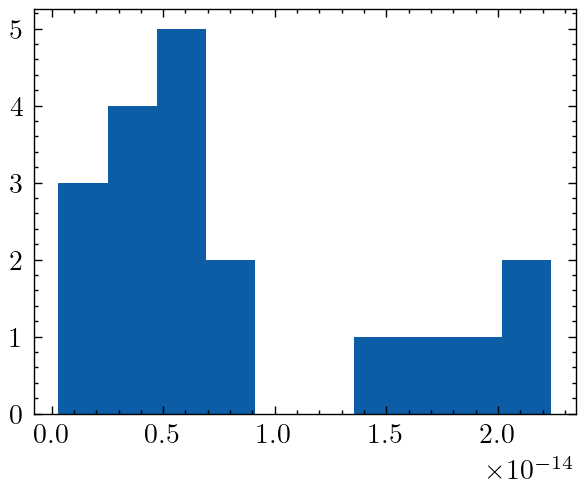

In [95]:
##########################################
####### HMXB in Chandra HST survey #######
##########################################


from astroquery.vizier import Vizier

# Set up Vizier with a reasonable row limit (default is 50,000)
Vizier.ROW_LIMIT = -1  # No row limit to fetch all data

# Specify the catalog identifier
catalog_id = "J/ApJ/906/120"

# Query the catalog
result = Vizier.get_catalogs(catalog_id)

# Access the specific table (e.g., first table in the result)
table = result[0]  # Assuming the desired table is the first one

# Display the table
# print(table)

# Optionally save to a file
# table.write("apj906_120_table.fits", format="fits", overwrite=True)
from astropy.coordinates import SkyCoord
from astropy import units as u

# Create SkyCoord object for table coordinates
index = table['Class']=='XRB'
HMXBs_in_ChandraHST = table[index]
HMXBs_in_ChandraHST
table_coords = SkyCoord(ra=HMXBs_in_ChandraHST['RAJ2000'] , dec=HMXBs_in_ChandraHST['DEJ2000'],unit='deg', frame='fk5')

# Match table coordinates with All_Src_coordinate
idx, sep2d, _ = table_coords.match_to_catalog_sky(All_Src_coordinate)

# Filter matches based on a separation threshold (e.g., 1 arcsec)
sep_threshold = 4 * u.arcsec  # Adjust threshold as needed
matches = sep2d < sep_threshold

# Get matched entries
matched_table = HMXBs_in_ChandraHST[matches]
matched_coordinates = All_Src_coordinate[idx[matches]]

# Display matched entries
# print(matched_table)
# matched_table

plt.hist(Identification[idx[matches]]['EP_4_FLUX'])
HMXBs_matched_in_ChnadraHST = Identification[idx[matches]]
Identification['HMXBs_matched_in_ChnadraHST']=0
Identification['HMXBs_matched_in_ChnadraHST'][idx[matches]]=1
np.sum(Identification[idx[matches]]['HMXBs_matched_in_ChnadraHST'])

In [96]:
# Mask = 'data/XMM_Mask_Region0_Disk_remove3arcmin_RemoveDwarfGalaxy_v3.2.fits.gz'
# All_mask = fits.getdata(Mask)
# plt.imshow(All_mask)
# plt.xlim([1000,3500])
# plt.ylim([1000,3500])
# plt.show()

# Mask = 'data/XMM_Mask_Region4_Center3-8arcmin_v3.2.fits.gz'
# Region1=fits.getdata(Mask)
# Mask = 'data/XMM_Mask_Region7_InterArm_v3.2.fits.gz'
# Region4=fits.getdata(Mask)
# Mask = 'data/XMM_Mask_Region8_Ring_v3.2.fits.gz'
# Region3=fits.getdata(Mask)
# Mask = 'data/XMM_Mask_Region3_innerArm2_v3.2.fits.gz'
# Region2=fits.getdata(Mask)

# plt.imshow(Region1+Region2+Region3+Region4)
# plt.xlim([1000,3500])
# plt.ylim([1000,3500])
# plt.show()

# plt.imshow(Region2+Region3)
# plt.xlim([1000,3500])
# plt.ylim([1000,3500])
# plt.show()

# plt.imshow(Region2)
# plt.xlim([1000,3500])
# plt.ylim([1000,3500])
# plt.show()

# plt.imshow(Region3)
# plt.xlim([1000,3500])
# plt.ylim([1000,3500])
# plt.show()

# New_Region2 = Region2*(1-Region3)
# plt.imshow(New_Region2)
# plt.xlim([1000,3500])
# plt.ylim([1000,3500])
# plt.show()

# fits.writeto('data/XMM_Mask_New_Region2.fits',header=fits.getheader(Mask),data=New_Region2,overwrite=True)

# New_All_region = Region1+Region2+Region3+Region4
# # New_All_region[New_All_region>1]==1
# New_All_region = np.int_(New_All_region>0)
# plt.imshow(New_All_region)
# print(np.max(New_All_region))
# plt.xlim([1000,3500])
# plt.ylim([1000,3500])
# plt.show()

# fits.writeto('data/XMM_Mask_New_All_Region.fits',header=fits.getheader(Mask),data=New_All_region,overwrite=True)





In [97]:
# Identification =             Table.read('1.srclist_sum_table_CorrectFlux_expanded_slim_CorrectAstrometry_v6_Identification_v4_XMMLPt_CSC_final.fits')
# table_with_identification  = Table.read('1.srclist_sum_table_CorrectFlux_expanded_slim_CorrectAstrometry_v6_Identification_v4_XMMLPt_CSC_final.fits')
EnergyRange = ['00200_00500','00500_01000','01000_02000','02000_04500','04500_12000']
# print(len(Identification))
# Identification = Identification[spurious_source_index] # exclude the spurious sources around the brightest sources.
# Identification = Identification[(Identification['type']!='GCl')] # exclude the GCl
# Identification = Identification[Identification['SRCID']!=33011257030100001] # exclude the AGN
print(len(Identification))
Band=4
bin_number = 120
expanded_times = 100
S_start = -16
S_end = -8
cutoff = 0.1
data_bins = np.logspace(S_start,S_end,bin_number+1)
model_bins = np.logspace(S_start,S_end,bin_number*expanded_times+1)
S_model =  np.sqrt(model_bins[1:]*model_bins[:-1])
S_data =  np.sqrt(data_bins[1:]*data_bins[:-1])
dS_model = model_bins[1:]-model_bins[:-1]
dS_data = data_bins[1:]-data_bins[:-1]
################################################################################
Sensmap = f'data/snsmap_EP_{EnergyRange[Band-1]}_ML6.fits.gz'
MassMap = 'data/Stellar_mass_profile.fits'
SFRMap = 'data/SFR.fits'
print(Sensmap)
XLF_Data_band = {}
Source = Identification
SourceFlux = Source[f'EP_{Band}_FLUX']
print(f'EP_{Band}_FLUX')
Source_coordinate = SkyCoord(ra=Source['RA'],dec=Source['DEC'],unit=u.deg,frame='fk5' )
SourceFlux = SourceFlux
Skycoord = Source_coordinate
# Sensmap = f'data/snsmap_EP_02000_04500_ML6.fits'
################################################################################
Mask = 'data/MskMap_background.fits.gz'
Filtered_SourceFlux = filter_source_on_Sensmap(SourceFlux,Skycoord,Sensmap,Mask=Mask)
weight = get_weight_from_sky_area_function(Filtered_SourceFlux,Sensmap,Mask=Mask,bins=np.logspace(-20,-10,2001))
#     N,bins = sub_get_luminosity_function(SourceFlux,weight,bins,plot=False)
dN_corr,bins = np.histogram(Filtered_SourceFlux, bins=data_bins,weights=weight)
N_corr = np.cumsum(dN_corr[::-1])[::-1]
square_dN_err_corr,bins = np.histogram(Filtered_SourceFlux, bins=data_bins,weights=weight**2)
square_N_err_corr = np.cumsum(square_dN_err_corr[::-1])[::-1]
N_err_corr = np.sqrt(square_N_err_corr)
dN,bins = np.histogram(Filtered_SourceFlux, bins=data_bins) #,weights=weight)
dN_InSmallBin,bins = np.histogram(Filtered_SourceFlux, bins=model_bins) #,weights=weight)
N = np.cumsum(dN[::-1])[::-1]
N_err = 1+np.sqrt(N+0.75)
N_err_corr = (1+np.sqrt(N+0.75))*(N_corr/N)
# plt.stairs(dN,data_bins)
# plt.xscale('log')
FluxBins,sky_area_function,cutoff_sensitivity = skyarea_function_from_sensmap(Sensmap=Sensmap,Mask=Mask,bins=np.hstack((1e-20,S_model)),cutoff=cutoff,plot=False)
FluxBins,massfunction = mass_function(Sensmap=Sensmap,Mask=Mask,MassMap=MassMap,bins=np.hstack((1e-20,S_model)),cutoff=cutoff,plot=False)
FluxBins,SFRfunction = SFR_function(Sensmap=Sensmap,Mask=Mask,SFRMap=SFRMap,bins=np.hstack((1e-20,S_model)),cutoff=cutoff,plot=False)
XLF_Data_band['Back'] = {'S':data_bins, 'dN':dN,'dN_InSmallBin':dN_InSmallBin,'dN_corr':dN_corr, 'N_corr':N_corr,'N':N,'N_err_corr':N_err_corr, "sky_area_function":sky_area_function.value,'mass_function':massfunction,'SFR_function':SFRfunction, "cutoff_sensitivity":cutoff_sensitivity}
#--------------------------------------------
Mask = 'data/XMM_Mask_Region8_Ring_v3.2.fits.gz'
Filtered_SourceFlux = filter_source_on_Sensmap(SourceFlux,Skycoord,Sensmap,Mask=Mask)
weight = get_weight_from_sky_area_function(Filtered_SourceFlux,Sensmap,Mask=Mask,bins=np.logspace(-20,-10,2001))
#     N,bins = sub_get_luminosity_function(SourceFlux,weight,bins,plot=False)
dN_corr,bins = np.histogram(Filtered_SourceFlux, bins=data_bins,weights=weight)
N_corr = np.cumsum(dN_corr[::-1])[::-1]
square_dN_err_corr,bins = np.histogram(Filtered_SourceFlux, bins=data_bins,weights=weight**2)
square_N_err_corr = np.cumsum(square_dN_err_corr[::-1])[::-1]
N_err_corr = np.sqrt(square_N_err_corr)
dN,bins = np.histogram(Filtered_SourceFlux, bins=data_bins) #,weights=weight)
dN_InSmallBin,bins = np.histogram(Filtered_SourceFlux, bins=model_bins) #,weights=weight)
N = np.cumsum(dN[::-1])[::-1]
N_err = 1+np.sqrt(N+0.75)
N_err_corr = (1+np.sqrt(N+0.75))*(N_corr/N)
# plt.stairs(dN,data_bins)
# plt.xscale('log')
FluxBins,sky_area_function,cutoff_sensitivity = skyarea_function_from_sensmap(Sensmap=Sensmap,Mask=Mask,bins=np.hstack((1e-20,S_model)),cutoff=cutoff,plot=False)
FluxBins,massfunction = mass_function(Sensmap=Sensmap,Mask=Mask,MassMap=MassMap,bins=np.hstack((1e-20,S_model)),cutoff=cutoff,plot=False)
FluxBins,SFRfunction = SFR_function(Sensmap=Sensmap,Mask=Mask,SFRMap=SFRMap,bins=np.hstack((1e-20,S_model)),cutoff=cutoff,plot=False)
XLF_Data_band['Ring'] = {'S':data_bins, 'dN':dN,'dN_InSmallBin':dN_InSmallBin, 'dN_corr':dN_corr, 'N_corr':N_corr,'N':N,'N_err_corr':N_err_corr, "sky_area_function":sky_area_function.value,'mass_function':massfunction,'SFR_function':SFRfunction, "cutoff_sensitivity":cutoff_sensitivity}
#--------------------------------------------
Mask = 'data/XMM_Mask_Region3_innerArm2_v3.2.fits.gz'
Mask = 'data/XMM_Mask_New_Region2.fits'
Filtered_SourceFlux = filter_source_on_Sensmap(SourceFlux,Skycoord,Sensmap,Mask=Mask)
weight = get_weight_from_sky_area_function(Filtered_SourceFlux,Sensmap,Mask=Mask,bins=np.logspace(-20,-10,2001))
#     N,bins = sub_get_luminosity_function(SourceFlux,weight,bins,plot=False)
dN_corr,bins = np.histogram(Filtered_SourceFlux, bins=data_bins,weights=weight)
N_corr = np.cumsum(dN_corr[::-1])[::-1]
square_dN_err_corr,bins = np.histogram(Filtered_SourceFlux, bins=data_bins,weights=weight**2)
square_N_err_corr = np.cumsum(square_dN_err_corr[::-1])[::-1]
N_err_corr = np.sqrt(square_N_err_corr)
dN,bins = np.histogram(Filtered_SourceFlux, bins=data_bins) #,weights=weight)
dN_InSmallBin,bins = np.histogram(Filtered_SourceFlux, bins=model_bins) #,weights=weight)
N = np.cumsum(dN[::-1])[::-1]
N_err = 1+np.sqrt(N+0.75)
N_err_corr = (1+np.sqrt(N+0.75))*(N_corr/N)
# plt.stairs(dN,data_bins)
# plt.xscale('log')
FluxBins,sky_area_function,cutoff_sensitivity = skyarea_function_from_sensmap(Sensmap=Sensmap,Mask=Mask,bins=np.hstack((1e-20,S_model)),cutoff=cutoff,plot=False)
FluxBins,massfunction = mass_function(Sensmap=Sensmap,Mask=Mask,MassMap=MassMap,bins=np.hstack((1e-20,S_model)),cutoff=cutoff,plot=False)
FluxBins,SFRfunction = SFR_function(Sensmap=Sensmap,Mask=Mask,SFRMap=SFRMap,bins=np.hstack((1e-20,S_model)),cutoff=cutoff,plot=False)
XLF_Data_band['InnerArm'] = {'S':data_bins, 'dN':dN,'dN_InSmallBin':dN_InSmallBin, 'dN_corr':dN_corr, 'N_corr':N_corr,'N':N,'N_err_corr':N_err_corr, "sky_area_function":sky_area_function.value,'mass_function':massfunction,'SFR_function':SFRfunction, "cutoff_sensitivity":cutoff_sensitivity}
#--------------------------------------------
Mask = 'data/XMM_Mask_Region4_Center3-8arcmin_v3.2.fits.gz'
Filtered_SourceFlux = filter_source_on_Sensmap(SourceFlux,Skycoord,Sensmap,Mask=Mask)
weight = get_weight_from_sky_area_function(Filtered_SourceFlux,Sensmap,Mask=Mask,bins=np.logspace(-20,-10,2001))
#     N,bins = sub_get_luminosity_function(SourceFlux,weight,bins,plot=False)
dN_corr,bins = np.histogram(Filtered_SourceFlux, bins=data_bins,weights=weight)
N_corr = np.cumsum(dN_corr[::-1])[::-1]
square_dN_err_corr,bins = np.histogram(Filtered_SourceFlux, bins=data_bins,weights=weight**2)
square_N_err_corr = np.cumsum(square_dN_err_corr[::-1])[::-1]
N_err_corr = np.sqrt(square_N_err_corr)
dN,bins = np.histogram(Filtered_SourceFlux, bins=data_bins) #,weights=weight)
dN_InSmallBin,bins = np.histogram(Filtered_SourceFlux, bins=model_bins) #,weights=weight)
N = np.cumsum(dN[::-1])[::-1]
N_err = 1+np.sqrt(N+0.75)
N_err_corr = (1+np.sqrt(N+0.75))*(N_corr/N)
# plt.stairs(dN,data_bins)
# plt.xscale('log')
FluxBins,sky_area_function,cutoff_sensitivity = skyarea_function_from_sensmap(Sensmap=Sensmap,Mask=Mask,bins=np.hstack((1e-20,S_model)),cutoff=cutoff,plot=False)
FluxBins,massfunction = mass_function(Sensmap=Sensmap,Mask=Mask,MassMap=MassMap,bins=np.hstack((1e-20,S_model)),cutoff=cutoff,plot=False)
FluxBins,SFRfunction = SFR_function(Sensmap=Sensmap,Mask=Mask,SFRMap=SFRMap,bins=np.hstack((1e-20,S_model)),cutoff=cutoff,plot=False)
XLF_Data_band['Center38'] = {'S':data_bins, 'dN':dN, 'dN_InSmallBin':dN_InSmallBin,'dN_corr':dN_corr, 'N_corr':N_corr,'N':N,'N_err_corr':N_err_corr, "sky_area_function":sky_area_function.value,'mass_function':massfunction,'SFR_function':SFRfunction, "cutoff_sensitivity":cutoff_sensitivity}
XLF_Data_band['Center'] = XLF_Data_band['Center38']
# #--------------------------------------------
Mask = 'data/XMM_Mask_Region7_InterArm_v3.2.fits.gz'
Filtered_SourceFlux = filter_source_on_Sensmap(SourceFlux,Skycoord,Sensmap,Mask=Mask)
weight = get_weight_from_sky_area_function(Filtered_SourceFlux,Sensmap,Mask=Mask,bins=np.logspace(-20,-10,2001))
#     N,bins = sub_get_luminosity_function(SourceFlux,weight,bins,plot=False)
dN_corr,bins = np.histogram(Filtered_SourceFlux, bins=data_bins,weights=weight)
N_corr = np.cumsum(dN_corr[::-1])[::-1]
square_dN_err_corr,bins = np.histogram(Filtered_SourceFlux, bins=data_bins,weights=weight**2)
square_N_err_corr = np.cumsum(square_dN_err_corr[::-1])[::-1]
N_err_corr = np.sqrt(square_N_err_corr)
dN,bins = np.histogram(Filtered_SourceFlux, bins=data_bins) #,weights=weight)
dN_InSmallBin,bins = np.histogram(Filtered_SourceFlux, bins=model_bins) #,weights=weight)
N = np.cumsum(dN[::-1])[::-1]
N_err = 1+np.sqrt(N+0.75)
N_err_corr = (1+np.sqrt(N+0.75))*(N_corr/N)
# plt.stairs(dN,data_bins)
# plt.xscale('log')
FluxBins,sky_area_function,cutoff_sensitivity = skyarea_function_from_sensmap(Sensmap=Sensmap,Mask=Mask,bins=np.hstack((1e-20,S_model)),cutoff=cutoff,plot=False)
FluxBins,massfunction = mass_function(Sensmap=Sensmap,Mask=Mask,MassMap=MassMap,bins=np.hstack((1e-20,S_model)),cutoff=cutoff,plot=False)
FluxBins,SFRfunction = SFR_function(Sensmap=Sensmap,Mask=Mask,SFRMap=SFRMap,bins=np.hstack((1e-20,S_model)),cutoff=cutoff,plot=False)
XLF_Data_band['InterArm'] = {'S':data_bins, 'dN':dN, 'dN_InSmallBin':dN_InSmallBin,'dN_corr':dN_corr, 'N_corr':N_corr,'N':N,'N_err_corr':N_err_corr, "sky_area_function":sky_area_function.value,'mass_function':massfunction,'SFR_function':SFRfunction, "cutoff_sensitivity":cutoff_sensitivity}
#--------------------------------------------
Mask = 'data/MskMap_Center_8arcmin_v3.2.fits.gz'
Filtered_SourceFlux = filter_source_on_Sensmap(SourceFlux,Skycoord,Sensmap,Mask=Mask)
weight = get_weight_from_sky_area_function(Filtered_SourceFlux,Sensmap,Mask=Mask,bins=np.logspace(-20,-10,2001))
#     N,bins = sub_get_luminosity_function(SourceFlux,weight,bins,plot=False)
dN_corr,bins = np.histogram(Filtered_SourceFlux, bins=data_bins,weights=weight)
N_corr = np.cumsum(dN_corr[::-1])[::-1]
square_dN_err_corr,bins = np.histogram(Filtered_SourceFlux, bins=data_bins,weights=weight**2)
square_N_err_corr = np.cumsum(square_dN_err_corr[::-1])[::-1]
N_err_corr = np.sqrt(square_N_err_corr)
dN,bins = np.histogram(Filtered_SourceFlux, bins=data_bins) #,weights=weight)
dN_InSmallBin,bins = np.histogram(Filtered_SourceFlux, bins=model_bins) #,weights=weight)
N = np.cumsum(dN[::-1])[::-1]
N_err = 1+np.sqrt(N+0.75)
N_err_corr = (1+np.sqrt(N+0.75))*(N_corr/N)
# plt.stairs(dN,data_bins)
# plt.xscale('log')
FluxBins,sky_area_function,cutoff_sensitivity = skyarea_function_from_sensmap(Sensmap=Sensmap,Mask=Mask,bins=np.hstack((1e-20,S_model)),cutoff=cutoff,plot=False)
FluxBins,massfunction = mass_function(Sensmap=Sensmap,Mask=Mask,MassMap=MassMap,bins=np.hstack((1e-20,S_model)),cutoff=cutoff,plot=False)
FluxBins,SFRfunction = SFR_function(Sensmap=Sensmap,Mask=Mask,SFRMap=SFRMap,bins=np.hstack((1e-20,S_model)),cutoff=cutoff,plot=False)
XLF_Data_band['Center08'] = {'S':data_bins, 'dN':dN, 'dN_InSmallBin':dN_InSmallBin,'dN_corr':dN_corr, 'N_corr':N_corr,'N':N,'N_err_corr':N_err_corr, "sky_area_function":sky_area_function.value,'mass_function':massfunction,'SFR_function':SFRfunction, "cutoff_sensitivity":cutoff_sensitivity}
#--------------------------------------------
Mask = 'data/XMM_Mask_Region0_Disk_remove8arcmin_v3.2.fits.gz'
Filtered_SourceFlux = filter_source_on_Sensmap(SourceFlux,Skycoord,Sensmap,Mask=Mask)
weight = get_weight_from_sky_area_function(Filtered_SourceFlux,Sensmap,Mask=Mask,bins=np.logspace(-20,-10,2001))
#     N,bins = sub_get_luminosity_function(SourceFlux,weight,bins,plot=False)
dN_corr,bins = np.histogram(Filtered_SourceFlux, bins=data_bins,weights=weight)
N_corr = np.cumsum(dN_corr[::-1])[::-1]
square_dN_err_corr,bins = np.histogram(Filtered_SourceFlux, bins=data_bins,weights=weight**2)
square_N_err_corr = np.cumsum(square_dN_err_corr[::-1])[::-1]
N_err_corr = np.sqrt(square_N_err_corr)
dN,bins = np.histogram(Filtered_SourceFlux, bins=data_bins) #,weights=weight)
dN_InSmallBin,bins = np.histogram(Filtered_SourceFlux, bins=model_bins) #,weights=weight)
N = np.cumsum(dN[::-1])[::-1]
N_err = 1+np.sqrt(N+0.75)
N_err_corr = (1+np.sqrt(N+0.75))*(N_corr/N)
# plt.stairs(dN,data_bins)
# plt.xscale('log')
FluxBins,sky_area_function,cutoff_sensitivity = skyarea_function_from_sensmap(Sensmap=Sensmap,Mask=Mask,bins=np.hstack((1e-20,S_model)),cutoff=cutoff,plot=False)
FluxBins,massfunction = mass_function(Sensmap=Sensmap,Mask=Mask,MassMap=MassMap,bins=np.hstack((1e-20,S_model)),cutoff=cutoff,plot=False)
FluxBins,SFRfunction = SFR_function(Sensmap=Sensmap,Mask=Mask,SFRMap=SFRMap,bins=np.hstack((1e-20,S_model)),cutoff=cutoff,plot=False)
XLF_Data_band['Disk_R8'] = {'S':data_bins, 'dN':dN,'dN_InSmallBin':dN_InSmallBin, 'dN_corr':dN_corr, 'N_corr':N_corr,'N':N,'N_err_corr':N_err_corr, "sky_area_function":sky_area_function.value,'mass_function':massfunction,'SFR_function':SFRfunction, "cutoff_sensitivity":cutoff_sensitivity}
# XLF_Data_band['Disk'] = XLF_Data_band['Disk_R8']
#--------------------------------------------
Mask = 'data/XMM_Mask_Region0_Disk_remove8arcmin_RemoveDwarfGalaxy_v3.2.fits.gz'
Filtered_SourceFlux = filter_source_on_Sensmap(SourceFlux,Skycoord,Sensmap,Mask=Mask)
weight = get_weight_from_sky_area_function(Filtered_SourceFlux,Sensmap,Mask=Mask,bins=np.logspace(-20,-10,2001))
#     N,bins = sub_get_luminosity_function(SourceFlux,weight,bins,plot=False)
dN_corr,bins = np.histogram(Filtered_SourceFlux, bins=data_bins,weights=weight)
N_corr = np.cumsum(dN_corr[::-1])[::-1]
square_dN_err_corr,bins = np.histogram(Filtered_SourceFlux, bins=data_bins,weights=weight**2)
square_N_err_corr = np.cumsum(square_dN_err_corr[::-1])[::-1]
N_err_corr = np.sqrt(square_N_err_corr)
dN,bins = np.histogram(Filtered_SourceFlux, bins=data_bins) #,weights=weight)
dN_InSmallBin,bins = np.histogram(Filtered_SourceFlux, bins=model_bins) #,weights=weight)
N = np.cumsum(dN[::-1])[::-1]
N_err = 1+np.sqrt(N+0.75)
N_err_corr = (1+np.sqrt(N+0.75))*(N_corr/N)
# plt.stairs(dN,data_bins)
# plt.xscale('log')
FluxBins,sky_area_function,cutoff_sensitivity = skyarea_function_from_sensmap(Sensmap=Sensmap,Mask=Mask,bins=np.hstack((1e-20,S_model)),cutoff=cutoff,plot=False)
FluxBins,massfunction = mass_function(Sensmap=Sensmap,Mask=Mask,MassMap=MassMap,bins=np.hstack((1e-20,S_model)),cutoff=cutoff,plot=False)
FluxBins,SFRfunction = SFR_function(Sensmap=Sensmap,Mask=Mask,SFRMap=SFRMap,bins=np.hstack((1e-20,S_model)),cutoff=cutoff,plot=False)
XLF_Data_band['Disk_R8_RG'] = {'S':data_bins, 'dN':dN,'dN_InSmallBin':dN_InSmallBin, 'dN_corr':dN_corr, 'N_corr':N_corr,'N':N,'N_err_corr':N_err_corr, "sky_area_function":sky_area_function.value,'mass_function':massfunction,'SFR_function':SFRfunction, "cutoff_sensitivity":cutoff_sensitivity}
XLF_Data_band['Disk'] = XLF_Data_band['Disk_R8_RG']

#--------------------------------------------
# Mask = 'data/XMM_Mask_Region0_Disk_remove3arcmin_RemoveDwarfGalaxy_v3.2.fits.gz'
Mask = 'data/XMM_Mask_New_All_Region.fits'
Filtered_SourceFlux = filter_source_on_Sensmap(SourceFlux,Skycoord,Sensmap,Mask=Mask)
weight = get_weight_from_sky_area_function(Filtered_SourceFlux,Sensmap,Mask=Mask,bins=np.logspace(-20,-10,2001))
#     N,bins = sub_get_luminosity_function(SourceFlux,weight,bins,plot=False)
dN_corr,bins = np.histogram(Filtered_SourceFlux, bins=data_bins,weights=weight)
N_corr = np.cumsum(dN_corr[::-1])[::-1]
square_dN_err_corr,bins = np.histogram(Filtered_SourceFlux, bins=data_bins,weights=weight**2)
square_N_err_corr = np.cumsum(square_dN_err_corr[::-1])[::-1]
N_err_corr = np.sqrt(square_N_err_corr)
dN,bins = np.histogram(Filtered_SourceFlux, bins=data_bins) #,weights=weight)
dN_InSmallBin,bins = np.histogram(Filtered_SourceFlux, bins=model_bins) #,weights=weight)
N = np.cumsum(dN[::-1])[::-1]
N_err = 1+np.sqrt(N+0.75)
N_err_corr = (1+np.sqrt(N+0.75))*(N_corr/N)
# plt.stairs(dN,data_bins)
# plt.xscale('log')
FluxBins,sky_area_function,cutoff_sensitivity = skyarea_function_from_sensmap(Sensmap=Sensmap,Mask=Mask,bins=np.hstack((1e-20,S_model)),cutoff=cutoff,plot=False)
FluxBins,massfunction = mass_function(Sensmap=Sensmap,Mask=Mask,MassMap=MassMap,bins=np.hstack((1e-20,S_model)),cutoff=cutoff,plot=False)
FluxBins,SFRfunction = SFR_function(Sensmap=Sensmap,Mask=Mask,SFRMap=SFRMap,bins=np.hstack((1e-20,S_model)),cutoff=cutoff,plot=False)
XLF_Data_band['Disk_R3_RG'] = {'S':data_bins, 'dN':dN, 'dN_InSmallBin':dN_InSmallBin, 'dN_corr':dN_corr, 'N_corr':N_corr,'N':N,'N_err_corr':N_err_corr, "sky_area_function":sky_area_function.value,'mass_function':massfunction,'SFR_function':SFRfunction, "cutoff_sensitivity":cutoff_sensitivity}
XLF_Data_band['All'] = XLF_Data_band['Disk_R3_RG']


#--------------------------------------------
# Mask = 'data/XMM_Mask_Region0_Disk_remove3arcmin_RemoveDwarfGalaxy_v3.2.fits.gz'
Mask = 'data/XMM_Mask_New_All_Region.fits'
HMXB_index = (Identification['HMXBs_matched_in_ChnadraHST']==1)
# Filtered_SourceFlux = filter_source_on_Sensmap(SourceFlux,Skycoord,Sensmap,Mask=Mask)
Filtered_SourceFlux = filter_source_on_Sensmap(SourceFlux[HMXB_index],Skycoord[HMXB_index],Sensmap,Mask=Mask)
weight = get_weight_from_sky_area_function(Filtered_SourceFlux,Sensmap,Mask=Mask,bins=np.logspace(-20,-10,2001))
#     N,bins = sub_get_luminosity_function(SourceFlux,weight,bins,plot=False)
dN_corr,bins = np.histogram(Filtered_SourceFlux, bins=data_bins,weights=weight)
N_corr = np.cumsum(dN_corr[::-1])[::-1]
square_dN_err_corr,bins = np.histogram(Filtered_SourceFlux, bins=data_bins,weights=weight**2)
square_N_err_corr = np.cumsum(square_dN_err_corr[::-1])[::-1]
N_err_corr = np.sqrt(square_N_err_corr)
dN,bins = np.histogram(Filtered_SourceFlux, bins=data_bins) #,weights=weight)
dN_InSmallBin,bins = np.histogram(Filtered_SourceFlux, bins=model_bins) #,weights=weight)
N = np.cumsum(dN[::-1])[::-1]
N_err = 1+np.sqrt(N+0.75)
N_err_corr = (1+np.sqrt(N+0.75))*(N_corr/N)
# plt.stairs(dN,data_bins)
# plt.xscale('log')
FluxBins,sky_area_function,cutoff_sensitivity = skyarea_function_from_sensmap(Sensmap=Sensmap,Mask=Mask,bins=np.hstack((1e-20,S_model)),cutoff=cutoff,plot=False)
FluxBins,massfunction = mass_function(Sensmap=Sensmap,Mask=Mask,MassMap=MassMap,bins=np.hstack((1e-20,S_model)),cutoff=cutoff,plot=False)
FluxBins,SFRfunction = SFR_function(Sensmap=Sensmap,Mask=Mask,SFRMap=SFRMap,bins=np.hstack((1e-20,S_model)),cutoff=cutoff,plot=False)
XLF_Data_band['All_HMXB'] = {'S':data_bins, 'dN':dN, 'dN_InSmallBin':dN_InSmallBin, 'dN_corr':dN_corr, 'N_corr':N_corr,'N':N,'N_err_corr':N_err_corr, "sky_area_function":sky_area_function.value,'mass_function':massfunction,'SFR_function':SFRfunction, "cutoff_sensitivity":cutoff_sensitivity}
# XLF_Data_band['All'] = XLF_Data_band['Disk_R3_RG']


4439
data/snsmap_EP_02000_04500_ML6.fits.gz
EP_4_FLUX
RA_OBJ: 10.3541655
nan
nan
RA_OBJ: 10.3541655
2.109157677185452
0.31941285349127446
RA_OBJ: 10.3541655
1.8128505717413286
0.07480980866548113
RA_OBJ: 10.3541655
1.9830265192599978
0.04827974669556436
RA_OBJ: 10.3541655
1.8756171659581393
0.14445431911142048
RA_OBJ: 10.3541655
3.7270317182269097
0.07588992793340561
RA_OBJ: 10.3541655
6.463496849200449
0.5782420981665312
RA_OBJ: 10.3541655
6.462883786874889
0.5782073046621384
RA_OBJ: 10.3541655
7.71886446221395
0.583988626495068
RA_OBJ: 10.3541655
7.71886446221395
0.583988626495068


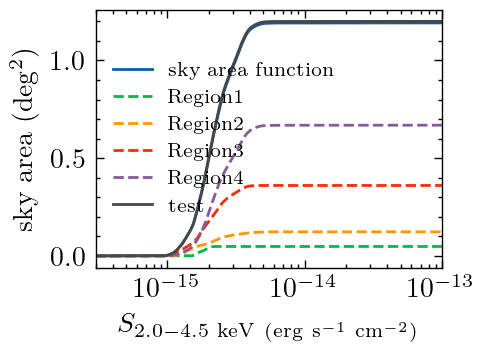

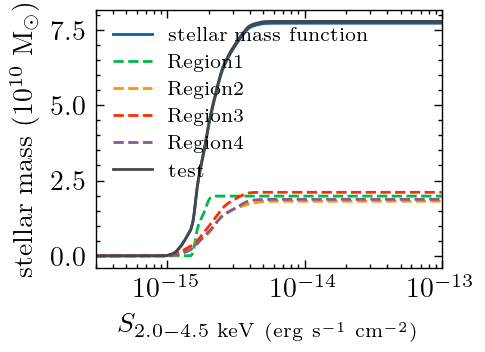

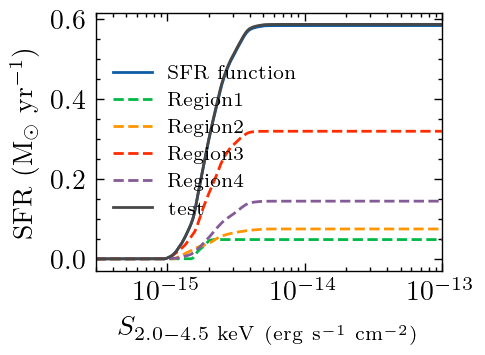

In [98]:
plt.figure(figsize=(3.35*2/3,3.35*2/3/4*3),dpi=200)
plt.plot(FluxBins,XLF_Data_band['All']['sky_area_function'],'-',label='sky area function')
plt.plot(FluxBins,XLF_Data_band['Center']['sky_area_function'],'--',label='Region1')
plt.plot(FluxBins,XLF_Data_band['InnerArm']['sky_area_function'],'--',label='Region2')
plt.plot(FluxBins,XLF_Data_band['Ring']['sky_area_function'],'--',label='Region3')
plt.plot(FluxBins,XLF_Data_band['InterArm']['sky_area_function'],'--',label='Region4')
plt.plot(FluxBins,XLF_Data_band['Center']['sky_area_function']+XLF_Data_band['InnerArm']['sky_area_function']+XLF_Data_band['Ring']['sky_area_function']+XLF_Data_band['InterArm']['sky_area_function'],'-',label='test')

plt.xscale('log')
plt.ylabel(r'sky area ($\mathrm{deg^{2}}$)')
plt.legend(fontsize=7)
plt.xlim([3e-16,1e-13])
plt.xlabel(r'$S_\mathrm{2.0-4.5~keV~(erg~s^{-1}~cm^{-2})}$')
# plt.savefig('figure/sky_area_function_band4.pdf')
# plt.savefig('figure/sky_area_function_band4.png',dpi=200)
plt.show()


plt.figure(figsize=(3.35*2/3,3.35*2/3/4*3),dpi=200)
# plt.plot(FluxBins,XLF_Data_band['All']['sky_area_function'],label='sky area function')
# plt.plot(FluxBins,XLF_Data_band['Disk']['mass_function'])
# plt.plot(FluxBins,XLF_Data_band['Disk']['mass_function'] / np.max(XLF_Data_band['Disk']['mass_function'])*np.max(sky_area_function['Disk']['mass_function']))
# plt.plot(FluxBins,XLF_Data_band['Disk']['mass_function']/XLF_Data_band['Disk']['sky_area_function'])
plt.plot(FluxBins,XLF_Data_band['All']['mass_function'],label='stellar mass function')
# plt.plot(FluxBins,XLF_Data_band['All']['sky_area_function']*np.max(XLF_Data_band['All']['mass_function'])/np.max(XLF_Data_band['All']['sky_area_function']),'--',label='normalized sky area function')
plt.plot(FluxBins,XLF_Data_band['Center']['mass_function'],'--',label='Region1')
plt.plot(FluxBins,XLF_Data_band['InnerArm']['mass_function'],'--',label='Region2')
plt.plot(FluxBins,XLF_Data_band['Ring']['mass_function'],'--',label='Region3')
plt.plot(FluxBins,XLF_Data_band['InterArm']['mass_function'],'--',label='Region4')
plt.plot(FluxBins,XLF_Data_band['Center']['mass_function']+XLF_Data_band['InnerArm']['mass_function']+XLF_Data_band['Ring']['mass_function']+XLF_Data_band['InterArm']['mass_function'],'-',label='test')
plt.xscale('log')
plt.ylabel(r'stellar mass ($10^{10}~\mathrm{M_{\odot}}$)')
plt.legend(fontsize=7)
plt.xlim([3e-16,1e-13])
plt.xlabel(r'$S_\mathrm{2.0-4.5~keV~(erg~s^{-1}~cm^{-2})}$')
# plt.savefig('figure/stellar_mass_function_band4.pdf')
# plt.savefig('figure/stellar_mass_function_band4.png',dpi=200)
plt.show()

plt.figure(figsize=(3.35*2/3,3.35*2/3/4*3),dpi=200)
# plt.plot(FluxBins,XLF_Data_band['All']['sky_area_function'],label='sky area function')
# plt.plot(FluxBins,XLF_Data_band['Disk']['mass_function'])
# plt.plot(FluxBins,XLF_Data_band['Disk']['mass_function'] / np.max(XLF_Data_band['Disk']['mass_function'])*np.max(sky_area_function['Disk']['mass_function']))
# plt.plot(FluxBins,XLF_Data_band['Disk']['mass_function']/XLF_Data_band['Disk']['sky_area_function'])
plt.plot(FluxBins,XLF_Data_band['All']['SFR_function'],label='SFR function')
# plt.plot(FluxBins,XLF_Data_band['All']['sky_area_function']*np.max(XLF_Data_band['All']['SFR_function'])/np.max(XLF_Data_band['All']['sky_area_function']),'--',label='normalized sky area function')
plt.plot(FluxBins,XLF_Data_band['Center']['SFR_function'],'--',label='Region1')
plt.plot(FluxBins,XLF_Data_band['InnerArm']['SFR_function'],'--',label='Region2')
plt.plot(FluxBins,XLF_Data_band['Ring']['SFR_function'],'--',label='Region3')
plt.plot(FluxBins,XLF_Data_band['InterArm']['SFR_function'],'--',label='Region4')
plt.plot(FluxBins,XLF_Data_band['Center']['SFR_function']+XLF_Data_band['InnerArm']['SFR_function']+XLF_Data_band['Ring']['SFR_function']+XLF_Data_band['InterArm']['SFR_function'],'-',label='test')
plt.xscale('log')
plt.ylabel(r'SFR ($\mathrm{M_\odot~yr^{-1}}$)')
plt.legend(fontsize=7)
plt.xlim([3e-16,1e-13])
plt.xlabel(r'$S_\mathrm{2.0-4.5~keV~(erg~s^{-1}~cm^{-2})}$')
# plt.savefig('figure/SFR_function_band4.pdf')
# plt.savefig('figure/SFR_function_band4.png',dpi=200)
plt.show()



In [99]:
# plt.imshow(fits.getdata(Mask),origin='lower')
# plt.show()
# MassMap = 'data/Stellar_mass_profile.fits'
# FluxBins,sky_area_function,cutoff_sensitivity = skyarea_function_from_sensmap_with_massmap(Sensmap=Sensmap,Mask=Mask,MassMap=MassMap,bins=np.hstack((1e-20,S_model)),cutoff=cutoff,plot=False)
# plt.plot(FluxBins,sky_area_function)
# plt.xscale('log')

In [100]:
#--------------------------------------------
Mask = 'data/MskMap_North.fits.gz'
Filtered_SourceFlux = filter_source_on_Sensmap(SourceFlux,Skycoord,Sensmap,Mask=Mask)
weight = get_weight_from_sky_area_function(Filtered_SourceFlux,Sensmap,Mask=Mask,bins=np.logspace(-20,-10,2001))
#     N,bins = sub_get_luminosity_function(SourceFlux,weight,bins,plot=False)
dN_corr,bins = np.histogram(Filtered_SourceFlux, bins=data_bins,weights=weight)
N_corr = np.cumsum(dN_corr[::-1])[::-1]
square_dN_err_corr,bins = np.histogram(Filtered_SourceFlux, bins=data_bins,weights=weight**2)
square_N_err_corr = np.cumsum(square_dN_err_corr[::-1])[::-1]
N_err_corr = np.sqrt(square_N_err_corr)
dN,bins = np.histogram(Filtered_SourceFlux, bins=data_bins) #,weights=weight)
N = np.cumsum(dN[::-1])[::-1]
N_err = 1+np.sqrt(N+0.75)
N_err_corr = (1+np.sqrt(N+0.75))*(N_corr/N)
# plt.stairs(dN,data_bins)
# plt.xscale('log')
FluxBins,sky_area_function,cutoff_sensitivity = skyarea_function_from_sensmap(Sensmap=Sensmap,Mask=Mask,bins=np.hstack((1e-20,S_model)),cutoff=cutoff,plot=False)
FluxBins,massfunction = mass_function(Sensmap=Sensmap,Mask=Mask,MassMap=MassMap,bins=np.hstack((1e-20,S_model)),cutoff=cutoff,plot=False)
FluxBins,SFRfunction = SFR_function(Sensmap=Sensmap,Mask=Mask,SFRMap=SFRMap,bins=np.hstack((1e-20,S_model)),cutoff=cutoff,plot=False)
XLF_Data_band['North'] = {'S':data_bins, 'dN':dN, 'dN_corr':dN_corr, 'N_corr':N_corr,'N':N,'N_err_corr':N_err_corr, "sky_area_function":sky_area_function.value,'mass_function':massfunction,'SFR_function':SFRfunction, "cutoff_sensitivity":cutoff_sensitivity}

#--------------------------------------------
Mask = 'data/MskMap_South.fits.gz'
Filtered_SourceFlux = filter_source_on_Sensmap(SourceFlux,Skycoord,Sensmap,Mask=Mask)
weight = get_weight_from_sky_area_function(Filtered_SourceFlux,Sensmap,Mask=Mask,bins=np.logspace(-20,-10,2001))
#     N,bins = sub_get_luminosity_function(SourceFlux,weight,bins,plot=False)
dN_corr,bins = np.histogram(Filtered_SourceFlux, bins=data_bins,weights=weight)
N_corr = np.cumsum(dN_corr[::-1])[::-1]
square_dN_err_corr,bins = np.histogram(Filtered_SourceFlux, bins=data_bins,weights=weight**2)
square_N_err_corr = np.cumsum(square_dN_err_corr[::-1])[::-1]
N_err_corr = np.sqrt(square_N_err_corr)
dN,bins = np.histogram(Filtered_SourceFlux, bins=data_bins) #,weights=weight)
N = np.cumsum(dN[::-1])[::-1]
N_err = 1+np.sqrt(N+0.75)
N_err_corr = (1+np.sqrt(N+0.75))*(N_corr/N)
# plt.stairs(dN,data_bins)
# plt.xscale('log')
FluxBins,sky_area_function,cutoff_sensitivity = skyarea_function_from_sensmap(Sensmap=Sensmap,Mask=Mask,bins=np.hstack((1e-20,S_model)),cutoff=cutoff,plot=False)
FluxBins,massfunction = mass_function(Sensmap=Sensmap,Mask=Mask,MassMap=MassMap,bins=np.hstack((1e-20,S_model)),cutoff=cutoff,plot=False)
FluxBins,SFRfunction = SFR_function(Sensmap=Sensmap,Mask=Mask,SFRMap=SFRMap,bins=np.hstack((1e-20,S_model)),cutoff=cutoff,plot=False)
XLF_Data_band['South'] = {'S':data_bins, 'dN':dN, 'dN_corr':dN_corr, 'N_corr':N_corr,'N':N,'N_err_corr':N_err_corr, "sky_area_function":sky_area_function.value,'mass_function':massfunction,'SFR_function':SFRfunction, "cutoff_sensitivity":cutoff_sensitivity}


#--------------------------------------------
Mask = 'data/MskMap_North.fits.gz'
star_index = (Identification['type']=='fg star') | (Identification['type']=='<fg star>')
Filtered_SourceFlux = filter_source_on_Sensmap(SourceFlux[star_index],Skycoord[star_index],Sensmap,Mask=Mask)
weight = get_weight_from_sky_area_function(Filtered_SourceFlux,Sensmap,Mask=Mask,bins=np.logspace(-20,-10,2001))
#     N,bins = sub_get_luminosity_function(SourceFlux,weight,bins,plot=False)
dN_corr,bins = np.histogram(Filtered_SourceFlux, bins=data_bins,weights=weight)
N_corr = np.cumsum(dN_corr[::-1])[::-1]
square_dN_err_corr,bins = np.histogram(Filtered_SourceFlux, bins=data_bins,weights=weight**2)
square_N_err_corr = np.cumsum(square_dN_err_corr[::-1])[::-1]
N_err_corr = np.sqrt(square_N_err_corr)
dN,bins = np.histogram(Filtered_SourceFlux, bins=data_bins) #,weights=weight)
N = np.cumsum(dN[::-1])[::-1]
N_err = 1+np.sqrt(N+0.75)
N_err_corr = (1+np.sqrt(N+0.75))*(N_corr/N)
# plt.stairs(dN,data_bins)
# plt.xscale('log')
FluxBins,sky_area_function,cutoff_sensitivity = skyarea_function_from_sensmap(Sensmap=Sensmap,Mask=Mask,bins=np.hstack((1e-20,S_model)),cutoff=cutoff,plot=False)
FluxBins,massfunction = mass_function(Sensmap=Sensmap,Mask=Mask,MassMap=MassMap,bins=np.hstack((1e-20,S_model)),cutoff=cutoff,plot=False)
FluxBins,SFRfunction = SFR_function(Sensmap=Sensmap,Mask=Mask,SFRMap=SFRMap,bins=np.hstack((1e-20,S_model)),cutoff=cutoff,plot=False)
XLF_Data_band['North_star'] = {'S':data_bins, 'dN':dN, 'dN_corr':dN_corr, 'N_corr':N_corr,'N':N,'N_err_corr':N_err_corr, "sky_area_function":sky_area_function.value,'mass_function':massfunction,'SFR_function':SFRfunction, "cutoff_sensitivity":cutoff_sensitivity}

#--------------------------------------------
Mask = 'data/MskMap_South.fits.gz'
star_index = (Identification['type']=='fg star') | (Identification['type']=='<fg star>')
Filtered_SourceFlux = filter_source_on_Sensmap(SourceFlux[star_index],Skycoord[star_index],Sensmap,Mask=Mask)
weight = get_weight_from_sky_area_function(Filtered_SourceFlux,Sensmap,Mask=Mask,bins=np.logspace(-20,-10,2001))
#     N,bins = sub_get_luminosity_function(SourceFlux,weight,bins,plot=False)
dN_corr,bins = np.histogram(Filtered_SourceFlux, bins=data_bins,weights=weight)
N_corr = np.cumsum(dN_corr[::-1])[::-1]
square_dN_err_corr,bins = np.histogram(Filtered_SourceFlux, bins=data_bins,weights=weight**2)
square_N_err_corr = np.cumsum(square_dN_err_corr[::-1])[::-1]
N_err_corr = np.sqrt(square_N_err_corr)
dN,bins = np.histogram(Filtered_SourceFlux, bins=data_bins) #,weights=weight)
N = np.cumsum(dN[::-1])[::-1]
N_err = 1+np.sqrt(N+0.75)
N_err_corr = (1+np.sqrt(N+0.75))*(N_corr/N)
# plt.stairs(dN,data_bins)
# plt.xscale('log')
FluxBins,sky_area_function,cutoff_sensitivity = skyarea_function_from_sensmap(Sensmap=Sensmap,Mask=Mask,bins=np.hstack((1e-20,S_model)),cutoff=cutoff,plot=False)
FluxBins,massfunction = mass_function(Sensmap=Sensmap,Mask=Mask,MassMap=MassMap,bins=np.hstack((1e-20,S_model)),cutoff=cutoff,plot=False)
FluxBins,SFRfunction = SFR_function(Sensmap=Sensmap,Mask=Mask,SFRMap=SFRMap,bins=np.hstack((1e-20,S_model)),cutoff=cutoff,plot=False)
XLF_Data_band['South_star'] = {'S':data_bins, 'dN':dN, 'dN_corr':dN_corr, 'N_corr':N_corr,'N':N,'N_err_corr':N_err_corr, "sky_area_function":sky_area_function.value,'mass_function':massfunction,'SFR_function':SFRfunction, "cutoff_sensitivity":cutoff_sensitivity}



RA_OBJ: 10.3541655
nan
nan
RA_OBJ: 10.3541655
nan
nan
RA_OBJ: 10.3541655
nan
nan
RA_OBJ: 10.3541655
nan
nan


In [101]:
# M31_WISE_W1 = fits.getdata('/Users/rhuang/program/M31/data/WISE/M31_WISE-W1_RemoveSourceWS150_RemoveBaselineV2_rebin8.fits')
# M31_WISE_W2 = fits.getdata('/Users/rhuang/program/M31/data/WISE/M31_WISE-W2_RemoveSourceWS150_RemoveBaselineV2_rebin8.fits')
# M31_WISE_W4 = fits.getdata('/Users/rhuang/program/M31/data/WISE/M31_WISE-W4_RemoveBaseline_rebin8.fits')

# def calculate_StellarMass(M31_WISE_W1,M31_WISE_W2,M31_WISE_W4,mask_file):
#     MASK = fits.getdata(mask_file)!=0
#     MAG_1 = 20.5-2.5*np.log10(np.nansum(M31_WISE_W1[MASK]+0))
#     MAG_2 = 19.5-2.5*np.log10(np.nansum(M31_WISE_W2[MASK]+0))
#     log_stellar_mass = (-0.4*(MAG_1-5*np.log10(761e3)+5-3.24))+(-2.54*(MAG_1-MAG_2)-0.17)
#     print(10**(log_stellar_mass-10))
#     return 10**(log_stellar_mass-10)

# mask_file = 'data/WISE/WISE_Mask_Region8_Ring_v3.2.fits.gz'
# XLF_Data_band['Ring']['StellarMass']  = calculate_StellarMass(M31_WISE_W1,M31_WISE_W2,M31_WISE_W4,mask_file)
# mask_file = 'data/WISE/WISE_Mask_Region3_innerArm2_v3.2.fits.gz'
# XLF_Data_band['InnerArm']['StellarMass']  = calculate_StellarMass(M31_WISE_W1,M31_WISE_W2,M31_WISE_W4,mask_file)
# mask_file = 'data/WISE/WISE_Mask_Region4_Center3-8arcmin_v3.2.fits.gz'
# XLF_Data_band['Center']['StellarMass']  = calculate_StellarMass(M31_WISE_W1,M31_WISE_W2,M31_WISE_W4,mask_file)
# XLF_Data_band['Center38']['StellarMass']  = calculate_StellarMass(M31_WISE_W1,M31_WISE_W2,M31_WISE_W4,mask_file)
# mask_file = 'data/WISE/WISE_Mask_Region7_InterArm_v3.2.fits.gz'
# XLF_Data_band['InterArm']['StellarMass']  = calculate_StellarMass(M31_WISE_W1,M31_WISE_W2,M31_WISE_W4,mask_file)
# mask_file = 'data/WISE/WISE_Mask_Region0_Disk_remove8arcmin_RemoveDwarfGalaxy_v3.2.fits.gz'
# XLF_Data_band['Disk_R8_RG']['StellarMass']  = calculate_StellarMass(M31_WISE_W1,M31_WISE_W2,M31_WISE_W4,mask_file)
# XLF_Data_band['Disk']['StellarMass']  = calculate_StellarMass(M31_WISE_W1,M31_WISE_W2,M31_WISE_W4,mask_file)
# mask_file = 'data/WISE/WISE_Mask_Region0_Disk_remove8arcmin_v3.2.fits.gz'
# XLF_Data_band['Disk_R8']['StellarMass']  = calculate_StellarMass(M31_WISE_W1,M31_WISE_W2,M31_WISE_W4,mask_file)
# # XLF_Data_band['Disk']['StellarMass']  = calculate_StellarMass(M31_WISE_W1,M31_WISE_W2,M31_WISE_W4,mask_file)


XLF_Data_band['Ring']['StellarMass'] = np.max(XLF_Data_band['Ring']['mass_function'])
XLF_Data_band['InnerArm']['StellarMass'] = np.max(XLF_Data_band['InnerArm']['mass_function'])
XLF_Data_band['Center']['StellarMass'] = np.max(XLF_Data_band['Center']['mass_function'])
XLF_Data_band['Center38']['StellarMass'] = np.max(XLF_Data_band['Center38']['mass_function'])
XLF_Data_band['InterArm']['StellarMass'] = np.max(XLF_Data_band['InterArm']['mass_function'])
XLF_Data_band['Disk_R8_RG']['StellarMass'] = np.max(XLF_Data_band['Disk_R8_RG']['mass_function'])
XLF_Data_band['Disk_R8']['StellarMass'] = np.max(XLF_Data_band['Disk_R8']['mass_function'])
XLF_Data_band['Disk']['StellarMass'] = np.max(XLF_Data_band['Disk']['mass_function'])
XLF_Data_band['All']['StellarMass'] = np.max(XLF_Data_band['All']['mass_function'])
XLF_Data_band['All']['StellarMass']

7.71886446221395

In [102]:
################################################
# What is the bright source in the InterArm.
################################################

Mask = 'data/XMM_Mask_Region7_InterArm_v3.2.fits.gz'
Filtered_index = filter_source_on_Sensmap_index(SourceFlux,Skycoord,Sensmap,Mask=Mask)

string = """# Region file format: DS9 version 4.1
global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1
fk5
"""

for src in Identification[Filtered_index]:
    if src['EP_4_FLUX']>2e-13:
        string += f"""circle({src['RA']:.4f},{src['DEC']:.4f},25.000") # color=red width=4\n"""
    else:
        string += f"""circle({src['RA']:.4f},{src['DEC']:.4f},15.000") # color=cyan width=2\n"""
# print(string)
with open('data/WISE/InterArm_Source.reg','w') as f:
    f.write(string)
    

# the sources brighter than 1e-13 in the InterArm
Identification[Filtered_index][Identification[Filtered_index]['EP_4_FLUX']>2e-13]['SRCID','RA','DEC','EP_4_FLUX','type']

# plt.stairs(XLF_Data_band['InterArm']['dN'],XLF_Data_band['InterArm']['S'],)
# plt.xscale('log')

# 23010927040100010 is quasar http://cdsportal.u-strasbg.fr/?target=11.73130124%2C%2042.34663




<Table length=5>
      SRCID               RA                DEC           EP_4_FLUX     type  
                         deg                deg         erg / (s cm2)         
      int64            float64            float64          float32    bytes100
----------------- ------------------ ------------------ ------------- --------
23010927070100001 10.716077654558251  41.51890130362631 1.7692656e-12     LMXB
23040256120100002 11.439475273607648 41.661804921663006 3.0599009e-12     LMXB
23010927030100005 11.612245325359797 42.031397379217886  5.499765e-13      GlC
33011257020100004 10.565611919513604  41.02072827190501  9.819802e-13      GlC
33040256010100006  9.638025721586855  40.35867510286549 2.9977025e-13     LMXB

In [103]:
# # #--------------------------------------------
# Mask = 'data/XMM_Mask_Region7_InterArm_v3.2.fits.gz'
# Filtered_SourceFlux = filter_source_on_Sensmap(SourceFlux,Skycoord,Sensmap,Mask=Mask)
# weight = get_weight_from_sky_area_function(Filtered_SourceFlux,Sensmap,Mask=Mask,bins=np.logspace(-20,-10,2001))
# #     N,bins = sub_get_luminosity_function(SourceFlux,weight,bins,plot=False)
# dN_corr,bins = np.histogram(Filtered_SourceFlux, bins=data_bins,weights=weight)
# N_corr = np.cumsum(dN_corr[::-1])[::-1]
# square_dN_err_corr,bins = np.histogram(Filtered_SourceFlux, bins=data_bins,weights=weight**2)
# square_N_err_corr = np.cumsum(square_dN_err_corr[::-1])[::-1]
# N_err_corr = np.sqrt(square_N_err_corr)
# dN,bins = np.histogram(Filtered_SourceFlux, bins=data_bins) #,weights=weight)
# N = np.cumsum(dN[::-1])[::-1]
# N_err = 1+np.sqrt(N+0.75)
# N_err_corr = (1+np.sqrt(N+0.75))*(N_corr/N)
# # plt.stairs(dN,data_bins)
# # plt.xscale('log')
# FluxBins,sky_area_function,cutoff_sensitivity = skyarea_function_from_sensmap(Sensmap=Sensmap,Mask=Mask,bins=np.hstack((1e-20,S_model)),cutoff=cutoff,plot=False)
# XLF_Data_band['InterArm'] = {'S':data_bins, 'dN':dN, 'dN_corr':dN_corr, 'N_corr':N_corr,'N':N,'N_err_corr':N_err_corr, "sky_area_function":sky_area_function.value, "cutoff_sensitivity":cutoff_sensitivity}


In [104]:
# flux2luminosity(2e-13)
# # luminosity2flux(1e37)

## prepare the fitting 

In [105]:
ui.clean()

In [106]:

class LFmodel:
    def __init__(self,S_model,dS_model,sky_area_function,model,cutoff_sensitivity):
        self.dS_model = dS_model
        self.sky_area_function = sky_area_function
        self.S_model = S_model
        self.model = model
        self.cutoff_sensitivity = cutoff_sensitivity
     
    def __call__(self, pars,x):
#         print(pars)
        model_dN = self.model(self.S_model,pars) * self.dS_model * self.sky_area_function
        rebin_indices = np.floor(np.arange(len(model_dN)) / expanded_times).astype(int)
        new_model_dN = np.bincount(rebin_indices, weights=model_dN)
        return new_model_dN[S_data>self.cutoff_sensitivity]
    
    

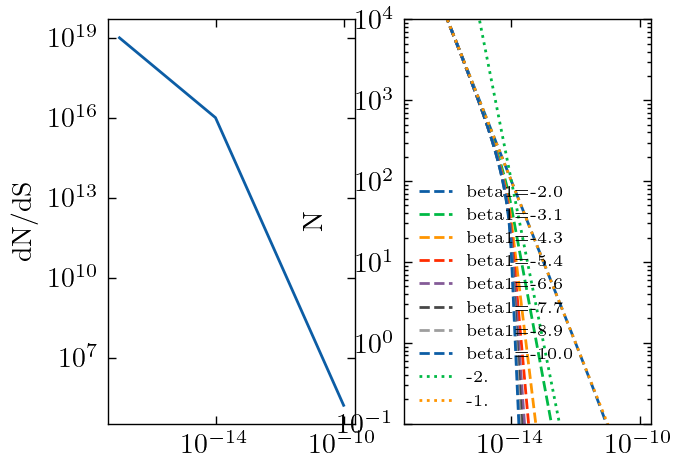

In [107]:
def cutoff_brokenpl_dN(S, para):
    K, beta1, beta2, fb,cutoff = para
    dN = K*1e14*(S/S_ref)**(-beta1)
    index = S> fb*1e-14
    dN[index] = K*1e14*(fb*1e-14/S_ref)**(beta2-beta1)* (S[index]/S_ref)**(-beta2)
    index = np.log10(S)>cutoff
    dN[index]=0
    return dN
S_ref = 1e-14

plt.subplot(121)
X =  np.logspace(-17,-10,1001)
X_model = np.sqrt(X[1:]*X[:-1])
plt.plot(X_model,cutoff_brokenpl_dN(X_model, (100,1,2.7,1,0)))
plt.xscale('log')
plt.yscale('log')
plt.ylabel('dN/dS')
# plt.show()

plt.subplot(122)
for i in np.linspace(2,10,8):
    
    dN = cutoff_brokenpl_dN(X_model, (100,2,i,1,0)) * (X[1:]-X[:-1])
    plt.plot(X_model,np.cumsum(dN[::-1])[::-1],'--',label=f'beta1=-{i:.1f}')
    
plt.plot(X_model,100*(X_model/1e-14)**-2.,':',label='-2.')
plt.plot(X_model,100*(X_model/1e-14)**-1.,':',label='-1.')
plt.xscale('log')
plt.yscale('log')
# plt.plot(S_data,XLF_Data_band['Back']['N_corr'],'k')
plt.legend(fontsize=6)
plt.ylim(0.1,1e4)
plt.ylabel('N')
plt.show()

# plt.plot(np.log10(X_model),dN/(np.log10(X[1:])-np.log10(X[:-1])))
# # plt.xscale('log')
# plt.yscale('log')

In [108]:
def power_law(x, para):
    A,alpha = para
    N = A *1e14* (x/1e-14)**(-alpha)#/(u.deg**2)
    N[x>2e-13]=0
    return N
def cutoff_power_law(x, para):
    A,alpha,cutoff = para
    y = A *1e14* (x/1e-14)**(-alpha)#/(u.deg**2)
    y[np.log10(x)>cutoff]=0
    return y
S_ref = 1e-14
def brokenpl_dN(S, para):
    K, beta1, beta2, fb = para
    dN = K*1e14*(S/S_ref)**(-beta1)
    index = S> fb*1e-14
    dN[index] = K*1e14*(fb*1e-14/S_ref)**(beta2-beta1)* (S[index]/S_ref)**(-beta2)
    dN[S>2e-13]=0
    return dN

def cutoff_brokenpl_dN(S, para):
    K, beta1, beta2, fb,cutoff = para
    dN = K*1e14*(S/S_ref)**(-beta1)
    index = S> fb*1e-14
    dN[index] = K*1e14*(fb*1e-14/S_ref)**(beta2-beta1)* (S[index]/S_ref)**(-beta2)
    index = np.log10(S)>cutoff
    dN[index]=0
    return dN


for i,region_label in enumerate(['Back','North','South','Center','Disk','Ring','InnerArm','InterArm','All']):
    print(i+1,region_label)
    ##################################### star
    exec(f"""{region_label}_LFmodel_star = LFmodel(S_model,dS_model,XLF_Data_band['{region_label}']['sky_area_function'],power_law,XLF_Data_band['{region_label}']['cutoff_sensitivity'])""")
    exec(f"""ui.load_user_model({region_label}_LFmodel_star, "{region_label}_star")""")
    exec(f"""ui.add_user_pars("{region_label}_star", ['A','alpha',],[120,2.1,])""")
    if region_label=='Back':
        Back_star.A.set(val=350,min=10,max=500)
        Back_star.alpha.set(val=2.1,min=1,max=3)
    else:
        exec(f"""{region_label}_star.A = Back_star.A""")
        exec(f"""{region_label}_star.alpha = Back_star.alpha""")
        
        
    ##################################### AGN
    exec(f"""{region_label}_LFmodel_AGN = LFmodel(S_model,dS_model,XLF_Data_band['{region_label}']['sky_area_function'],brokenpl_dN,XLF_Data_band['{region_label}']['cutoff_sensitivity'])""")
    exec(f"""ui.load_user_model({region_label}_LFmodel_AGN, "{region_label}_AGN")""")
    exec(f"""ui.add_user_pars("{region_label}_AGN", ['K','beta1','beta2','fb',],[360,1.46,2.72,0.53,])""")
    if region_label=='Back':
        Back_AGN.beta1.set(val=1.46,min=1,max=3)
        Back_AGN.beta2.set(val=2.72,min=1,max=3)
        Back_AGN.K.set(val=350,min=100,max=500)
        Back_AGN.fb.set(val=0.53,min=0.05,max=10)
        Back_AGN.beta1.freeze()
        Back_AGN.beta2.freeze()
        Back_AGN.K.freeze()
        Back_AGN.fb.freeze()

    else:
        exec(f"""{region_label}_AGN.K = Back_AGN.K""")
        exec(f"""{region_label}_AGN.fb = Back_AGN.fb""")
        exec(f"""{region_label}_AGN.beta1 = Back_AGN.beta1""")
        exec(f"""{region_label}_AGN.beta2 = Back_AGN.beta2""")

    ##################################### LMXB
    ## Here is the most important change!
    ## The sky area function is changed to mass_function
    exec(f"""{region_label}_LFmodel_LMXB = LFmodel(S_model,dS_model,XLF_Data_band['{region_label}']['mass_function'],cutoff_brokenpl_dN,XLF_Data_band['{region_label}']['cutoff_sensitivity'])""")
    exec(f"""ui.load_user_model({region_label}_LFmodel_LMXB, "{region_label}_LMXB")""")
    exec(f"""ui.add_user_pars("{region_label}_LMXB", ['K','beta1','beta2','fb','cutoff'],[309,1.31,2.57,20,-12])""")
        
    if region_label=='Back' or region_label=='North' or region_label=='South':
        continue
    if region_label=='Center':
        Center_LMXB.beta1.set(val=1.31,min=1,max=3)
        Center_LMXB.beta2.set(val=2.57,min=1,max=3)
        Center_LMXB.K.set(val=309,min=0.01,max=500)
        Center_LMXB.fb.set(val=20,min=0.1,max=200)
        Center_LMXB.cutoff.set(val=-12,min=-13,max=-10)
        Center_LMXB.beta1.freeze()
        Center_LMXB.beta2.freeze()
    else:
#         exec(f"""{region_label}_LMXB.K      = Center_LMXB.K""")
#         exec(f"""{region_label}_LMXB.K.set(val=10,min=0.1,max=400)""")
#         exec(f"""{region_label}_LMXB.fb     = Center_LMXB.fb""")
#         exec(f"""{region_label}_LMXB.beta1  = Center_LMXB.beta1""")
#         exec(f"""{region_label}_LMXB.beta2  = Center_LMXB.beta2""")
#         exec(f"""{region_label}_LMXB.cutoff = Center_LMXB.cutoff""")
        exec(f"""{region_label}_LMXB.K.set(val=7.7,min=0.001,max=70)""")
        exec(f"""{region_label}_LMXB.beta1.set(val=1.4,min=.1,max=3)""")
        exec(f"""{region_label}_LMXB.beta2.set(val=4.5,min=1.5,max=6.)""")
        exec(f"""{region_label}_LMXB.fb.set(val=90,min=10,max=150)""")
        exec(f"""{region_label}_LMXB.cutoff.set(val=0,min=-13,max=0)""")
        exec(f"""{region_label}_LMXB.K.thaw()""")
        exec(f"""{region_label}_LMXB.beta1.thaw()""")
        exec(f"""{region_label}_LMXB.beta2.thaw()""")
        exec(f"""{region_label}_LMXB.fb.thaw()""")
        exec(f"""{region_label}_LMXB.cutoff.freeze()""")


    ##################################### HMXB
    if region_label == 'Back' or region_label=='North' or region_label=='South':
        continue
    # if region_label=='Center':
    #     continue
    exec(f"""{region_label}_LFmodel_HMXB = LFmodel(S_model,dS_model,XLF_Data_band['{region_label}']['SFR_function'],cutoff_power_law,XLF_Data_band['{region_label}']['cutoff_sensitivity'])""")
    exec(f"""ui.load_user_model({region_label}_LFmodel_HMXB, "{region_label}_HMXB")""")
    exec(f"""ui.add_user_pars("{region_label}_HMXB", ['A','alpha','cutoff'],[9,1.6,-12])""")
#     if region_label=='Arm152':
    exec(f"""{region_label}_HMXB.A.set(val=9,min=0.,max=100)""")
    exec(f"""{region_label}_HMXB.alpha.set(val=1.6,min=1,max=2)""")
    exec(f"""{region_label}_HMXB.cutoff.set(val=0,min=-13,max=0)""")
    exec(f"""{region_label}_HMXB.alpha.freeze()""")
    exec(f"""{region_label}_HMXB.cutoff.freeze()""")
#     else:
#         exec(f"""{region_label}_HMXB.A.set(val=9,min=0.1,max=100)""")
# #         exec(f"""{region_label}_HMXB.A      = Arm2_HMXB.A""")
#         exec(f"""{region_label}_HMXB.alpha  = Arm152_HMXB.alpha""")
#         exec(f"""{region_label}_HMXB.cutoff = Arm152_HMXB.cutoff""")

    

1 Back
2 North
3 South
4 Center
5 Disk
6 Ring
7 InnerArm
8 InterArm
9 All


In [109]:
# ui.clean()

for i,region_label in enumerate(['Back','North','South','Center','Disk','Ring','InnerArm','InterArm','All']):
    print(i+1,region_label)

    exec(f"""index=S_data>XLF_Data_band['{region_label}']['cutoff_sensitivity']""")
    exec(f"""data = Data1D('{region_label}', S_data[index], XLF_Data_band['{region_label}']['dN'][index])""")
    ui.set_data(i+1,data)
    
    if region_label == 'Back' or region_label=='North' or region_label=='South':
        exec(f"""{region_label}_source_model = {region_label}_AGN+{region_label}_star""")
    # elif region_label == 'Center':
    #     exec(f"""{region_label}_source_model = {region_label}_AGN+{region_label}_star+{region_label}_LMXB""")
    else:
        exec(f"""{region_label}_source_model = {region_label}_AGN+{region_label}_star+{region_label}_LMXB+{region_label}_HMXB""")
    
    exec(f"""ui.set_model({i+1},{region_label}_source_model)""")
    
    

1 Back
2 North
3 South
4 Center
5 Disk
6 Ring
7 InnerArm
8 InterArm
9 All


In [110]:
def plot_model(S_model,dS_model,model,para,*args, **kwargs):
    model_dN_corr = model(S_model,para) * dS_model #* sky_area_function
    rebin_indices = np.floor(np.arange(len(model_dN_corr)) / expanded_times).astype(int)
    new_model_dN_corr = np.bincount(rebin_indices, weights=model_dN_corr)
    new_model_N_corr = np.cumsum(new_model_dN_corr[::-1])[::-1]
#     plt.plot(S_data,np.cumsum(new_model_dN[::-1])[::-1],'--')
    plt.plot(S_data,np.cumsum(new_model_dN_corr[::-1])[::-1],'--',*args, **kwargs)
#     return np.cumsum(new_model_dN_corr[::-1])[::-1]
    
#     return new_model_N_corr

In [111]:
S_ = np.logspace(-16,-9,300)

In [112]:
def Luo_AGN_N(S,K,beta1,beta2,fb):
    S_ref = 1e-14
#     K = 453.7e14
#     beta1 = 1.46
#     beta2 = 2.72
#     fb = 0.89
    c = K*(fb*1e-14/S_ref)**(beta2-beta1)*(fb*1e-14/S_ref)**(-beta2)*fb*1e-14/(beta2-1)
    N = K*(S/S_ref)**(-beta1)*(S)/(beta1-1)-K*(fb*1e-14/S_ref)**(-beta1)*(fb*1e-14)/(beta1-1)+c
    index = S>fb*1e-14
    N[index] =  K*(fb*1e-14/S_ref)**(beta2-beta1)*(S[index]/S_ref)**(-beta2)*S[index]/(beta2-1) #S>fb
    return N
def HMXB_N(S,K,beta,fb):
    return Luo_AGN_N(S,K,beta,beta,fb)
def LMXB_N(S,K,beta1,beta2,fb):
    return K*Luo_AGN_N(S,1e14,beta1,beta2,fb)/Luo_AGN_N(np.array([144.3e-14]),1e14,beta1,beta2,fb)
    
   

In [113]:
def Luo_AGN_N(S,K,beta1,beta2,fb):
    S_ref = 1e-14
#     K = 453.7e14
#     beta1 = 1.46
#     beta2 = 2.72
#     fb = 0.89
    c = K*(fb*1e-14/S_ref)**(beta2-beta1)*(fb*1e-14/S_ref)**(-beta2)*fb*1e-14/(beta2-1)
    N = K*(S/S_ref)**(-beta1)*(S)/(beta1-1)-K*(fb*1e-14/S_ref)**(-beta1)*(fb*1e-14)/(beta1-1)+c
    index = S>fb*1e-14
    N[index] =  K*(fb*1e-14/S_ref)**(beta2-beta1)*(S[index]/S_ref)**(-beta2)*S[index]/(beta2-1) #S>fb
    return N

def HMXB_N(S,K,beta):
    return K*Luo_AGN_N(S,1,beta,beta,1)/Luo_AGN_N(np.array([144.3e-14]),1,beta,beta,1)

def LMXB_N(S,K,beta1,beta2,fb):
    return K*Luo_AGN_N(S,1e14,beta1,beta2,fb)/Luo_AGN_N(np.array([144.3e-14]),1e14,beta1,beta2,fb)


def sub_cutoff_brokenpl_dN_v2(S, para):
    K, beta1, beta2, fb,cutoff = para
    dN = K*(S/S_ref)**(-beta1)
    index = S> fb*1e-14
    dN[index] = K*(fb*1e-14/S_ref)**(beta2-beta1)* (S[index]/S_ref)**(-beta2)
    index = np.log10(S)>cutoff
    dN[index]=0
    return dN
# def cutoff_brokenpl_dN_v2(S, para):
#     K, beta1, beta2, fb,cutoff = para
#     return sub_cutoff_brokenpl_dN_v2(S,para)/sub_cutoff_brokenpl_dN_v2(np.array([144.3e-14/3.124,]),para)

def cal_model(S_model,dS_model,model,para,*args, **kwargs):
    model_dN_corr = model(S_model,para) * dS_model #* sky_area_function
#     rebin_indices = np.floor(np.arange(len(model_dN_corr)) / expanded_times).astype(int)
#     new_model_dN_corr = np.bincount(rebin_indices, weights=model_dN_corr)
    new_model_N_corr = np.cumsum(model_dN_corr[::-1])[::-1]
#     plt.plot(S_data,np.cumsum(new_model_dN[::-1])[::-1],'--')
#     plt.plot(S_data,np.cumsum(new_model_dN_corr[::-1])[::-1],'--',*args, **kwargs)
    return S_model,new_model_N_corr

def cal_model_flux(S_model,dS_model,model,para,*args, **kwargs):
    model_dN_corr = model(S_model,para) * dS_model * S_model #* sky_area_function
#     rebin_indices = np.floor(np.arange(len(model_dN_corr)) / expanded_times).astype(int)
#     new_model_dN_corr = np.bincount(rebin_indices, weights=model_dN_corr)
    new_model_N_corr = np.cumsum(model_dN_corr[::-1])[::-1]
#     plt.plot(S_data,np.cumsum(new_model_dN[::-1])[::-1],'--')
#     plt.plot(S_data,np.cumsum(new_model_dN_corr[::-1])[::-1],'--',*args, **kwargs)
    return S_model,new_model_N_corr

    

In [114]:
luminosity2flux(1e38)

1.4431774423533874e-12

In [115]:
def cal_model(S_model,dS_model,model,para,*args, **kwargs):
    model_dN_corr = model(S_model,para) * dS_model #* sky_area_function
#     rebin_indices = np.floor(np.arange(len(model_dN_corr)) / expanded_times).astype(int)
#     new_model_dN_corr = np.bincount(rebin_indices, weights=model_dN_corr)
    new_model_N_corr = np.cumsum(model_dN_corr[::-1])[::-1]
#     plt.plot(S_data,np.cumsum(new_model_dN[::-1])[::-1],'--')
#     plt.plot(S_data,np.cumsum(new_model_dN_corr[::-1])[::-1],'--',*args, **kwargs)
    return S_model,new_model_N_corr

def cal_model_flux(S_model,dS_model,model,para,*args, **kwargs):
    model_dN_corr = model(S_model,para) * dS_model * S_model #* sky_area_function
#     rebin_indices = np.floor(np.arange(len(model_dN_corr)) / expanded_times).astype(int)
#     new_model_dN_corr = np.bincount(rebin_indices, weights=model_dN_corr)
    new_model_N_corr = np.cumsum(model_dN_corr[::1])[::1]
#     plt.plot(S_data,np.cumsum(new_model_dN[::-1])[::-1],'--')
#     plt.plot(S_data,np.cumsum(new_model_dN_corr[::-1])[::-1],'--',*args, **kwargs)
    return S_model,new_model_N_corr

def plot_model_v2(S_model,dS_model,model,para,*args, **kwargs):
    model_dN_corr = model(S_model,para) * dS_model #* sky_area_function
#     rebin_indices = np.floor(np.arange(len(model_dN_corr)) / expanded_times).astype(int)
#     new_model_dN_corr = np.bincount(rebin_indices, weights=model_dN_corr)
    new_model_N_corr = np.cumsum(model_dN_corr[::-1])[::-1]
#     plt.plot(S_data,np.cumsum(new_model_dN[::-1])[::-1],'--')
    plt.plot(S_model,new_model_N_corr,'--',*args, **kwargs)
    return S_model,new_model_N_corr

def sub_cutoff_brokenpl_dN_v2(S, para):
    S_ref = 1e-14
    K, beta1, beta2, fb,cutoff = para
    dN = K*1e14*(S/S_ref)**(-beta1)
    index = S> fb*1e-14
    dN[index] = K*1e14*(fb*1e-14/S_ref)**(beta2-beta1)* (S[index]/S_ref)**(-beta2)
    index = np.log10(S)>cutoff
    dN[index]=0
    return dN


In [116]:
# plt.plot(S_model,cutoff_brokenpl_dN(S_model,tuple([i.val for i in Center_LMXB.pars]))*1e-14,'red')

def sub_cutoff_brokenpl_dN_v2(S, para):
    K, beta1, beta2, fb,cutoff = para
    dN = K*1e14*(S/S_ref)**(-beta1)
    index = S> fb*1e-14
    dN[index] = K*1e14*(fb*1e-14/S_ref)**(beta2-beta1)* (S[index]/S_ref)**(-beta2)
    index = np.log10(S)>cutoff
    dN[index]=0
    return dN
def cutoff_brokenpl_dN_v2(S, para):
    K, beta1, beta2, fb,cutoff = para
    return K*sub_cutoff_brokenpl_dN_v2(S,para)/sub_cutoff_brokenpl_dN_v2(np.array([144.3e-14,]),para)



## first fitting without HMXBs

In [266]:
## fit at 2024/07/15
## only consider LMXB
ui.set_method('neldermead')
ui.set_stat('cstat')
Back_AGN.K.set(val=131,min=10,max=500)
Back_AGN.beta1.set(val=1.71558,min=0.3,max=3)   
Back_AGN.beta2.set(val=2.47258,min=0.3,max=6)   
Back_AGN.fb.set(val=0.662315,min=0.1,max=150)
Back_AGN.K.thaw()
Back_AGN.beta1.freeze()
# Back_AGN.beta2.thaw()
Back_AGN.beta2.freeze()
Back_AGN.fb.thaw()
Back_star.A.set(val=0,min=-1,max=100)
Back_star.alpha.set(val=0,min=-1,max=100)
Back_star.alpha.freeze()
Back_star.A.freeze()
ui.freeze(Back_star)
ui.fit(1) # 先拟合 Back_AGN
ui.covar(1)
Back_AGN.beta2.thaw()
ui.fit(1)

# beta1 is the slope at lower flux, beta2 is at the higher.
# The beta1 can not be constrained with Background region due to the limited sensitivity. 
# So I freeze it now, but I will let it free when fitting disk.


# the background beta 1 is thawed. It looks there is enough faint source in the center than in the background, although it is dominated by the LMXB.
# The result of center is good, and comparable with the result in the submitted paper.

All_LMXB.K.set(val=7.7,min=.01,max=70)
All_LMXB.beta1.set(val=1.4,min=.1,max=3)
All_LMXB.beta2.set(val=4.5,min=1.5,max=6.)
All_LMXB.fb.set(val=90,min=10,max=150)
All_LMXB.cutoff.set(val=0,min=-13,max=0)
All_LMXB.cutoff = -10
All_LMXB.K.thaw()
All_LMXB.beta1.thaw()
All_LMXB.beta2.thaw()
All_LMXB.fb.thaw()
All_LMXB.cutoff.freeze()
All_HMXB.alpha.val=1.6
All_HMXB.alpha.freeze()
All_HMXB.A = 0
All_HMXB.A.freeze()
All_HMXB.cutoff = -10
All_HMXB.cutoff.freeze()
# InterArm_HMXB.A.thaw()
# InterArm_LMXB.K.max = 200
# ui.fit(1,5,8)
# ui.covar(1,5,8)
Back_AGN.K.thaw()
Back_AGN.beta1.thaw()
Back_AGN.beta2.thaw()
Back_AGN.fb.thaw()
Back_AGN.K = 131
Back_AGN.K.freeze()
Back_AGN.beta1 = 2.06
Back_AGN.beta2 = 2.9
Back_AGN.fb = 1.9
ui.freeze(Back_AGN)
ui.fit(1,9)
# Back_AGN.K.thaw()
# ui.thaw(Back_AGN)
ui.covar(1,9)
# ui.fit(1,9)
# ui.covar(1,9)
ui.freeze(Back_AGN)
ui.fit(9)

Disk_LMXB.K.set(val=7.7,min=.01,max=70)
Disk_LMXB.beta1.set(val=1.4,min=.1,max=3)
Disk_LMXB.beta2.set(val=4.5,min=1.5,max=6.)
Disk_LMXB.fb.set(val=90,min=10,max=150)
Disk_LMXB.cutoff.set(val=0,min=-13,max=0)
Disk_LMXB.K.thaw()
Disk_LMXB.beta1.thaw()
Disk_LMXB.beta2.thaw()
Disk_LMXB.fb.thaw()
Disk_LMXB.cutoff.freeze()

Disk_HMXB.A.set(val=0,min=0,max=100)
Disk_HMXB.alpha.set(val=1.6,min=0,max=3)
Disk_HMXB.A.thaw()
Disk_HMXB.alpha.thaw()

Back_AGN.K.thaw()
Back_AGN.beta1.thaw()
Back_AGN.beta2.thaw()
Back_AGN.fb.thaw()

ui.freeze(Disk_HMXB)
ui.freeze(Disk_star)
# ui.fit(1,5)
ui.fit(5)
ui.covar(5)
# ui.fit(1,4,5)



Back_AGN.K.freeze()
Back_AGN.beta1.freeze()
Back_AGN.beta2.freeze()
Back_AGN.fb.freeze()

Center_LMXB.K.set(val=10,min=0.1,max=600)   
Center_LMXB.beta1.set(val=1.18585,min=1,max=3)
Center_LMXB.beta2.set(val=2.49092,min=1.5,max=6)        
Center_LMXB.fb.set(val=27.8585,min=10,max=150)  
Center_LMXB.cutoff.set(val=0,min=-13,max=0)

Center_LMXB.K.thaw()
Center_LMXB.beta1.thaw()
Center_LMXB.beta2.thaw()
Center_LMXB.fb.thaw()
Center_LMXB.cutoff.freeze()
Center_HMXB.A = 0
ui.freeze(Center_HMXB)
Center_star.A = 0
ui.freeze(Center_star)
Back_AGN.beta1.thaw()
ui.fit(1,4,9) # 拟合 Center_LMXB
Back_AGN.beta1.freeze()
ui.fit(4,)
ui.covar(4)

# 先假设 disk 上 没有HMXB， 得到一个结果。目前看这个结果却是不错。 然后就要看 HMXB 和 LMXB 之间的 correlation 了。 
# 然后再来试试 增加不同比例的 HMXB， 看看 结果会怎样变，变得有多差去了。


Ring_LMXB.K.set(val=29,min=.01,max=300)
Ring_LMXB.beta1.set(val=1.4,min=.1,max=3)
Ring_LMXB.beta2.set(val=4.5,min=1.5,max=6.)
Ring_LMXB.fb.set(val=30,min=10,max=120)
Ring_LMXB.cutoff.set(val=0,min=-13,max=0)
Ring_LMXB.K.thaw()
Ring_LMXB.beta1.thaw()
Ring_LMXB.beta2.thaw()
Ring_LMXB.fb.thaw()
Ring_LMXB.cutoff.freeze()

Ring_HMXB.A.set(val=0,min=0,max=100)
Ring_HMXB.alpha.set(val=1.6,min=0,max=3)
Ring_HMXB.A.freeze()
Ring_HMXB.alpha.freeze()

ui.freeze(Back_AGN)
# ui.fit(1,5,6)
# ui.covar(1,5,6)
Ring_LMXB.thaw()
Ring_LMXB.cutoff = -10
Ring_LMXB.cutoff.freeze()
ui.fit(6)
ui.covar(6)

## OK, 目前仍然是完全不考虑 HMXB 的， 

InnerArm_HMXB.alpha.val=1.6
InterArm_HMXB.alpha.freeze()
InnerArm_HMXB.A = 0
InnerArm_HMXB.A.freeze()
InnerArm_HMXB.freeze()
InnerArm_LMXB.K.max = 600
InnerArm_LMXB.beta1.thaw()
# ui.fit(7)
# ui.covar(7)
# InnerArm_LMXB.beta2 = 
# InnerArm_LMXB.beta2.thaw()
# ui.fit(1,5,7)
# ui.covar(1,5,7)
InnerArm_LMXB.thaw()
InnerArm_LMXB.cutoff = -10
InnerArm_LMXB.cutoff.freeze()
ui.fit(7)
ui.covar(7)


InterArm_HMXB.alpha.val=1.6
InterArm_HMXB.alpha.freeze()
InterArm_HMXB.A = 0
InterArm_HMXB.A.freeze()
InterArm_HMXB.freeze()
# InterArm_HMXB.A.thaw()
# InterArm_LMXB.K.max = 200
# ui.fit(1,5,8)
# ui.covar(1,5,8)
InterArm_LMXB.thaw()
InterArm_LMXB.cutoff = -10
InterArm_LMXB.cutoff.freeze()
ui.fit(8)
ui.covar(8)

All_HMXB.alpha.val=1.6
All_HMXB.alpha.freeze()
All_HMXB.A = 0
All_HMXB.A.freeze()
# InterArm_HMXB.A.thaw()
# InterArm_LMXB.K.max = 200
# ui.fit(1,5,8)
# ui.covar(1,5,8)
All_LMXB.thaw()
All_LMXB.cutoff = -10
All_LMXB.cutoff.freeze()
ui.fit(9)
ui.covar(9)



Dataset               = 1
Method                = neldermead
Statistic             = cstat
Initial fit statistic = 85.47
Final fit statistic   = 29.7064 at function evaluation 203
Data points           = 95
Degrees of freedom    = 93
Probability [Q-value] = 1
Reduced statistic     = 0.319424
Change in statistic   = 55.7636
   Back_AGN.K     178.214     
   Back_AGN.fb    0.666749    
Dataset               = 1
Confidence Method     = covariance
Iterative Fit Method  = None
Fitting Method        = neldermead
Statistic             = cstat
covariance 1-sigma (68.2689%) bounds:
   Param            Best-Fit  Lower Bound  Upper Bound
   -----            --------  -----------  -----------
   Back_AGN.K        178.214     -19.1434      19.1434
   Back_AGN.fb      0.666749    -0.106122     0.106122
Dataset               = 1
Method                = neldermead
Statistic             = cstat
Initial fit statistic = 29.7064
Final fit statistic   = 29.6923 at function evaluation 302
Data points       

In [257]:
InterArm_LMXB

<UserModel model instance 'usermodel.InterArm_LMXB'>

In [118]:

All_HMXB.alpha.val=1.6
All_HMXB.alpha.freeze()
All_HMXB.A = 0
All_HMXB.A.freeze()
# InterArm_HMXB.A.thaw()
# InterArm_LMXB.K.max = 200
# ui.fit(1,5,8)
# ui.covar(1,5,8)
ui.fit(9)

Dataset               = 9
Method                = neldermead
Statistic             = cstat
Initial fit statistic = 58.5353
Final fit statistic   = 58.5353 at function evaluation 434
Data points           = 103
Degrees of freedom    = 99
Probability [Q-value] = 0.999597
Reduced statistic     = 0.591265
Change in statistic   = 1.95606e-07
   All_LMXB.K     5.062       
   All_LMXB.beta1   1.16436     
   All_LMXB.beta2   2.45903     
   All_LMXB.fb    28.8185     


In [119]:
# North_AGN.K = 130
# North_AGN.beta1 = 2.06
# North_AGN.beta2 = 2.8
# North_AGN.fb = 1.87

# ui.fit(2)
# ui.covar(2)
# South_AGN.K = 130
# South_AGN.beta1 = 2.06
# South_AGN.beta2 = 2.8
# South_AGN.fb = 1.87

# ui.fit(3)
# ui.covar(3)

# North_source_model
# ui.set_xlog()
# ui.set_ylog()
# ui.plot_fit(2)

# ui.plot_fit(3,overplot=True)
# plt.xlim([1e-15,1e-12])

In [120]:
# Ring_LMXB.beta2.thaw()
# InterArm_LMXB.beta2.thaw()

# ui.thaw(Back_AGN)
# ui.fit(1)
# ui.thaw(Disk_LMXB)
# Disk_LMXB.cutoff = np.log10(luminosity2flux(1e41)/3.1)
# Disk_LMXB.cutoff.freeze()
# ui.fit(1,5)
# ui.covar(1,5,Back_AGN.K)
# ui.covar(1,5,Back_AGN.beta1)
# ui.covar(1,5,Back_AGN.beta2) 
# ui.covar(1,5,Back_AGN.fb)

# ui.freeze(Back_AGN)
# ui.covar(5,Disk_LMXB.K)
# ui.covar(5,Disk_LMXB.beta1)
# ui.covar(5,Disk_LMXB.beta2)
# ui.covar(5,Disk_LMXB.fb)

# ui.fit(4)
# Center_LMXB.beta2.max=4
# ui.covar(4)
# ui.covar(4,Center_LMXB.K)
# ui.covar(4,Center_LMXB.beta1)
# ui.covar(4,Center_LMXB.beta2)
# ui.covar(4,Center_LMXB.fb)

# ui.fit(6)
# Ring_LMXB.cutoff = np.log10(luminosity2flux(1e41)/3.1)
# Ring_LMXB.fb.max=300
# ui.covar(6,Ring_LMXB.K)
# ui.covar(6,Ring_LMXB.beta1)
# ui.covar(6,Ring_LMXB.beta2)
# ui.covar(6,Ring_LMXB.fb)
# Ring_LMXB

# # InnerArm_LMXB.beta2 = 6
# InnerArm_LMXB.beta2 = 3
# InnerArm_LMXB.beta2.max = 5
# # InnerArm_LMXB.beta2.freeze()
# InnerArm_LMXB.beta2.thaw()
# InnerArm_LMXB.cutoff=np.log10(luminosity2flux(1e41)/3.1)
# ui.fit(7)
# # InnerArm_LMXB.beta1.freeze()
# InnerArm_LMXB.beta1.thaw()
# ui.fit(7)
# ui.covar(7,)
# # ui.covar(7,InnerArm_LMXB.K)
# # ui.covar(7,InnerArm_LMXB.beta1)
# # ui.covar(7,InnerArm_LMXB.beta2)
# # ui.covar(7,InnerArm_LMXB.fb)
# InnerArm_LMXB

# InterArm_LMXB.fb.max=900
# InterArm_LMXB.cutoff = np.log10(luminosity2flux(1e41)/3.1)
# InterArm_LMXB.beta2.max = 6
# InterArm_LMXB.beta2 = 6
# # InterArm_LMXB.beta2.thaw()
# InterArm_LMXB.beta2.freeze()
# ui.fit(8)
# ui.covar(8)
# # ui.covar(8,InterArm_LMXB.K)
# # ui.covar(8,InterArm_LMXB.beta1)
# # # ui.covar(8,InterArm_LMXB.beta2)
# # ui.covar(8,InterArm_LMXB.fb)

All_HMXB.A = 0
ui.thaw(All_LMXB)
All_LMXB.cutoff = np.log10(luminosity2flux(1e41)/3.1)
All_LMXB.cutoff.freeze()
ui.fit(9)
ui.freeze(All_LMXB.cutoff)
ui.covar(9)
# ui.covar(9,All_LMXB.K)
# ui.covar(9,All_LMXB.beta1)
# ui.covar(9,All_LMXB.beta2)
# ui.covar(9,All_LMXB.fb)






Dataset               = 9
Method                = neldermead
Statistic             = cstat
Initial fit statistic = 58.5346
Final fit statistic   = 58.5346 at function evaluation 447
Data points           = 103
Degrees of freedom    = 99
Probability [Q-value] = 0.999597
Reduced statistic     = 0.591259
Change in statistic   = 5.7511e-07
   All_LMXB.K     5.06211     
   All_LMXB.beta1   1.16437     
   All_LMXB.beta2   2.45878     
   All_LMXB.fb    28.8154     
Dataset               = 9
Confidence Method     = covariance
Iterative Fit Method  = None
Fitting Method        = neldermead
Statistic             = cstat
covariance 1-sigma (68.2689%) bounds:
   Param            Best-Fit  Lower Bound  Upper Bound
   -----            --------  -----------  -----------
   All_LMXB.K        5.06211    -0.980125     0.980125
   All_LMXB.beta1      1.16437   -0.0865746    0.0865746
   All_LMXB.beta2      2.45878    -0.350496     0.350496
   All_LMXB.fb       28.8154     -7.99851      7.99851


In [121]:
# InnerArm_LMXB.freeze()
# InterArm_LMXB.freeze()
# Ring_LMXB.freeze()
# Center_LMXB.freeze()
# Disk_LMXB.freeze()
# Back_AGN.freeze()

In [122]:
# plot_trace(stats, name='stat')
# plt.show()
# plot_trace(accept, name='accept')
# plt.show()




In [123]:
# import numpy as np
# from sherpa.astro.ui import *

# InterArm_LMXB.fb.min=0
# InterArm_LMXB.fb.max=400
# InterArm_LMXB.cutoff = np.log10(luminosity2flux(1e41)/3.1)
# InterArm_LMXB.beta2.max = 6
# InterArm_LMXB.beta2 = 3
# # InterArm_LMXB.beta2.thaw()
# InterArm_LMXB.beta2.thaw()
# ui.thaw(InterArm_LMXB)
# InterArm_LMXB.cutoff.freeze()
# ui.fit(8)
# ui.covar(8)
# # ui.covar(8,InterArm_LMXB.K)
# # ui.covar(8,InterArm_LMXB.beta1)
# # # ui.covar(8,InterArm_LMXB.beta2)
# # ui.covar(8,InterArm_LMXB.fb)

# # Set up and run the MCMC sampler
# sampler = get_sampler()
# # sampler.type = 'metropolis'  # or 'simple' depending on preference
# set_sampler('metropolismh')
# sampler_options = get_sampler()
# print(sampler_options)
# # set_sampler_opt('niter', 10000)  # Set the number of iterations
# # set_sampler_opt('nburn', 1000)   # Set the number of burn-in steps

# # Run the MCMC
# stats, accept, params = get_draws(8, niter=10000)
# plot_trace(stats, name='stat')
# import numpy as np

# for param_index in range(4):  # Index of the parameter in the params array
#     param_samples = params[param_index, :]
#     percentiles = np.percentile(param_samples, [16, 50, 84])
#     print(f"16th percentile: {percentiles[0]}")
#     print(f"Median: {percentiles[1]}")
#     print(f"84th percentile: {percentiles[2]}")





# import numpy as np

# # Transpose the params array
# samples = np.array(params).T

# import corner
# import matplotlib.pyplot as plt

# # Define labels for each parameter
# labels = ["Parameter 1", "Parameter 2", "Parameter 3", "Parameter 4"]  # Replace with your parameter names

# ranges = [(0,10), (0,3),(4,7),(0,2000) ]

# # Create the corner plot
# fig = corner.corner(samples, labels=labels, range=ranges, show_titles=True, title_fmt=".2f")

# # Display the plot
# plt.show()









In [124]:
# data_bins[1:][cumsum_reverse(XLF_Data_band['InterArm']['dN'])==0][0]/1e-14

In [125]:

# region_label = 'InterArm'

# exec(f"""para= tuple([i.val for i in {region_label}_source_model.pars])""")
# para


# L = 3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*S_model
# L0580 = 3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*S_model
# # Lx = 3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*np.cumsum(S_model*(LMXB_model(S_model,para) * dS_model * np.max(XLF_Data_band[f'{region_label}']['mass_function']))[::-1])[::-1]
# Integrated_Lx = 3.1*flux2luminosity(np.sum((S_model*LMXB_model(S_model,para) * dS_model * np.max(XLF_Data_band[f'{region_label}']['mass_function'])) [(S_model>luminosity2flux(1e36)/3.1) & (S_model<luminosity2flux(1e41)/3.1)]))
# print('integrated converted LMXB luminosity (L0.5-8)>1e36',Integrated_Lx)





In [126]:
# import numpy as np
# from sherpa.astro.ui import *

# # Assuming you've already set up your model parameters as shown
# All_HMXB.A = 0
# ui.thaw(All_LMXB)
# All_LMXB.cutoff = np.log10(luminosity2flux(1e41)/3.1)
# All_LMXB.cutoff.freeze()
# ui.fit(9)
# ui.freeze(All_LMXB.cutoff)
# ui.covar(9)

# # Set up and run the MCMC sampler
# sampler = get_sampler()
# # sampler.type = 'metropolis'  # or 'simple' depending on preference
# set_sampler('metropolismh')
# sampler_options = get_sampler()
# print(sampler_options)
# # set_sampler_opt('niter', 10000)  # Set the number of iterations
# # set_sampler_opt('nburn', 1000)   # Set the number of burn-in steps

# # Run the MCMC
# stats, accept, params = get_draws(9, niter=50000)
# plot_trace(stats, name='stat')
# import numpy as np

# for param_index in range(4):  # Index of the parameter in the params array
#     param_samples = params[param_index, :]
#     percentiles = np.percentile(param_samples, [16, 50, 84])
#     print(f"16th percentile: {percentiles[0]}")
#     print(f"Median: {percentiles[1]}")
#     print(f"84th percentile: {percentiles[2]}")





In [127]:
for i,region_label in enumerate(['Back','North','South','Center','Disk','Ring','InnerArm','InterArm','All']):
    try:
        print(region_label,np.max(XLF_Data_band[region_label]['SFR_function']))
    except:
        pass


for i,region_label in enumerate(['Back','North','South','Center','Disk','Ring','InnerArm','InterArm','All']):
    try:
        print(region_label,np.max(XLF_Data_band[region_label]['mass_function']))
    except:
        pass
for i,region_label in enumerate(['Back','North','South','Center','Disk','Ring','InnerArm','InterArm','All']):
    try:
        print(region_label,np.max(XLF_Data_band[region_label]['sky_area_function']))
    except:
        pass


Back nan
North nan
South nan
Center 0.04827974669556436
Disk 0.5782073046621384
Ring 0.31941285349127446
InnerArm 0.07480980866548113
InterArm 0.14445431911142048
All 0.583988626495068
Back nan
North nan
South nan
Center 1.9830265192599978
Disk 6.462883786874889
Ring 2.109157677185452
InnerArm 1.8128505717413286
InterArm 1.8756171659581393
All 7.71886446221395
Back 4.70390370370361
North 2.499172839506123
South 2.2047333333332895
Center 0.04799753086419658
Disk 2.4892999999999503
Ring 0.36013580246912863
InnerArm 0.12306172839505929
InterArm 0.6686234567901101
All 1.1918950617283715


In [128]:
np.max(XLF_Data_band['Center']['SFR_function'])+np.max(XLF_Data_band['InnerArm']['SFR_function'])+ \
np.max(XLF_Data_band['InterArm']['SFR_function'])+np.max(XLF_Data_band['Ring']['SFR_function'])

np.max(XLF_Data_band['Center']['mass_function'])+np.max(XLF_Data_band['InnerArm']['mass_function'])+ \
np.max(XLF_Data_band['InterArm']['mass_function'])+np.max(XLF_Data_band['Ring']['mass_function'])

7.7806519341449185

In [129]:
# region_label = 'All'
# i = 8

# exec(f"""para= tuple([i.val for i in {region_label}_source_model.pars])""")
# def model(x,para):
#     return brokenpl_dN(x,para[0:4])+power_law(x,para[4:6])#+cutoff_power_law(x,para[11:16]) #+cutoff_brokenpl_dN(x,para[6:11])
# def LMXB_model(x,para):
#     return cutoff_brokenpl_dN(x,para[6:11])
# exec(f"""model_dN = model(S_model,para) * dS_model * XLF_Data_band['{region_label}']['sky_area_function'] + LMXB_model(S_model,para) * dS_model * XLF_Data_band['{region_label}']['mass_function']""")
# # model_dN_corr = model(S_model,para) * dS_model + LMXB_model(S_model,para) * dS_model * XLF_Data_band[f'{region_label}']['mass_function']/XLF_Data_band[f'{region_label}']['sky_area_function']+ HMXB_model(S_model,para) * dS_model * XLF_Data_band[f'{region_label}']['SFR_function']/XLF_Data_band[f'{region_label}']['sky_area_function']

# plt.plot(S_model,np.cumsum(model_dN[::-1])[::-1])
# plt.xscale('log')

# print('modeled total number above 1e-14 in All region:',(np.cumsum(model_dN[::-1])[::-1])[S_model>1e-14][0])

# exec(f"""model_dN =  LMXB_model(S_model,para) * dS_model * XLF_Data_band['{region_label}']['mass_function']""")
# # model_dN_corr = model(S_model,para) * dS_model + LMXB_model(S_model,para) * dS_model * XLF_Data_band[f'{region_label}']['mass_function']/XLF_Data_band[f'{region_label}']['sky_area_function']+ HMXB_model(S_model,para) * dS_model * XLF_Data_band[f'{region_label}']['SFR_function']/XLF_Data_band[f'{region_label}']['sky_area_function']
# plt.plot(S_model,np.cumsum(model_dN[::-1])[::-1])
# plt.xscale('log')
# print('modeled LMXB number above 1e-14 in All region:',(np.cumsum(model_dN[::-1])[::-1])[S_model>1e-14][0])


# exec(f"""model_dN = model(S_model,para) * dS_model * XLF_Data_band['{region_label}']['sky_area_function'] """)
# # model_dN_corr = model(S_model,para) * dS_model + LMXB_model(S_model,para) * dS_model * XLF_Data_band[f'{region_label}']['mass_function']/XLF_Data_band[f'{region_label}']['sky_area_function']+ HMXB_model(S_model,para) * dS_model * XLF_Data_band[f'{region_label}']['SFR_function']/XLF_Data_band[f'{region_label}']['sky_area_function']

# plt.plot(S_model,np.cumsum(model_dN[::-1])[::-1])
# print('modeled AGN number above 1e-14 in All region:',(np.cumsum(model_dN[::-1])[::-1])[S_model>1e-14][0])


# print('detected total number above 1e-14 in All region:',(np.cumsum((XLF_Data_band[region_label]['dN_InSmallBin'])[::-1])[::-1])[S_model>1e-14][0])



In [130]:
North_AGN.K = 215
North_AGN.K.thaw()
North_AGN.K.freeze()
North_AGN.beta1 = 1.46
North_AGN.beta1.freeze()
North_AGN.beta2 = 2.722
North_AGN.beta2.freeze()
North_AGN.fb = 1.87
North_AGN.fb = 0.89/1.665
North_AGN.fb.thaw()
North_AGN.fb.freeze()
North_star.A = 40
North_star.A.set(val=40,min=0,max=100)
North_star.alpha = 2
North_star.A.thaw()
North_star.A = 40
North_star.A.thaw()
North_star.A.freeze()
North_star.alpha = 2.1
North_star.alpha.freeze()
# ui.fit(2)
# ui.covar(2)
South_AGN.K = North_AGN.K
South_AGN.beta1 = North_AGN.beta1
South_AGN.beta2 = North_AGN.beta2
South_AGN.beta2.freeze()
# South_AGN.fb = 1.87
South_AGN.fb = North_AGN.fb
South_AGN.fb.freeze()
South_star.A = 30
South_star.A.thaw()
South_star.A.freeze()
South_star.alpha = North_star.alpha
South_star.alpha.thaw()

# ui.fit(2,3)
# ui.covar(3)
# South_AGN.fb.thaw()
# North_AGN.K.freeze()
North_star.A.thaw()
South_star.A.thaw()

ui.fit(2,3)
# North_AGN.K.thaw()
# ui.fit(2,3)
# North_star.alpha.thaw()
# ui.fit(2,3)


North_source_model+South_source_model
# ui.set_xlog()
# ui.set_ylog()
# ui.plot_fit(2)

# ui.plot_fit(3,overplot=True)
# plt.xlim([1e-15,1e-12])

Datasets              = 2, 3
Method                = neldermead
Statistic             = cstat
Initial fit statistic = 62.0119
Final fit statistic   = 61.058 at function evaluation 148
Data points           = 191
Degrees of freedom    = 189
Probability [Q-value] = 1
Reduced statistic     = 0.323058
Change in statistic   = 0.953928
   North_star.A   37.409      
   South_star.A   24.421      


<BinaryOpModel model instance '((usermodel.North_AGN + usermodel.North_star) + (usermodel.South_AGN + usermodel.South_star))'>

### figure of different regions

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


1 Back
2 North
3 South
4 Center
5 Disk
6 Ring
7 InnerArm
8 InterArm
9 All
(((usermodel.All_AGN + usermodel.All_star) + usermodel.All_LMXB) + usermodel.All_HMXB)
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   All_AGN.K    linked      133.187         expr: Back_AGN.K           
   All_AGN.beta1 linked      2.02454     expr: Back_AGN.beta1           
   All_AGN.beta2 linked       2.8626     expr: Back_AGN.beta2           
   All_AGN.fb   linked      1.71448        expr: Back_AGN.fb           
   All_star.A   linked            0        expr: Back_star.A           
   All_star.alpha linked            0    expr: Back_star.alpha           
   All_LMXB.K   thawed      5.06211         0.01           70           
   All_LMXB.beta1 thawed      1.16437          0.1            3           
   All_LMXB.beta2 thawed      2.45878          1.5            6           
   All_LMXB.fb  thawed      28.815

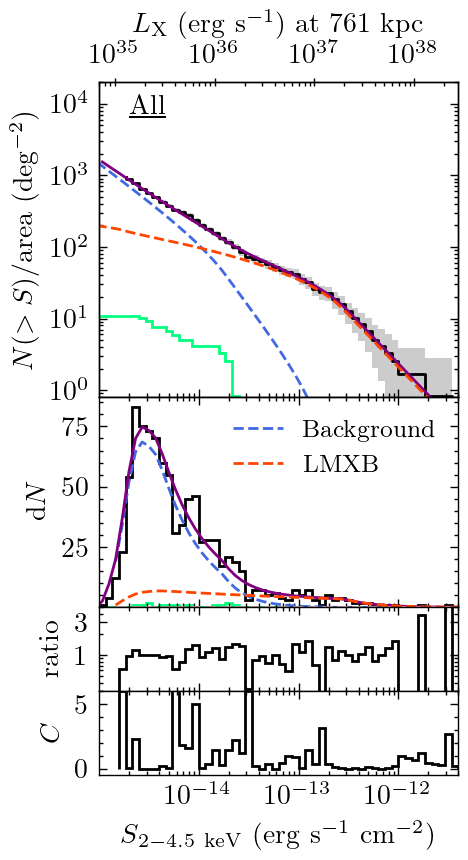

In [131]:
for i,region_label in enumerate(['Back','North','South','Center','Disk','Ring','InnerArm','InterArm','All']):
    print(i+1,region_label)
    m = i+1
    if m not in [9,]: #[1,2,3,4,5,6,7,8,9]: # [2,3]: #
        continue
# region_label_list = ['Back','North','South','Center','Arm152','Disk','Arm01','Arm12','Arm015','Arm115','Arm2','Arm23','Arm3','Arm34','Arm4','Disk_small']
# for i in [1,4,11,5,6]:
# # for i,region_label in enumerate(['Back','North','South','Center','Arm152','Disk','Arm01','Arm12','Arm015','Arm115','Arm2','Arm23','Arm3','Arm34','Arm4','Disk_small']):
#     region_label = region_label_list[i-1]
#     print(region_label)
    # if region_label=='Back' or  region_label == 'North' or  region_label == 'South':
    #     def model(x,para):
    #         return brokenpl_dN(x,para[0:4])+power_law(x,para[4:])
    # elif region_label=='Center':
    #     def model(x,para):
    #         return brokenpl_dN(x,para[0:4])+power_law(x,para[4:6])#+cutoff_brokenpl_dN(x,para[6:11])
    #     def LMXB_model(x,para):
    #         return cutoff_brokenpl_dN(x,para[6:11])
    # else:
    def model(x,para):
        return brokenpl_dN(x,para[0:4])+power_law(x,para[4:6])#+cutoff_power_law(x,para[11:16]) #+cutoff_brokenpl_dN(x,para[6:11])
    def LMXB_model(x,para):
        return cutoff_brokenpl_dN(x,para[6:11])
    def HMXB_model(x,para):
        return cutoff_power_law(x,para[11:16])
    
    exec(f"""para= tuple([i.val for i in {region_label}_source_model.pars])""")
    exec(f"""print({region_label}_source_model)""")
    if region_label == 'Center':
        exec(f"""model_dN = model(S_model,para) * dS_model * XLF_Data_band['{region_label}']['sky_area_function'] + LMXB_model(S_model,para) * dS_model * XLF_Data_band['{region_label}']['mass_function']""")
    elif region_label!='Back' and region_label!='North' and region_label!='South' and region_label!='Back':
        exec(f"""model_dN = model(S_model,para) * dS_model * XLF_Data_band['{region_label}']['sky_area_function'] + LMXB_model(S_model,para) * dS_model * XLF_Data_band['{region_label}']['mass_function'] + HMXB_model(S_model,para) * dS_model * XLF_Data_band['{region_label}']['SFR_function']""")
    else:
        exec(f"""model_dN = model(S_model,para) * dS_model * XLF_Data_band['{region_label}']['sky_area_function']""")
        
    exec(f"""cutoff_sensitivity=XLF_Data_band['{region_label}']['cutoff_sensitivity']""")
    exec(f"""XLF_Data_band_inner_dict=XLF_Data_band['{region_label}']""")
    
    rebin_indices = np.floor(np.arange(len(model_dN)) / expanded_times).astype(int)
    new_model_dN = np.bincount(rebin_indices, weights=model_dN)
    # plt.plot(S_data,new_model_dN)
    if region_label == 'Center':
        model_dN_corr = model(S_model,para) * dS_model + \
                   LMXB_model(S_model,para) * dS_model * XLF_Data_band[f'{region_label}']['mass_function']/XLF_Data_band[f'{region_label}']['sky_area_function']
    elif region_label!='Back' and region_label!='North' and region_label!='South' and region_label!='Back':
        model_dN_corr = model(S_model,para) * dS_model + \
                   LMXB_model(S_model,para) * dS_model * XLF_Data_band[f'{region_label}']['mass_function']/XLF_Data_band[f'{region_label}']['sky_area_function'] + \
                   HMXB_model(S_model,para) * dS_model * XLF_Data_band[f'{region_label}']['SFR_function']/XLF_Data_band[f'{region_label}']['sky_area_function']
    else:
        model_dN_corr = model(S_model,para) * dS_model
        
    rebin_indices = np.floor(np.arange(len(model_dN_corr)) / expanded_times).astype(int)
    new_model_dN_corr = np.bincount(rebin_indices, weights=model_dN_corr)
    new_model_N_corr = np.cumsum(new_model_dN_corr[::-1])[::-1]

    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec

    exec(f"""dN = XLF_Data_band['{region_label}']['dN']""")
    exec(f"""N_corr = XLF_Data_band['{region_label}']['N_corr']""")
    plt.figure(figsize=(16./3./2.3,9./2.),dpi=200)
    # grid = GridSpec(3, 1, height_ratios=[3, 2, 1])
    grid = GridSpec(4, 1, height_ratios=[3, 2, 0.8,0.8])
    ax1=plt.subplot(grid[0, 0])

    def Luo_AGN_N(S,K,beta1,beta2,fb):
        S_ref = 1e-14
    #     K = 453.7e14
    #     beta1 = 1.46
    #     beta2 = 2.72
    #     fb = 0.89
        c = K*(fb*1e-14/S_ref)**(beta2-beta1)*(fb*1e-14/S_ref)**(-beta2)*fb*1e-14/(beta2-1)
        N = K*(S/S_ref)**(-beta1)*(S)/(beta1-1)-K*(fb*1e-14/S_ref)**(-beta1)*(fb*1e-14)/(beta1-1)+c
        index = S>fb*1e-14
        N[index] =  K*(fb*1e-14/S_ref)**(beta2-beta1)*(S[index]/S_ref)**(-beta2)*S[index]/(beta2-1) #S>fb
        return N
    if region_label == 'Back' or  region_label == 'North' or  region_label == 'South':
        plt.plot(S_data/1.665, Luo_AGN_N(S_data,453.7e14,1.46,2.72,0.89 ),color='green',ls=':',label='Luo et al. 2016')
# #     plt.plot(S_data, Luo_AGN_N(S_data,360e14,1.46,2.72,0.537 ),color='green',ls=':',label='Luo et al. 2016')
    stellar_mass_per_deg = 0
    SFR_per_deg = 0
#     if region_label == 'Center':
#         stellar_mass_per_deg = 4.0755/0.196
#         SFR_per_deg = 0.180/0.196
    if region_label == 'Disk':
        S_ = S_model
        stellar_mass_per_deg = 2.5172/2.359
        SFR_per_deg = 0.370/2.359
    if region_label == 'Center':
        S_ = S_model
        stellar_mass_per_deg = 2.5872/0.1880
        SFR_per_deg = 0.152/0.1880
#     if region_label == 'Center' or region_label=='Disk' or region_label=='Arm2' or region_label=='Arm152':
#     if region_label == 'Center' or region_label == 'Disk':
#         stellar_mass_per_deg = XLF_Data_band[region_label]['StellarMass']/np.max(XLF_Data_band[region_label]['sky_area_function'])
# #         plt.plot(S_/3.124, LMXB_N(S_,XLF_Data_band[region_label]['StellarMass']/*4.15,1.02,2.06,144.3*0.546),color='violet',alpha=1.0,ls=':',label='LMXB\nZhang et al. 2012')
#         if stellar_mass_per_deg!=0:
    #         plt.plot(S_/3.124, LMXB_N(S_,stellar_mass_per_deg*2.6,1.31,2.57,144.3*2.16),color='cyan',ls=':',label='reference')
            # plt.plot(S_/3.124, LMXB_N(S_,stellar_mass_per_deg*4.15,1.02,2.06,144.3*0.546),color='violet',alpha=1.0,ls=':',label='LMXB\nZhang et al. 2012')
    #         plt.plot(S_/3.124, LMXB_N(S_,stellar_mass_per_deg*3.38,1.28,2.33,144.3*1.48),color='m',ls=':',label='LMXB\nLehmer et al. 2019')
    #     if SFR_per_deg!=0:
    #         plt.plot(S_/3.124, HMXB_N(S_,SFR_per_deg*2.06,1.66),color='deeppink',ls=':',alpha=0.5,label='HMXB\nMineo et al. 2012')
    #         plt.plot(S_/3.124, HMXB_N(S_,SFR_per_deg*1.96,1.65),color='deeppink',ls=':',label='HMXB\nLehmer et al. 2019')

    plt.xscale('log')
    plt.yscale('log')
    
    
#     plt.stairs(np.cumsum(dN[::-1])[::-1],data_bins,color='k',label='N')
#     plt.plot(S_data,np.cumsum(new_model_dN[::-1])[::-1],color='grey')
    # plt.stairs(dN,data_bins)
    # print(np.nanmax((np.cumsum(dN[::-1])[::-1])/N_corr))
#     plt.stairs(N_corr,data_bins,color='k',) #
    
#     plt.stairs(N_corr[data_bins[:-1]>cutoff_sensitivity],data_bins[data_bins>cutoff_sensitivity],color='k')
    plt.step(data_bins[data_bins>cutoff_sensitivity][1:],N_corr[data_bins[:-1]>cutoff_sensitivity],where='pre',color='k')
    
    plt.fill_between(data_bins[data_bins>cutoff_sensitivity][1:], \
                     (N_corr-XLF_Data_band_inner_dict['N_err_corr'])[data_bins[:-1]>cutoff_sensitivity],(N_corr+XLF_Data_band_inner_dict['N_err_corr'])[data_bins[:-1]>cutoff_sensitivity], \
                     color='k',step='pre',edgecolors=None,alpha=0.2)
    
    plt.yscale('log')
    plt.ylim(0.8,2e4)
    plt.ylabel('$N(>S)/\mathrm{area}~\mathrm{(deg^{-2})}$')
    exec(f"""plot_model(S_model,dS_model,brokenpl_dN,tuple([i.val for i in {region_label}_AGN.pars]),color='royalblue',)""")
    exec(f"""plot_model(S_model,dS_model,power_law,tuple([i.val for i in {region_label}_star.pars]),color='pink',)""")
    if Back_star.A.val == 0 and region_label=='Back':
        pass
    else:
        # plt.plot(S_data,np.cumsum(new_model_dN_corr[::-1])[::-1],color='grey')
        plt.plot(S_data,np.cumsum(new_model_dN_corr[::-1])[::-1],color='purple')
#     Center_LMXB.cutoff.max = -9
#     Center_LMXB.cutoff = -12
#     if region_label != 'Back' and  region_label != 'North' and  region_label != 'South' :
#         exec(f"""plot_model(S_model,dS_model,cutoff_brokenpl_dN,tuple([i.val for i in {region_label}_LMXB.pars]),color='orangered',)""")
#     Center_LMXB.cutoff = -11
#     if region_label != 'Back' and  region_label != 'North' and  region_label != 'South':
#         exec(f"""plot_model(S_model,dS_model,cutoff_brokenpl_dN,tuple([i.val for i in {region_label}_LMXB.pars]),color='orangered',)""")
#     Center_LMXB.cutoff = -9.34
    if region_label != 'Back' and  region_label != 'North' and  region_label != 'South':
        # exec(f"""plot_model(S_model,dS_model,cutoff_brokenpl_dN,tuple([i.val for i in {region_label}_LMXB.pars]),color='pink',)""")
        plt.plot(S_model,np.cumsum((LMXB_model(S_model,para) * dS_model * XLF_Data_band[f'{region_label}']['mass_function']/XLF_Data_band[f'{region_label}']['sky_area_function'])[::-1])[::-1],linestyle='--',color='orangered')
        # plt.plot(S_model,np.cumsum((LMXB_model(S_model,para) * dS_model * np.max(XLF_Data_band[f'{region_label}']['mass_function'])/np.max(XLF_Data_band[f'{region_label}']['sky_area_function']))[::-1])[::-1],linestyle='--',color='pink')
    if region_label != 'Back' and region_label != 'Center' and  region_label != 'North' and  region_label != 'South':
        plt.plot(S_model,np.cumsum((HMXB_model(S_model,para) * dS_model * XLF_Data_band[f'{region_label}']['SFR_function']/XLF_Data_band[f'{region_label}']['sky_area_function'])[::-1])[::-1],linestyle='--',color='springgreen')
        # exec(f"""plot_model(S_model,dS_model,cutoff_power_law,tuple([i.val for i in {region_label}_HMXB.pars]),color='springgreen',)""")
    plt.legend(fontsize=8,loc='upper right', bbox_to_anchor=(1, 0.93))
#     plt.title(region_label)
#     if region_label == 'Center':
#         CXC_dN,CXC_bins = np.histogram(M31_CXC_vulic[M31_CXC_vulic['Dist']<15]['FluxHSum'],np.logspace(-18,-10,50)) # 2.0-8.0 keV
#         print(np.sum(M31_CXC_vulic['Dist']<15))
#         plt.stairs(np.cumsum(CXC_dN[::-1])[::-1]/(np.pi*(15/60.)**2),CXC_bins/1.88,color='brown')
#         # plt.stairs(np.cumsum(dN[::-1])[::-1]/(np.pi*(15/60.)**2),bins,)
#         plt.stairs(np.cumsum(CXC_dN[::-1])[::-1]/(np.pi*(15/60.)**2),CXC_bins*1.3,)
    if region_label == 'Center':
        # thin line
        plt.stairs(XLF_Data_band['Center08']['N_corr'],data_bins,color='k',lw=0.5)
#         plt.stairs(XLF_Data_band['Center015']['N_corr'],data_bins,color='darkviolet',alpha=1.0) # thin line
    if region_label == "Back":
        label = 'Background'
    elif region_label == "Center":
        label = 'Center/Region1'
    elif region_label == "Ring":
        label = 'Region3'
    elif region_label == "InnerArm":
        label = 'Region2'
    elif region_label == "InterArm":
        label = 'Region4'
    else:
        label = region_label
    plt.text(2e-15, 9e3, fr'$\mathrm{{\underline{{{label}}}}}$', ha='left', va='center', weight='bold', fontsize=10)
#     plt.text(2e-15, 3, fr'$\mathrm{{\underline{{{label}}}}}$', ha='left', va='center', weight='bold', fontsize=10)
    if region_label == 'All':
        plt.stairs(np.cumsum((XLF_Data_band['All_HMXB']['dN'])[::-1])[::-1]/np.max(XLF_Data_band['All_HMXB']['sky_area_function']),data_bins,color='springgreen',label='HMXB')

    ax2=plt.subplot(grid[1, 0], sharex=plt.subplot(grid[0, 0]))
    exec(f"""ui.plot_model_component({i+1},{region_label}_AGN,overplot=True,color='royalblue',linestyle='--')""")
    exec(f"""ui.plot_model_component({i+1},{region_label}_star,overplot=True,color='pink',linestyle='--')""")
#     exec(f"""ui.plot_model_component({i+1},{region_label}_star,overplot=True,color='pink',linestyle='--')""")
    if region_label != 'Back' and  region_label != 'North' and  region_label != 'South':
        exec(f"""ui.plot_model_component({i+1},{region_label}_LMXB,overplot=True,color='orangered',linestyle='--')""")
    if  Disk_HMXB.A.val !=0:
        if region_label != 'Back' and region_label != 'Center' and  region_label != 'North' and  region_label != 'South':
            exec(f"""ui.plot_model_component({i+1},{region_label}_HMXB,overplot=True,color='springgreen',linestyle='--')""")
    plt.ylabel(r'd$N$')
    print(region_label)
    if Back_star.A.val == 0:
        if region_label == 'Back' or region_label == 'North' or  region_label == 'South':
            plt.plot([],[],linestyle='--',color='royalblue',label='Background')
            plt.legend(['Background',],fontsize=9)
            pass
        elif region_label == 'Center':
            plt.plot([],[],linestyle='--',color='royalblue',label='Background')
            plt.plot([],[],linestyle='--',color='orangered',label='LMXB')
            plt.legend(['Background','LMXB'],fontsize=9)
        elif Disk_HMXB.A.val == 0:
            plt.plot([],[],linestyle='--',color='royalblue',label='Background')
            plt.plot([],[],linestyle='--',color='orangered',label='LMXB')
            plt.legend(['Background','LMXB'],fontsize=9)
        else:
            plt.plot([],[],linestyle='--',color='royalblue',label='Background')
            plt.plot([],[],linestyle='--',color='orangered',label='LMXB')
            plt.plot([],[],linestyle='--',color='springgreen',label='HMXB')
            plt.legend(['Background','LMXB','HMXB'],fontsize=9)
        # ax2.legend(['Background','LMXB','HMXB'],fontsize=9)
        # plt.legend(['Background','LMXB','HMXB'],fontsize=9)
        # exec(f"""ui.plot_model_component({i+1},{region_label}_AGN,overplot=True,color='royalblue',linestyle='--')""")
        # ax2.legend(['Background','LMXB','HMXB'],fontsize=9)
            
    plt.legend(['Background','LMXB'],fontsize=9)
    
    if region_label == 'North':
        plt.stairs(XLF_Data_band['North_star']['dN'],data_bins,color='pink',label='fg star')
    if region_label == 'South':
        plt.stairs(XLF_Data_band['South_star']['dN'],data_bins,color='pink',label='fg star')
    if region_label == 'All':
        plt.stairs(XLF_Data_band['All_HMXB']['dN'],data_bins,color='springgreen',label='HMXB')


        
    dS = data_bins[1:]-data_bins[:-1]
    plt.stairs(dN,data_bins,color='k')
    if  region_label =='Back' and Back_star.A.val ==0:
        pass
    else:
        # plt.plot(S_data,new_model_dN,color='grey')
        plt.plot(S_data,new_model_dN,color='purple')
#     plt.yscale('log')
    plt.ylim(.1,)

#     ax3=plt.subplot(grid[2, 0], sharex=plt.subplot(grid[0, 0]))
#     C = 2*(new_model_dN-dN+(dN+1e-25)*(np.log(dN+1e-25)-np.log(new_model_dN+1e-25)))
#     plt.stairs(C[data_bins[:-1]>cutoff_sensitivity],data_bins[data_bins>cutoff_sensitivity],color='k')
#     # plt.stairs((dN/new_model_dN),data_bins)
#     plt.ylim([-0.5,6])
#     plt.ylabel(r'$C$')
#     plt.xscale('log')
#     plt.xticks([1e-14,1e-13,1e-12],)
#     plt.xlim([1e-15,4e-12])
#     plt.xlabel('$S\mathrm{_{2-4.5~keV}~(erg~s^{-1}~cm^{-2})}$')

#     ax1_top = ax1.twiny()
#     ax1_top.set_xlim(ax1.get_xlim())  # Make sure the new x-axis range matches the original

#     ax1_top.set_xticks(ax3.get_xticks())
#     ax1_top.set_xbound(ax3.get_xbound())
# #     ax1_top.set_xticklabels(second_xtick_labels)
#     ax1_top.set_xlim([flux2luminosity(ax3.get_xbound()[0]),flux2luminosity(ax3.get_xbound()[1])])
#     ax1_top.set_xscale('log')
#     ax1_top.set_xticks([1e35,1e36,1e37,1e38])
#     ax1_top.tick_params(axis='x', direction='inout', labeltop=True)
    
#     plt.xlabel(r'$L\mathrm{_X~(erg~s^{-1})}$ at 761 kpc')
    
    ax3=plt.subplot(grid[2, 0], sharex=plt.subplot(grid[0, 0]))
    ratio = (dN)/new_model_dN
    plt.stairs(ratio[data_bins[:-1]>cutoff_sensitivity],data_bins[data_bins>cutoff_sensitivity],color='k')
    plt.ylim(0.3,5)
    plt.ylabel(r'ratio')
    plt.yscale('log')
    plt.xscale('log')
    plt.yticks([1,3,],[1,3,])
    
    ax4=plt.subplot(grid[3, 0], sharex=plt.subplot(grid[0, 0]))
    C = 2*(new_model_dN-dN+(dN+1e-25)*(np.log(dN+1e-25)-np.log(new_model_dN+1e-25)))
    # New_residual = (dN-new_model_dN)/new_model_dN
    # ratio = (dN)/new_model_dN
    plt.stairs(C[data_bins[:-1]>cutoff_sensitivity],data_bins[data_bins>cutoff_sensitivity],color='k')
    # plt.stairs(ratio[data_bins[:-1]>cutoff_sensitivity],data_bins[data_bins>cutoff_sensitivity],color='k')
    # plt.stairs((dN/new_model_dN),data_bins)
    plt.ylim([-0.5,6])
    # plt.ylim([-6,6])
    # plt.ylim(0.3,8)
    plt.ylabel(r'$C$')
    # plt.ylabel(r'$(m-N)/m$')
    # plt.ylabel(r'ratio')
    # plt.yscale('log')
    plt.xscale('log')
    plt.xticks([1e-14,1e-13,1e-12],)
    plt.xlim([1e-15,4e-12])
    plt.xlabel('$S\mathrm{_{2-4.5~keV}~(erg~s^{-1}~cm^{-2})}$')

    ax1_top = ax1.twiny()
    ax1_top.set_xlim(ax1.get_xlim())  # Make sure the new x-axis range matches the original

    ax1_top.set_xticks(ax4.get_xticks())
    ax1_top.set_xbound(ax4.get_xbound())
#     ax1_top.set_xticklabels(second_xtick_labels)
    ax1_top.set_xlim([flux2luminosity(ax4.get_xbound()[0]),flux2luminosity(ax4.get_xbound()[1])])
    ax1_top.set_xscale('log')
    ax1_top.set_xticks([1e35,1e36,1e37,1e38])
    ax1_top.tick_params(axis='x', direction='inout', labeltop=True)
    
    plt.xlabel(r'$L\mathrm{_X~(erg~s^{-1})}$ at 761 kpc')

#     plt.xlim(cutoff_sensitivity,)
    plt.subplots_adjust(hspace=0)
#     plt.savefig(f'figure/XLF_fitting_{region_label}_RegionV3.2_v6.0_LMXB.png')
#     plt.savefig(f'figure/XLF_fitting_{region_label}_RegionV3.2_v6.0_LMXB.pdf')
#     plt.savefig(f'figure/XLF_fitting_{region_label}_RegionV3.2_SrcV2_v6.0_LMXB.png')
#     plt.savefig(f'figure/XLF_fitting_{region_label}_RegionV3.2_SrcV2_v6.0_LMXB.pdf')
    # plt.savefig(f'figure/XLF_fitting_{region_label}_RegionV3.2_SrcV2_Scut2e-13_v6.0_LMXB.png')
    # plt.savefig(f'figure/XLF_fitting_{region_label}_RegionV3.2_SrcV2_Scut2e-13_v6.0_LMXB.pdf')
    plt.savefig(f'figure/XLF_fitting_{region_label}_RegionV3.2_v8.0_LMXB_4panel.pdf')
#     plt.savefig(f'figure/XLF_fitting_{region_label}_v5.1_LMXB.png')
#     plt.savefig(f'figure/XLF_fitting_{region_label}_v5.1_LMXB.pdf')
#     plt.savefig(f'figure/XLF_fitting_{region_label}_v5.2_FixLMXB_1.6HMXB.png') # fix LMXB as in center
#     plt.savefig(f'figure/XLF_fitting_{region_label}_v5.2_FixLMXB_1.6HMXB.pdf')
#     plt.savefig(f'figure/XLF_fitting_{region_label}_v5.3_armLMXB_1.6HMXB.png') # fix LMXB as in arm
#     plt.savefig(f'figure/XLF_fitting_{region_label}_v5.3_armLMXB_1.6HMXB.pdf') 
#     plt.savefig(f'figure/XLF_fitting_{region_label}_v5.4_LMXB_1.6HMXB.png') # free LMXB in disk
#     plt.savefig(f'figure/XLF_fitting_{region_label}_v5.4_LMXB_1.6HMXB.pdf')
#     plt.savefig(f'figure/XLF_fitting_{region_label}_v5.5_LMXB_1.6HMXB.png') # free LMXB in arm, and include arm in the arm.
#     plt.savefig(f'figure/XLF_fitting_{region_label}_v5.5_LMXB_1.6HMXB.pdf')
    plt.show()

The bright source in the interArm is rare and very bright!

## fit and plot `All' region with different HMXBS

In [132]:
np.linspace(0.3,21,16)[:8]**1.5/2.5

array([ 0.06572671,  0.87101155,  2.14112554,  3.74226421,  5.61622461,
        7.72785093, 10.05288983, 12.57329192])

Datasets              = 1, 9
Method                = neldermead
Statistic             = cstat
Initial fit statistic = 87.0779
Final fit statistic   = 84.4728 at function evaluation 1107
Data points           = 198
Degrees of freedom    = 190
Probability [Q-value] = 1
Reduced statistic     = 0.444594
Change in statistic   = 2.60506
   Back_AGN.K     129.262     
   Back_AGN.beta1   2.00066     
   Back_AGN.beta2   2.93017     
   Back_AGN.fb    1.92266     
   All_LMXB.K     5.86039     
   All_LMXB.beta1   1.23302     
   All_LMXB.beta2   2.4533      
   All_LMXB.fb    30.7124     
(((usermodel.All_AGN + usermodel.All_star) + usermodel.All_LMXB) + usermodel.All_HMXB)
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   All_AGN.K    linked      129.262         expr: Back_AGN.K           
   All_AGN.beta1 linked      2.00066     expr: Back_AGN.beta1           
   All_AGN.beta2 linked      2.93

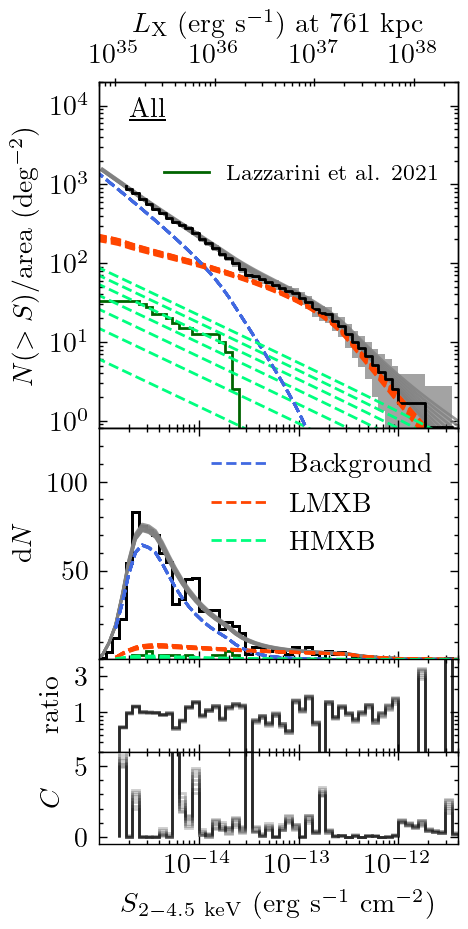

In [295]:
region_label = 'All'
i = 8
plt.figure(figsize=(16./3./2.3,9./2.*1.1),dpi=200)
# grid = GridSpec(3, 1, height_ratios=[3, 2, 1])
grid = GridSpec(4, 1, height_ratios=[3, 2, 0.8,0.8])

All_HMXB.A.set(val=0,min=0,max=100)
All_HMXB.alpha.set(val=1.6,min=0,max=3)
All_HMXB.alpha.freeze()
ui.freeze(Back_AGN)
ui.freeze(All_star)
ui.thaw(All_HMXB.A)

# for i,region_label in enumerate(['Back','North','South','Center','Disk','Ring','InnerArm','InterArm',]):
for iteration,A in enumerate(np.linspace(0.3,21,16)[:8]**1.5/2.5): #enumerate(np.logspace(-1,1.0,5)):
# for iteration,A in enumerate(np.linspace(0.1,15,10)):
    All_HMXB.A  = A
    All_HMXB.A.freeze()
    Back_AGN.thaw()
    ui.fit(1,9)
    

# region_label_list = ['Back','North','South','Center','Arm152','Disk','Arm01','Arm12','Arm015','Arm115','Arm2','Arm23','Arm3','Arm34','Arm4','Disk_small']
# for i in [1,4,11,5,6]:
# # for i,region_label in enumerate(['Back','North','South','Center','Arm152','Disk','Arm01','Arm12','Arm015','Arm115','Arm2','Arm23','Arm3','Arm34','Arm4','Disk_small']):
#     region_label = region_label_list[i-1]
#     print(region_label)
    if region_label=='Back' or  region_label == 'North' or  region_label == 'South':
        def model(x,para):
            return brokenpl_dN(x,para[0:4])+power_law(x,para[4:])
    elif region_label=='Center':
        def model(x,para):
            return brokenpl_dN(x,para[0:4])+power_law(x,para[4:6])#+cutoff_brokenpl_dN(x,para[6:11])
        def LMXB_model(x,para):
            return cutoff_brokenpl_dN(x,para[6:11])
    else:
        def model(x,para):
            return brokenpl_dN(x,para[0:4])+power_law(x,para[4:6])+cutoff_power_law(x,para[11:16]) #+cutoff_brokenpl_dN(x,para[6:11])
        def LMXB_model(x,para):
            return cutoff_brokenpl_dN(x,para[6:11])
    
    exec(f"""para= tuple([i.val for i in {region_label}_source_model.pars])""")
    exec(f"""print({region_label}_source_model)""")
    if region_label=='Center':
        exec(f"""model_dN = model(S_model,para) * dS_model * XLF_Data_band['{region_label}']['sky_area_function'] + LMXB_model(S_model,para) * dS_model * XLF_Data_band['{region_label}']['mass_function']""")
    elif region_label!='Back' and region_label!='North' and region_label!='South':
        exec(f"""model_dN = model(S_model,para) * dS_model * XLF_Data_band['{region_label}']['sky_area_function'] + LMXB_model(S_model,para) * dS_model * XLF_Data_band['{region_label}']['mass_function'] + HMXB_model(S_model,para) * dS_model * XLF_Data_band['{region_label}']['SFR_function']""")
    else:
        exec(f"""model_dN = model(S_model,para) * dS_model * XLF_Data_band['{region_label}']['sky_area_function']""")
        
    exec(f"""cutoff_sensitivity=XLF_Data_band['{region_label}']['cutoff_sensitivity']""")
    exec(f"""XLF_Data_band_inner_dict=XLF_Data_band['{region_label}']""")
    
    rebin_indices = np.floor(np.arange(len(model_dN)) / expanded_times).astype(int)
    new_model_dN = np.bincount(rebin_indices, weights=model_dN)
    # plt.plot(S_data,new_model_dN)
    if region_label=='Center':
        model_dN_corr = model(S_model,para) * dS_model + LMXB_model(S_model,para) * dS_model * XLF_Data_band[f'{region_label}']['mass_function']/XLF_Data_band[f'{region_label}']['sky_area_function']
    elif region_label!='Back' and region_label!='North' and region_label!='South' and region_label!='Back':
        model_dN_corr = model(S_model,para) * dS_model + LMXB_model(S_model,para) * dS_model * XLF_Data_band[f'{region_label}']['mass_function']/XLF_Data_band[f'{region_label}']['sky_area_function']+ HMXB_model(S_model,para) * dS_model * XLF_Data_band[f'{region_label}']['SFR_function']/XLF_Data_band[f'{region_label}']['sky_area_function']
    else:
        model_dN_corr = model(S_model,para) * dS_model
        
    rebin_indices = np.floor(np.arange(len(model_dN_corr)) / expanded_times).astype(int)
    new_model_dN_corr = np.bincount(rebin_indices, weights=model_dN_corr)
    new_model_N_corr = np.cumsum(new_model_dN_corr[::-1])[::-1]

    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec

    exec(f"""dN = XLF_Data_band['{region_label}']['dN']""")
    exec(f"""N_corr = XLF_Data_band['{region_label}']['N_corr']""")
    
    if iteration == 0:
        ax1=plt.subplot(grid[0, 0])
    else:    
        plt.gcf().sca(ax1)

    if iteration == 0:
        if region_label == 'All':
            plt.plot([],lw=0)
            plt.plot([],lw=0)
            plt.stairs(3*np.cumsum((XLF_Data_band['All_HMXB']['dN'])[::-1])[::-1]/np.max(XLF_Data_band['All_HMXB']['sky_area_function']),data_bins,color='darkgreen',label='Lazzarini et al. 2021')
            plt.legend(['','','Lazzarini et al. 2021',],fontsize=8)

    
    def Luo_AGN_N(S,K,beta1,beta2,fb):
        S_ref = 1e-14
    #     K = 453.7e14
    #     beta1 = 1.46
    #     beta2 = 2.72
    #     fb = 0.89
        c = K*(fb*1e-14/S_ref)**(beta2-beta1)*(fb*1e-14/S_ref)**(-beta2)*fb*1e-14/(beta2-1)
        N = K*(S/S_ref)**(-beta1)*(S)/(beta1-1)-K*(fb*1e-14/S_ref)**(-beta1)*(fb*1e-14)/(beta1-1)+c
        index = S>fb*1e-14
        N[index] =  K*(fb*1e-14/S_ref)**(beta2-beta1)*(S[index]/S_ref)**(-beta2)*S[index]/(beta2-1) #S>fb
        return N
    if region_label == 'Back' or  region_label == 'North' or  region_label == 'South':
        plt.plot(S_data/1.665, Luo_AGN_N(S_data,453.7e14,1.46,2.72,0.89 ),color='green',ls=':',label='Luo et al. 2016')
# #     plt.plot(S_data, Luo_AGN_N(S_data,360e14,1.46,2.72,0.537 ),color='green',ls=':',label='Luo et al. 2016')
    stellar_mass_per_deg = 0
    SFR_per_deg = 0
#     if region_label == 'Center':
#         stellar_mass_per_deg = 4.0755/0.196
#         SFR_per_deg = 0.180/0.196
    if region_label == 'Disk':
        S_ = S_model
        stellar_mass_per_deg = 2.5172/2.359
        SFR_per_deg = 0.370/2.359
    if region_label == 'Center':
        S_ = S_model
        stellar_mass_per_deg = 2.5872/0.1880
        SFR_per_deg = 0.152/0.1880
#     if region_label == 'Center' or region_label=='Disk' or region_label=='Arm2' or region_label=='Arm152':
    if region_label == 'Center' or region_label == 'Disk':
        stellar_mass_per_deg = XLF_Data_band[region_label]['StellarMass']/np.max(XLF_Data_band[region_label]['sky_area_function'])
#         plt.plot(S_/3.124, LMXB_N(S_,XLF_Data_band[region_label]['StellarMass']/*4.15,1.02,2.06,144.3*0.546),color='violet',alpha=1.0,ls=':',label='LMXB\nZhang et al. 2012')
        if stellar_mass_per_deg!=0:
    #         plt.plot(S_/3.124, LMXB_N(S_,stellar_mass_per_deg*2.6,1.31,2.57,144.3*2.16),color='cyan',ls=':',label='reference')
            plt.plot(S_/3.124, LMXB_N(S_,stellar_mass_per_deg*4.15,1.02,2.06,144.3*0.546),color='violet',alpha=1.0,ls=':',label='LMXB\nZhang et al. 2012')
    #         plt.plot(S_/3.124, LMXB_N(S_,stellar_mass_per_deg*3.38,1.28,2.33,144.3*1.48),color='m',ls=':',label='LMXB\nLehmer et al. 2019')
    #     if SFR_per_deg!=0:
    #         plt.plot(S_/3.124, HMXB_N(S_,SFR_per_deg*2.06,1.66),color='deeppink',ls=':',alpha=0.5,label='HMXB\nMineo et al. 2012')
    #         plt.plot(S_/3.124, HMXB_N(S_,SFR_per_deg*1.96,1.65),color='deeppink',ls=':',label='HMXB\nLehmer et al. 2019')

    plt.xscale('log')
    plt.yscale('log')
    
    
#     plt.stairs(np.cumsum(dN[::-1])[::-1],data_bins,color='k',label='N')
#     plt.plot(S_data,np.cumsum(new_model_dN[::-1])[::-1],color='grey')
    # plt.stairs(dN,data_bins)
    # print(np.nanmax((np.cumsum(dN[::-1])[::-1])/N_corr))
#     plt.stairs(N_corr,data_bins,color='k',) #
    
#     plt.stairs(N_corr[data_bins[:-1]>cutoff_sensitivity],data_bins[data_bins>cutoff_sensitivity],color='k')
    
    plt.yscale('log')
    plt.ylim(0.8,2e4)
    plt.ylabel('$N(>S)/\mathrm{area}~\mathrm{(deg^{-2})}$')
    exec(f"""plot_model(S_model,dS_model,brokenpl_dN,tuple([i.val for i in {region_label}_AGN.pars]),color='royalblue',)""")
    exec(f"""plot_model(S_model,dS_model,power_law,tuple([i.val for i in {region_label}_star.pars]),color='pink',)""")
    if Back_star.A.val == 0 and region_label=='Back':
        pass
    else:
        plt.plot(S_data,np.cumsum(new_model_dN_corr[::-1])[::-1],color='grey',alpha=0.8)
    if iteration==0 or iteration==7:
        plt.step(data_bins[data_bins>cutoff_sensitivity][1:],N_corr[data_bins[:-1]>cutoff_sensitivity],where='pre',color='k')
        plt.fill_between(data_bins[data_bins>cutoff_sensitivity][1:], \
                         (N_corr-XLF_Data_band_inner_dict['N_err_corr'])[data_bins[:-1]>cutoff_sensitivity],(N_corr+XLF_Data_band_inner_dict['N_err_corr'])[data_bins[:-1]>cutoff_sensitivity], \
                         color='k',step='pre',edgecolors=None,alpha=0.2)
#     Center_LMXB.cutoff.max = -9
#     Center_LMXB.cutoff = -12
#     if region_label != 'Back' and  region_label != 'North' and  region_label != 'South' :
#         exec(f"""plot_model(S_model,dS_model,cutoff_brokenpl_dN,tuple([i.val for i in {region_label}_LMXB.pars]),color='orangered',)""")
#     Center_LMXB.cutoff = -11
#     if region_label != 'Back' and  region_label != 'North' and  region_label != 'South':
#         exec(f"""plot_model(S_model,dS_model,cutoff_brokenpl_dN,tuple([i.val for i in {region_label}_LMXB.pars]),color='orangered',)""")
#     Center_LMXB.cutoff = -9.34
    if region_label != 'Back' and  region_label != 'North' and  region_label != 'South':
        # exec(f"""plot_model(S_model,dS_model,cutoff_brokenpl_dN,tuple([i.val for i in {region_label}_LMXB.pars]),color='pink',)""")
        plt.plot(S_model,np.cumsum((LMXB_model(S_model,para) * dS_model * XLF_Data_band[f'{region_label}']['mass_function']/XLF_Data_band[f'{region_label}']['sky_area_function'])[::-1])[::-1],linestyle='--',color='orangered')
        # plt.plot(S_model,np.cumsum((LMXB_model(S_model,para) * dS_model * np.max(XLF_Data_band[f'{region_label}']['mass_function'])/np.max(XLF_Data_band[f'{region_label}']['sky_area_function']))[::-1])[::-1],linestyle='--',color='pink')
    if region_label != 'Back' and region_label != 'Center' and  region_label != 'North' and  region_label != 'South':
        exec(f"""plot_model(S_model,dS_model,cutoff_power_law,tuple([i.val for i in {region_label}_HMXB.pars]),color='springgreen',)""")
    # plt.legend(fontsize=8)
#     plt.title(region_label)
#     if region_label == 'Center':
#         CXC_dN,CXC_bins = np.histogram(M31_CXC_vulic[M31_CXC_vulic['Dist']<15]['FluxHSum'],np.logspace(-18,-10,50)) # 2.0-8.0 keV
#         print(np.sum(M31_CXC_vulic['Dist']<15))
#         plt.stairs(np.cumsum(CXC_dN[::-1])[::-1]/(np.pi*(15/60.)**2),CXC_bins/1.88,color='brown')
#         # plt.stairs(np.cumsum(dN[::-1])[::-1]/(np.pi*(15/60.)**2),bins,)
#         plt.stairs(np.cumsum(CXC_dN[::-1])[::-1]/(np.pi*(15/60.)**2),CXC_bins*1.3,)
    if region_label == 'Center':
        # thin line
        plt.stairs(XLF_Data_band['Center08']['N_corr'],data_bins,color='k',lw=0.5)
#         plt.stairs(XLF_Data_band['Center015']['N_corr'],data_bins,color='darkviolet',alpha=1.0) # thin line
    if region_label == "Back":
        label = 'Background'
    elif region_label == "Center":
        label = 'Region1'
    elif region_label == "Ring":
        label = 'Region3'
    elif region_label == "InnerArm":
        label = 'Region2'
    elif region_label == "InterArm":
        label = 'Region4'
    else:
        label = region_label
    if iteration == 0:
        plt.text(2e-15, 9e3, fr'$\mathrm{{\underline{{{label}}}}}$', ha='left', va='center', weight='bold', fontsize=10)
#     plt.text(2e-15, 3, fr'$\mathrm{{\underline{{{label}}}}}$', ha='left', va='center', weight='bold', fontsize=10)

    L = np.logspace(35.3,38.4,60)
    N = 105*((L/10**36)**(-0.26)-270**(-0.26))
    band_ratio = 3.1
    # line2, = plt.plot(luminosity2flux(L)/band_ratio,N,'-',alpha=0.99,color='tomato',label='LMXB of MW')

    if iteration == 0:
        ax2=plt.subplot(grid[1, 0], sharex=plt.subplot(grid[0, 0]))
    else:    
        plt.gcf().sca(ax2)
        
    exec(f"""ui.plot_model_component({i+1},{region_label}_AGN,overplot=True,color='royalblue',linestyle='--')""")
#     exec(f"""ui.plot_model_component({i+1},{region_label}_star,overplot=True,color='pink',linestyle='--')""")
#     exec(f"""ui.plot_model_component({i+1},{region_label}_star,overplot=True,color='pink',linestyle='--')""")
    if region_label != 'Back' and  region_label != 'North' and  region_label != 'South':
        exec(f"""ui.plot_model_component({i+1},{region_label}_LMXB,overplot=True,color='orangered',linestyle='--')""")
    if  All_HMXB.A.val !=0:
        if region_label != 'Back' and region_label != 'Center' and  region_label != 'North' and  region_label != 'South':
            exec(f"""ui.plot_model_component({i+1},{region_label}_HMXB,overplot=True,color='springgreen',linestyle='--')""")
    plt.ylabel(r'd$N$')
    print(region_label)
    # if Back_star.A.val == 0:
    #     if region_label == 'Back' or region_label == 'North' or  region_label == 'South':
    #         plt.legend(['Back',],fontsize=9)
    #         pass
    #     elif region_label == 'Center':
    #         plt.legend(['Background','LMXB'],fontsize=9)
    #     elif Disk_HMXB.A.val == 0:
    #         plt.legend(['Background','LMXB'],fontsize=9)
    #     else:
    print(All_HMXB.A.val,iteration)
    plt.gcf().sca(ax2)
    
    if iteration == 0:
        plt.plot([],[],linestyle='--',color='royalblue',label='Background')
        plt.plot([],[],linestyle='--',color='orangered',label='LMXB')
        plt.plot([],[],linestyle='--',color='springgreen',label='HMXB')
        # ax2.legend(['Background','LMXB','HMXB'],fontsize=9)
        # plt.legend(['Background','LMXB','HMXB'],fontsize=9)
        # exec(f"""ui.plot_model_component({i+1},{region_label}_AGN,overplot=True,color='royalblue',linestyle='--')""")
        ax2.legend(['Background','LMXB','HMXB'],fontsize=8)
        
        # plt.show()
        # break
    dS = data_bins[1:]-data_bins[:-1]
    plt.stairs(dN,data_bins,color='k', alpha=1)
    if  region_label =='Back' and Back_star.A.val ==0:
        pass
    else:
        plt.plot(S_data,new_model_dN,color='grey',alpha=0.8)
#     plt.yscale('log')
    plt.ylim(.1,130)

    if iteration == 0:
        if region_label == 'All':
            plt.stairs(3*((XLF_Data_band['All_HMXB']['dN'])[::-1])[::-1]/np.max(XLF_Data_band['All_HMXB']['sky_area_function']),data_bins,color='darkgreen')

    
    # if iteration == 0:
    #     ax3=plt.subplot(grid[2, 0], sharex=plt.subplot(grid[0, 0]))
    # else:    
    #     plt.gcf().sca(ax3)
    # C = 2*(new_model_dN-dN+(dN+1e-25)*(np.log(dN+1e-25)-np.log(new_model_dN+1e-25)))
    # plt.stairs(C[data_bins[:-1]>cutoff_sensitivity],data_bins[data_bins>cutoff_sensitivity],color='k', alpha=0.3)
    # # plt.stairs((dN/new_model_dN),data_bins)
    # plt.ylim([-0.5,6])
    # plt.ylabel(r'$C$')
    # plt.xscale('log')
    # plt.xticks([1e-14,1e-13,1e-12],)
    # plt.xlim([1e-15,4e-12])
    # plt.xlabel('$S\mathrm{_{2-4.5~keV}~(erg~s^{-1}~cm^{-2})}$')

    # if iteration==0:
    #     ax1_top = ax1.twiny()
    #     ax1_top.set_xlim(ax1.get_xlim())  # Make sure the new x-axis range matches the original
    
    #     ax1_top.set_xticks(ax3.get_xticks())
    #     ax1_top.set_xbound(ax3.get_xbound())
    # #     ax1_top.set_xticklabels(second_xtick_labels)
    #     ax1_top.set_xlim([flux2luminosity(ax3.get_xbound()[0]),flux2luminosity(ax3.get_xbound()[1])])
    #     ax1_top.set_xscale('log')
    #     ax1_top.set_xticks([1e35,1e36,1e37,1e38])
    #     ax1_top.tick_params(axis='x', direction='inout', labeltop=True)
        
    #     plt.xlabel(r'$L\mathrm{_X~(erg~s^{-1})}$ at 761 kpc')

    
    # ax3=plt.subplot(grid[2, 0], sharex=plt.subplot(grid[0, 0]))
    if iteration == 0:
        ax3=plt.subplot(grid[2, 0], sharex=plt.subplot(grid[0, 0]))
    else:    
        plt.gcf().sca(ax3)
    ratio = (dN)/new_model_dN
    plt.stairs(ratio[data_bins[:-1]>cutoff_sensitivity],data_bins[data_bins>cutoff_sensitivity],color='k', alpha=0.2)
    plt.ylim(0.3,5)
    plt.ylabel(r'ratio')
    plt.yscale('log')
    plt.xscale('log')
    plt.yticks([1,3,],[1,3,])
    
    # ax4=plt.subplot(grid[3, 0], sharex=plt.subplot(grid[0, 0]))
    if iteration == 0:
        ax4=plt.subplot(grid[3, 0], sharex=plt.subplot(grid[0, 0]))
    else:    
        plt.gcf().sca(ax4)
    C = 2*(new_model_dN-dN+(dN+1e-25)*(np.log(dN+1e-25)-np.log(new_model_dN+1e-25)))
    # New_residual = (dN-new_model_dN)/new_model_dN
    # ratio = (dN)/new_model_dN
    plt.stairs(C[data_bins[:-1]>cutoff_sensitivity],data_bins[data_bins>cutoff_sensitivity],color='k', alpha=0.2)
    # plt.stairs(ratio[data_bins[:-1]>cutoff_sensitivity],data_bins[data_bins>cutoff_sensitivity],color='k')
    # plt.stairs((dN/new_model_dN),data_bins)
    plt.ylim([-0.5,6])
    # plt.ylim([-6,6])
    # plt.ylim(0.3,8)
    plt.ylabel(r'$C$')
    # plt.ylabel(r'$(m-N)/m$')
    # plt.ylabel(r'ratio')
    # plt.yscale('log')
    plt.xscale('log')
    plt.xticks([1e-14,1e-13,1e-12],)
    plt.xlim([1e-15,4e-12])
    plt.xlabel('$S\mathrm{_{2-4.5~keV}~(erg~s^{-1}~cm^{-2})}$')

    if iteration==0:
        ax1_top = ax1.twiny()
        ax1_top.set_xlim(ax1.get_xlim())  # Make sure the new x-axis range matches the original
    
        ax1_top.set_xticks(ax4.get_xticks())
        ax1_top.set_xbound(ax4.get_xbound())
    #     ax1_top.set_xticklabels(second_xtick_labels)
        ax1_top.set_xlim([flux2luminosity(ax4.get_xbound()[0]),flux2luminosity(ax4.get_xbound()[1])])
        ax1_top.set_xscale('log')
        ax1_top.set_xticks([1e35,1e36,1e37,1e38])
        ax1_top.tick_params(axis='x', direction='inout', labeltop=True)
        
        plt.xlabel(r'$L\mathrm{_X~(erg~s^{-1})}$ at 761 kpc')

    
#     plt.xlim(cutoff_sensitivity,)
    plt.subplots_adjust(hspace=0)
#     plt.savefig(f'figure/XLF_fitting_{region_label}_RegionV3.2_v6.0_LMXB.png')
#     plt.savefig(f'figure/XLF_fitting_{region_label}_RegionV3.2_v6.0_LMXB.pdf')
#     plt.savefig(f'figure/XLF_fitting_{region_label}_RegionV3.2_SrcV2_v6.0_LMXB.png')
#     plt.savefig(f'figure/XLF_fitting_{region_label}_RegionV3.2_SrcV2_v6.0_LMXB.pdf')
    # plt.savefig(f'figure/XLF_fitting_{region_label}_RegionV3.2_SrcV2_Scut2e-13_v6.0_LMXB.png')
    # plt.savefig(f'figure/XLF_fitting_{region_label}_RegionV3.2_SrcV2_Scut2e-13_v6.0_LMXB.pdf')
#     plt.savefig(f'figure/XLF_fitting_{region_label}_RegionV3.2_v6.0_LMXB.pdf')
#     plt.savefig(f'figure/XLF_fitting_{region_label}_v5.1_LMXB.png')
#     plt.savefig(f'figure/XLF_fitting_{region_label}_v5.1_LMXB.pdf')
#     plt.savefig(f'figure/XLF_fitting_{region_label}_v5.2_FixLMXB_1.6HMXB.png') # fix LMXB as in center
#     plt.savefig(f'figure/XLF_fitting_{region_label}_v5.2_FixLMXB_1.6HMXB.pdf')
#     plt.savefig(f'figure/XLF_fitting_{region_label}_v5.3_armLMXB_1.6HMXB.png') # fix LMXB as in arm
#     plt.savefig(f'figure/XLF_fitting_{region_label}_v5.3_armLMXB_1.6HMXB.pdf') 
#     plt.savefig(f'figure/XLF_fitting_{region_label}_v5.4_LMXB_1.6HMXB.png') # free LMXB in disk
#     plt.savefig(f'figure/XLF_fitting_{region_label}_v5.4_LMXB_1.6HMXB.pdf')
#     plt.savefig(f'figure/XLF_fitting_{region_label}_v5.5_LMXB_1.6HMXB.png') # free LMXB in arm, and include arm in the arm.
plt.savefig(f'figure/XLF_fitting_{region_label}_v8_LMXB_multiple_1.6HMXB_4panel.pdf')
plt.show()

In [296]:
# Lx = 3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*np.sum((S_model*(HMXB_model(S_model,para) * dS_model * np.max(XLF_Data_band[f'{region_label}']['SFR_function'])))[(L>1e36) & (L<10**40.8)])



# flux2luminosity(np.sum((XLF_Data_band['All_HMXB']['dN_InSmallBin'] * dS_model * S_model )[(L>1e36) & (L<10**40.8)])) / np.max(XLF_Data_band[f'{region_label}']['SFR_function'])

# plt.stairs(3*((XLF_Data_band['All_HMXB']['dN'])[::-1])[::-1]/np.max(XLF_Data_band['All_HMXB']['sky_area_function']),data_bins,color='darkgreen')


### collect fitting result of different HMXBs normalizations

In [297]:
# C = 2*(new_model_dN-dN+(dN+1e-25)*(np.log(dN+1e-25)-np.log(new_model_dN+1e-25)))
# print(np.sum(C))    
def calculate_c_statistic(observed_counts, model_counts):
    """
    Calculate the C-statistic for a given set of observed and model counts.
    
    Parameters:
    observed_counts (array-like): Observed counts (D_i)
    model_counts (array-like): Model counts (M_i)
    
    Returns:
    float: C-statistic value
    """
    # Convert to numpy arrays for element-wise operations
    observed_counts = np.array(observed_counts)
    model_counts = np.array(model_counts)
    
    # Calculate the C-statistic
    with np.errstate(divide='ignore', invalid='ignore'):
        term1 = model_counts
        term2 = observed_counts
        term3 = observed_counts * np.log(observed_counts / model_counts)
        
        # Handle the case where observed_counts is zero
        term3 = np.nan_to_num(term3)
        
    c_statistic = 2 * np.sum(term1 - term2 + term3)
    
    return c_statistic
# print(calculate_c_statistic(dN,new_model_dN))


In [298]:

def possion(mu,k):
    return (np.exp(-mu) * mu**k) / np.math.factorial(k)
# dN
k=0
mu=0
mu = dN
np.sum([np.sum(2*(possion(mu,k)*(mu-k+k*(np.log(k+1e-25)-np.log(mu+1e-25))))) for k in range(100)])

def calculate_C(N, s):
    return 2*np.sum((s-N+(N+1e-20)*np.log((N+1e-20)/(s+1e-20))))

def calculate_expected_C_element(mu):
    if mu<=5:
        Ce = np.sum([(2*(possion(mu,k)*(mu-k+k*(np.log(k+1e-25)-np.log(mu+1e-25))))) for k in range(150) ]) 
    elif mu>5 and mu<=10:
        Ce = 1.00624 + 0.604/(mu)**1.68
    elif mu>10:
        Ce = 1 + 0.1649/mu + 0.226/mu**2
    return Ce
    
def calculate_variance_S_element(mu):
    if mu<=5:
        Sv = np.sum([(4*possion(mu,k)*(np.square(mu-k+k*(np.log(k+1e-25)-np.log(mu+1e-25))))) for k in range(150) ]) 
    else: 
        Sv = 0
    return Sv
def calculate_variance_C_element(mu):
    if mu<=5:
        Ce =  calculate_variance_S_element(mu) - np.square(calculate_expected_C_element(mu))
    elif mu<=10:
        Ce = 2.05159 + 0.331*(mu)**(1.343 - np.log(mu))
    elif mu>10:
        Ce = 12/mu**3+ 0.79/mu**2+ 0.6747/mu + 2
    
    return Ce
def calculate_expected_C(mu_array):
    return np.sum([calculate_expected_C_element(mu) for mu in mu_array])
def calculate_variance_C(mu_array):
    return np.sum([calculate_variance_C_element(mu) for mu in mu_array])

# print(calculate_expected_C(dN))
# print(np.sqrt(calculate_variance_C(dN)))

# print(calculate_expected_C(new_model_dN))
# print(np.sqrt(calculate_variance_C(new_model_dN)))

In [299]:
# All_HMXB.A  = 0
# All_LMXB.thaw()
# All_LMXB.cutoff.freeze()
# ui.fit(9)
# All_LMXB.beta1.max=10
# All_LMXB.beta1.min=-5 #0.001
# All_LMXB.fb.freeze()
# # ui.covar(9,All_LMXB)
# # ui.covar(5,)


In [300]:
luminosity2flux(1e41)/3.1

4.655411104365766e-10

In [139]:
# ui.fit(9)

# ui.plot_fit(9)
# plt.xscale('log')
# plt.yscale('log')
ui.thaw(Back_AGN )
All_HMXB.A  = 0
ui.fit(1)
ui.fit(1,9)
ui.fit(9)

Dataset               = 1
Method                = neldermead
Statistic             = cstat
Initial fit statistic = 28.542
Final fit statistic   = 24.1283 at function evaluation 381
Data points           = 95
Degrees of freedom    = 91
Probability [Q-value] = 1
Reduced statistic     = 0.265147
Change in statistic   = 4.41371
   Back_AGN.K     129.3       
   Back_AGN.beta1   2.22414     
   Back_AGN.beta2   2.8428      
   Back_AGN.fb    2.20762     
Datasets              = 1, 9
Method                = neldermead
Statistic             = cstat
Initial fit statistic = 123.406
Final fit statistic   = 84.4764 at function evaluation 1011
Data points           = 198
Degrees of freedom    = 190
Probability [Q-value] = 1
Reduced statistic     = 0.444613
Change in statistic   = 38.9293
   Back_AGN.K     129.262     
   Back_AGN.beta1   2.00068     
   Back_AGN.beta2   2.93016     
   Back_AGN.fb    1.92267     
   All_LMXB.K     5.86521     
   All_LMXB.beta1   1.23322     
   All_LMXB.beta2   2

Dataset               = 1
Method                = neldermead
Statistic             = cstat
Initial fit statistic = 28.3956
Final fit statistic   = 24.1283 at function evaluation 387
Data points           = 95
Degrees of freedom    = 91
Probability [Q-value] = 1
Reduced statistic     = 0.265147
Change in statistic   = 4.26725
   Back_AGN.K     129.3       
   Back_AGN.beta1   2.22414     
   Back_AGN.beta2   2.8428      
   Back_AGN.fb    2.20762     
Datasets              = 1, 9
Method                = neldermead
Statistic             = cstat
Initial fit statistic = 124.996
Final fit statistic   = 84.4817 at function evaluation 912
Data points           = 198
Degrees of freedom    = 191
Probability [Q-value] = 1
Reduced statistic     = 0.442313
Change in statistic   = 40.5138
   Back_AGN.K     129.3       
   Back_AGN.beta1   2.00112     
   Back_AGN.beta2   2.9308      
   Back_AGN.fb    1.92318     
   All_LMXB.K     5.84479     
   All_LMXB.beta1   1.22991     
   All_LMXB.beta2   2

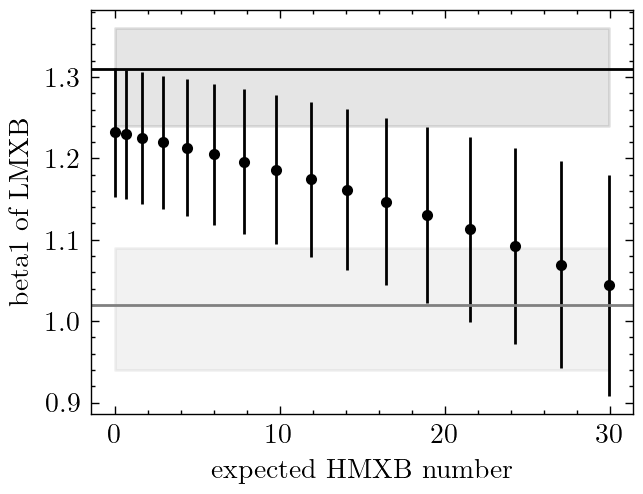

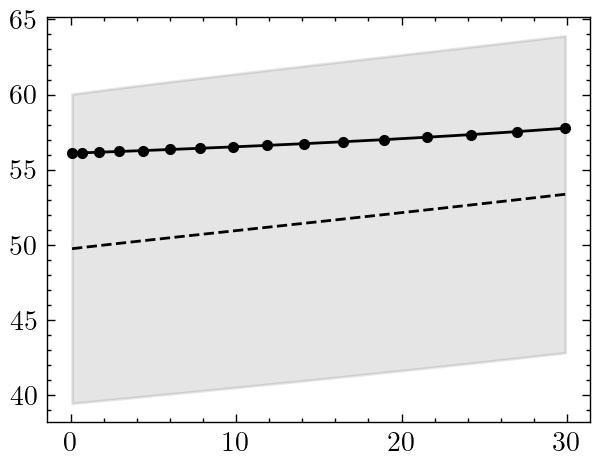

In [302]:
region_label = 'All'
index=(S_data>XLF_Data_band[f'{region_label}']['cutoff_sensitivity']) #& (S_data<luminosity2flux(1e41)/3.1)
original_data = Data1D(f'{region_label}', S_data[index], XLF_Data_band[f'{region_label}']['dN'][index])
ui.set_data(9,original_data)

#+cutoff_brokenpl_dN(x,para[6:11])
def LMXB_model(x,para):
    return cutoff_brokenpl_dN(x,para[6:11])
def model(x,para):
    return brokenpl_dN(x,para[0:4])+power_law(x,para[4:6])+cutoff_power_law(x,para[11:16]) #+cutoff_brokenpl_dN(x,para[6:11])
def LMXB_model(x,para):
    return cutoff_brokenpl_dN(x,para[6:11])# for iteration,A in enumerate(np.logspace(-1.0,1.3,6)):
expected_HMXB_number_list = []
expected_LMXB_number_list = []
expected_HMXB_number_list_0580 = []
expected_LMXB_number_list_0580 = []
detected_HMXB_number_list = []
detected_LMXB_number_list = []
All_LMXB_beta1_list = []
All_LMXB_beta2_list = []
All_LMXB_K_list = []
All_LMXB_beta1_max_list = []
All_LMXB_beta1_min_list = []
All_LMXB_beta2_max_list = []
All_LMXB_beta2_min_list = []
All_LMXB_Lx_list = []
All_HMXB_Lx_list = []
All_AGN_Lx_list = []
All_rstat_list = []
All_stat_list = []
C_list = []
Ce_list = []
Cv_list = []
C19_list = []
Ce19_list = []
Cv19_list = []
All_HMXB.A  = 0
Back_AGN.K.thaw()
Back_AGN.beta1.thaw()
Back_AGN.beta2.thaw()
Back_AGN.fb.thaw()
ui.fit(1)
ui.fit(1,9)
Back_AGN.freeze()
All_HMXB.alpha = 1.6
All_HMXB.alpha.freeze()
for iteration,A in enumerate(np.linspace(0.3,21,16)**1.5/2.5): # enumerate(np.linspace(0.1,40,20)):
    All_HMXB.A  = A
    All_HMXB.A.freeze()
    All_LMXB.thaw()
    All_LMXB.cutoff = 0
    All_LMXB.cutoff.freeze()
    # Back_AGN.freeze()
    # ui.fit(9)
    # Back_AGN.K.thaw()
    # Back_AGN.beta1.thaw()
    # Back_AGN.beta2.thaw()
    # Back_AGN.fb.thaw()
    ui.fit(9)
   
    # dN = XLF_Data_band[f'{region_label}']['dN']
    exec(f"""para= tuple([i.val for i in {region_label}_source_model.pars])""")
#     exec(f"""print({region_label}_source_model)""")
    # model_dN = model(S_model,para) * dS_model * XLF_Data_band[f'{region_label}']['sky_area_function']+LMXB_model(S_model,para) * dS_model * XLF_Data_band[f'{region_label}']['mass_function']+HMXB_model(S_model,para) * dS_model * XLF_Data_band[f'{region_label}']['SFR_function']   
    # rebin_indices = np.floor(np.arange(len(model_dN)) / expanded_times).astype(int)
    # new_model_dN = np.bincount(rebin_indices, weights=model_dN)
    C = calculate_c_statistic(ui.get_data_plot(9).y,ui.get_model_plot(9).y)
    C_list.append(C)
    C = calculate_c_statistic(np.hstack([ui.get_data_plot(1).y,ui.get_data_plot(9).y]),np.hstack([ui.get_model_plot(1).y,ui.get_model_plot(9).y]))
    C19_list.append(C)
    
    Ce = calculate_expected_C(ui.get_model_plot(9).y)
    Cv = calculate_variance_C(ui.get_model_plot(9).y)
    Ce_list.append(Ce)
    Cv_list.append(Cv)
    Ce = calculate_expected_C(np.hstack([ui.get_model_plot(1).y,ui.get_model_plot(9).y]))
    Cv = calculate_variance_C(np.hstack([ui.get_model_plot(1).y,ui.get_model_plot(9).y]))
    Ce19_list.append(Ce)
    Cv19_list.append(Cv)
    detected_LMXB_number = np.sum((LMXB_model(S_model,para) * dS_model * XLF_Data_band[f'{region_label}']['mass_function']))
    expected_LMXB_number = np.cumsum((LMXB_model(S_model,para) * dS_model * np.max(XLF_Data_band[f'{region_label}']['mass_function']))[::-1])[::-1][(S_model>luminosity2flux(1e36)) & (S_model<luminosity2flux(1e41)) ][0]
    expected_LMXB_number_0580 = np.cumsum((LMXB_model(S_model,para) * dS_model * np.max(XLF_Data_band[f'{region_label}']['mass_function']))[::-1])[::-1][(S_model>luminosity2flux(1e36)/3.1) & (S_model<luminosity2flux(1e41)/3.1)][0]
    print('detected LMXB number',detected_LMXB_number)
    print('expected LMXB number',expected_LMXB_number)
    detected_HMXB_number = np.sum((HMXB_model(S_model,para) * dS_model * XLF_Data_band[f'{region_label}']['SFR_function']))
    expected_HMXB_number = np.cumsum((HMXB_model(S_model,para) * dS_model * np.max(XLF_Data_band[f'{region_label}']['SFR_function']))[::-1])[::-1][(S_model>luminosity2flux(1e36)) & (S_model<luminosity2flux(1e41)) ][0]
    expected_HMXB_number_0580 = np.cumsum((HMXB_model(S_model,para) * dS_model * np.max(XLF_Data_band[f'{region_label}']['SFR_function']))[::-1])[::-1][(S_model>luminosity2flux(1e36)/3.1) & (S_model<luminosity2flux(1e41)/3.1)][0]
    print('detected HMXB number',detected_HMXB_number)
    print('expected HMXB number',expected_HMXB_number) 
    print('stat:',ui.get_stat_info()[8].rstat)
    All_rstat_list.append(ui.get_stat_info()[8].rstat)
    All_stat_list.append(ui.get_stat_info()[8].statval)
    L = (4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*S_model
    Lx = (4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*np.cumsum(S_model*(LMXB_model(S_model,para) * dS_model * np.max(XLF_Data_band[f'{region_label}']['mass_function']))[::-1])[::-1]
    print('integrated LMXB luminosity (L2.0-4.5)>1e35',Lx[L>1e35][0])
    Lx = (4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*np.cumsum(S_model*(HMXB_model(S_model,para) * dS_model * np.max(XLF_Data_band[f'{region_label}']['SFR_function']))[::-1])[::-1]
    print('integrated HMXB luminosity (L2.0-4.5)>1e35',Lx[L>1e35][0])
    
    L = 3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*S_model
    # Lx = 3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*np.cumsum(S_model*(LMXB_model(S_model,para) * dS_model * np.max(XLF_Data_band[f'{region_label}']['mass_function']))[::-1])[::-1]
    # print('integrated converted LMXB luminosity (L0.5-8)>1e36',Lx[(L>1e36)][0])
    # All_LMXB_Lx_list.append(Lx[L>1e36][0])
    Lx = 3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*np.sum((S_model*(LMXB_model(S_model,para) * dS_model * np.max(XLF_Data_band[f'{region_label}']['mass_function'])))[(L>1e36) & (L<10**40.8)])
    print('LMXB',Lx,)
    
    All_LMXB_Lx_list.append(Lx)
    Lx = flux2luminosity(3.1*np.sum((S_model*(LMXB_model(S_model,para) * dS_model * np.max(XLF_Data_band[f'{region_label}']['mass_function'])))[(S_model>luminosity2flux(1e36)/3.1) & (S_model<luminosity2flux(1e41)/3.1)]))
    print('LMXB',Lx,)
    # Lx = 3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*np.cumsum(S_model*(HMXB_model(S_model,para) * dS_model * np.max(XLF_Data_band[f'{region_label}']['SFR_function']))[::-1])[::-1]
    # print('integrated converted HMXB luminosity (L0.5-8)>1e36',Lx[L>1e36][0])
    Lx = 3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*np.sum((S_model*(HMXB_model(S_model,para) * dS_model * np.max(XLF_Data_band[f'{region_label}']['SFR_function'])))[(L>1e36) & (L<10**40.8)])
    # All_HMXB_Lx_list.append(Lx[L>1e36][0])
    All_HMXB_Lx_list.append(Lx)
    print('=='*20)

    # plt.plot(expected_HMXB_number,All_LMXB.beta1.val,'kx')
    # plt.plot(expected_HMXB_number,All_LMXB.beta2.val,'kx',alpha=0.4)
    expected_HMXB_number_list.append(expected_HMXB_number)
    expected_LMXB_number_list.append(expected_LMXB_number)
    expected_HMXB_number_list_0580.append(expected_HMXB_number_0580)
    expected_LMXB_number_list_0580.append(expected_LMXB_number_0580)
    detected_HMXB_number_list.append(detected_HMXB_number)
    detected_LMXB_number_list.append(detected_LMXB_number)
    All_LMXB_beta1_list.append(All_LMXB.beta1.val)
    All_LMXB_beta2_list.append(All_LMXB.beta2.val)
    All_LMXB_K_list.append(All_LMXB.K.val)
    All_LMXB.fb.freeze()
    ui.covar(9,All_LMXB.beta1)
    if ui.get_covar_results().parmaxes[0] is None:
        All_LMXB_beta1_max_list.append(np.nan)
    else:
        All_LMXB_beta1_max_list.append(ui.get_covar_results().parmaxes[0])
    if ui.get_covar_results().parmins[0] is None:
        All_LMXB_beta1_min_list.append(np.nan)
    else:
        All_LMXB_beta1_min_list.append(ui.get_covar_results().parmins[0])
    ui.covar(9,All_LMXB.beta2)
    if ui.get_covar_results().parmaxes[0] is None:
        All_LMXB_beta2_max_list.append(np.nan)
    else:
        All_LMXB_beta2_max_list.append(ui.get_covar_results().parmaxes[0])
    if ui.get_covar_results().parmins[0] is None:
        All_LMXB_beta2_min_list.append(np.nan)
    else:
        All_LMXB_beta2_min_list.append(ui.get_covar_results().parmins[0])


All_LMXB_beta1_max_list = np.array(All_LMXB_beta1_max_list)
All_LMXB_beta1_min_list = np.array(All_LMXB_beta1_min_list)
All_LMXB_beta1_list = np.array(All_LMXB_beta1_list)
All_LMXB_beta2_max_list = np.array(All_LMXB_beta2_max_list)
All_LMXB_beta2_min_list = np.array(All_LMXB_beta2_min_list)

# plt.plot(expected_HMXB_number_list,All_LMXB_beta1_list,'.-')
# plt.plot(expected_HMXB_number_list,All_LMXB_beta2_list,'.-')
plt.errorbar(x=expected_HMXB_number_list,y=All_LMXB_beta1_list,yerr=All_LMXB_beta1_max_list,fmt='.',color='k')
# plt.errorbar(x=expected_HMXB_number_list,y=All_LMXB_beta2_list,yerr=Disk_LMXB_beta2_max_list,fmt='.',color='tomato')
plt.xlabel('expected HMXB number')
plt.ylabel('beta1 of LMXB')   

plt.axhline(1.31,color='k')
plt.fill_between(expected_HMXB_number_list,np.ones(len(expected_HMXB_number_list))*1.31-0.07,np.ones(len(expected_HMXB_number_list))*1.31+0.05,alpha=0.1,color='k')

# plt.axhline(2.57,color='tomato')
# plt.fill_between(expected_HMXB_number_list,np.ones(len(expected_HMXB_number_list))*2.57-0.28,np.ones(len(expected_HMXB_number_list))*2.57+0.54,alpha=0.1,color='tomato')


plt.axhline(1.02,color='grey')
plt.fill_between(expected_HMXB_number_list,np.ones(len(expected_HMXB_number_list))*1.02-0.08,np.ones(len(expected_HMXB_number_list))*1.02+0.07,alpha=0.1,color='grey')

# plt.axhline(2.06,color='pink')
# plt.fill_between(expected_HMXB_number_list,np.ones(len(expected_HMXB_number_list))*2.06-0.05,np.ones(len(expected_HMXB_number_list))*2.06+0.06,alpha=0.1,color='pink')

plt.show()


plt.plot(expected_HMXB_number_list,np.array(C_list),'k.-')
plt.plot(expected_HMXB_number_list,np.array(Ce_list)-4,'k--')
plt.fill_between(expected_HMXB_number_list,np.array(Ce_list)+np.sqrt(Cv_list)-4,np.array(Ce_list)-np.sqrt(Cv_list)-4,alpha=0.1,color='k')
plt.show()


In [303]:
# # Ce = calculate_expected_C(np.hstack([ui.get_model_plot(1).y,ui.get_model_plot(9).y]))
# # Cv = calculate_variance_C(np.hstack([ui.get_model_plot(1).y,ui.get_model_plot(9).y]))
# # calculate_expected_C(np.hstack([ui.get_model_plot(1).y,ui.get_model_plot(9).y]))
# for i in range(1,10):
#     print(i,'ce',calculate_expected_C(ui.get_model_plot(i).y))
#     print(i, 'cv',calculate_variance_C(ui.get_model_plot(i).y))
#     print(i,'cv-sqrt(cv)',calculate_expected_C(ui.get_model_plot(i).y)-np.sqrt(calculate_variance_C(ui.get_model_plot(i).y)))
#     print(i, 'cv+sqrt(cv)',calculate_expected_C(ui.get_model_plot(i).y)+np.sqrt(calculate_variance_C(ui.get_model_plot(i).y)))


In [304]:
# np.log10(All_HMXB_Lx_list/np.max(XLF_Data_band['All']['SFR_function']))

In [144]:
def LMXB_model(x,para):
    return cutoff_brokenpl_dN(x,para[6:11])# for iteration,A in enumerate(np.logspace(-1.0,1.3,6)):


len(XLF_Data_band['All']['N'])
S_data.shape

print('sources > 1e-14',np.max((XLF_Data_band['All']['N'])[S_data>1e-14])) # total number

para= tuple([i.val for i in All_source_model.pars])

print('LMXB > 1e-14',np.sum((LMXB_model(S_model,para) * dS_model * XLF_Data_band[f'{region_label}']['mass_function'])[S_model>1e-14]))

print('sources > 1e-13',np.max((XLF_Data_band['All']['N'])[S_data>1e-13])) # total number

para= tuple([i.val for i in All_source_model.pars])

print('LMXB > 1e-13',np.sum((LMXB_model(S_model,para) * dS_model * XLF_Data_band[f'{region_label}']['mass_function'])[S_model>1e-13]))

# S_data.shap


sources > 1e-14 240
LMXB > 1e-14 81.52735678383381
sources > 1e-13 43
LMXB > 1e-13 32.162902830956156


In [145]:
# L = 3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*S_model


# Lx = 3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*np.cumsum(S_model*(LMXB_model(S_model,para) * dS_model * np.max(XLF_Data_band[f'{region_label}']['mass_function']))[::-1])[::-1]
# print('integrated converted LMXB luminosity (L0.5-8)>1e36',Lx[(L>1e36)][0])
# print('integrated converted LMXB luminosity (L0.5-8)>1e36',Lx[(S_model>luminosity2flux(1e36)/3.1)][0])


# Lx = 3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*cumsum_reverse(S_model*(LMXB_model(S_model,para) * dS_model * np.max(XLF_Data_band[f'{region_label}']['mass_function'])))
# print('integrated converted LMXB luminosity (L0.5-8)>1e36',Lx[(L>1e36)][0])
# print('integrated converted LMXB luminosity (L0.5-8)>1e36',Lx[(S_model>luminosity2flux(1e36)/3.1)][0])


# Lx = 3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*np.sum((S_model*(LMXB_model(S_model,para) * dS_model * np.max(XLF_Data_band[f'{region_label}']['mass_function'])))[ (S_model>luminosity2flux(1e36)/3.1) ])
# print(Lx)
# Lx = 3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*np.sum((S_model*(LMXB_model(S_model,para) * dS_model * np.max(XLF_Data_band[f'{region_label}']['mass_function'])))[ (S_model>luminosity2flux(1e35)/3.1) ])
# print(Lx)



(1e+37, 4.773014039655149e+44)

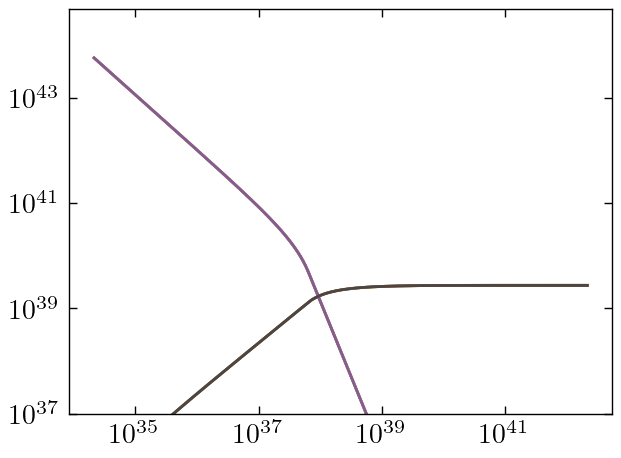

In [146]:
dNdS = LMXB_model(S_model,para)
L = 3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*S_model
dNdS[L>10**42]=0
Lx = 3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*np.cumsum(S_model*(dNdS * dS_model * np.max(XLF_Data_band[f'{region_label}']['mass_function']))[::-1])[::-1]
plt.plot(L,Lx)
Lx = 3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*np.cumsum(S_model*(dNdS * dS_model * np.max(XLF_Data_band[f'{region_label}']['mass_function'])))
plt.plot(L,Lx)

dNdS = LMXB_model(S_model,para)
dNdS[L>10**41]=0
Lx = 3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*np.cumsum(S_model*(dNdS * dS_model * np.max(XLF_Data_band[f'{region_label}']['mass_function']))[::-1])[::-1]
plt.plot(L,Lx)
Lx = 3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*np.cumsum(S_model*(dNdS * dS_model * np.max(XLF_Data_band[f'{region_label}']['mass_function'])))
plt.plot(L,Lx)

dNdS = LMXB_model(S_model,para)
dNdS[L>10**40]=0
Lx = 3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*np.cumsum(S_model*(dNdS * dS_model * np.max(XLF_Data_band[f'{region_label}']['mass_function']))[::-1])[::-1]
plt.plot(L,Lx)
Lx = 3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*np.cumsum(S_model*(dNdS * dS_model * np.max(XLF_Data_band[f'{region_label}']['mass_function'])))
plt.plot(L,Lx)

plt.xscale('log')
plt.yscale('log')
# plt.ylim(1e37,1e42)

plt.ylim(1e37,)

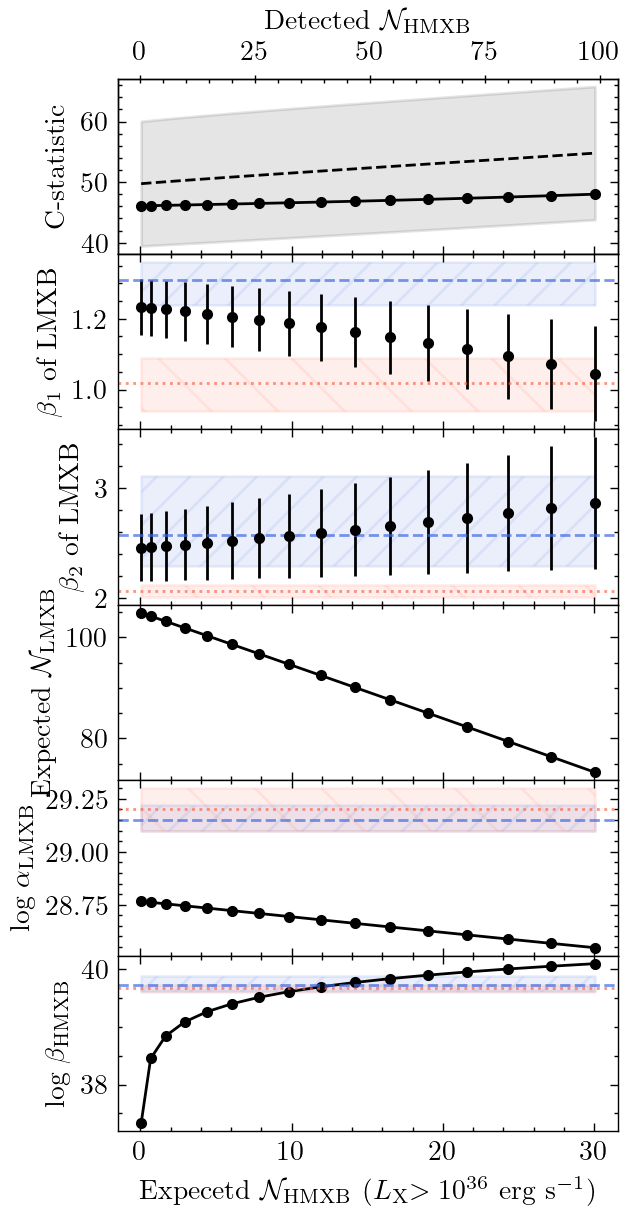

In [147]:
fig, (ax1, ax2, ax3,ax4,ax5,ax6) = plt.subplots(6, 1, sharex=True, gridspec_kw={'hspace': 0})

fig.set_figheight(3.35/4*1.5*5)
fig.set_figwidth(3.35)
# ax1.plot(expected_HMXB_number_list,All_stat_list,'k.-')
ax1.set_ylabel('stat of fitting') 
ax1.plot(expected_HMXB_number_list,np.array(C_list)-10,'k.-')
ax1.plot(expected_HMXB_number_list,np.array(Ce_list)-4,'k--')
ax1.fill_between(expected_HMXB_number_list,np.array(Ce_list)+np.sqrt(Cv_list)-4,np.array(Ce_list)-np.sqrt(Cv_list)-4,alpha=0.1,color='k')

# ax1.plot(expected_HMXB_number_list,C19_list,'k.-')
# ax1.plot(expected_HMXB_number_list,np.array(Ce19_list)-8,'k--')
# ax1.fill_between(expected_HMXB_number_list,np.array(Ce19_list)+np.sqrt(Cv19_list)-8,np.array(Ce19_list)-np.sqrt(Cv19_list)-8,alpha=0.1,color='k')

# ax1.plot(expected_HMXB_number_list,np.array(Ce19_list),'k--')
# ax1.fill_between(expected_HMXB_number_list,np.array(Ce19_list)+np.sqrt(Cv19_list),np.array(Ce19_list)-np.sqrt(Cv19_list),alpha=0.1,color='k')

ax1.set_ylabel('C-statistic')

# A =0.1
# index = (cstat_collection_df['mode'] == 'True') & (cstat_collection_df['A'] == A)
# ax1.plot(expected_HMXB_number_list[0],np.mean(cstat_collection_df[index]['statval']),'rx')
# index = (cstat_collection_df['mode'] == 'Fake') & (cstat_collection_df['A'] == A)
# print(iteration,np.sum(index))
# # np.mean(cstat_collection_df[index]['statval']),np.std(cstat_collection_df[index]['statval'])
# # np.percentile((cstat_collection_df[index]['statval']),16),np.percentile((cstat_collection_df[index]['statval']),84)
# ax1.plot(expected_HMXB_number_list[0],np.mean(cstat_collection_df[index]['statval']),'kx')
# ax1.plot([expected_HMXB_number_list[0],expected_HMXB_number_list[0]],[np.percentile((cstat_collection_df[index]['statval']),16),np.percentile((cstat_collection_df[index]['statval']),84)],'k-',alpha=0.3)


ax2.errorbar(x=expected_HMXB_number_list,y=All_LMXB_beta1_list,yerr=All_LMXB_beta1_max_list,fmt='.',color='k')
ax2.axhline(1.31,linestyle='--',color='royalblue',alpha=0.7)
ax2.fill_between(expected_HMXB_number_list,np.ones(len(detected_HMXB_number_list))*1.31-0.07,np.ones(len(detected_HMXB_number_list))*1.31+0.05,alpha=0.1,hatch='//',color='royalblue')
ax2.axhline(1.02,linestyle=':',color='tomato',alpha=0.7)
ax2.fill_between(expected_HMXB_number_list,np.ones(len(detected_HMXB_number_list))*1.02-0.08,np.ones(len(detected_HMXB_number_list))*1.02+0.07,alpha=0.1,hatch='\\',color='tomato')
ax2.set_ylabel(r'$\beta_1$ of LMXB') 
ax3.errorbar(x=expected_HMXB_number_list,y=All_LMXB_beta2_list,yerr=All_LMXB_beta2_max_list,fmt='.',color='k')
ax3.set_ylabel(r'$\beta_2$ of LMXB') 
ax3.axhline(2.57,color='royalblue',linestyle='--',alpha=0.7)
ax3.fill_between(expected_HMXB_number_list,np.ones(len(detected_HMXB_number_list))*2.57-0.28,np.ones(len(detected_HMXB_number_list))*2.57+0.54,alpha=0.1,hatch='//',color='royalblue')
ax3.axhline(2.06,color='tomato',linestyle=':',alpha=0.7)
ax3.fill_between(expected_HMXB_number_list,np.ones(len(detected_HMXB_number_list))*2.06-0.05,np.ones(len(detected_HMXB_number_list))*2.06+0.06,alpha=0.1,hatch='\\',color='tomato')
# plt.errorbar(x=expected_HMXB_number_list,y=All_LMXB_beta2_list,yerr=Disk_LMXB_beta2_max_list,fmt='.',color='tomato')
ax4.plot(expected_HMXB_number_list,expected_LMXB_number_list,'k.-')
ax4.set_ylabel('Expected $\mathcal{N}_\mathrm{LMXB}$')
ax5.plot(expected_HMXB_number_list,np.log10(All_LMXB_Lx_list/np.max(XLF_Data_band['All']['mass_function'])/1e10),'k.-')

# ax5.plot(expected_HMXB_number_list,np.log10(TotalM31lumilosity/np.max(XLF_Data_band['All']['mass_function'])/1e10),'y.-')


ax5.axhline(29.15,color='royalblue',linestyle='--',alpha=0.7)
ax5.fill_between(expected_HMXB_number_list,np.ones(len(detected_HMXB_number_list))*29.15-0.05,np.ones(len(detected_HMXB_number_list))*29.15+0.07,alpha=0.1,hatch='//',color='royalblue')
ax5.axhline(29.2,color='tomato',linestyle=':',alpha=0.7)
ax5.fill_between(expected_HMXB_number_list,np.ones(len(detected_HMXB_number_list))*29.2-0.1,np.ones(len(detected_HMXB_number_list))*29.2+0.1,alpha=0.1,hatch='\\',color='tomato')
ax5.set_ylabel(r'log $\alpha_\mathrm{LMXB}$')

ax6.plot(expected_HMXB_number_list,np.log10(All_HMXB_Lx_list/np.max(XLF_Data_band['All']['SFR_function'])),'k.-')
# ax6.plot(expected_HMXB_number_list,np.log10(All_HMXB_Lx_list2),'y.-')
ax6.axhline(39.73,color='royalblue',linestyle='--',alpha=0.7)
ax6.fill_between(expected_HMXB_number_list,np.ones(len(detected_HMXB_number_list))*39.73-0.1,np.ones(len(detected_HMXB_number_list))*39.73+0.15,alpha=0.1,hatch='//',color='royalblue')
ax6.axhline(39.67,color='tomato',linestyle=':',alpha=0.7)
ax6.fill_between(expected_HMXB_number_list,np.ones(len(detected_HMXB_number_list))*39.67-0.06,np.ones(len(detected_HMXB_number_list))*39.67+0.06,alpha=0.1,hatch='\\',color='tomato')
ax6.set_ylabel(r'log $\beta_\mathrm{HMXB}$')
plt.xlabel('Expecetd $\mathcal{N}_\mathrm{HMXB}$ ($L_\mathrm{X}\mathrm{>10^{36}~erg~s^{-1}}$)')


ax1_top = ax1.twiny()
# ax1_top.spines['top'].set_position(('outward', 40))  # Move the top spine outward
# ax1_top.spines['top'].set_visible(True)  # Make sure the top spine is visible

# Sync the x-axis limits with the main x-axis
# ax1_top.set_xlim(ax1.get_xlim())

# Optionally, customize ticks and labels on the secondary x-axis
ax1_top.set_xlabel('Detected $\mathcal{N}_\mathrm{HMXB}$')
# ax1_top.set_xticks([1, 2, 3, 4, 5])  # Example custom ticks
# ax1_top.set_xticklabels(['A', 'B', 'C', 'D', 'E']) 
# ax1_top = ax1.twiny()
# ax1_top.set_xlim(ax1.get_xlim())  # Make sure the new x-axis range matches the original

# ax1_top.set_xticks(ax1.get_xticks()*(np.array(detected_HMXB_number_list)/np.array(expected_HMXB_number_list))[0])
# ax1_top.set_xbound(ax1.get_xbound()[0]*(np.array(detected_HMXB_number_list)/np.array(expected_HMXB_number_list))[0],ax1.get_xbound()[1]*(np.array(detected_HMXB_number_list)/np.array(expected_HMXB_number_list))[0])
# #     ax1_top.set_xticklabels(second_xtick_labels)
ax1_top.set_xlim([ax1.get_xlim()[0]*(np.array(detected_HMXB_number_list)/np.array(expected_HMXB_number_list))[0],ax1.get_xlim()[1]*(np.array(detected_HMXB_number_list)/np.array(expected_HMXB_number_list))[0]])
# ax1_top.set_xscale('log')
# ax1_top.set_xticks([1e35,1e36,1e37,1e38])
ax1_top.tick_params(axis='x', direction='inout', labeltop=True)

# plt.xlabel(r'$L\mathrm{_X~(erg~s^{-1})}$ at 761 kpc')


plt.tight_layout()
# plt.savefig('figure/HMXB_expectation_ML6_v2.pdf')
plt.show()
# plt.plot(detected_HMXB_number_list,np.array(expected_HMXB_number_list)/(np.array(expected_HMXB_number_list)+np.array(expected_LMXB_number_list)),'k.-')
# plt.errorbar(x=expected_HMXB_number_list,y=All_LMXB_beta2_list,yerr=Disk_LMXB_beta2_max_list,fmt='.',color='tomato')
# plt.xlabel('detected HMXB number')
# plt.ylabel('stat of fitting')   




In [305]:
np.array(detected_HMXB_number_list)/np.array(expected_HMXB_number_list)

array([3.30168561, 3.30168561, 3.30168561, 3.30168561, 3.30168561,
       3.30168561, 3.30168561, 3.30168561, 3.30168561, 3.30168561,
       3.30168561, 3.30168561, 3.30168561, 3.30168561, 3.30168561,
       3.30168561])

Datasets              = 1, 9
Method                = neldermead
Statistic             = cstat
Initial fit statistic = 97.8492
Final fit statistic   = 84.4817 at function evaluation 830
Data points           = 198
Degrees of freedom    = 191
Probability [Q-value] = 1
Reduced statistic     = 0.442313
Change in statistic   = 13.3674
   Back_AGN.K     129.3       
   Back_AGN.beta1   2.00112     
   Back_AGN.beta2   2.9308      
   Back_AGN.fb    1.92319     
   All_LMXB.K     5.8447      
   All_LMXB.beta1   1.2299      
   All_LMXB.beta2   2.43868     
Dataset               = 9
Method                = neldermead
Statistic             = cstat
Initial fit statistic = 56.1009
Final fit statistic   = 56.0965 at function evaluation 446
Data points           = 103
Degrees of freedom    = 99
Probability [Q-value] = 0.999842
Reduced statistic     = 0.566631
Change in statistic   = 0.00443404
   All_LMXB.K     5.84712     
   All_LMXB.beta1   1.23195     
   All_LMXB.beta2   2.45551     
   All_L

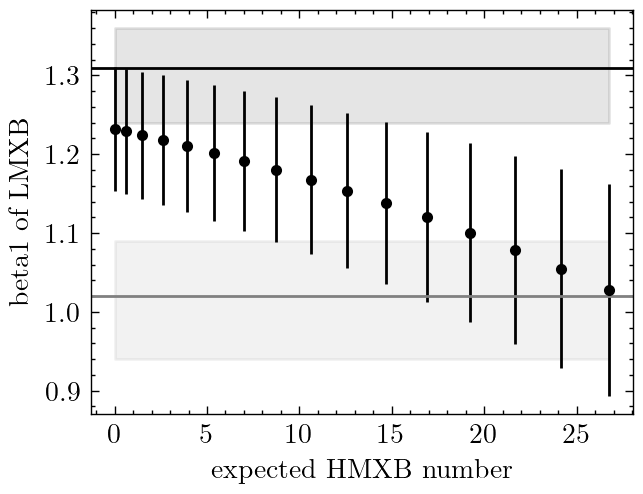

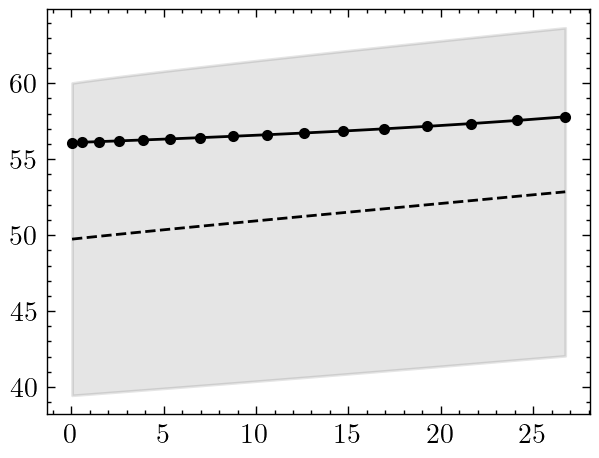

In [148]:
region_label = 'All'
index=S_data>XLF_Data_band[f'{region_label}']['cutoff_sensitivity']
original_data = Daaa1D(f'{region_label}', S_data[index], XLF_Data_band[f'{region_label}']['dN'][index])
ui.set_data(9,original_data)

#+cutoff_brokenpl_dN(x,para[6:11])
def LMXB_model(x,para):
    return cutoff_brokenpl_dN(x,para[6:11])
def AGN_model(x,para):
    return brokenpl_dN(x,para[0:4])+power_law(x,para[4:6]) #+cutoff_brokenpl_dN(x,para[6:11])
def model(x,para):
    return brokenpl_dN(x,para[0:4])+power_law(x,para[4:6])+cutoff_power_law(x,para[11:16]) #+cutoff_brokenpl_dN(x,para[6:11])
def LMXB_model(x,para):
    return cutoff_brokenpl_dN(x,para[6:11])# for iteration,A in enumerate(np.logspace(-1.0,1.3,6)):
expected_HMXB_number_list = []
expected_LMXB_number_list = []
expected_HMXB_number_list_0580 = []
expected_LMXB_number_list_0580 = []
detected_HMXB_number_list = []
detected_LMXB_number_list = []
All_LMXB_beta1_list = []
All_LMXB_beta2_list = []
All_LMXB_K_list = []
All_LMXB_beta1_max_list = []
All_LMXB_beta1_min_list = []
All_LMXB_beta2_max_list = []
All_LMXB_beta2_min_list = []
All_LMXB_Lx_list = []
All_HMXB_Lx_list = []
All_HMXB_Lx_list2 = []
All_AGN_Lx_list = []
All_rstat_list = []
All_stat_list = []
TotalM31lumilosity = []
C_list = []
Ce_list = []
Cv_list = []
C19_list = []
Ce19_list = []
Cv19_list = []
All_HMXB.A  = 0
Back_AGN.K.thaw()
Back_AGN.beta1.thaw()
Back_AGN.beta2.thaw()
Back_AGN.fb.thaw()
ui.fit(1,9)
Back_AGN.freeze()
All_HMXB.alpha = 1.66
All_HMXB.alpha.freeze()
for iteration,A in enumerate(np.linspace(0.3,21,16)**1.5/2.5): # enumerate(np.linspace(0.1,40,20)):
    All_HMXB.A  = A
    All_HMXB.A.freeze()
    All_LMXB.thaw()
    All_LMXB.cutoff = np.log10(luminosity2flux(1e41)/3.1)
    All_LMXB.cutoff.freeze()
    # Back_AGN.freeze()
    # ui.fit(9)
    # Back_AGN.K.thaw()
    # Back_AGN.beta1.thaw()
    # Back_AGN.beta2.thaw()
    # Back_AGN.fb.thaw()
    ui.fit(9)
   
    # dN = XLF_Data_band[f'{region_label}']['dN']
    exec(f"""para= tuple([i.val for i in {region_label}_source_model.pars])""")
#     exec(f"""print({region_label}_source_model)""")
    # model_dN = model(S_model,para) * dS_model * XLF_Data_band[f'{region_label}']['sky_area_function']+LMXB_model(S_model,para) * dS_model * XLF_Data_band[f'{region_label}']['mass_function']+HMXB_model(S_model,para) * dS_model * XLF_Data_band[f'{region_label}']['SFR_function']   
    # rebin_indices = np.floor(np.arange(len(model_dN)) / expanded_times).astype(int)
    # new_model_dN = np.bincount(rebin_indices, weights=model_dN)
    C = calculate_c_statistic(ui.get_data_plot(9).y,ui.get_model_plot(9).y)
    C_list.append(C)
    C = calculate_c_statistic(np.hstack([ui.get_data_plot(1).y,ui.get_data_plot(9).y]),np.hstack([ui.get_model_plot(1).y,ui.get_model_plot(9).y]))
    C19_list.append(C)
    
    Ce = calculate_expected_C(ui.get_model_plot(9).y)
    Cv = calculate_variance_C(ui.get_model_plot(9).y)
    Ce_list.append(Ce)
    Cv_list.append(Cv)
    Ce = calculate_expected_C(np.hstack([ui.get_model_plot(1).y,ui.get_model_plot(9).y]))
    Cv = calculate_variance_C(np.hstack([ui.get_model_plot(1).y,ui.get_model_plot(9).y]))
    Ce19_list.append(Ce)
    Cv19_list.append(Cv)
    detected_LMXB_number = np.sum((LMXB_model(S_model,para) * dS_model * XLF_Data_band[f'{region_label}']['mass_function']))
    expected_LMXB_number = np.cumsum((LMXB_model(S_model,para) * dS_model * np.max(XLF_Data_band[f'{region_label}']['mass_function']))[::-1])[::-1][(S_model>luminosity2flux(1e36)) & (S_model<luminosity2flux(1e41)) ][0]
    expected_LMXB_number_0580 = np.cumsum((LMXB_model(S_model,para) * dS_model * np.max(XLF_Data_band[f'{region_label}']['mass_function']))[::-1])[::-1][(S_model>luminosity2flux(1e36)/3.1) & (S_model<luminosity2flux(1e41)/3.1)][0]
    print('detected LMXB number',detected_LMXB_number)
    print('expected LMXB number',expected_LMXB_number)
    detected_HMXB_number = np.sum((HMXB_model(S_model,para) * dS_model * XLF_Data_band[f'{region_label}']['SFR_function']))
    expected_HMXB_number = np.cumsum((HMXB_model(S_model,para) * dS_model * np.max(XLF_Data_band[f'{region_label}']['SFR_function']))[::-1])[::-1][(S_model>luminosity2flux(1e36)) & (S_model<luminosity2flux(1e41)) ][0]
    expected_HMXB_number_0580 = np.cumsum((HMXB_model(S_model,para) * dS_model * np.max(XLF_Data_band[f'{region_label}']['SFR_function']))[::-1])[::-1][(S_model>luminosity2flux(1e36)/3.1) & (S_model<luminosity2flux(1e41)/3.1)][0]
    print('detected HMXB number',detected_HMXB_number)
    print('expected HMXB number',expected_HMXB_number) 
    print('stat:',ui.get_stat_info()[8].rstat)
    All_rstat_list.append(ui.get_stat_info()[8].rstat)
    All_stat_list.append(ui.get_stat_info()[8].statval)
    L = (4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*S_model
    # Lx = (4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*np.cumsum(S_model*(LMXB_model(S_model,para) * dS_model * np.max(XLF_Data_band[f'{region_label}']['mass_function']))[::-1])[::-1]
    # print('integrated LMXB luminosity (L2.0-4.5)>1e35',Lx[L>1e35][0])
    # Lx = (4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*np.cumsum(S_model*(HMXB_model(S_model,para) * dS_model * np.max(XLF_Data_band[f'{region_label}']['SFR_function']))[::-1])[::-1]
    # print('integrated HMXB luminosity (L2.0-4.5)>1e35',Lx[L>1e35][0])
    
    L = 3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*S_model
    L0580 = 3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*S_model
    # Lx = 3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*np.cumsum(S_model*(LMXB_model(S_model,para) * dS_model * np.max(XLF_Data_band[f'{region_label}']['mass_function']))[::-1])[::-1]
    Integrated_Lx = 3.1*flux2luminosity(np.sum((S_model*LMXB_model(S_model,para) * dS_model * np.max(XLF_Data_band[f'{region_label}']['mass_function'])) [(S_model>luminosity2flux(1e36)/3.1) & (S_model<luminosity2flux(1e41)/3.1)]))
    print('integrated converted LMXB luminosity (L0.5-8)>1e36',Integrated_Lx)
    All_LMXB_Lx_list.append(Integrated_Lx)
    Integrated_Lx = 3.1*flux2luminosity(np.sum((S_model*HMXB_model(S_model,para) * dS_model * np.max(XLF_Data_band[f'{region_label}']['SFR_function'])) [(S_model>luminosity2flux(1e36)/3.1) & (S_model<luminosity2flux(1e41)/3.1)]))
    # Lx = 3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*np.cumsum(S_model*(HMXB_model(S_model,para) * dS_model * np.max(XLF_Data_band[f'{region_label}']['SFR_function']))[::-1])[::-1]
    print('integrated converted HMXB luminosity (L0.5-8)>1e36',Integrated_Lx)
    All_HMXB_Lx_list.append(Integrated_Lx)

    Lx = 3.1*flux2luminosity( np.sum((HMXB_model(S_model, para) * dS_model * S_model  )[ (S_model>luminosity2flux(1e36)/3.1) & (S_model<luminosity2flux(1e41)/3.1)] ))
    All_HMXB_Lx_list2.append(Lx)
    print('A',A,'HMXB luminosity:',Integrated_Lx,Lx)
    
    
    total_luminosity = (flux2luminosity(3.1*np.sum(((XLF_Data_band[f'{region_label}']['dN_InSmallBin'])*S_model)[S_model>luminosity2flux(1e36)/3.1])))
    AGN_luminosity = flux2luminosity(3.1*np.sum((AGN_model(S_model,para) * S_model* dS_model * XLF_Data_band[f'{region_label}']['sky_area_function'])[(S_model>luminosity2flux(1e36)/3.1) & (S_model<luminosity2flux(1e41)/3.1)]))

    print(total_luminosity,AGN_luminosity)

    TotalM31lumilosity.append(total_luminosity-AGN_luminosity)
    
    print('=='*20)


    
    # plt.plot(expected_HMXB_number,All_LMXB.beta1.val,'kx')
    # plt.plot(expected_HMXB_number,All_LMXB.beta2.val,'kx',alpha=0.4)
    expected_HMXB_number_list.append(expected_HMXB_number)
    expected_LMXB_number_list.append(expected_LMXB_number)
    expected_HMXB_number_list_0580.append(expected_HMXB_number_0580)
    expected_LMXB_number_list_0580.append(expected_LMXB_number_0580)
    detected_HMXB_number_list.append(detected_HMXB_number)
    detected_LMXB_number_list.append(detected_LMXB_number)
    All_LMXB_beta1_list.append(All_LMXB.beta1.val)
    All_LMXB_beta2_list.append(All_LMXB.beta2.val)
    All_LMXB_K_list.append(All_LMXB.K.val)
    All_LMXB.fb.freeze()
    ui.covar(9,All_LMXB.beta1)
    if ui.get_covar_results().parmaxes[0] is None:
        All_LMXB_beta1_max_list.append(np.nan)
    else:
        All_LMXB_beta1_max_list.append(ui.get_covar_results().parmaxes[0])
    if ui.get_covar_results().parmins[0] is None:
        All_LMXB_beta1_min_list.append(np.nan)
    else:
        All_LMXB_beta1_min_list.append(ui.get_covar_results().parmins[0])
    ui.covar(9,All_LMXB.beta2)
    if ui.get_covar_results().parmaxes[0] is None:
        All_LMXB_beta2_max_list.append(np.nan)
    else:
        All_LMXB_beta2_max_list.append(ui.get_covar_results().parmaxes[0])
    if ui.get_covar_results().parmins[0] is None:
        All_LMXB_beta2_min_list.append(np.nan)
    else:
        All_LMXB_beta2_min_list.append(ui.get_covar_results().parmins[0])


All_LMXB_beta1_max_list = np.array(All_LMXB_beta1_max_list)
All_LMXB_beta1_min_list = np.array(All_LMXB_beta1_min_list)
All_LMXB_beta1_list = np.array(All_LMXB_beta1_list)
All_LMXB_beta2_max_list = np.array(All_LMXB_beta2_max_list)
All_LMXB_beta2_min_list = np.array(All_LMXB_beta2_min_list)

# plt.plot(expected_HMXB_number_list,All_LMXB_beta1_list,'.-')
# plt.plot(expected_HMXB_number_list,All_LMXB_beta2_list,'.-')
plt.errorbar(x=expected_HMXB_number_list,y=All_LMXB_beta1_list,yerr=All_LMXB_beta1_max_list,fmt='.',color='k')
# plt.errorbar(x=expected_HMXB_number_list,y=All_LMXB_beta2_list,yerr=Disk_LMXB_beta2_max_list,fmt='.',color='tomato')
plt.xlabel('expected HMXB number')
plt.ylabel('beta1 of LMXB')   

plt.axhline(1.31,color='k')
plt.fill_between(expected_HMXB_number_list,np.ones(len(expected_HMXB_number_list))*1.31-0.07,np.ones(len(expected_HMXB_number_list))*1.31+0.05,alpha=0.1,color='k')

# plt.axhline(2.57,color='tomato')
# plt.fill_between(expected_HMXB_number_list,np.ones(len(expected_HMXB_number_list))*2.57-0.28,np.ones(len(expected_HMXB_number_list))*2.57+0.54,alpha=0.1,color='tomato')


plt.axhline(1.02,color='grey')
plt.fill_between(expected_HMXB_number_list,np.ones(len(expected_HMXB_number_list))*1.02-0.08,np.ones(len(expected_HMXB_number_list))*1.02+0.07,alpha=0.1,color='grey')

# plt.axhline(2.06,color='pink')
# plt.fill_between(expected_HMXB_number_list,np.ones(len(expected_HMXB_number_list))*2.06-0.05,np.ones(len(expected_HMXB_number_list))*2.06+0.06,alpha=0.1,color='pink')

plt.show()


plt.plot(expected_HMXB_number_list,np.array(C_list),'k.-')
plt.plot(expected_HMXB_number_list,np.array(Ce_list)-4,'k--')
plt.fill_between(expected_HMXB_number_list,np.array(Ce_list)+np.sqrt(Cv_list)-4,np.array(Ce_list)-np.sqrt(Cv_list)-4,alpha=0.1,color='k')
plt.show()


In [313]:
para_1 = (129.29970366558928,
 2.0011177056709526,
 2.9308009852166985,
 1.92318301036384,
 0.0,
 0.0,
 2.6,
 1.31,
 2.57,
 29.95831064823702,
 0.0,
 38.49363583762906,
 1.6,
 -10.0)

Integrated_Lx = (np.sum((S_model*LMXB_model(S_model,para_1) * dS_model * np.max(XLF_Data_band[f'{region_label}']['mass_function'])) [(S_model>luminosity2flux(1e36)/3.1) & (S_model<luminosity2flux(1e41)/3.1)]))


All_source_model.pars


(<Parameter 'K' of model 'All_AGN'>,
 <Parameter 'beta1' of model 'All_AGN'>,
 <Parameter 'beta2' of model 'All_AGN'>,
 <Parameter 'fb' of model 'All_AGN'>,
 <Parameter 'A' of model 'All_star'>,
 <Parameter 'alpha' of model 'All_star'>,
 <Parameter 'K' of model 'All_LMXB'>,
 <Parameter 'beta1' of model 'All_LMXB'>,
 <Parameter 'beta2' of model 'All_LMXB'>,
 <Parameter 'fb' of model 'All_LMXB'>,
 <Parameter 'cutoff' of model 'All_LMXB'>,
 <Parameter 'A' of model 'All_HMXB'>,
 <Parameter 'alpha' of model 'All_HMXB'>,
 <Parameter 'cutoff' of model 'All_HMXB'>)

In [150]:
# A = (np.linspace(0.3,21,16)**1.5/2.5)[6]
# All_HMXB.A  = A
# print(A)
# All_HMXB.A.freeze()
# All_HMXB.alpha=1.66
# region_label = 'All'
# print((np.cumsum((HMXB_model(S_model,para) * dS_model)[::-1])[::-1])[S_model>luminosity2flux(1e36)][0])

# print(np.log10((flux2luminosity(np.cumsum((HMXB_model(S_model,para) * dS_model * S_model)[::-1])[::-1])[S_model>luminosity2flux(1e36)][0])))

In [151]:
# # HMXB_model(S_model,para)
# # luminosity2flux(1e38)
# plt.plot(S_model,HMXB_model(S_model,para)/HMXB_model(np.array([luminosity2flux(1e38),]),para)*2.06)

In [152]:
# A = 37
# All_HMXB.A  = A
# print(A)
# All_HMXB.A.freeze()
# All_HMXB.alpha=1.66
# region_label = 'All'
# para= tuple([i.val for i in All_source_model.pars])
# print((np.cumsum((HMXB_model(S_model,para) * dS_model)[::-1])[::-1])[S_model>luminosity2flux(1e36)][0])
# print(HMXB_N(S_,2.06,1.66)[S_model>luminosity2flux(1e36)][0])
# print(np.log10((flux2luminosity(np.cumsum((HMXB_model(S_model,para) * dS_model * S_model)[::-1])[::-1])[S_model>luminosity2flux(1e36)][0])))

# plt.plot(S_model,(np.cumsum((HMXB_model(S_model,para)/HMXB_model(np.array([luminosity2flux(1e38),]),para)*2.06 * dS_model)[::-1])[::-1]),label='lehmer')

# plt.plot(S_model,(np.cumsum((HMXB_model(S_model,para) * dS_model)[::-1])[::-1]))
# # plt.plot(S_model,HMXB_N(S_,2.06,1.66))
# plt.xscale('log')
# plt.yscale('log')
# # plt.xlim([3e-15,1e-14])
# # plt.ylim([30,200])

# plt.legend()

In [153]:
# def cutoff_power_law(x, para):
#     A,alpha,cutoff = para
#     y = A *1e14* (x/1e-14)**(-alpha)#/(u.deg**2)
#     y[np.log10(x)>cutoff]=0
#     return y

# def HMXB_model(x,para):
#     return cutoff_power_law(x,para[11:16])

# def Luo_AGN_N(S,K,beta1,beta2,fb):
#     S_ref = 1e-14
# #     K = 453.7e14
# #     beta1 = 1.46
# #     beta2 = 2.72
# #     fb = 0.89
#     c = K*(fb*1e-14/S_ref)**(beta2-beta1)*(fb*1e-14/S_ref)**(-beta2)*fb*1e-14/(beta2-1)
#     N = K*(S/S_ref)**(-beta1)*(S)/(beta1-1)-K*(fb*1e-14/S_ref)**(-beta1)*(fb*1e-14)/(beta1-1)+c
#     index = S>fb*1e-14
#     N[index] =  K*(fb*1e-14/S_ref)**(beta2-beta1)*(S[index]/S_ref)**(-beta2)*S[index]/(beta2-1) #S>fb
#     return N

# def HMXB_N(S,K,beta):
#     return K*Luo_AGN_N(S,1,beta,beta,1)/Luo_AGN_N(np.array([144.3e-14]),1,beta,beta,1)  # the N at luminosity2flux(1e38) is K.


In [162]:
def cumsum_reverse(array):
    return np.cumsum(array[::-1])[::-1]

In [163]:
def cutoff_pl(x,A,beta):
    
    y = A * (x)**(-beta)
    return y
    
    

65.11551924105109
39.54960830840573


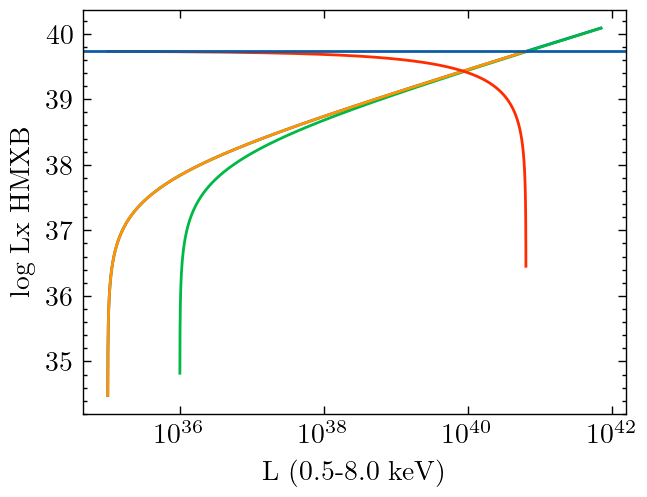

In [333]:
L_model = flux2luminosity(S_model)
dL_model = flux2luminosity(dS_model)


print(np.sum(((2.06*cutoff_pl(L_model/1e38,1,1.66)/cutoff_pl(1e38/1e38,1,1.66)*(dL_model/1e38) ))[(L_model>1e36) & (L_model<2e40)]))

print(np.log10(np.sum(((2.06*cutoff_pl(L_model/1e38,1,1.66)/cutoff_pl(1e38/1e38,1,1.66)*(dL_model/1e38)*L_model ))[(L_model>1e36) & (L_model<2e40) ])))

plt.plot(L_model[L_model>1e35],np.log10(np.cumsum((2.06*cutoff_pl(L_model/1e38,1,1.66)/cutoff_pl(1e38/1e38,1,1.66)*(dL_model/1e38)*L_model )[L_model>1e35])),label='lehmer')
plt.plot(L_model[L_model>1e36],np.log10(np.cumsum((2.06*cutoff_pl(L_model/1e38,1,1.66)/cutoff_pl(1e38/1e38,1,1.66)*(dL_model/1e38)*L_model )[L_model>1e36])),label='lehmer')
plt.plot(L_model[(L_model>1e35) & (L_model<10**(40.8))],np.log10(np.cumsum((2.06*cutoff_pl(L_model/1e38,1,1.66)/cutoff_pl(1e38/1e38,1,1.66)*(dL_model/1e38)*L_model )[(L_model>1e35) & (L_model<10**(40.8))])[::-1])[::-1],label='lehmer')
plt.xscale('log')
plt.xlabel('L (0.5-8.0 keV)')
plt.ylabel('log Lx HMXB')


plt.plot(L_model[(L_model>1e35) & (L_model<10**(40.8))], np.log10(np.cumsum(((2.06*cutoff_pl(L_model/1e38,1,1.66)/cutoff_pl(1e38/1e38,1,1.66)*(dL_model/1e38)*L_model )[(L_model>1e35) & (L_model<10**(40.8))])[::-1])[::-1]))

plt.axhline(39.73)


# np.cumsum((HMXB_model(S_model,para) * dS_model * np.max(XLF_Data_band[f'{region_label}']['SFR_function']))[::-1])[::-1][(S_model>luminosity2flux(1e36)/3.1) & (S_model<luminosity2flux(1e41)/3.1)][0]

# para
# plt.plot(3.1*flux2luminosity(S_model[L_model>1e36]),np.log10(3.1*flux2luminosity(np.cumsum((HMXB_model(S_model,(133.8784711171383, 2.03410402075417, 2.8876348264975444, 1.767332731313552, 0.0, 0.0, 1.2038032429948184, 0.7680268305614878, 2.7075869333674007, 27.606557765275543, 0.0, 40,  1.6, 0.0)) * \
#            dS_model * S_model * np.max(XLF_Data_band[f'{region_label}']['SFR_function']))[L_model>1e36]))))




0.6435158995978385

In [375]:
def luminosity2flux(l):
    return l/flux2luminosity(1e-14)*1e-14


K_LMXB = LMXB_model(np.array([luminosity2flux(1e38/3.1)]),para)/1e11
Lb = flux2luminosity(3.1*para[9]*1e-14)/1e38
gamma1 = para[7]
gamma2 = para[8]
log_Lc = 41
log_L_lo = 36



array([23.71060355])

In [384]:
import numpy as np
from scipy.integrate import quad

def calculate_alpha_lmxb_final():
    """
    根据 Lehmer et al. (2019) 的 XLF 模型，最终修正并精确计算 alpha_LMXB。

    此版本修正了最关键的问题：文献中 dN/d(log L) 的归一化定义，在
    实践中应理解为 dN/d(ln L)。这移除了转换公式中一个多余的 ln(10) 因子。
    """
    # --- 1. 定义来自 Lehmer et al. (2019) 表4 "Global" 模型的参数 ---
    K_LMXB = 26.0      # (1/M_*) * dN/d(ln L) at L_norm, per 10^11 M_sun
    gamma1 = 1.31      # 低光度端斜率
    log_Lb = 38.33     # log10(折断光度), erg/s
    gamma2 = 2.57      # 高光度端斜率
    log_Lc = 40.7        # log10(截止光度), erg/s (积分上限)
    log_L_lo = 36.0    # log10(积分下限), erg/s

    # 论文中报告的用于比较的值
    log_alpha_LMXB_paper = 29.15


    K_LMXB = 33.8      # (1/M_*) * dN/d(ln L) at L_norm, per 10^11 M_sun
    gamma1 = 1.28      # 低光度端斜率
    log_Lb = np.log10(1.48e38)     # log10(折断光度), erg/s
    gamma2 = 2.33      # 高光度端斜率
    log_Lc = 40.7        # log10(截止光度), erg/s (积分上限)
    log_L_lo = 36.0    # log10(积分下限), erg/s

    # 论文中报告的用于比较的值
    log_alpha_LMXB_paper = 29.25


    

    
    # --- 2. 将对数单位转换为线性单位 ---
    Lb = 10**log_Lb
    Lc = 10**log_Lc
    L_lo = 10**log_L_lo
    L_norm = 10**38

    # --- 3. 计算 dN/(dM* dL) 的归一化常数 C ---
    # 我们设 g(L) = (1/M*) * dN/dL = C * broken_power_law_shape(L)
    # 论文中的 K_LMXB 定义为 (1/M_*) * dN/d(log L)，我们将其理解为 (1/M_*) * dN/d(ln L)。
    # 关系式: dN/d(ln L) = L * dN/dL
    # 所以: K_LMXB / 1e11 = (1/M_*) * dN/d(ln L) | at L_norm
    #      K_LMXB / 1e11 = L_norm * g(L_norm)

    # L_norm (10^38) < Lb (10^38.33), 因此使用低光度端幂律形式
    g_L_norm_shape = L_norm**(-gamma1)

    # --- 关键修正点: C 的计算公式中没有 ln(10) ---
    numerator_C = K_LMXB / 1e11
    denominator_C = L_norm * g_L_norm_shape # = L_norm * L_norm**(-gamma1) = L_norm**(1-gamma1)
    C = numerator_C / denominator_C
    print(f"信息: L_norm ({L_norm:.2e}) < Lb ({Lb:.2e}), 使用低光度端斜率进行归一化。")
    print(f"最终计算得到的归一化常数 C = {C:.4e}")

    # --- 4. 定义被积函数: L * g(L) ---
    def integrand(L, C_norm, g1, L_break, g2):
        if L <= L_break:
            return L * C_norm * (L**(-g1))
        else:
            return L * C_norm * (L_break**(g2 - g1) * L**(-g2))

    # --- 5. 进行数值积分 ---
    integral1, err1 = quad(integrand, L_lo, Lb, args=(C, gamma1, Lb, gamma2))
    integral2, err2 = quad(integrand, Lb, Lc, args=(C, gamma1, Lb, gamma2))

    alpha_LMXB_calculated = integral1 + integral2
    log_alpha_LMXB_calculated = np.log10(alpha_LMXB_calculated)

    # --- 6. 打印结果并与论文值进行比较 ---
    print("\n--- Lehmer et al. (2019) LMXB XLF (Global 模型) ---")
    print(f"使用的积分范围 log(L): [{log_L_lo}, {log_Lc}]")
    print("-" * 50)
    print("--- 计算结果 ---")
    print(f"计算得到的 alpha_LMXB: {alpha_LMXB_calculated:.4e} erg/s/M_sun")
    print(f"计算得到的 log(alpha_LMXB): {log_alpha_LMXB_calculated:.4f}")
    print("-" * 50)
    print("--- 结果比较 ---")
    print(f"论文 (表4) 中的 log(alpha_LMXB): {log_alpha_LMXB_paper:.4f}")
    
    difference = log_alpha_LMXB_calculated - log_alpha_LMXB_paper
    print(f"差值 (计算值 - 论文值): {difference:.4f} dex")

    if abs(difference) < 0.02:
        print("\n结论: 计算结果与论文报告值高度一致。复现成功！")
    else:
        print("\n结论: 计算结果与论文报告值仍存在差异。")

# 运行最终计算
calculate_alpha_lmxb_final()


信息: L_norm (1.00e+38) < Lb (1.48e+38), 使用低光度端斜率进行归一化。
最终计算得到的归一化常数 C = 1.4754e+01

--- Lehmer et al. (2019) LMXB XLF (Global 模型) ---
使用的积分范围 log(L): [36.0, 40.7]
--------------------------------------------------
--- 计算结果 ---
计算得到的 alpha_LMXB: 1.7651e+29 erg/s/M_sun
计算得到的 log(alpha_LMXB): 29.2468
--------------------------------------------------
--- 结果比较 ---
论文 (表4) 中的 log(alpha_LMXB): 29.2500
差值 (计算值 - 论文值): -0.0032 dex

结论: 计算结果与论文报告值高度一致。复现成功！


In [394]:
import numpy as np



def calculate_total_Lx_per_unit(K, gamma1, gamma2, log_Lb, log_L_min=36.0, log_L_max=40.8):
    """
    Calculates the total X-ray luminosity per unit M* (for alpha) or SFR (for beta)
    by integrating a broken power-law XLF.

    The XLF is defined as:
    dN/dL38 = K * (L38 / Lb_38)^(-gamma1) for L38 <= Lb_38
    dN/dL38 = K * (Lb_38)^(-gamma1) * (L38 / Lb_38)^(-gamma2) for L38 > Lb_38
             = K * Lb_38^(gamma2-gamma1) * L38^(-gamma2)

    The function integrates L_x * (dN/dL_x) dL_x.
    Note that L_x = L38 * 1e38 and dL_x = 1e38 * dL38.
    So, integral = integral(L38 * 1e38 * (dN/dL38) * dL38)
                 = 1e38 * integral(L38 * dN/dL38 * dL38)

    Args:
        K (float): Normalization constant of the XLF (K_L or K_H).
        gamma1 (float): The faint-end slope of the XLF.
        gamma2 (float): The bright-end slope of the XLF.
        log_Lb (float): The log10 of the break luminosity in erg/s.
        log_L_min (float): The log10 of the lower integration limit in erg/s.
        log_L_max (float): The log10 of the upper integration limit in erg/s.

    Returns:
        float: The total integrated luminosity (alpha or beta).
    """
    # Convert luminosities from log scale to linear scale and normalize to 1e38 erg/s
    L_min_38 = 10**(log_L_min - 38)
    L_max_38 = 10**(log_L_max - 38)
    Lb_38 = 10**(log_Lb - 38)

    # --- Part 1: Integrate from L_min to L_b ---
    # Integral of L38 * K * (L38)^(-gamma1) = K * L38^(1-gamma1)
    integral_1 = 0
    # The integration range is from L_min_38 to min(Lb_38, L_max_38)
    # The upper limit is Lb_38, unless Lb_38 is already brighter than the max integration limit
    upper_bound_1 = min(Lb_38, L_max_38)

    if upper_bound_1 > L_min_38:
        power = 2 - gamma1
        if abs(power) < 1e-9:  # Handle the case where gamma1 is close to 2
            integral_1 = K * (np.log(upper_bound_1) - np.log(L_min_38))
        else:
            integral_1 = K * (1/power) * (upper_bound_1**power - L_min_38**power)

    # --- Part 2: Integrate from L_b to L_max ---
    # Integral of L38 * K * Lb_38^(gamma2-gamma1) * L38^(-gamma2)
    # = K * Lb_38^(gamma2-gamma1) * L38^(1-gamma2)
    integral_2 = 0
    # The integration range is from max(L_min_38, Lb_38) to L_max_38
    # The lower limit is Lb_38, unless Lb_38 is fainter than the min integration limit
    lower_bound_2 = max(L_min_38, Lb_38)

    if L_max_38 > lower_bound_2:
        constant_term = K * (Lb_38**(gamma2 - gamma1))
        power = 2 - gamma2
        if abs(power) < 1e-9: # Handle the case where gamma2 is close to 2
             integral_2 = constant_term * (np.log(L_max_38) - np.log(lower_bound_2))
        else:
            integral_2 = constant_term * (1/power) * (L_max_38**power - lower_bound_2**power)

    # Total luminosity is the sum of the integrals, scaled by 1e38
    total_Lx = 1e38 * (integral_1 + integral_2)
    return total_Lx

# --- Parameters from Lehmer et al. 2019, Table 4, "Normal" model ---

# LMXB parameters
lmxb_params = {
    "log_K": np.log10(26),
    "gamma1": 1.31,
    "log_Lb": 38.3,
    "gamma2": 2.57,
    "log_alpha_table": 29.15 # For comparison
}


for i,region_label in enumerate(['All','Center','InnerArm','Ring','InterArm']):
    print(i+1,region_label)

# region_label = 'Center'
    exec(f"""para= tuple([i.val for i in {region_label}_source_model.pars])""")
    
    def luminosity2flux(l):
        return l/flux2luminosity(1e-14)*1e-14    
    K_LMXB = LMXB_model(np.array([luminosity2flux(1e38/3.1)]),para)[0]/1e11
    Lb = flux2luminosity(3.1*para[9]*1e-14)
    log_Lb = np.log10(Lb)
    print(log_Lb)
    gamma1 = para[7]
    gamma2 = para[8]
    log_Lc = 41
    log_L_lo = 36    
    
    lmxb_params = {
        "log_K": np.log10(K_LMXB),
        "gamma1": gamma1,
        "log_Lb": log_Lb,
        "gamma2": gamma2,
        "log_alpha_table": 29.15 # For comparison
    }
    
    # HMXB parameters
    # hmxb_params = {
    #     "log_K": np.log10(2.06),
    #     "gamma1": 1.66,
    #     "log_Lb": 38,
    #     "gamma2": 1.66,
    #     "log_beta_table": 39.73 # For comparison
    # }
    
    # --- Perform Calculations ---
    
    # Calculate for LMXBs
    K_L = 10**lmxb_params["log_K"]/1e11
    alpha_LMXB = calculate_total_Lx_per_unit(
        K_L,
        lmxb_params["gamma1"],
        lmxb_params["gamma2"],
        lmxb_params["log_Lb"]
    )
    log_alpha_LMXB_calc = np.log10(alpha_LMXB)
    
    # Calculate for HMXBs
    # K_H = 10**hmxb_params["log_K"]
    # beta_HMXB = calculate_total_Lx_per_unit(
    #     K_H,
    #     hmxb_params["gamma1"],
    #     hmxb_params["gamma2"],
    #     hmxb_params["log_Lb"]
    # )
    # log_beta_HMXB_calc = np.log10(beta_HMXB)
    
    
    # --- Print Results ---
    print("--- LMXB Alpha Calculation (Lehmer+2019, Table 4 'Normal' Model) ---")
    print(f"输入参数: log(K_L)={lmxb_params['log_K']}, gamma1={lmxb_params['gamma1']}, log(Lb)={lmxb_params['log_Lb']}, gamma2={lmxb_params['gamma2']}")
    print(f"计算得到的 log(alpha_LMXB): {log_alpha_LMXB_calc:.2f}")
    print(f"Lehmer+2019 表4 中的值: {lmxb_params['log_alpha_table']:.2f}")
    print("-" * 60)
    
    # print("\n--- HMXB Beta Calculation (Lehmer+2019, Table 4 'Normal' Model) ---")
    # print(f"输入参数: log(K_H)={hmxb_params['log_K']}, gamma1={hmxb_params['gamma1']}, log(Lb)={hmxb_params['log_Lb']}, gamma2={hmxb_params['gamma2']}")
    # print(f"计算得到的 log(beta_HMXB): {log_beta_HMXB_calc:.2f}")
    # print(f"Lehmer+2019 表4 中的值: {hmxb_params['log_beta_table']:.2f}")
    # print("-" * 60)
    
    # --- Verification ---
    # The calculated values should be very close to the table values.
    # Small differences (~0.01 dex) can arise from rounding of parameters in the paper.
    if abs(log_alpha_LMXB_calc - lmxb_params['log_alpha_table']) < 0.02:
        print("\nLMXB alpha 值复现成功！")
    else:
        print("\nLMXB alpha 值与表中数值有偏差，请检查参数。")
    
    # if abs(log_beta_HMXB_calc - hmxb_params['log_beta_table']) < 0.02:
    #     print("HMXB beta 值复现成功！")
    # else:
    #     print("HMXB beta 值与表中数值有偏差，请检查参数。")


1 All
37.80855928165579
--- LMXB Alpha Calculation (Lehmer+2019, Table 4 'Normal' Model) ---
输入参数: log(K_L)=1.3749426090114427, gamma1=1.0440315563418, log(Lb)=37.80855928165579, gamma2=2.863737825713027
计算得到的 log(alpha_LMXB): 28.53
Lehmer+2019 表4 中的值: 29.15
------------------------------------------------------------

LMXB alpha 值与表中数值有偏差，请检查参数。
2 Center
37.729846815686464
--- LMXB Alpha Calculation (Lehmer+2019, Table 4 'Normal' Model) ---
输入参数: log(K_L)=1.5431974632294103, gamma1=1.0648542438311008, log(Lb)=37.729846815686464, gamma2=3.4683134253581547
计算得到的 log(alpha_LMXB): 28.53
Lehmer+2019 表4 中的值: 29.15
------------------------------------------------------------

LMXB alpha 值与表中数值有偏差，请检查参数。
3 InnerArm
37.88238159584201
--- LMXB Alpha Calculation (Lehmer+2019, Table 4 'Normal' Model) ---
输入参数: log(K_L)=1.021805766609386, gamma1=1.328343766072536, log(Lb)=37.88238159584201, gamma2=5.999995289588101
计算得到的 log(alpha_LMXB): 28.16
Lehmer+2019 表4 中的值: 29.15
----------------------------

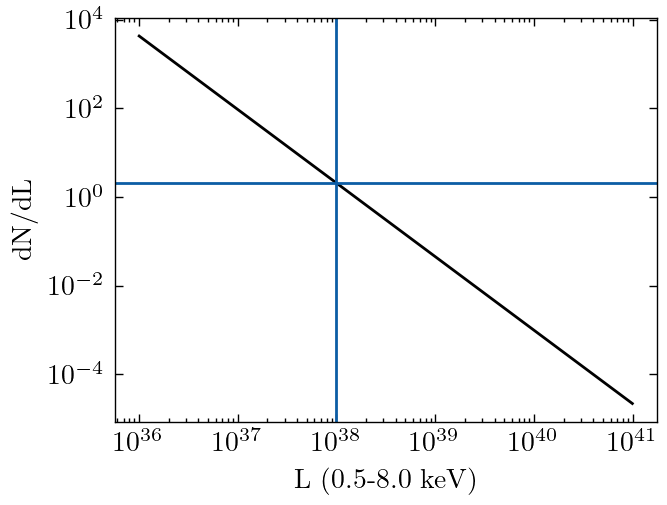

65.2015991242145


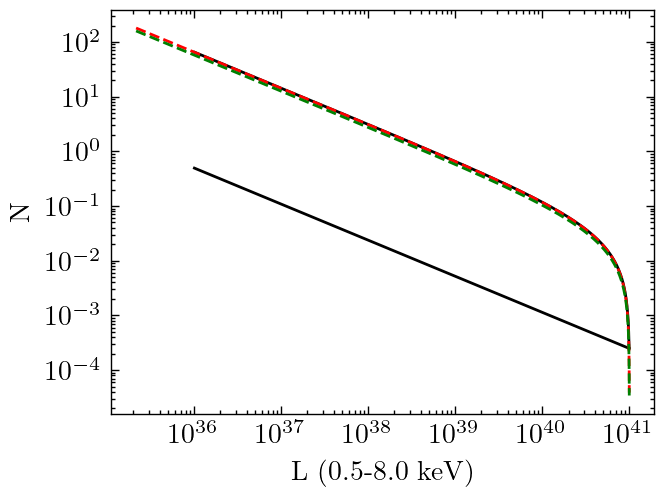

39.793637495178736
39.724136235582534
num: 65.16727541945657
3.283172780615605e+39


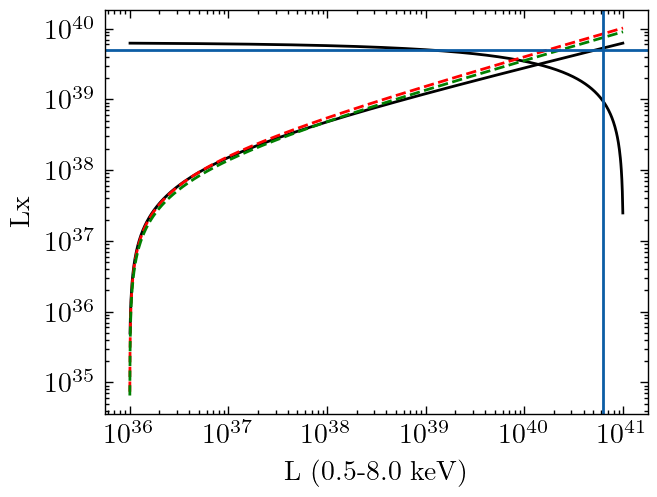

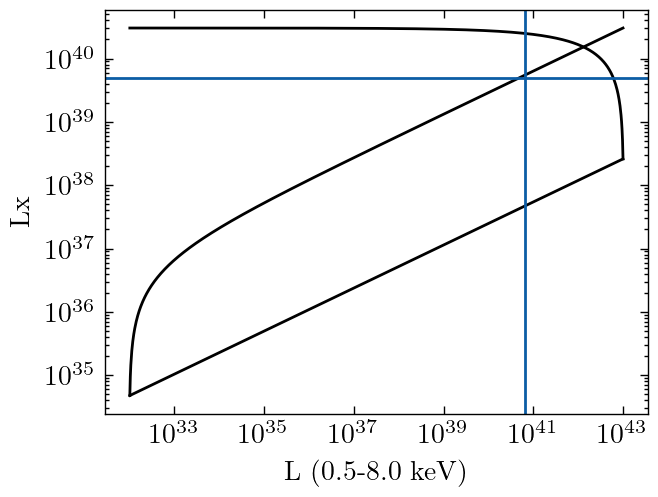

In [166]:
L_bin = np.logspace(36,41,1001)
L = np.sqrt(L_bin[1:]*L_bin[:-1])
dL = L_bin[1:]-L_bin[:-1]


plt.plot(L,2.06*cutoff_pl(L/1e38,1,1.66)/cutoff_pl(1e38/1e38,1,1.66),'k-',label='lehmer')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('dN/dL')
plt.axhline(2.06)
plt.axvline(1e38)
plt.xlabel('L (0.5-8.0 keV)')
plt.show()


plt.plot(L,(2.06*cutoff_pl(L/1e38,1,1.66)/cutoff_pl(1e38/1e38,1,1.66)*(dL/1e38)),'k-',label='lehmer')
plt.plot(L,cumsum_reverse(2.06*cutoff_pl(L/1e38,1,1.66)/cutoff_pl(1e38/1e38,1,1.66)*(dL/1e38)),'k-',label='lehmer')

S_bin = np.logspace(-15,-8,90*100+1) # in 2.0-4.5 keV
S = np.sqrt(S_bin[1:]*S_bin[:-1])
dS = S_bin[1:]-S_bin[:-1]

plt.plot(  (flux2luminosity(S)*3.1)[S<luminosity2flux(1e41)/3.1] , cumsum_reverse(( HMXB_model(S,(0,0,0,0,0,0,0,0,0,0, 0.0, 26,  1.66, 0.0)) * dS)[S<luminosity2flux(1e41)/3.1] ),'r--')
plt.plot(  (flux2luminosity(S)*3.1)[S<luminosity2flux(1e41)/3.1] , cumsum_reverse(( HMXB_model(S,(0,0,0,0,0,0,0,0,0,0, 0.0, 23,  1.66, 0.0)) * dS)[S<luminosity2flux(1e41)/3.1] ),'g--')

print(np.sum((( HMXB_model(S,(0,0,0,0,0,0,0,0,0,0, 0.0, 26,  1.66, 0.0)) * dS)[(S>luminosity2flux(1e36)/3.1) & (S<luminosity2flux(1e41)/3.1)] )))

plt.xscale('log')
plt.yscale('log')
plt.ylabel('N')
plt.xlabel('L (0.5-8.0 keV)')
plt.show()

plt.plot(L,np.cumsum(2.06*cutoff_pl(L/1e38,1,1.66)/cutoff_pl(1e38/1e38,1,1.66)*(dL/1e38)*L),'k-',label='lehmer')
plt.plot(L,cumsum_reverse(2.06*cutoff_pl(L/1e38,1,1.66)/cutoff_pl(1e38/1e38,1,1.66)*(dL/1e38)*L),'k-',label='lehmer')

plt.plot(flux2luminosity(S[ (S>luminosity2flux(1e36)/3.1) & (S<luminosity2flux(1e41)/3.1)])*3.1, 3.1*flux2luminosity( np.cumsum((HMXB_model(S,(0,0,0,0,0,0,0,0,0,0, 0.0, 26,  1.6, 0.0)) * dS * S)[ (S>luminosity2flux(1e36)/3.1) & (S<luminosity2flux(1e41)/3.1)] )),'r--')
plt.plot(flux2luminosity(S[ (S>luminosity2flux(1e36)/3.1) & (S<luminosity2flux(1e41)/3.1)])*3.1, 3.1*flux2luminosity( np.cumsum((HMXB_model(S,(0,0,0,0,0,0,0,0,0,0, 0.0, 23,  1.6, 0.0)) * dS * S)[ (S>luminosity2flux(1e36)/3.1) & (S<luminosity2flux(1e41)/3.1)] )),'g--')

print(np.log10(np.sum((2.06*cutoff_pl(L/1e38,1,1.66)/cutoff_pl(1e38/1e38,1,1.66)*(dL/1e38)*L)[L<10**41])))
print(np.log10(np.sum((2.06*cutoff_pl(L/1e38,1,1.66)/cutoff_pl(1e38/1e38,1,1.66)*(dL/1e38)*L)[L<10**40.8])))
print('num:',(np.sum((2.06*cutoff_pl(L/1e38,1,1.66)/cutoff_pl(1e38/1e38,1,1.66)*(dL/1e38))[L<10**40.8])))

print(flux2luminosity(np.sum(( HMXB_model(S,(0,0,0,0,0,0,0,0,0,0, 0.0, 26,  1.6, 0.0)) * dS * S)[ (S>luminosity2flux(1e36)/3.1) & (S<luminosity2flux(1e41)/3.1)] )))

plt.xscale('log')
plt.yscale('log')
plt.ylabel('Lx')
plt.xlabel('L (0.5-8.0 keV)')
plt.axhline(10**39.7)
plt.axvline(10**40.8)
plt.show()



L_bin = np.logspace(32,43,1001)
L = np.sqrt(L_bin[1:]*L_bin[:-1])
dL = L_bin[1:]-L_bin[:-1]
plt.plot(L,np.cumsum(2.06*cutoff_pl(L/1e38,1,1.66)/cutoff_pl(1e38/1e38,1,1.66)*(dL/1e38)*L),'k-',label='lehmer')
plt.plot(L,(2.06*cutoff_pl(L/1e38,1,1.66)/cutoff_pl(1e38/1e38,1,1.66)*(dL/1e38)*L),'k-',label='lehmer')
plt.plot(L,cumsum_reverse(2.06*cutoff_pl(L/1e38,1,1.66)/cutoff_pl(1e38/1e38,1,1.66)*(dL/1e38)*L),'k-',label='lehmer')

plt.xscale('log')
plt.yscale('log')
plt.ylabel('Lx')
plt.xlabel('L (0.5-8.0 keV)')
plt.axhline(10**39.7)
plt.axvline(10**40.8)
plt.show()



In [167]:
print(np.log10(np.sum((2.06*cutoff_pl(L/1e38,1,1.66)/cutoff_pl(1e38/1e38,1,1.66)*(dL/1e38)*L)[L<10**41])))
print(np.log10(np.sum((2.06*cutoff_pl(L/1e38,1,1.66)/cutoff_pl(1e38/1e38,1,1.66)*(dL/1e38)*L)[L<10**40.8])))


39.801339557411175
39.73395597607852


In [168]:
L_bin = np.logspace(36,42,10001)
L = np.sqrt(L_bin[1:]*L_bin[:-1])
dL = L_bin[1:]-L_bin[:-1]

Lx = np.cumsum(2.06*cutoff_pl(L/1e38,1,1.6)/cutoff_pl(1e38/1e38,1,1.6)*(dL/1e38)*L)
Lx

# np.log10((Lx[L>1e40][0])/(Lx[L>1e39][0]))
# Lx[L>1e39][0]
np.log10((Lx[L>=1e41][0])/(Lx[L>10**40.8][0]))

0.08080690001393218

In [169]:

# L0580_model = 3.1*flux2luminosity(S_model)
# dL0580_model = 3.1*flux2luminosity(dS_model)

# L_model = flux2luminosity(S_model)
# dL_model = flux2luminosity(dS_model)

# print(np.sum(((2.06*cutoff_pl(L_model/1e38,1,1.66)/cutoff_pl(1e38/1e38,1,1.66)*(dL_model/1e38) ))[(L_model>1e36) & (L_model<10**41)]))


# plt.plot(L_model[(L_model>1e36) & (L_model<10**41)],            cumsum_reverse(((2.06*cutoff_pl(L_model/1e38,1,1.66)/cutoff_pl(1e38/1e38,1,1.66)*(dL_model/1e38) ))[(L_model>1e36) & (L_model<10**41)]))

# plt.plot(L0580_model[(L0580_model>1e36) & (L0580_model<10**41)],cumsum_reverse(((2.06*cutoff_pl(L0580_model/1e38,1,1.66)/cutoff_pl(1e38/1e38,1,1.66)*(L0580_model/1e38) ))[(L0580_model>1e36) & (L0580_model<10**41)]))
# plt.plot(L_model[(L_model>1e36) & (L_model<10**41)],cumsum_reverse(((2.06*cutoff_pl(L_model/1e38,1,1.66)/cutoff_pl(1e38/1e38,1,1.66)*(L_model/1e38) ))[(L_model>1e36) & (L_model<10**41)]))
# # plt.plot(L_model[(L_model>1e36) & (L_model<10**41)],cumsum_reverse(((2.06*cutoff_pl(L_model/1e38,1,1.66)/cutoff_pl(1e38/1e38,1,1.66)*(L_model/1e38) ))[(L_model>1e36) & (L_model<10**41)]))

# plt.plot(L0580_model[(L0580_model>1e36) & (L0580_model<1e41)], cumsum_reverse((HMXB_model(S_model,(0,0,0,0,0,0,0,0,0,0, 0.0, 10,  1.6, 0.0)) * dS_model )[(S_model>luminosity2flux(1e36)/3.1) & (S_model<luminosity2flux(1e41)/3.1)]))

# plt.xscale('log')
# plt.yscale('log')
# plt.ylim(1,)
# plt.xlabel('L 0.5-8.0keV')

In [170]:
# def cutoff_pl(x,A,beta):
    
#     y = A * (x)**(-beta)
#     return y

# model_bins = np.logspace(-16,-9,90*100+1)
# S_model =  np.sqrt(model_bins[1:]*model_bins[:-1])
# S_data =  np.sqrt(data_bins[1:]*data_bins[:-1])
# dS_model = model_bins[1:]-model_bins[:-1]


# L_model = flux2luminosity(S_model)
# dL_model = flux2luminosity(dS_model)

# # L_model
# # cutoff_pl(L_model,2.06,1.66)

# # cutoff_pl(np.array([1e38,]),2.06,1.66)
# # plt.plot(S_model,(2.06*(np.cumsum((cutoff_pl(L_model,1,1.66)*dL_model)[::-1])[::-1])/(np.cumsum((cutoff_pl(np.array([1e38,]),1,1.66)*dL_model)[::-1])[::-1])),'k')
# # plt.plot(S_model,(2.06*(cumsum_reverse((cutoff_pl(S_model,1,1.66)*dS_model)))/(cumsum_reverse((cutoff_pl(S_model,1,1.66)*dS_model))[L_model>1e38])[0]),'r')

# plt.xscale('log')
# plt.yscale('log')
# plt.axvline(luminosity2flux(1e38))
# # plt.axhline(2.06)

# # plt.plot(S_,HMXB_N(S_,2.06,1.66),'g--')

# plt.plot(S_model,(cumsum_reverse(2.06*cutoff_pl(L_model/1e38,1,1.66)/cutoff_pl(1e38/1e38,1,1.66)*(dL_model/1e38) )),label='lehmer')
# plt.legend()
# plt.xscale('log')
# plt.yscale('log')


# print(np.sum(((2.06*cutoff_pl(L_model/1e38,1,1.66)/cutoff_pl(1e38/1e38,1,1.66)*(dL_model/1e38) ))[(L_model>1e36) & (L_model<10**40.8)]))

# print(np.log10(np.sum(((2.06*cutoff_pl(L_model/1e38,1,1.66)/cutoff_pl(1e38/1e38,1,1.66)*(dL_model/1e38)*L_model ))[(L_model>1e36) & (L_model<10**40.8) ])))




lehmer 文章中的 公式是用 2.06 * L **(-1.66), 而 L 是 in 1e38 unit 的。 


In [171]:
# np.log10(cumsum_reverse(2.06*cutoff_pl(L_model/1e38,1,1.66)/cutoff_pl(1e38/1e38,1,1.66)*(dL_model/1e38)*L_model ) [L_model>1e36][0])



In [172]:
# plt.plot(L_model,(cumsum_reverse(2.06*cutoff_pl(L_model/1e38,1,1.66)/cutoff_pl(1e38/1e38,1,1.66)*(dL_model/1e38) )))
# plt.xscale('log')
# plt.yscale('log')

# ((cumsum_reverse(2.06*cutoff_pl(L_model/1e38,1,1.66)/cutoff_pl(1e38/1e38,1,1.66)*(dL_model/1e38) ))[L_model>1e36])[0]

In [173]:
# normlization = 2.06/(cumsum_reverse((cutoff_pl(S_model,1,1.66)*dS_model))[L_model>1e38])[0]


# np.log10(flux2luminosity((cumsum_reverse(normlization*cutoff_pl(S_model,1,1.66)*dS_model*S_model)[L_model>1e38])[0]))



In [174]:
# A = (np.linspace(0.3,21,16)**1.5/2.5)[6]
# All_HMXB.A  = A
# print(A)
# All_HMXB.A.freeze()
# All_HMXB.alpha=1.66
# region_label = 'All'
# expected_HMXB_number = np.cumsum((HMXB_model(S_model,para) * dS_model * np.max(XLF_Data_band[f'{region_label}']['SFR_function']))[::-1])[::-1]#[S_model>luminosity2flux(1e36)][0]

# expected_HMXB_number   
# plt.plot(S_model,expected_HMXB_number)
# plt.plot(S_,HMXB_N(S_,1.96,1.66))
# plt.plot(S_,HMXB_N(S_,1.5,1.66))
# plt.xscale('log')
# plt.yscale('log')
# plt.xlim([1e-15,1e-14])
# plt.ylim([10,100])


In [175]:
# # Lx = 3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*np.cumsum(S_model*(HMXB_model(S_model,para) * dS_model * np.max(XLF_Data_band[f'{region_label}']['SFR_function']))[::-1])[::-1]
# # para

# # When HMXB A is 11, the beta HMXB is 39.7
# Lx = 3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*np.cumsum(S_model*(HMXB_model(S_model,(133.814611617428, 2.030486933951882, 2.888956170012243, 1.77089636591995, 0.0, 0.0, 2.8310160413782146, 1.0214627767278393, 2.4367103051354277, 27.50866859793584, 0.0, 11, 1.6, 0.0)) * dS_model * np.max(XLF_Data_band[f'{region_label}']['SFR_function']))[::-1])[::-1]
# L = 3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*S_model
# # len(S_model),
# Lx[L>1e36][0]
# np.log10((Lx[L>1e36][0]/np.max(XLF_Data_band['All']['SFR_function'])))
# # (133.814611617428, 2.030486933951882, 2.888956170012243, 1.77089636591995, 0.0, 0.0, 2.8310160413782146, 1.0214627767278393, 2.4367103051354277, 27.50866859793584, 0.0, 12.573291922165811, 1.6, 0.0)

In [176]:
expected_C_assume_on_data = calculate_expected_C(ui.get_data_plot(9).y)
variance_C_assume_on_data = calculate_variance_C(ui.get_data_plot(9).y)
expected_C_assume_on_data
variance_C_assume_on_data

91.09676121388087

In [177]:
# HMXB = Disk_HMXB
# HMXB.A=1
# Disk_HMXB

In [178]:
# Disk_HMXB.A  = A
# Disk_HMXB.A.freeze()
# # Disk_HMXB.thaw()
# Disk_HMXB.cutoff = 0
# Disk_HMXB.cutoff.freeze()
# Disk_HMXB.alpha = 1.6
# Disk_HMXB.alpha.freeze()
# ui.freeze(Disk_HMXB)
# ui.fit(5)
# Disk_HMXB+Disk_LMXB

In [179]:
# All_HMXB = 10.6

# Lx = 3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*np.cumsum(S_model*(HMXB_model(S_model,para) * dS_model * np.max(XLF_Data_band[f'{region_label}']['SFR_function']))[::-1])[::-1]
# print('integrated converted HMXB luminosity (L0.5-8)>1e36',Lx[L>1e36][0])
# HMXB_Lx = Lx[L>1e36][0]
# exec(f"""para= tuple([i.val for i in {region_label}_source_model.pars])""")    

In [180]:

# region_label_list = ['Back','North','South','Center','Disk','Ring','InnerArm','InterArm','All']
# i = 4
# i = 5
# i = 6
# region_label = region_label_list[i]
# # index=S_data>XLF_Data_band[f'{region_label}']['cutoff_sensitivity']
# # original_data = Data1D(f'{region_label}', S_data[index], XLF_Data_band[f'{region_label}']['dN'][index])
# # ui.set_data(i+1,original_data)

# #+cutoff_brokenpl_dN(x,para[6:11])
# def LMXB_model(x,para):
#     return cutoff_brokenpl_dN(x,para[6:11])
# def model(x,para):
#     return brokenpl_dN(x,para[0:4])+power_law(x,para[4:6])+cutoff_power_law(x,para[11:16]) #+cutoff_brokenpl_dN(x,para[6:11])
# def LMXB_model(x,para):
#     return cutoff_brokenpl_dN(x,para[6:11])# for iteration,A in enumerate(np.logspace(-1.0,1.3,6)):
# # Disk_fitting_list  = []
# # Ring_fitting_list  = []
# InnerArm_fitting_list  = []

# All_HMXB.A  = 0
# Back_AGN.K.thaw()
# Back_AGN.beta1.thaw()
# Back_AGN.beta2.thaw()
# Back_AGN.fb.thaw()
# ui.fit(1,9)
# Back_AGN.freeze()
# ui.fit(i+1)

# # HMXB = Ring_HMXB
# # LMXB = Ring_LMXB
# HMXB = InnerArm_HMXB
# LMXB = InnerArm_LMXB

# for iteration,A in enumerate(np.linspace(0.1,40,20)):
#     HMXB.A  = A
#     HMXB.A.freeze()
#     ui.freeze(HMXB)
#     HMXB.cutoff = 0
#     HMXB.cutoff.freeze()
#     HMXB.alpha = 1.6
#     HMXB.alpha.freeze()
#     # print(HMXB)
#     LMXB.thaw()
#     # Back_AGN.freeze()
#     # ui.fit(9)
#     # Back_AGN.K.thaw()
#     # Back_AGN.beta1.thaw()
#     # Back_AGN.beta2.thaw()
#     # Back_AGN.fb.thaw()
#     ui.fit(i+1)
   
#     # dN = XLF_Data_band[f'{region_label}']['dN']
#     exec(f"""para= tuple([i.val for i in {region_label}_source_model.pars])""")
# #     exec(f"""print({region_label}_source_model)""")
#     # model_dN = model(S_model,para) * dS_model * XLF_Data_band[f'{region_label}']['sky_area_function']+LMXB_model(S_model,para) * dS_model * XLF_Data_band[f'{region_label}']['mass_function']+HMXB_model(S_model,para) * dS_model * XLF_Data_band[f'{region_label}']['SFR_function']   
#     # rebin_indices = np.floor(np.arange(len(model_dN)) / expanded_times).astype(int)
#     # new_model_dN = np.bincount(rebin_indices, weights=model_dN)
#     C = calculate_c_statistic(ui.get_data_plot(i+1).y,ui.get_model_plot(i+1).y)    
#     Ce = calculate_expected_C(ui.get_model_plot(i+1).y)
#     Cv = calculate_variance_C(ui.get_model_plot(i+1).y)
    



#     detected_LMXB_number = np.sum((LMXB_model(S_model,para) * dS_model * XLF_Data_band[f'{region_label}']['mass_function']))
#     expected_LMXB_number = np.cumsum((LMXB_model(S_model,para) * dS_model * np.max(XLF_Data_band[f'{region_label}']['mass_function']))[::-1])[::-1][S_model>luminosity2flux(1e36)][0]
#     print('detected LMXB number',detected_LMXB_number)
#     print('expected LMXB number',expected_LMXB_number)
#     detected_HMXB_number = np.sum((HMXB_model(S_model,para) * dS_model * XLF_Data_band[f'{region_label}']['SFR_function']))
#     expected_HMXB_number = np.cumsum((HMXB_model(S_model,para) * dS_model * np.max(XLF_Data_band[f'{region_label}']['SFR_function']))[::-1])[::-1][S_model>luminosity2flux(1e36)][0]
#     print('detected HMXB number',detected_HMXB_number)
#     print('expected HMXB number',expected_HMXB_number) 
#     print('stat:',ui.get_stat_info()[i].rstat)
#     # All_rstat_list.append(ui.get_stat_info()[8].rstat)
#     # All_stat_list.append(ui.get_stat_info()[8].statval)
#     L = (4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*S_model
#     Lx = (4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*np.cumsum(S_model*(LMXB_model(S_model,para) * dS_model * np.max(XLF_Data_band[f'{region_label}']['mass_function']))[::-1])[::-1]
#     print('integrated LMXB luminosity (L2.0-4.5)>1e35',Lx[L>1e35][0])
#     Lx = (4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*np.cumsum(S_model*(HMXB_model(S_model,para) * dS_model * np.max(XLF_Data_band[f'{region_label}']['SFR_function']))[::-1])[::-1]
#     print('integrated HMXB luminosity (L2.0-4.5)>1e35',Lx[L>1e35][0])
    
#     L = 3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*S_model
#     Lx = 3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*np.cumsum(S_model*(LMXB_model(S_model,para) * dS_model * np.max(XLF_Data_band[f'{region_label}']['mass_function']))[::-1])[::-1]
#     print('integrated converted LMXB luminosity (L0.5-8)>1e36',Lx[L>1e36][0])
#     LMXB_Lx = Lx[L>1e36][0]
#     Lx = 3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*np.cumsum(S_model*(HMXB_model(S_model,para) * dS_model * np.max(XLF_Data_band[f'{region_label}']['SFR_function']))[::-1])[::-1]
#     print('integrated converted HMXB luminosity (L0.5-8)>1e36',Lx[L>1e36][0])
#     HMXB_Lx = Lx[L>1e36][0]
#     print('=='*20)

#     # plt.plot(expected_HMXB_number,All_LMXB.beta1.val,'kx')
#     # plt.plot(expected_HMXB_number,All_LMXB.beta2.val,'kx',alpha=0.4)
#     LMXB.fb.freeze()
#     ui.covar(i+1,LMXB.beta1)
#     if ui.get_covar_results().parmaxes[0] is None:
#         LMXB_beta1_max = np.nan
#     else:
#         LMXB_beta1_max = ui.get_covar_results().parmaxes[0]


#     if ui.get_covar_results().parmins[0] is None:
#         LMXB_beta1_min = np.nan
#     else:
#         LMXB_beta1_min = ui.get_covar_results().parmins[0]
#     ui.covar(i+1,LMXB.beta2)
#     if ui.get_covar_results().parmaxes[0] is None:
#         LMXB_beta2_max = np.nan
#     else:
#         LMXB_beta2_max = ui.get_covar_results().parmaxes[0]
#     if ui.get_covar_results().parmins[0] is None:
#         LMXB_beta2_min = np.nan
#     else:
#         LMXB_beta2_min = ui.get_covar_results().parmins[0]


#     InnerArm_fitting_list.append({'A':A,
#                               'C':C,
#                               'Ce':Ce,
#                               'Cv':Cv,
#                               'All_rstat':ui.get_stat_info()[i].rstat,
#                               'All_stat':ui.get_stat_info()[i].statval,
#                               'expected_HMXB_number':expected_HMXB_number,
#                               'expected_LMXB_number':expected_LMXB_number,
#                               'detected_HMXB_number':detected_HMXB_number,
#                               'detected_LMXB_number':detected_LMXB_number,
#                               'beta1':All_LMXB.beta1.val,
#                               'beta2':All_LMXB.beta2.val,
#                               'K':All_LMXB.K.val,
#                               'beta1_max':LMXB_beta1_max,
#                               'beta1_min':LMXB_beta1_min,
#                               'beta2_max':LMXB_beta2_max,
#                               'beta2_min':LMXB_beta2_min, 
#                               'LMXB_Lx':LMXB_Lx,
#                               'HMXB_Lx':HMXB_Lx, 
#                              })

# # Disk_fitting_df = pd.DataFrame(Disk_fitting_list)
# # Ring_fitting_df = pd.DataFrame(Ring_fitting_list)
# InnerArm_fitting_df = pd.DataFrame(InnerArm_fitting_list)


# # plt.plot(expected_HMXB_number_list,All_LMXB_beta1_list,'.-')
# # plt.plot(expected_HMXB_number_list,All_LMXB_beta2_list,'.-')
# # plt.errorbar(x=Disk_fitting_df['expected_HMXB_number'],y=Disk_fitting_df['beta1'],yerr=Disk_fitting_df['beta1_max'],fmt='.',color='k')
# # # plt.errorbar(x=expected_HMXB_number_list,y=All_LMXB_beta2_list,yerr=Disk_LMXB_beta2_max_list,fmt='.',color='tomato')
# # plt.xlabel('expected HMXB number')
# # plt.ylabel('beta1 of LMXB')   

# # plt.axhline(1.31,color='k')
# # plt.fill_between(expected_HMXB_number_list,np.ones(len(expected_HMXB_number_list))*1.31-0.07,np.ones(len(expected_HMXB_number_list))*1.31+0.05,alpha=0.1,color='k')

# # # plt.axhline(2.57,color='tomato')
# # # plt.fill_between(expected_HMXB_number_list,np.ones(len(expected_HMXB_number_list))*2.57-0.28,np.ones(len(expected_HMXB_number_list))*2.57+0.54,alpha=0.1,color='tomato')


# # plt.axhline(1.02,color='grey')
# # plt.fill_between(expected_HMXB_number_list,np.ones(len(expected_HMXB_number_list))*1.02-0.08,np.ones(len(expected_HMXB_number_list))*1.02+0.07,alpha=0.1,color='grey')

# # plt.axhline(2.06,color='pink')
# # plt.fill_between(expected_HMXB_number_list,np.ones(len(expected_HMXB_number_list))*2.06-0.05,np.ones(len(expected_HMXB_number_list))*2.06+0.06,alpha=0.1,color='pink')




In [181]:

# # fitting_df = Ring_fitting_df
# fitting_df = InnerArm_fitting_df
# fig, (ax1, ax2, ax3,ax4,ax5,ax6) = plt.subplots(6, 1, sharex=True, gridspec_kw={'hspace': 0})

# fig.set_figheight(3.35/4*1.8*5)
# fig.set_figwidth(3.35)
# # ax1.plot(expected_HMXB_number_list,All_stat_list,'k.-')
# ax1.set_ylabel('stat of fitting') 
# ax1.plot(fitting_df['expected_HMXB_number'],fitting_df['C'],'k.-')
# ax1.plot(fitting_df['expected_HMXB_number'],fitting_df['Ce']-4,'k--')
# ax1.fill_between(fitting_df['expected_HMXB_number'],fitting_df['Ce']+fitting_df['Cv']-4,fitting_df['Ce']-fitting_df['Cv']-4,alpha=0.1,color='k')

# # ax1.plot(expected_HMXB_number_list,C19_list,'k.-')
# # ax1.plot(expected_HMXB_number_list,np.array(Ce19_list)-8,'k--')
# # ax1.fill_between(expected_HMXB_number_list,np.array(Ce19_list)+np.sqrt(Cv19_list)-8,np.array(Ce19_list)-np.sqrt(Cv19_list)-8,alpha=0.1,color='k')

# # ax1.plot(expected_HMXB_number_list,np.array(Ce19_list),'k--')
# # ax1.fill_between(expected_HMXB_number_list,np.array(Ce19_list)+np.sqrt(Cv19_list),np.array(Ce19_list)-np.sqrt(Cv19_list),alpha=0.1,color='k')

# ax1.set_ylabel('C-statistic')

# # A =0.1
# # index = (cstat_collection_df['mode'] == 'True') & (cstat_collection_df['A'] == A)
# # ax1.plot(expected_HMXB_number_list[0],np.mean(cstat_collection_df[index]['statval']),'rx')
# # index = (cstat_collection_df['mode'] == 'Fake') & (cstat_collection_df['A'] == A)
# # print(iteration,np.sum(index))
# # # np.mean(cstat_collection_df[index]['statval']),np.std(cstat_collection_df[index]['statval'])
# # # np.percentile((cstat_collection_df[index]['statval']),16),np.percentile((cstat_collection_df[index]['statval']),84)
# # ax1.plot(expected_HMXB_number_list[0],np.mean(cstat_collection_df[index]['statval']),'kx')
# # ax1.plot([expected_HMXB_number_list[0],expected_HMXB_number_list[0]],[np.percentile((cstat_collection_df[index]['statval']),16),np.percentile((cstat_collection_df[index]['statval']),84)],'k-',alpha=0.3)


# ax2.errorbar(x=fitting_df['expected_HMXB_number'],y=fitting_df['beta1'],yerr=fitting_df['beta1_max'],fmt='.',color='k')
# ax2.axhline(1.31,linestyle='--',color='royalblue',alpha=0.7)
# ax2.fill_between(fitting_df['expected_HMXB_number'],np.ones(len(detected_HMXB_number_list))*1.31-0.07,np.ones(len(detected_HMXB_number_list))*1.31+0.05,alpha=0.1,hatch='//',color='royalblue')
# ax2.axhline(1.02,linestyle=':',color='tomato',alpha=0.7)
# ax2.fill_between(fitting_df['expected_HMXB_number'],np.ones(len(detected_HMXB_number_list))*1.02-0.08,np.ones(len(detected_HMXB_number_list))*1.02+0.07,alpha=0.1,hatch='\\',color='tomato')
# ax2.set_ylabel(r'$\beta_1$ of LMXB') 
# ax3.errorbar(x=fitting_df['expected_HMXB_number'],y=All_LMXB_beta2_list,yerr=All_LMXB_beta2_max_list,fmt='.',color='k')
# ax3.set_ylabel(r'$\beta_2$ of LMXB') 
# ax3.axhline(2.57,color='royalblue',linestyle='--',alpha=0.7)
# ax3.fill_between(fitting_df['expected_HMXB_number'],np.ones(len(detected_HMXB_number_list))*2.57-0.28,np.ones(len(detected_HMXB_number_list))*2.57+0.54,alpha=0.1,hatch='//',color='royalblue')
# ax3.axhline(2.06,color='tomato',linestyle=':',alpha=0.7)
# ax3.fill_between(fitting_df['expected_HMXB_number'],np.ones(len(detected_HMXB_number_list))*2.06-0.05,np.ones(len(detected_HMXB_number_list))*2.06+0.06,alpha=0.1,hatch='\\',color='tomato')
# # plt.errorbar(x=expected_HMXB_number_list,y=All_LMXB_beta2_list,yerr=Disk_LMXB_beta2_max_list,fmt='.',color='tomato')
# ax4.plot(fitting_df['expected_HMXB_number'],fitting_df['expected_LMXB_number'],'k.-')
# ax4.set_ylabel('Expected $\mathcal{N}_\mathrm{LMXB}$')
# ax5.plot(fitting_df['expected_HMXB_number'],np.log10(fitting_df['LMXB_Lx']/np.max(XLF_Data_band[region_label]['mass_function'])/1e10),'k.-')
# ax5.axhline(29.15,color='royalblue',linestyle='--',alpha=0.7)
# ax5.fill_between(fitting_df['expected_HMXB_number'],np.ones(len(detected_HMXB_number_list))*29.15-0.05,np.ones(len(detected_HMXB_number_list))*29.15+0.07,alpha=0.1,hatch='//',color='royalblue')
# ax5.axhline(29.2,color='tomato',linestyle=':',alpha=0.7)
# ax5.fill_between(fitting_df['expected_HMXB_number'],np.ones(len(detected_HMXB_number_list))*29.2-0.1,np.ones(len(detected_HMXB_number_list))*29.2+0.1,alpha=0.1,hatch='\\',color='tomato')
# ax5.set_ylabel(r'log $\alpha_\mathrm{LMXB}$')

# ax6.plot(fitting_df['expected_HMXB_number'],np.log10(fitting_df['HMXB_Lx']/np.max(XLF_Data_band[region_label]['SFR_function'])),'k.-')
# ax6.axhline(39.73,color='royalblue',linestyle='--',alpha=0.7)
# ax6.fill_between(fitting_df['expected_HMXB_number'],np.ones(len(detected_HMXB_number_list))*39.73-0.1,np.ones(len(detected_HMXB_number_list))*39.73+0.15,alpha=0.1,hatch='//',color='royalblue')
# ax6.axhline(39.67,color='tomato',linestyle=':',alpha=0.7)
# ax6.fill_between(fitting_df['expected_HMXB_number'],np.ones(len(detected_HMXB_number_list))*39.67-0.06,np.ones(len(detected_HMXB_number_list))*39.67+0.06,alpha=0.1,hatch='\\',color='tomato')
# ax6.set_ylabel(r'log $\beta_\mathrm{HMXB}$')
# plt.xlabel('Expecetd $\mathcal{N}_\mathrm{HMXB}$ ($L_\mathrm{X}\mathrm{>10^{36}~erg~s^{-1}~cm^{-2}}$)')


# ax1_top = ax1.twiny()
# # ax1_top.spines['top'].set_position(('outward', 40))  # Move the top spine outward
# # ax1_top.spines['top'].set_visible(True)  # Make sure the top spine is visible

# # Sync the x-axis limits with the main x-axis
# # ax1_top.set_xlim(ax1.get_xlim())

# # Optionally, customize ticks and labels on the secondary x-axis
# ax1_top.set_xlabel('Detected $\mathcal{N}_\mathrm{HMXB}$')
# # ax1_top.set_xticks([1, 2, 3, 4, 5])  # Example custom ticks
# # ax1_top.set_xticklabels(['A', 'B', 'C', 'D', 'E']) 
# # ax1_top = ax1.twiny()
# # ax1_top.set_xlim(ax1.get_xlim())  # Make sure the new x-axis range matches the original

# # ax1_top.set_xticks(ax1.get_xticks()*(np.array(detected_HMXB_number_list)/np.array(expected_HMXB_number_list))[0])
# # ax1_top.set_xbound(ax1.get_xbound()[0]*(np.array(detected_HMXB_number_list)/np.array(expected_HMXB_number_list))[0],ax1.get_xbound()[1]*(np.array(detected_HMXB_number_list)/np.array(expected_HMXB_number_list))[0])
# # #     ax1_top.set_xticklabels(second_xtick_labels)
# ax1_top.set_xlim([ax1.get_xlim()[0]*(np.array(fitting_df['detected_HMXB_number'])/np.array(fitting_df['expected_HMXB_number']))[0],ax1.get_xlim()[1]*(np.array(fitting_df['detected_HMXB_number'])/np.array(fitting_df['expected_HMXB_number']))[0]])
# # ax1_top.set_xscale('log')
# # ax1_top.set_xticks([1e35,1e36,1e37,1e38])
# ax1_top.tick_params(axis='x', direction='inout', labeltop=True)

# # plt.xlabel(r'$L\mathrm{_X~(erg~s^{-1})}$ at 761 kpc')


# plt.tight_layout()
# # plt.savefig('figure/HMXB_expectation_ML6.pdf')
# plt.show()
# # plt.plot(detected_HMXB_number_list,np.array(expected_HMXB_number_list)/(np.array(expected_HMXB_number_list)+np.array(expected_LMXB_number_list)),'k.-')
# # plt.errorbar(x=expected_HMXB_number_list,y=All_LMXB_beta2_list,yerr=Disk_LMXB_beta2_max_list,fmt='.',color='tomato')
# # plt.xlabel('detected HMXB number')
# # plt.ylabel('stat of fitting')   




In [182]:
# plt.plot(S_data,dN)
# # plt.plot(S_data,new_model_dN)
# plt.xscale('log')
# # plt.plot(ui.get_data_plot(9).x,ui.get_data_plot(9).y)
# plt.plot(ui.get_model_plot(9).x,ui.get_model_plot(9).y)

# # ok, my calculation include too much data points.

# plt.show()

# ui.plot_data(9)
# ui.plot_model(9,overplot=True)
# plt.xscale('log')
# plt.xscale('log')

# Simulated_dN = np.random.poisson(ui.get_model_plot(9).y)
# Simulated_dN
# plt.step(ui.get_model_plot(9).x,Simulated_dN)


In [183]:
# ui.plot_fit(1)
# plt.xscale('log')
# # plt.show()
# ui.plot_fit(9,overplot=True)
# plt.xscale('log')

In [184]:
# region_label = 'All'
# index=S_data>XLF_Data_band[f'{region_label}']['cutoff_sensitivity']
# original_data = Data1D(f'{region_label}', S_data[index], XLF_Data_band[f'{region_label}']['dN'][index])
# ui.set_data(9,original_data)
# region_label = 'Back'
# index=S_data>XLF_Data_band[f'{region_label}']['cutoff_sensitivity']
# original_data = Data1D(f'{region_label}', S_data[index], XLF_Data_band[f'{region_label}']['dN'][index])
# ui.set_data(1,original_data)
# Back_AGN.thaw()
# ui.fit(1,)
# ui.fit(1,9)
# # ui.fit(1,9)


In [185]:
# cstat_collection_list = []
# for _ in range(2):
#     # for iteration,A in enumerate(np.linspace(0.1,40,20)):
#     A = 0.1
#     region_label = 'All'
#     index=S_data>XLF_Data_band[f'{region_label}']['cutoff_sensitivity']
#     original_data = Data1D(f'{region_label}', S_data[index], XLF_Data_band[f'{region_label}']['dN'][index])
#     ui.set_data(9,original_data)
#     region_label = 'Back'
#     index=S_data>XLF_Data_band[f'{region_label}']['cutoff_sensitivity']
#     original_data = Data1D(f'{region_label}', S_data[index], XLF_Data_band[f'{region_label}']['dN'][index])
#     ui.set_data(1,original_data)
#     ui.fit(1,9)
#     mode = 'True'
#     All_HMXB.A  = A
#     All_HMXB.A.freeze()
#     All_LMXB.thaw()
#     All_LMXB.cutoff = 0
#     All_LMXB.cutoff.freeze()
#     All_LMXB.fb.thaw()
#     Back_AGN.freeze()
#     ui.fit(1)
#     # Back_AGN.thaw()
#     ui.fit(9)
#     statval = ui.get_stat_info()[8].statval
#     statval19 = ui.get_stat_info()[0].statval+ui.get_stat_info()[8].statval
#     original_model = ui.get_model_plot(9).y
#     original_model_1 = ui.get_model_plot(1).y
#     original_model_9 = ui.get_model_plot(9).y
#     cstat_collection_list.append({'A':A,
#                                   'statval':statval,
#                                   'mode':mode,})

#     for _ in range(50):    
#         # region_label = 'Back'
#         # index=S_data>XLF_Data_band[f'{region_label}']['cutoff_sensitivity']
#         # data = Data1D(f'{region_label}', S_data[index], np.random.poisson(original_model_1))
#         # ui.set_data(1,data)
#         region_label = 'All'
#         index=S_data>XLF_Data_band[f'{region_label}']['cutoff_sensitivity']
#         data = Data1D(f'{region_label}', S_data[index], np.random.poisson(original_model_9))
#         ui.set_data(9,data)
#         ui.fit(9)
#         statval = ui.get_stat_info()[8].statval
#         statval19 = ui.get_stat_info()[0].statval+ui.get_stat_info()[8].statval
#         mode = 'Fake'
        
#         cstat_collection_list.append({'A':A,
#                                       'statval':statval,
#                                       'mode':mode,})

# cstat_collection_df = pd.DataFrame(cstat_collection_list)
# # t = Table.from_pandas(cstat_collection_df)
# # t.write('cstat_collection.fits',overwrite=True)



In [186]:
!curl https://api.day.app/Z72cNWuNUAzi5TTZiGtZeE/Jupyter_done

# ui.get_stat_info()[8]


curl: /home/huangrui/software/ciao-4.16/lib/libcurl.so.4: no version information available (required by curl)
{"code":200,"message":"success","timestamp":1756369786}

In [187]:
# import pandas as pd
# cstat_collection_df = pd.DataFrame(cstat_collection_list)
# t = Table.from_pandas(cstat_collection_df)
# t.write('cstat_collection.fits',overwrite=True)

# for iteration,A in enumerate(np.linspace(0.1,40,20)):

#     index = (cstat_collection_df['mode'] == 'True') & (cstat_collection_df['A'] == A)
#     plt.plot(detected_HMXB_number_list[iteration],np.mean(cstat_collection_df[index]['statval']),'rx')
#     index = (cstat_collection_df['mode'] == 'Fake') & (cstat_collection_df['A'] == A)
#     print(iteration,np.sum(index))
#     # np.mean(cstat_collection_df[index]['statval']),np.std(cstat_collection_df[index]['statval'])
#     # np.percentile((cstat_collection_df[index]['statval']),16),np.percentile((cstat_collection_df[index]['statval']),84)
#     plt.plot(detected_HMXB_number_list[iteration],np.mean(cstat_collection_df[index]['statval']),'kx')
#     plt.plot([detected_HMXB_number_list[iteration],detected_HMXB_number_list[iteration]],[np.percentile((cstat_collection_df[index]['statval']),16),np.percentile((cstat_collection_df[index]['statval']),84)],'k-',alpha=0.3)
# # cstat_collection_df

# plt.plot(detected_HMXB_number_list,C_list,'k.-')
# plt.plot(detected_HMXB_number_list,Ce_list,'k--')
# plt.plot(detected_HMXB_number_list,np.array(Ce_list)-4,'k:',alpha=0.5)
# plt.fill_between(detected_HMXB_number_list,np.array(Ce_list)+np.sqrt(Cv_list),np.array(Ce_list)-np.sqrt(Cv_list),alpha=0.1,color='k')
# plt.fill_between(detected_HMXB_number_list,np.array(Ce_list)+np.sqrt(Cv_list)-4,np.array(Ce_list)-np.sqrt(Cv_list)-4,alpha=0.1,color='green')
# # plt.fill_between(detected_HMXB_number_list,np.array(Ce_list)+np.sqrt(np.array(Cv_list)-4)-4,np.array(Ce_list)-np.sqrt(np.array(Cv_list)-4)-4,alpha=0.1,color='green')
# plt.ylabel('cstat')
# plt.fill_between(detected_HMXB_number_list,np.ones(np.shape(detected_HMXB_number_list))*(expected_C_assume_on_data)+np.ones(np.shape(detected_HMXB_number_list))*np.sqrt(variance_C_assume_on_data),np.ones(np.shape(detected_HMXB_number_list))*np.array(expected_C_assume_on_data)-np.ones(np.shape(detected_HMXB_number_list))*np.sqrt(variance_C_assume_on_data),alpha=0.1,color='red')
# plt.plot(detected_HMXB_number_list,np.ones(np.shape(detected_HMXB_number_list))*(expected_C_assume_on_data),'--',color='red')

# plt.xlabel('Detected HMXB number')

In [188]:
# oirginal_data = ui.get_data(9).y
# original_model = ui.get_model_plot(9).y
# plt.plot(oirginal_data,)
# plt.plot(original_model)

# data = Data1D(f'{region_label}', S_data[index], np.random.poisson(original_model))


# ui.set_data(9,data)

# plt.plot(ui.get_data(9).y)


# ui.fit(9)
# ui.set_data(9,original_data)


In [189]:
# print(calculate_c_statistic(dN,new_model_dN))

# print(calculate_C(dN,new_model_dN))


In [190]:
# plt.plot(detected_HMXB_number_list,C_list,'k.-')
# plt.plot(detected_HMXB_number_list,Ce_list,'k--')
# plt.fill_between(detected_HMXB_number_list,np.array(Ce_list)+np.sqrt(Cv_list),np.array(Ce_list)-np.sqrt(Cv_list),alpha=0.1,color='k')
# plt.ylabel('cstat')
# plt.fill_between(detected_HMXB_number_list,np.ones(np.shape(detected_HMXB_number_list))*(expected_C_assume_on_data)+np.ones(np.shape(detected_HMXB_number_list))*np.sqrt(variance_C_assume_on_data),np.ones(np.shape(detected_HMXB_number_list))*np.array(expected_C_assume_on_data)-np.ones(np.shape(detected_HMXB_number_list))*np.sqrt(variance_C_assume_on_data),alpha=0.1,color='red')
# plt.plot(detected_HMXB_number_list,np.ones(np.shape(detected_HMXB_number_list))*(expected_C_assume_on_data),'--',color='red')

# plt.xlabel('Detected HMXB number')

### plot the fitting result with different HMXBs normalizations

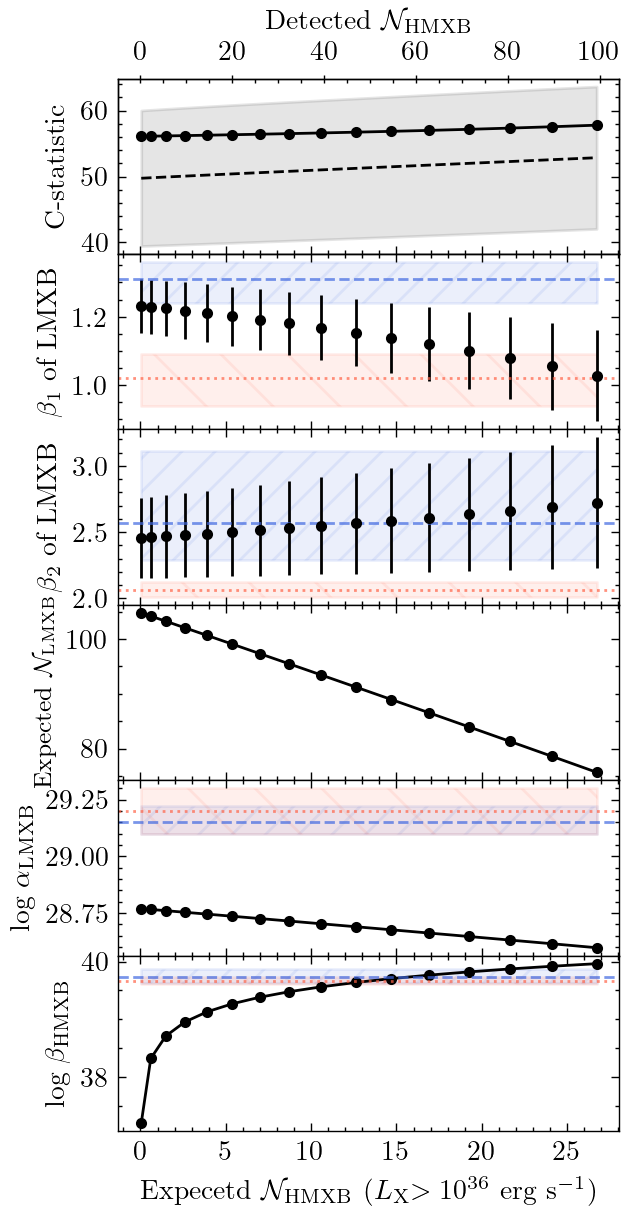

In [191]:
fig, (ax1, ax2, ax3,ax4,ax5,ax6) = plt.subplots(6, 1, sharex=True, gridspec_kw={'hspace': 0})

fig.set_figheight(3.35/4*1.5*5)
fig.set_figwidth(3.35)
# ax1.plot(expected_HMXB_number_list,All_stat_list,'k.-')
ax1.set_ylabel('stat of fitting') 
ax1.plot(expected_HMXB_number_list,np.array(C_list),'k.-')
ax1.plot(expected_HMXB_number_list,np.array(Ce_list)-4,'k--')
ax1.fill_between(expected_HMXB_number_list,np.array(Ce_list)+np.sqrt(Cv_list)-4,np.array(Ce_list)-np.sqrt(Cv_list)-4,alpha=0.1,color='k')

# ax1.plot(expected_HMXB_number_list,C19_list,'k.-')
# ax1.plot(expected_HMXB_number_list,np.array(Ce19_list)-8,'k--')
# ax1.fill_between(expected_HMXB_number_list,np.array(Ce19_list)+np.sqrt(Cv19_list)-8,np.array(Ce19_list)-np.sqrt(Cv19_list)-8,alpha=0.1,color='k')

# ax1.plot(expected_HMXB_number_list,np.array(Ce19_list),'k--')
# ax1.fill_between(expected_HMXB_number_list,np.array(Ce19_list)+np.sqrt(Cv19_list),np.array(Ce19_list)-np.sqrt(Cv19_list),alpha=0.1,color='k')

ax1.set_ylabel('C-statistic')

# A =0.1
# index = (cstat_collection_df['mode'] == 'True') & (cstat_collection_df['A'] == A)
# ax1.plot(expected_HMXB_number_list[0],np.mean(cstat_collection_df[index]['statval']),'rx')
# index = (cstat_collection_df['mode'] == 'Fake') & (cstat_collection_df['A'] == A)
# print(iteration,np.sum(index))
# # np.mean(cstat_collection_df[index]['statval']),np.std(cstat_collection_df[index]['statval'])
# # np.percentile((cstat_collection_df[index]['statval']),16),np.percentile((cstat_collection_df[index]['statval']),84)
# ax1.plot(expected_HMXB_number_list[0],np.mean(cstat_collection_df[index]['statval']),'kx')
# ax1.plot([expected_HMXB_number_list[0],expected_HMXB_number_list[0]],[np.percentile((cstat_collection_df[index]['statval']),16),np.percentile((cstat_collection_df[index]['statval']),84)],'k-',alpha=0.3)


ax2.errorbar(x=expected_HMXB_number_list,y=All_LMXB_beta1_list,yerr=All_LMXB_beta1_max_list,fmt='.',color='k')
ax2.axhline(1.31,linestyle='--',color='royalblue',alpha=0.7)
ax2.fill_between(expected_HMXB_number_list,np.ones(len(detected_HMXB_number_list))*1.31-0.07,np.ones(len(detected_HMXB_number_list))*1.31+0.05,alpha=0.1,hatch='//',color='royalblue')
ax2.axhline(1.02,linestyle=':',color='tomato',alpha=0.7)
ax2.fill_between(expected_HMXB_number_list,np.ones(len(detected_HMXB_number_list))*1.02-0.08,np.ones(len(detected_HMXB_number_list))*1.02+0.07,alpha=0.1,hatch='\\',color='tomato')
ax2.set_ylabel(r'$\beta_1$ of LMXB') 
ax3.errorbar(x=expected_HMXB_number_list,y=All_LMXB_beta2_list,yerr=All_LMXB_beta2_max_list,fmt='.',color='k')
ax3.set_ylabel(r'$\beta_2$ of LMXB') 
ax3.axhline(2.57,color='royalblue',linestyle='--',alpha=0.7)
ax3.fill_between(expected_HMXB_number_list,np.ones(len(detected_HMXB_number_list))*2.57-0.28,np.ones(len(detected_HMXB_number_list))*2.57+0.54,alpha=0.1,hatch='//',color='royalblue')
ax3.axhline(2.06,color='tomato',linestyle=':',alpha=0.7)
ax3.fill_between(expected_HMXB_number_list,np.ones(len(detected_HMXB_number_list))*2.06-0.05,np.ones(len(detected_HMXB_number_list))*2.06+0.06,alpha=0.1,hatch='\\',color='tomato')
# plt.errorbar(x=expected_HMXB_number_list,y=All_LMXB_beta2_list,yerr=Disk_LMXB_beta2_max_list,fmt='.',color='tomato')
ax4.plot(expected_HMXB_number_list,expected_LMXB_number_list,'k.-')
ax4.set_ylabel('Expected $\mathcal{N}_\mathrm{LMXB}$',fontsize=9)
ax5.plot(expected_HMXB_number_list,np.log10(All_LMXB_Lx_list/np.max(XLF_Data_band['All']['mass_function'])/1e10),'k.-')

# ax5.plot(expected_HMXB_number_list,np.log10(TotalM31lumilosity/np.max(XLF_Data_band['All']['mass_function'])/1e10),'y.-')


ax5.axhline(29.15,color='royalblue',linestyle='--',alpha=0.7)
ax5.fill_between(expected_HMXB_number_list,np.ones(len(detected_HMXB_number_list))*29.15-0.05,np.ones(len(detected_HMXB_number_list))*29.15+0.07,alpha=0.1,hatch='//',color='royalblue')
ax5.axhline(29.2,color='tomato',linestyle=':',alpha=0.7)
ax5.fill_between(expected_HMXB_number_list,np.ones(len(detected_HMXB_number_list))*29.2-0.1,np.ones(len(detected_HMXB_number_list))*29.2+0.1,alpha=0.1,hatch='\\',color='tomato')
ax5.set_ylabel(r'log $\alpha_\mathrm{LMXB}$')

ax6.plot(expected_HMXB_number_list,np.log10(All_HMXB_Lx_list/np.max(XLF_Data_band['All']['SFR_function'])),'k.-')
# ax6.plot(expected_HMXB_number_list,np.log10(All_HMXB_Lx_list2),'y.-')
ax6.axhline(39.73,color='royalblue',linestyle='--',alpha=0.7)
ax6.fill_between(expected_HMXB_number_list,np.ones(len(detected_HMXB_number_list))*39.73-0.1,np.ones(len(detected_HMXB_number_list))*39.73+0.15,alpha=0.1,hatch='//',color='royalblue')
ax6.axhline(39.67,color='tomato',linestyle=':',alpha=0.7)
ax6.fill_between(expected_HMXB_number_list,np.ones(len(detected_HMXB_number_list))*39.67-0.06,np.ones(len(detected_HMXB_number_list))*39.67+0.06,alpha=0.1,hatch='\\',color='tomato')
ax6.set_ylabel(r'log $\beta_\mathrm{HMXB}$')
plt.xlabel('Expecetd $\mathcal{N}_\mathrm{HMXB}$ ($L_\mathrm{X}\mathrm{>10^{36}~erg~s^{-1}}$)')


ax1_top = ax1.twiny()
# ax1_top.spines['top'].set_position(('outward', 40))  # Move the top spine outward
# ax1_top.spines['top'].set_visible(True)  # Make sure the top spine is visible

# Sync the x-axis limits with the main x-axis
# ax1_top.set_xlim(ax1.get_xlim())

# Optionally, customize ticks and labels on the secondary x-axis
ax1_top.set_xlabel('Detected $\mathcal{N}_\mathrm{HMXB}$')
# ax1_top.set_xticks([1, 2, 3, 4, 5])  # Example custom ticks
# ax1_top.set_xticklabels(['A', 'B', 'C', 'D', 'E']) 
# ax1_top = ax1.twiny()
# ax1_top.set_xlim(ax1.get_xlim())  # Make sure the new x-axis range matches the original

# ax1_top.set_xticks(ax1.get_xticks()*(np.array(detected_HMXB_number_list)/np.array(expected_HMXB_number_list))[0])
# ax1_top.set_xbound(ax1.get_xbound()[0]*(np.array(detected_HMXB_number_list)/np.array(expected_HMXB_number_list))[0],ax1.get_xbound()[1]*(np.array(detected_HMXB_number_list)/np.array(expected_HMXB_number_list))[0])
# #     ax1_top.set_xticklabels(second_xtick_labels)
ax1_top.set_xlim([ax1.get_xlim()[0]*(np.array(detected_HMXB_number_list)/np.array(expected_HMXB_number_list))[0],ax1.get_xlim()[1]*(np.array(detected_HMXB_number_list)/np.array(expected_HMXB_number_list))[0]])
# ax1_top.set_xscale('log')
# ax1_top.set_xticks([1e35,1e36,1e37,1e38])
ax1_top.tick_params(axis='x', direction='inout', labeltop=True)

# plt.xlabel(r'$L\mathrm{_X~(erg~s^{-1})}$ at 761 kpc')


plt.tight_layout()
plt.savefig('figure/HMXB_expectation_ML6.pdf')
plt.show()
# plt.plot(detected_HMXB_number_list,np.array(expected_HMXB_number_list)/(np.array(expected_HMXB_number_list)+np.array(expected_LMXB_number_list)),'k.-')
# plt.errorbar(x=expected_HMXB_number_list,y=All_LMXB_beta2_list,yerr=Disk_LMXB_beta2_max_list,fmt='.',color='tomato')
# plt.xlabel('detected HMXB number')
# plt.ylabel('stat of fitting')   




改进第一个 stat 成 cstat！ 和 应该来比较的误差范围。

In [192]:
np.log10(10**29.15* 10**10*np.max(XLF_Data_band['All']['mass_function']))

40.03755341509384

In [193]:
np.log10(10**39.7* np.max(XLF_Data_band['All']['SFR_function']))

39.46640438906697

In [194]:
np.log10(All_LMXB_Lx_list)

array([39.65613223, 39.65264604, 39.64713616, 39.6401678 , 39.63197854,
       39.62270814, 39.61245333, 39.60128249, 39.58925337, 39.57640003,
       39.56277106, 39.54839301, 39.53329464, 39.51750261, 39.5010572 ,
       39.48365165])

In [195]:
All_LMXB_Lx_list[0],np.max(XLF_Data_band['All']['mass_function']),

np.log10(All_LMXB_Lx_list[0]*0.03/np.max(XLF_Data_band['All']['SFR_function']))

38.36684909668038

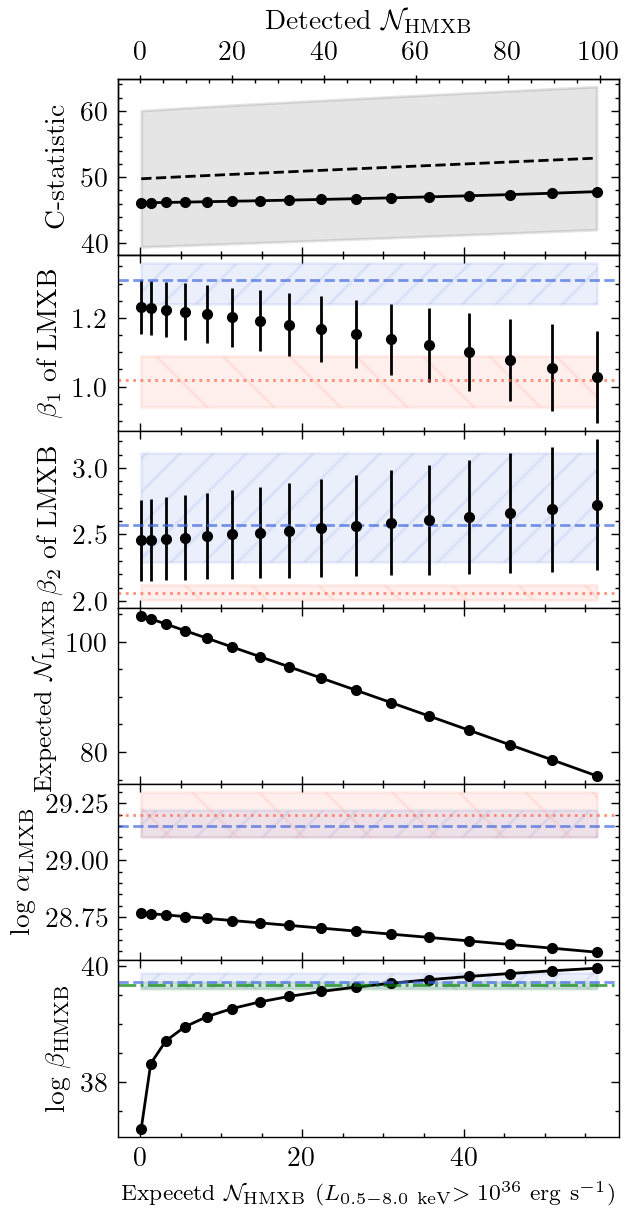

In [196]:
fig, (ax1, ax2, ax3,ax4,ax5,ax6) = plt.subplots(6, 1, sharex=True, gridspec_kw={'hspace': 0})

fig.set_figheight(3.35/4*1.5*5)
fig.set_figwidth(3.35)
# ax1.plot(expected_HMXB_number_list_0580,All_stat_list,'k.-')
ax1.set_ylabel('stat of fitting') 
ax1.plot(expected_HMXB_number_list_0580,np.array(C_list)-10,'k.-')
ax1.plot(expected_HMXB_number_list_0580,np.array(Ce_list)-4,'k--')
ax1.fill_between(expected_HMXB_number_list_0580,np.array(Ce_list)+np.sqrt(Cv_list)-4,np.array(Ce_list)-np.sqrt(Cv_list)-4,alpha=0.1,color='k')

# ax1.plot(expected_HMXB_number_list_0580,C19_list,'k.-')
# ax1.plot(expected_HMXB_number_list_0580,np.array(Ce19_list)-8,'k--')
# ax1.fill_between(expected_HMXB_number_list_0580,np.array(Ce19_list)+np.sqrt(Cv19_list)-8,np.array(Ce19_list)-np.sqrt(Cv19_list)-8,alpha=0.1,color='k')

# ax1.plot(expected_HMXB_number_list_0580,np.array(Ce19_list),'k--')
# ax1.fill_between(expected_HMXB_number_list_0580,np.array(Ce19_list)+np.sqrt(Cv19_list),np.array(Ce19_list)-np.sqrt(Cv19_list),alpha=0.1,color='k')

ax1.set_ylabel('C-statistic')

# A =0.1
# index = (cstat_collection_df['mode'] == 'True') & (cstat_collection_df['A'] == A)
# ax1.plot(expected_HMXB_number_list[0],np.mean(cstat_collection_df[index]['statval']),'rx')
# index = (cstat_collection_df['mode'] == 'Fake') & (cstat_collection_df['A'] == A)
# print(iteration,np.sum(index))
# # np.mean(cstat_collection_df[index]['statval']),np.std(cstat_collection_df[index]['statval'])
# # np.percentile((cstat_collection_df[index]['statval']),16),np.percentile((cstat_collection_df[index]['statval']),84)
# ax1.plot(expected_HMXB_number_list[0],np.mean(cstat_collection_df[index]['statval']),'kx')
# ax1.plot([expected_HMXB_number_list[0],expected_HMXB_number_list[0]],[np.percentile((cstat_collection_df[index]['statval']),16),np.percentile((cstat_collection_df[index]['statval']),84)],'k-',alpha=0.3)


ax2.errorbar(x=expected_HMXB_number_list_0580,y=All_LMXB_beta1_list,yerr=All_LMXB_beta1_max_list,fmt='.',color='k')
ax2.axhline(1.31,linestyle='--',color='royalblue',alpha=0.7)
ax2.fill_between(expected_HMXB_number_list_0580,np.ones(len(detected_HMXB_number_list))*1.31-0.07,np.ones(len(detected_HMXB_number_list))*1.31+0.05,alpha=0.1,hatch='//',color='royalblue')
ax2.axhline(1.02,linestyle=':',color='tomato',alpha=0.7)
ax2.fill_between(expected_HMXB_number_list_0580,np.ones(len(detected_HMXB_number_list))*1.02-0.08,np.ones(len(detected_HMXB_number_list))*1.02+0.07,alpha=0.1,hatch='\\',color='tomato')
ax2.set_ylabel(r'$\beta_1$ of LMXB') 
ax3.errorbar(x=expected_HMXB_number_list_0580,y=All_LMXB_beta2_list,yerr=All_LMXB_beta2_max_list,fmt='.',color='k')
ax3.set_ylabel(r'$\beta_2$ of LMXB') 
ax3.axhline(2.57,color='royalblue',linestyle='--',alpha=0.7)
ax3.fill_between(expected_HMXB_number_list_0580,np.ones(len(detected_HMXB_number_list))*2.57-0.28,np.ones(len(detected_HMXB_number_list))*2.57+0.54,alpha=0.1,hatch='//',color='royalblue')
ax3.axhline(2.06,color='tomato',linestyle=':',alpha=0.7)
ax3.fill_between(expected_HMXB_number_list_0580,np.ones(len(detected_HMXB_number_list))*2.06-0.05,np.ones(len(detected_HMXB_number_list))*2.06+0.06,alpha=0.1,hatch='\\',color='tomato')
# plt.errorbar(x=expected_HMXB_number_list_0580,y=All_LMXB_beta2_list,yerr=Disk_LMXB_beta2_max_list,fmt='.',color='tomato')
ax4.plot(expected_HMXB_number_list_0580,expected_LMXB_number_list,'k.-')
ax4.set_ylabel('Expected $\mathcal{N}_\mathrm{LMXB}$',fontsize=9)
ax5.plot(expected_HMXB_number_list_0580,np.log10(All_LMXB_Lx_list/np.max(XLF_Data_band['All']['mass_function'])/1e10),'k.-')
ax5.axhline(29.15,color='royalblue',linestyle='--',alpha=0.7)
ax5.fill_between(expected_HMXB_number_list_0580,np.ones(len(detected_HMXB_number_list))*29.15-0.05,np.ones(len(detected_HMXB_number_list))*29.15+0.07,alpha=0.1,hatch='//',color='royalblue')
ax5.axhline(29.2,color='tomato',linestyle=':',alpha=0.7)
ax5.fill_between(expected_HMXB_number_list_0580,np.ones(len(detected_HMXB_number_list))*29.2-0.1,np.ones(len(detected_HMXB_number_list))*29.2+0.1,alpha=0.1,hatch='\\',color='tomato')
ax5.set_ylabel(r'log $\alpha_\mathrm{LMXB}$')

ax6.plot(expected_HMXB_number_list_0580,np.log10(All_HMXB_Lx_list/np.max(XLF_Data_band['All']['SFR_function'])),'k.-')
ax6.axhline(39.73,color='royalblue',linestyle='--',alpha=0.7)
ax6.fill_between(expected_HMXB_number_list_0580,np.ones(len(detected_HMXB_number_list))*39.73-0.1,np.ones(len(detected_HMXB_number_list))*39.73+0.15,alpha=0.1,hatch='//',color='royalblue')
ax6.axhline(39.67,color='green',linestyle='dashdot',alpha=0.7)
ax6.fill_between(expected_HMXB_number_list_0580,np.ones(len(detected_HMXB_number_list))*39.67-0.06,np.ones(len(detected_HMXB_number_list))*39.67+0.06,alpha=0.1,hatch='\\',color='green')
ax6.set_ylabel(r'log $\beta_\mathrm{HMXB}$')
plt.xlabel('Expecetd $\mathcal{N}_\mathrm{HMXB}$ ($L_\mathrm{0.5-8.0~keV}\mathrm{>10^{36}~erg~s^{-1}}$)',fontsize=8)


ax1_top = ax1.twiny()
# ax1_top.spines['top'].set_position(('outward', 40))  # Move the top spine outward
# ax1_top.spines['top'].set_visible(True)  # Make sure the top spine is visible

# Sync the x-axis limits with the main x-axis
# ax1_top.set_xlim(ax1.get_xlim())

# Optionally, customize ticks and labels on the secondary x-axis
ax1_top.set_xlabel('Detected $\mathcal{N}_\mathrm{HMXB}$')
# ax1_top.set_xticks([1, 2, 3, 4, 5])  # Example custom ticks
# ax1_top.set_xticklabels(['A', 'B', 'C', 'D', 'E']) 
# ax1_top = ax1.twiny()
# ax1_top.set_xlim(ax1.get_xlim())  # Make sure the new x-axis range matches the original

# ax1_top.set_xticks(ax1.get_xticks()*(np.array(detected_HMXB_number_list)/np.array(expected_HMXB_number_list))[0])
# ax1_top.set_xbound(ax1.get_xbound()[0]*(np.array(detected_HMXB_number_list)/np.array(expected_HMXB_number_list))[0],ax1.get_xbound()[1]*(np.array(detected_HMXB_number_list)/np.array(expected_HMXB_number_list))[0])
# #     ax1_top.set_xticklabels(second_xtick_labels)
ax1_top.set_xlim([ax1.get_xlim()[0]*(np.array(detected_HMXB_number_list)/np.array(expected_HMXB_number_list_0580))[0],ax1.get_xlim()[1]*(np.array(detected_HMXB_number_list)/np.array(expected_HMXB_number_list_0580))[0]])
# ax1_top.set_xscale('log')
# ax1_top.set_xticks([1e35,1e36,1e37,1e38])
ax1_top.tick_params(axis='x', direction='inout', labeltop=True)

# plt.xlabel(r'$L\mathrm{_X~(erg~s^{-1})}$ at 761 kpc')


plt.tight_layout()
plt.savefig('figure/HMXB_expectation_ML6_0580_v2.pdf')
plt.show()
# plt.plot(detected_HMXB_number_list,np.array(expected_HMXB_number_list)/(np.array(expected_HMXB_number_list)+np.array(expected_LMXB_number_list)),'k.-')
# plt.errorbar(x=expected_HMXB_number_list_0580,y=All_LMXB_beta2_list,yerr=Disk_LMXB_beta2_max_list,fmt='.',color='tomato')
# plt.xlabel('detected HMXB number')
# plt.ylabel('stat of fitting')   




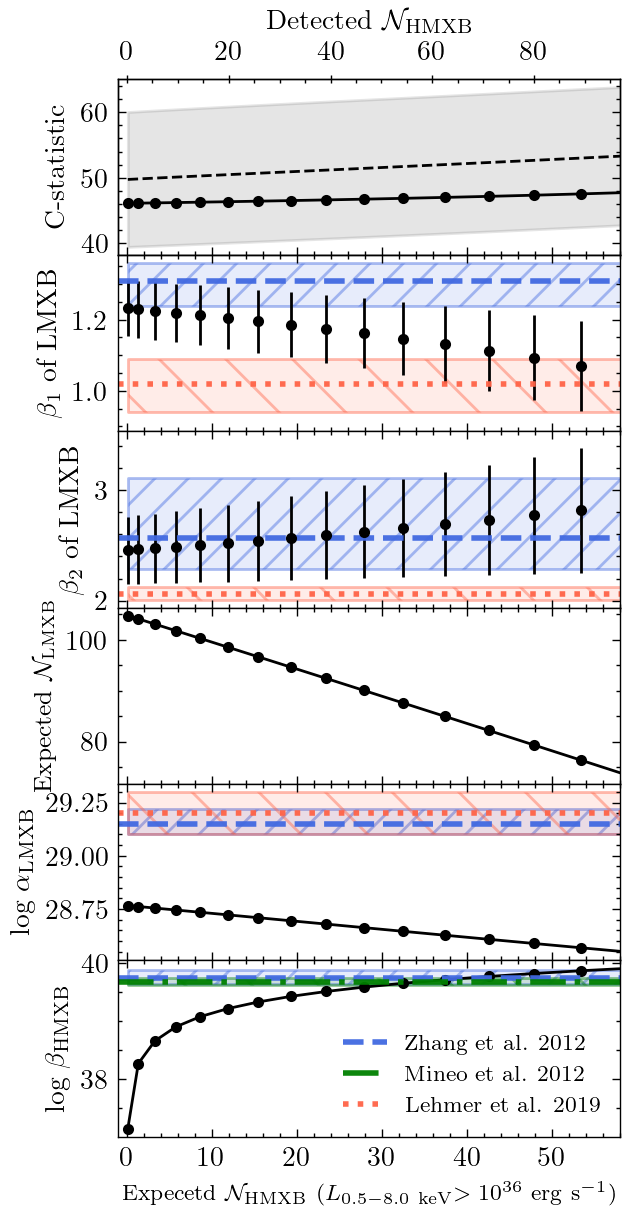

In [307]:
fig, (ax1, ax2, ax3,ax4,ax5,ax6) = plt.subplots(6, 1, sharex=True, gridspec_kw={'hspace': 0})

fig.set_figheight(3.35/4*1.5*5)
fig.set_figwidth(3.35)
# ax1.plot(expected_HMXB_number_list_0580,All_stat_list,'k.-')
ax1.set_ylabel('stat of fitting') 
ax1.plot(expected_HMXB_number_list_0580,np.array(C_list)-10,'k.-')
ax1.plot(expected_HMXB_number_list_0580,np.array(Ce_list)-4,'k--')
ax1.fill_between(expected_HMXB_number_list_0580,np.array(Ce_list)+np.sqrt(Cv_list)-4,np.array(Ce_list)-np.sqrt(Cv_list)-4,alpha=0.1,color='k')

# ax1.plot(expected_HMXB_number_list_0580,C19_list,'k.-')
# ax1.plot(expected_HMXB_number_list_0580,np.array(Ce19_list)-8,'k--')
# ax1.fill_between(expected_HMXB_number_list_0580,np.array(Ce19_list)+np.sqrt(Cv19_list)-8,np.array(Ce19_list)-np.sqrt(Cv19_list)-8,alpha=0.1,color='k')

# ax1.plot(expected_HMXB_number_list_0580,np.array(Ce19_list),'k--')
# ax1.fill_between(expected_HMXB_number_list_0580,np.array(Ce19_list)+np.sqrt(Cv19_list),np.array(Ce19_list)-np.sqrt(Cv19_list),alpha=0.1,color='k')

ax1.set_ylabel('C-statistic')

# A =0.1
# index = (cstat_collection_df['mode'] == 'True') & (cstat_collection_df['A'] == A)
# ax1.plot(expected_HMXB_number_list[0],np.mean(cstat_collection_df[index]['statval']),'rx')
# index = (cstat_collection_df['mode'] == 'Fake') & (cstat_collection_df['A'] == A)
# print(iteration,np.sum(index))
# # np.mean(cstat_collection_df[index]['statval']),np.std(cstat_collection_df[index]['statval'])
# # np.percentile((cstat_collection_df[index]['statval']),16),np.percentile((cstat_collection_df[index]['statval']),84)
# ax1.plot(expected_HMXB_number_list[0],np.mean(cstat_collection_df[index]['statval']),'kx')
# ax1.plot([expected_HMXB_number_list[0],expected_HMXB_number_list[0]],[np.percentile((cstat_collection_df[index]['statval']),16),np.percentile((cstat_collection_df[index]['statval']),84)],'k-',alpha=0.3)


ax2.errorbar(x=expected_HMXB_number_list_0580,y=All_LMXB_beta1_list,yerr=All_LMXB_beta1_max_list,fmt='.',color='k')
ax2.axhline(1.31,linestyle='--',color='royalblue',alpha=0.95,lw=2)
ax2.fill_between(expected_HMXB_number_list_0580,np.ones(len(detected_HMXB_number_list))*1.31-0.07,np.ones(len(detected_HMXB_number_list))*1.31+0.05,alpha=0.12,hatch='//',color='royalblue')
ax2.fill_between(expected_HMXB_number_list_0580,np.ones(len(detected_HMXB_number_list))*1.31-0.07,np.ones(len(detected_HMXB_number_list))*1.31+0.05,alpha=0.35,hatch='//',color='royalblue',facecolor='none')
ax2.axhline(1.02,linestyle=':',color='tomato',alpha=0.95,lw=2)
ax2.fill_between(expected_HMXB_number_list_0580,np.ones(len(detected_HMXB_number_list))*1.02-0.08,np.ones(len(detected_HMXB_number_list))*1.02+0.07,alpha=0.12,hatch='\\',color='tomato')
ax2.fill_between(expected_HMXB_number_list_0580,np.ones(len(detected_HMXB_number_list))*1.02-0.08,np.ones(len(detected_HMXB_number_list))*1.02+0.07,alpha=0.35,hatch='\\',color='tomato',facecolor='none')
ax2.set_ylabel(r'$\beta_1$ of LMXB') 
ax3.errorbar(x=expected_HMXB_number_list_0580,y=All_LMXB_beta2_list,yerr=All_LMXB_beta2_max_list,fmt='.',color='k')
ax3.set_ylabel(r'$\beta_2$ of LMXB') 
ax3.axhline(2.57,color='royalblue',linestyle='--',alpha=0.95,lw=2)
ax3.fill_between(expected_HMXB_number_list_0580,np.ones(len(detected_HMXB_number_list))*2.57-0.28,np.ones(len(detected_HMXB_number_list))*2.57+0.54,alpha=0.12,hatch='//',color='royalblue')
ax3.fill_between(expected_HMXB_number_list_0580,np.ones(len(detected_HMXB_number_list))*2.57-0.28,np.ones(len(detected_HMXB_number_list))*2.57+0.54,alpha=0.35,hatch='//',color='royalblue',facecolor='none')
ax3.axhline(2.06,color='tomato',linestyle=':',alpha=0.95,lw=2)
ax3.fill_between(expected_HMXB_number_list_0580,np.ones(len(detected_HMXB_number_list))*2.06-0.05,np.ones(len(detected_HMXB_number_list))*2.06+0.06,alpha=0.12,hatch='\\',color='tomato')
ax3.fill_between(expected_HMXB_number_list_0580,np.ones(len(detected_HMXB_number_list))*2.06-0.05,np.ones(len(detected_HMXB_number_list))*2.06+0.06,alpha=0.35,hatch='\\',color='tomato',facecolor='none')
# plt.errorbar(x=expected_HMXB_number_list_0580,y=All_LMXB_beta2_list,yerr=Disk_LMXB_beta2_max_list,fmt='.',color='tomato')
ax4.plot(expected_HMXB_number_list_0580,expected_LMXB_number_list,'k.-')
ax4.set_ylabel('Expected $\mathcal{N}_\mathrm{LMXB}$',fontsize=9)
ax5.plot(expected_HMXB_number_list_0580,np.log10(All_LMXB_Lx_list/np.max(XLF_Data_band['All']['mass_function'])/1e10),'k.-')
ax5.axhline(29.15,color='royalblue',linestyle='--',alpha=0.95,lw=2)
ax5.fill_between(expected_HMXB_number_list_0580,np.ones(len(detected_HMXB_number_list))*29.15-0.05,np.ones(len(detected_HMXB_number_list))*29.15+0.07,alpha=0.12,hatch='//',color='royalblue')
ax5.fill_between(expected_HMXB_number_list_0580,np.ones(len(detected_HMXB_number_list))*29.15-0.05,np.ones(len(detected_HMXB_number_list))*29.15+0.07,alpha=0.4,hatch='//',color='royalblue',facecolor='none')
ax5.axhline(29.2,color='tomato',linestyle=':',alpha=0.95,lw=2)
ax5.fill_between(expected_HMXB_number_list_0580,np.ones(len(detected_HMXB_number_list))*29.2-0.1,np.ones(len(detected_HMXB_number_list))*29.2+0.1,alpha=0.12,hatch='\\',color='tomato')
ax5.fill_between(expected_HMXB_number_list_0580,np.ones(len(detected_HMXB_number_list))*29.2-0.1,np.ones(len(detected_HMXB_number_list))*29.2+0.1,alpha=0.35,hatch='\\',color='tomato',facecolor='none')
ax5.set_ylabel(r'log $\alpha_\mathrm{LMXB}$')
# ax5.plot([],[],color='royalblue',linestyle='--',alpha=0.95,lw=2,label='Zhang et al. 2012')
# ax5.plot([],[],color='green',linestyle='dashdot',alpha=0.95,lw=2,label='Mineo et al. 2012')
# ax5.plot([],[],color='tomato',linestyle=':',alpha=0.95,lw=2,label='Lehmer et al. 2019')
# plt.legend(fontsize=8)


ax6.plot(expected_HMXB_number_list_0580,np.log10(All_HMXB_Lx_list/np.max(XLF_Data_band['All']['SFR_function'])),'k.-')
ax6.axhline(39.73,color='royalblue',linestyle='--',alpha=0.95,lw=2)
ax6.fill_between(expected_HMXB_number_list_0580,np.ones(len(detected_HMXB_number_list))*39.73-0.1,np.ones(len(detected_HMXB_number_list))*39.73+0.15,alpha=0.12,hatch='//',color='royalblue')
ax6.fill_between(expected_HMXB_number_list_0580,np.ones(len(detected_HMXB_number_list))*39.73-0.1,np.ones(len(detected_HMXB_number_list))*39.73+0.15,alpha=0.35,hatch='//',color='royalblue',facecolor='none')
ax6.axhline(39.67,color='green',linestyle='dashdot',alpha=0.95,lw=2)
ax6.fill_between(expected_HMXB_number_list_0580,np.ones(len(detected_HMXB_number_list))*39.67-0.06,np.ones(len(detected_HMXB_number_list))*39.67+0.06,alpha=0.12,hatch='\\',color='green')
ax6.fill_between(expected_HMXB_number_list_0580,np.ones(len(detected_HMXB_number_list))*39.67-0.06,np.ones(len(detected_HMXB_number_list))*39.67+0.06,alpha=0.35,hatch='\\',color='green',facecolor='none')
ax6.set_ylabel(r'log $\beta_\mathrm{HMXB}$')
plt.xlabel('Expecetd $\mathcal{N}_\mathrm{HMXB}$ ($L_\mathrm{0.5-8.0~keV}\mathrm{>10^{36}~erg~s^{-1}}$)',fontsize=8)



# ax6.fill_between([],[],[],alpha=0.15,hatch='//',color='royalblue',label='Zhang et al. 2012')
# ax6.fill_between([],[],[],alpha=0.15,hatch='\\',color='tomato',label='Lehmer et al. 2019')
# ax6.fill_between([],[],[],alpha=0.15,hatch='\\',color='green',label='Mineo et al. 2012')
ax6.plot([],[],color='royalblue',linestyle='--',alpha=0.95,lw=2,label='Zhang et al. 2012')
ax6.plot([],[],color='green',linestyle='dashdot',alpha=0.95,lw=2,label='Mineo et al. 2012')
ax6.plot([],[],color='tomato',linestyle=':',alpha=0.95,lw=2,label='Lehmer et al. 2019')
plt.legend(fontsize=8)
# ax6.set_yscale('log')
ax1.set_xlim(-1,58)


ax1_top = ax1.twiny()
# ax1_top.spines['top'].set_position(('outward', 40))  # Move the top spine outward
# ax1_top.spines['top'].set_visible(True)  # Make sure the top spine is visible

# Sync the x-axis limits with the main x-axis
# ax1_top.set_xlim(ax1.get_xlim())

# Optionally, customize ticks and labels on the secondary x-axis
ax1_top.set_xlabel('Detected $\mathcal{N}_\mathrm{HMXB}$')
# ax1_top.set_xticks([1, 2, 3, 4, 5])  # Example custom ticks
# ax1_top.set_xticklabels(['A', 'B', 'C', 'D', 'E']) 
# ax1_top = ax1.twiny()
# ax1_top.set_xlim(ax1.get_xlim())  # Make sure the new x-axis range matches the original

# ax1_top.set_xticks(ax1.get_xticks()*(np.array(detected_HMXB_number_list)/np.array(expected_HMXB_number_list))[0])
# ax1_top.set_xbound(ax1.get_xbound()[0]*(np.array(detected_HMXB_number_list)/np.array(expected_HMXB_number_list))[0],ax1.get_xbound()[1]*(np.array(detected_HMXB_number_list)/np.array(expected_HMXB_number_list))[0])
# #     ax1_top.set_xticklabels(second_xtick_labels)
ax1_top.set_xlim([ax1.get_xlim()[0]*(np.array(detected_HMXB_number_list)/np.array(expected_HMXB_number_list_0580))[0],ax1.get_xlim()[1]*(np.array(detected_HMXB_number_list)/np.array(expected_HMXB_number_list_0580))[0]])
# ax1_top.set_xscale('log')
# ax1_top.set_xticks([1e35,1e36,1e37,1e38])
ax1_top.tick_params(axis='x', direction='inout', labeltop=True)

# plt.xlabel(r'$L\mathrm{_X~(erg~s^{-1})}$ at 761 kpc')




plt.tight_layout()
plt.savefig('figure/HMXB_expectation_ML6_0580_v3.pdf')
plt.show()
# plt.plot(detected_HMXB_number_list,np.array(expected_HMXB_number_list)/(np.array(expected_HMXB_number_list)+np.array(expected_LMXB_number_list)),'k.-')
# plt.errorbar(x=expected_HMXB_number_list_0580,y=All_LMXB_beta2_list,yerr=Disk_LMXB_beta2_max_list,fmt='.',color='tomato')
# plt.xlabel('detected HMXB number')
# plt.ylabel('stat of fitting')   




In [197]:
ax1_top.set_xlim([ax1.get_xlim()[0]*(np.array(detected_HMXB_number_list)/np.array(expected_HMXB_number_list))[0],ax1.get_xlim()[1]*(np.array(detected_HMXB_number_list)/np.array(expected_HMXB_number_list))[0]])
# ax1.get_xlim()[0]

(-10.099339922370046, 219.95581867351464)

Text(0.5, 0, 'log $\\beta_\\mathrm{HMXB~(erg~s^{-1}~(M_{\\odot}~yr^-1)^{-1})}$')

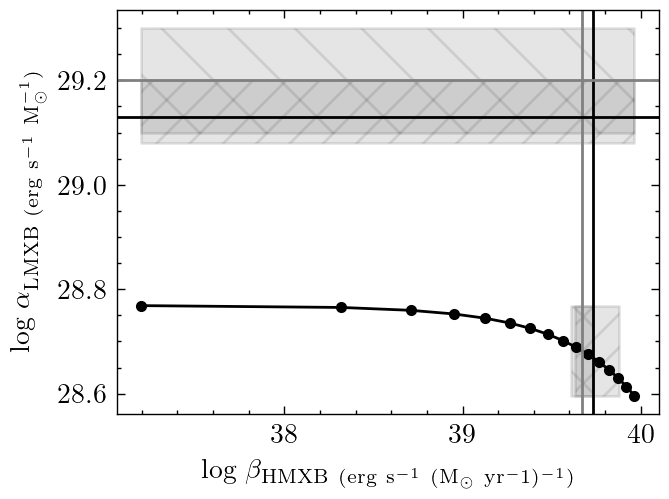

In [198]:
plt.plot(np.log10(All_HMXB_Lx_list/np.max(XLF_Data_band['All']['SFR_function'])),np.log10(All_LMXB_Lx_list/np.max(XLF_Data_band['All']['mass_function'])/1e10),'k.-')
plt.axvline(39.73,color='k')
plt.fill_betweenx(np.log10(All_LMXB_Lx_list/np.max(XLF_Data_band['All']['mass_function'])/1e10),np.ones(len(detected_HMXB_number_list))*39.73-0.1,np.ones(len(detected_HMXB_number_list))*39.73+0.15,alpha=0.1,hatch='//',color='k')
plt.axvline(39.67,color='grey')
plt.fill_betweenx(np.log10(All_LMXB_Lx_list/np.max(XLF_Data_band['All']['mass_function'])/1e10),np.ones(len(detected_HMXB_number_list))*39.67-0.06,np.ones(len(detected_HMXB_number_list))*39.67+0.06,alpha=0.1,hatch='\\',color='k')
plt.axhline(29.13,color='k')
plt.fill_between(np.log10(All_HMXB_Lx_list/np.max(XLF_Data_band['All']['SFR_function'])),np.ones(len(detected_HMXB_number_list))*29.13-0.05,np.ones(len(detected_HMXB_number_list))*29.13+0.07,alpha=0.1,hatch='//',color='k')
plt.axhline(29.2,color='grey')
plt.fill_between(np.log10(All_HMXB_Lx_list/np.max(XLF_Data_band['All']['SFR_function'])),np.ones(len(detected_HMXB_number_list))*29.2-0.1,np.ones(len(detected_HMXB_number_list))*29.2+0.1,alpha=0.1,hatch='\\',color='k')
plt.ylabel(r'log $\alpha_\mathrm{LMXB~(erg~s^{-1}~M_{\odot}^{-1})}$')
plt.xlabel(r'log $\beta_\mathrm{HMXB~(erg~s^{-1}~(M_{\odot}~yr^-1)^{-1})}$')


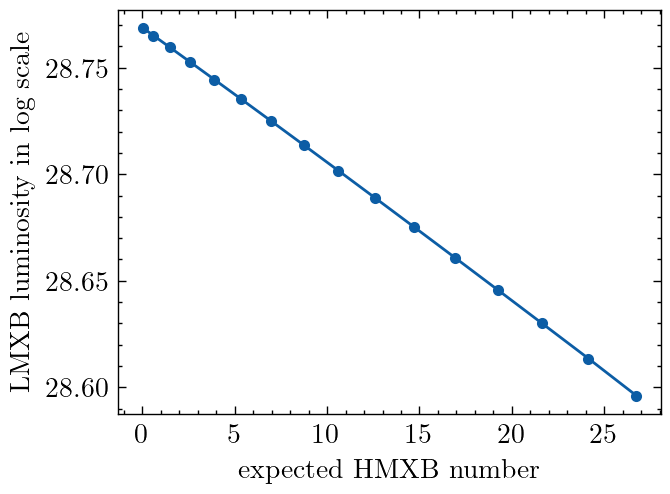

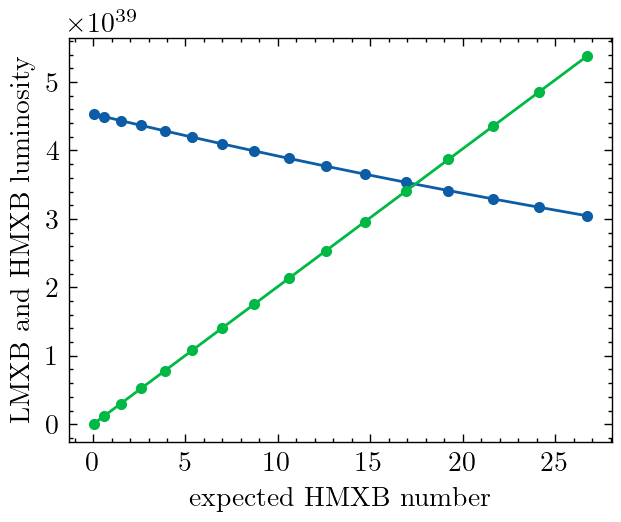

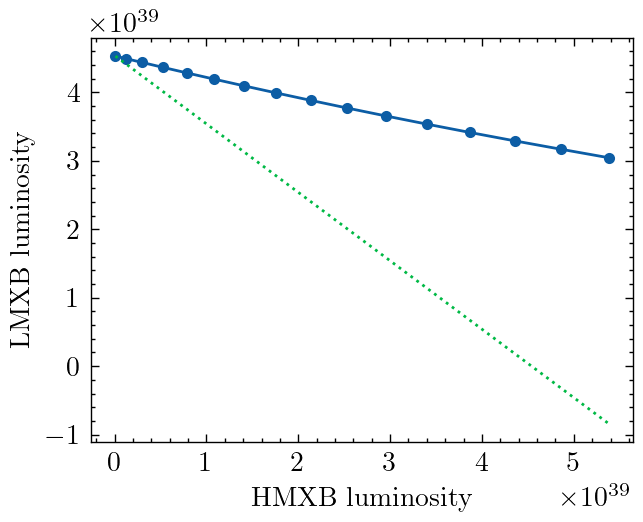

In [199]:
plt.plot(expected_HMXB_number_list,np.log10(All_LMXB_Lx_list/(np.max(XLF_Data_band['All']['mass_function'])*1e10)),'.-')
plt.ylabel('LMXB luminosity in log scale')
plt.xlabel('expected HMXB number')
plt.show()
plt.plot(expected_HMXB_number_list,(All_LMXB_Lx_list),'.-')
plt.plot(expected_HMXB_number_list,(All_HMXB_Lx_list),'.-')
plt.ylabel('LMXB and HMXB luminosity')
plt.xlabel('expected HMXB number')
plt.show()
plt.plot((All_HMXB_Lx_list),(All_LMXB_Lx_list),'.-')
plt.plot(np.array(All_HMXB_Lx_list),np.min(np.array(All_HMXB_Lx_list)+np.array(All_LMXB_Lx_list))-np.array(All_HMXB_Lx_list),':')
plt.ylabel('LMXB luminosity')
plt.xlabel('HMXB luminosity')
plt.show()


3.2802841158300446e+41


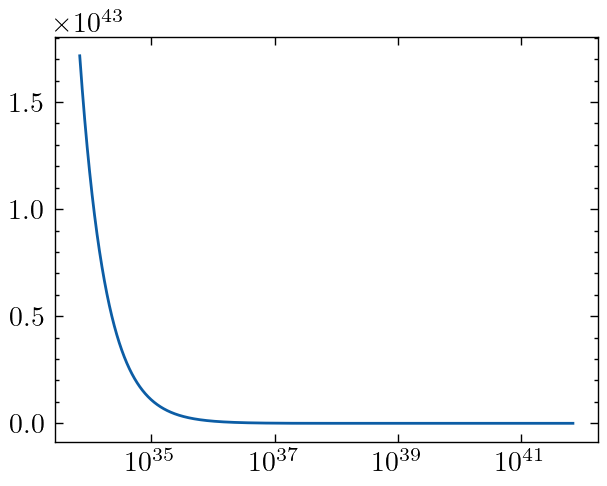

In [200]:
L = (4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*S_model
Lx = (4*np.pi*(761*u.kpc)**2).to(u.cm**2)*np.cumsum(S_model*(LMXB_model(S_model,para) * dS_model * np.max(XLF_Data_band[f'{region_label}']['mass_function']))[::-1])[::-1]
plt.plot(L,Lx)
plt.xscale('log')

L = (4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*S_model
Lx = (4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*np.cumsum(S_model*(LMXB_model(S_model,para) * dS_model * np.max(XLF_Data_band[f'{region_label}']['mass_function']))[::-1])[::-1]
print(Lx[L>1e36/3.1][0])


### the attemp of modelling disk with different HMXBs

Dataset               = 5
Method                = neldermead
Statistic             = cstat
Initial fit statistic = 50.8766
Final fit statistic   = 50.633 at function evaluation 429
Data points           = 102
Degrees of freedom    = 98
Probability [Q-value] = 0.999981
Reduced statistic     = 0.516664
Change in statistic   = 0.243596
   Disk_LMXB.K    4.24675     
   Disk_LMXB.beta1   1.35997     
   Disk_LMXB.beta2   2.6737      
   Disk_LMXB.fb   90.5772     
detected LMXB number 121.29044597583768
expected LMXB number 162.8382743400666
detected HMXB number 0.9193931053108155
expected HMXB number 1.6515761892303693
stat: 0.516663610394216
integrated LMXB luminosity (L2.0-4.5)>1e35 1.9448248881279873e+42
integrated HMXB luminosity (L2.0-4.5)>1e35 2.3861850729894313e+40
integrated converted LMXB luminosity (L0.5-8)>1e36 1.2255776818027528e+42
integrated converted HMXB luminosity (L0.5-8)>1e36 1.1355314099500672e+40
Dataset               = 5
Confidence Method     = covariance
Iterative F

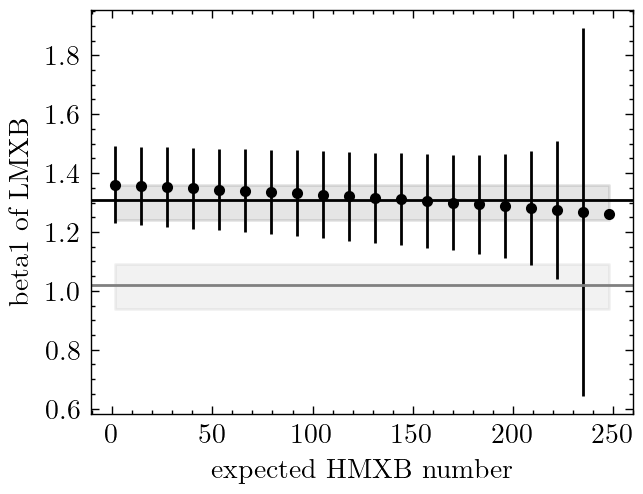

In [201]:
region_label = 'Disk'
i = 4

def HMXB_model(x,para):
        return cutoff_power_law(x,para[11:16])
    
# for iteration,A in enumerate(np.logspace(-1.0,1.3,6)):
expected_HMXB_number_list = []
Disk_LMXB_beta1_list = []
Disk_LMXB_beta2_list = []
Disk_LMXB_K_list = []
Disk_LMXB_beta1_max_list = []
Disk_LMXB_beta1_min_list = []
Disk_LMXB_beta2_max_list = []
Disk_LMXB_beta2_min_list = []
Disk_LMXB_Lx_list = []
Disk_HMXB_Lx_list = []
for iteration,A in enumerate(np.linspace(0.1,15,20)):
    Disk_HMXB.A  = A
    Disk_HMXB.A.freeze()
    Disk_LMXB.thaw()
    Disk_LMXB.cutoff = 0
    Disk_LMXB.cutoff.freeze()
    ui.fit(i+1)
    exec(f"""para= tuple([i.val for i in {region_label}_source_model.pars])""")

    
    detected_LMXB_number = np.sum((LMXB_model(S_model,para) * dS_model * XLF_Data_band[f'{region_label}']['mass_function']))
    expected_LMXB_number = np.cumsum((LMXB_model(S_model,para) * dS_model * np.max(XLF_Data_band[f'{region_label}']['mass_function']))[::-1])[::-1][S_model>1e-15][0]
    print('detected LMXB number',detected_LMXB_number)
    print('expected LMXB number',expected_LMXB_number)   
    detected_HMXB_number = np.sum((HMXB_model(S_model,para) * dS_model * XLF_Data_band[f'{region_label}']['sky_area_function']))
    expected_HMXB_number = np.cumsum((HMXB_model(S_model,para) * dS_model * np.max(XLF_Data_band[f'{region_label}']['sky_area_function']))[::-1])[::-1][S_model>1e-15][0]
    print('detected HMXB number',detected_HMXB_number)
    print('expected HMXB number',expected_HMXB_number) 
    print('stat:',ui.get_stat_info()[4].rstat)

    L = (4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*S_model
    Lx = (4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*np.cumsum(S_model*(LMXB_model(S_model,para) * dS_model * np.max(XLF_Data_band[f'{region_label}']['mass_function']))[::-1])[::-1]
    print('integrated LMXB luminosity (L2.0-4.5)>1e35',Lx[L>1e35][0])
    Lx = (4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*np.cumsum(S_model*(HMXB_model(S_model,para) * dS_model * np.max(XLF_Data_band[f'{region_label}']['sky_area_function']))[::-1])[::-1]
    print('integrated HMXB luminosity (L2.0-4.5)>1e35',Lx[L>1e35][0])
    L = 3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*S_model
    Lx = 3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*np.cumsum(S_model*(LMXB_model(S_model,para) * dS_model * np.max(XLF_Data_band[f'{region_label}']['mass_function']))[::-1])[::-1]
    print('integrated converted LMXB luminosity (L0.5-8)>1e36',Lx[L>1e36][0])
    Disk_LMXB_Lx_list.append(Lx[L>1e36][0])
    Lx = 3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*np.cumsum(S_model*(HMXB_model(S_model,para) * dS_model * np.max(XLF_Data_band[f'{region_label}']['sky_area_function']))[::-1])[::-1]
    print('integrated converted HMXB luminosity (L0.5-8)>1e36',Lx[L>1e36][0])
    Disk_HMXB_Lx_list.append(Lx[L>1e36][0])
    print('=='*20)

    # plt.plot(expected_HMXB_number,Disk_LMXB.beta1.val,'kx')
    # plt.plot(expected_HMXB_number,Disk_LMXB.beta2.val,'kx',alpha=0.4)
    expected_HMXB_number_list.append(expected_HMXB_number)
    Disk_LMXB_beta1_list.append(Disk_LMXB.beta1.val)
    Disk_LMXB_beta2_list.append(Disk_LMXB.beta2.val)
    Disk_LMXB_K_list.append(Disk_LMXB.K.val)
    Disk_LMXB.fb.freeze()
    ui.covar(i+1,Disk_LMXB.beta1)
    if ui.get_covar_results().parmaxes[0] is None:
        Disk_LMXB_beta1_max_list.append(np.nan)
    else:
        Disk_LMXB_beta1_max_list.append(ui.get_covar_results().parmaxes[0])
    if ui.get_covar_results().parmins[0] is None:
        Disk_LMXB_beta1_min_list.append(np.nan)
    else:
        Disk_LMXB_beta1_min_list.append(ui.get_covar_results().parmins[0])
    ui.covar(i+1,Disk_LMXB.beta2)
    if ui.get_covar_results().parmaxes[0] is None:
        Disk_LMXB_beta2_max_list.append(np.nan)
    else:
        Disk_LMXB_beta2_max_list.append(ui.get_covar_results().parmaxes[0])
    if ui.get_covar_results().parmins[0] is None:
        Disk_LMXB_beta2_min_list.append(np.nan)
    else:
        Disk_LMXB_beta2_min_list.append(ui.get_covar_results().parmins[0])


Disk_LMXB_beta1_max_list = np.array(Disk_LMXB_beta1_max_list)
Disk_LMXB_beta1_min_list = np.array(Disk_LMXB_beta1_min_list)
Disk_LMXB_beta1_list = np.array(Disk_LMXB_beta1_list)
Disk_LMXB_beta2_max_list = np.array(Disk_LMXB_beta2_max_list)
Disk_LMXB_beta2_min_list = np.array(Disk_LMXB_beta2_min_list)

# plt.plot(expected_HMXB_number_list,Disk_LMXB_beta1_list,'.-')
# plt.plot(expected_HMXB_number_list,Disk_LMXB_beta2_list,'.-')
plt.errorbar(x=expected_HMXB_number_list,y=Disk_LMXB_beta1_list,yerr=Disk_LMXB_beta1_max_list,fmt='.',color='k')
# plt.errorbar(x=expected_HMXB_number_list,y=All_LMXB_beta2_list,yerr=Disk_LMXB_beta2_max_list,fmt='.',color='tomato')
plt.xlabel('expected HMXB number')
plt.ylabel('beta1 of LMXB')   

plt.axhline(1.31,color='k')
plt.fill_between(expected_HMXB_number_list,np.ones(len(expected_HMXB_number_list))*1.31-0.07,np.ones(len(expected_HMXB_number_list))*1.31+0.05,alpha=0.1,color='k')

# plt.axhline(2.57,color='tomato')
# plt.fill_between(expected_HMXB_number_list,np.ones(len(expected_HMXB_number_list))*2.57-0.28,np.ones(len(expected_HMXB_number_list))*2.57+0.54,alpha=0.1,color='tomato')


plt.axhline(1.02,color='grey')
plt.fill_between(expected_HMXB_number_list,np.ones(len(expected_HMXB_number_list))*1.02-0.08,np.ones(len(expected_HMXB_number_list))*1.02+0.07,alpha=0.1,color='grey')

# plt.axhline(2.06,color='pink')
# plt.fill_between(expected_HMXB_number_list,np.ones(len(expected_HMXB_number_list))*2.06-0.05,np.ones(len(expected_HMXB_number_list))*2.06+0.06,alpha=0.1,color='pink')




### figure summary

In [202]:
from IPython.display import display, HTML


image_filenames =   sorted(glob.glob('figure/XLF_fitting_*_v6.0_LMXB.png'))
                  
print(image_filenames)

# Generate JavaScript code to embed images in a row
javascript_code = '<div style="display:flex; flex-direction:row;">'
for filename in image_filenames:
    javascript_code += f'<img src="{filename}" style="width:195px; height:350px; margin: 0px;">'
javascript_code += '</div>'

# Display the JavaScript code
display(HTML(javascript_code))



['figure/XLF_fitting_Arm2_RegionV4_v6.0_LMXB.png', 'figure/XLF_fitting_Arm2_v6.0_LMXB.png', 'figure/XLF_fitting_Back_RegionV3.2_SrcV2_Scut2e-13_v6.0_LMXB.png', 'figure/XLF_fitting_Back_RegionV3.2_SrcV2_v6.0_LMXB.png', 'figure/XLF_fitting_Back_RegionV3.2_v6.0_LMXB.png', 'figure/XLF_fitting_Back_RegionV4_v6.0_LMXB.png', 'figure/XLF_fitting_Back_v6.0_LMXB.png', 'figure/XLF_fitting_Center_RegionV3.2_SrcV2_Scut2e-13_v6.0_LMXB.png', 'figure/XLF_fitting_Center_RegionV3.2_SrcV2_v6.0_LMXB.png', 'figure/XLF_fitting_Center_RegionV3.2_v6.0_LMXB.png', 'figure/XLF_fitting_Center_RegionV4_v6.0_LMXB.png', 'figure/XLF_fitting_Center_v6.0_LMXB.png', 'figure/XLF_fitting_Disk_RegionV3.2_SrcV2_Scut2e-13_v6.0_LMXB.png', 'figure/XLF_fitting_Disk_RegionV3.2_SrcV2_v6.0_LMXB.png', 'figure/XLF_fitting_Disk_RegionV3.2_v6.0_LMXB.png', 'figure/XLF_fitting_Disk_RegionV4_v6.0_LMXB.png', 'figure/XLF_fitting_Disk_v6.0_LMXB.png', 'figure/XLF_fitting_InnerArm_RegionV3.2_SrcV2_Scut2e-13_v6.0_LMXB.png', 'figure/XLF_fitting

## subtract the background to highlight the LMXBs

In [203]:
## calculate the X-ray luminosity

# XLF_Data_band['Center']['StellarMass'] = 25.872/10
# XLF_Data_band['Disk']['StellarMass'] = 25.172/10
# XLF_Data_band['Arm2']['StellarMass'] = 9.469/10
# # XLF_Data_band['Arm015']['StellarMass'] = 10.412/10
# XLF_Data_band['Arm152']['StellarMass'] = 3.217/10
# ####
# XLF_Data_band['Center']['StellarMass'] = 27.903/10
# XLF_Data_band['Disk']['StellarMass'] = 46.620/10
# XLF_Data_band['Arm2']['StellarMass'] = 12.234/10
# # XLF_Data_band['Arm015']['StellarMass'] = 13.422/10
# XLF_Data_band['Arm152']['StellarMass'] = 4.284/10


for i,region_label in enumerate(['Back','North','South','Center','Disk','Ring','InnerArm','InterArm',]):
    print(i+1,region_label)
    m = i+1
    if m not in [4,5,6,7,8,]:
        continue
    if region_label=='Back' or region_label=='North' or region_label=='South':
        def model(x,para):
            return brokenpl_dN(x,para[0:4])+power_law(x,para[4:])
    elif region_label=='Center':
        def model(x,para):
            return brokenpl_dN(x,para[0:4])+power_law(x,para[4:6])+cutoff_brokenpl_dN(x,para[6:11])
        def model_LMXB(x,para):
            return cutoff_brokenpl_dN(x,para[6:11])    
    else:
        def model(x,para):
            return brokenpl_dN(x,para[0:4])+power_law(x,para[4:6])+cutoff_brokenpl_dN(x,para[6:11])+cutoff_power_law(x,para[11:16])
        def model_LMXB(x,para):
            return cutoff_brokenpl_dN(x,para[6:11])
        def model_HMXB(x,para):
            return cutoff_power_law(x,para[11:16])

        
    exec(f"""para= tuple([i.val for i in {region_label}_source_model.pars])""")
    # exec(f"""print({region_label}_source_model)""")
    exec(f"""model_dN = model(S_model,para) * dS_model * XLF_Data_band['{region_label}']['sky_area_function']""")
    exec(f"""model_dS = model_LMXB(S_model,para) * S_model * dS_model * np.nanmax(XLF_Data_band['{region_label}']['sky_area_function'])""")
    StellarMass = XLF_Data_band[region_label]['StellarMass']
    print(f'LMXB: {np.sum(model_dS):.2e}, {flux2luminosity(np.sum(model_dS)):.2e}')    
    print(f'LMXB per 10^10 M_*: {np.log10(np.sum(model_dS)/StellarMass/1e10):.2f}, {np.log10(flux2luminosity(np.sum(model_dS))/StellarMass/1e10):.2f}')    
    print(f'LMXB per 10^10 M_* (x3.14 for energy band): {3.124*np.log10(np.sum(model_dS)/StellarMass/1e10):.2f}, {np.log10(3.124*flux2luminosity(np.sum(model_dS))/StellarMass/1e10):.2f}')    
    if region_label!='Center':
        exec(f"""model_dS = model_HMXB(S_model,para) * S_model * dS_model * np.nanmax(XLF_Data_band['{region_label}']['sky_area_function'])""")
        print(f'HMXB: {np.sum(model_dS):.2e}, {flux2luminosity(np.sum(model_dS)):.2e}',)    
        print(f'HMXB per 10^10 M_*: {np.log10(np.sum(model_dS)/StellarMass/1e10):.2f}, {np.log10(flux2luminosity(np.sum(model_dS))/StellarMass/1e10):.2f}')    
        print(f'HMXB per 10^10 M_* (x3.14 for energy band): {3.124*np.log10(np.sum(model_dS)/StellarMass/1e10):.2f}, {np.log10(3.124*flux2luminosity(np.sum(model_dS))/StellarMass/1e10):.2f}')    
    

1 Back
2 North
3 South
4 Center
LMXB: 1.58e-13, 1.10e+37
LMXB per 10^10 M_*: -23.10, 26.74
LMXB per 10^10 M_* (x3.14 for energy band): -72.16, 27.24
5 Disk
LMXB: 4.35e-12, 3.01e+38
LMXB per 10^10 M_*: -22.17, 27.67
LMXB per 10^10 M_* (x3.14 for energy band): -69.27, 28.16
HMXB: 2.34e-10, 1.62e+40
HMXB per 10^10 M_*: -20.44, 29.40
HMXB per 10^10 M_* (x3.14 for energy band): -63.86, 29.89
6 Ring
LMXB: 8.20e-13, 5.68e+37
LMXB per 10^10 M_*: -22.41, 27.43
LMXB per 10^10 M_* (x3.14 for energy band): -70.01, 27.92
HMXB: 0.00e+00, 0.00e+00
HMXB per 10^10 M_*: -inf, -inf
HMXB per 10^10 M_* (x3.14 for energy band): -inf, -inf
7 InnerArm
LMXB: 1.43e-13, 9.89e+36
LMXB per 10^10 M_*: -23.10, 26.74
LMXB per 10^10 M_* (x3.14 for energy band): -72.18, 27.23
HMXB: 0.00e+00, 0.00e+00
HMXB per 10^10 M_*: -inf, -inf
HMXB per 10^10 M_* (x3.14 for energy band): -inf, -inf
8 InterArm
LMXB: 3.24e-12, 2.25e+38
LMXB per 10^10 M_*: -21.76, 28.08
LMXB per 10^10 M_* (x3.14 for energy band): -67.99, 28.57
HMXB: 0.

(((usermodel.All_AGN + usermodel.All_star) + usermodel.All_LMXB) + usermodel.All_HMXB)
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   All_AGN.K    linked        129.3         expr: Back_AGN.K           
   All_AGN.beta1 linked      2.00112     expr: Back_AGN.beta1           
   All_AGN.beta2 linked       2.9308     expr: Back_AGN.beta2           
   All_AGN.fb   linked      1.92319        expr: Back_AGN.fb           
   All_star.A   linked            0        expr: Back_star.A           
   All_star.alpha linked            0    expr: Back_star.alpha           
   All_LMXB.K   thawed      2.89894         0.01           70           
   All_LMXB.beta1 thawed      1.02809          0.1            3           
   All_LMXB.beta2 thawed      2.72275          1.5            6           
   All_LMXB.fb  frozen      29.1774           10          150           
   All_LMXB.cutoff frozen     -9.33

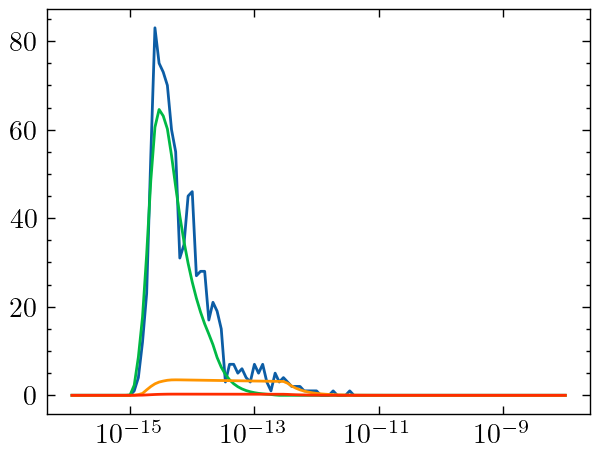

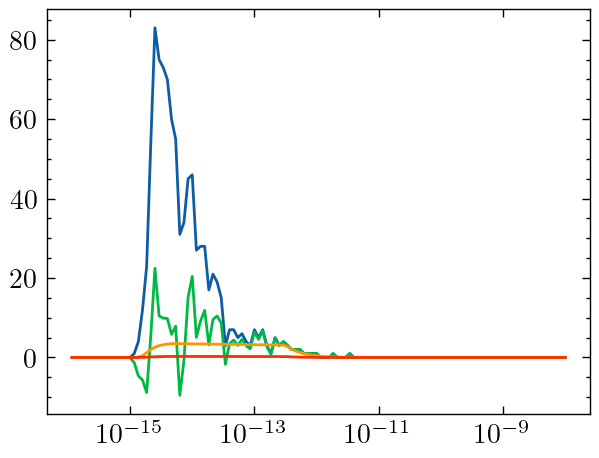

In [204]:
i = 8
region_label = 'All'
m = i+1

# ui.thaw(Back_AGN)
# ui.fit(1,9)

XLF_Data_band_region = XLF_Data_band[f'{region_label}']

def model(x,para):
    return brokenpl_dN(x,para[0:4])+power_law(x,para[4:6])#+cutoff_power_law(x,para[11:16]) #+cutoff_brokenpl_dN(x,para[6:11])
def LMXB_model(x,para):
    return cutoff_brokenpl_dN(x,para[6:11])
def HMXB_model(x,para):
    return cutoff_power_law(x,para[11:16])

exec(f"""para= tuple([i.val for i in {region_label}_source_model.pars])""")
exec(f"""print({region_label}_source_model)""")


exec(f"""model_dN = model(S_model,para) * dS_model * XLF_Data_band['{region_label}']['sky_area_function'] + LMXB_model(S_model,para) * dS_model * XLF_Data_band['{region_label}']['mass_function'] + HMXB_model(S_model,para) * dS_model * XLF_Data_band['{region_label}']['SFR_function']""")

# plt.plot(S_model,XLF_Data_band_region['dN_InSmallBin'])

def rebin_data(model_dN_corr):
    rebin_indices = np.floor(np.arange(len(model_dN_corr)) / expanded_times).astype(int)
    new_model_dN_corr = np.bincount(rebin_indices, weights=model_dN_corr)
    return new_model_dN_corr

plt.plot(data_bins[1:],rebin_data(XLF_Data_band_region['dN_InSmallBin']))    
AGN_model_dN = model(S_model,para) * dS_model * XLF_Data_band_region['sky_area_function']
plt.plot(data_bins[1:],rebin_data(AGN_model_dN))
LMXB_model_dN = LMXB_model(S_model,para) * dS_model * XLF_Data_band_region['mass_function']
plt.plot(data_bins[1:],rebin_data(LMXB_model_dN))
SFR_model_dN = LMXB_model(S_model,para) * dS_model * XLF_Data_band_region['SFR_function']
plt.plot(data_bins[1:],rebin_data(SFR_model_dN))
plt.xscale('log')
plt.show()


plt.plot(data_bins[1:],rebin_data(XLF_Data_band_region['dN_InSmallBin']))    
AGN_model_dN = model(S_model,para) * dS_model * XLF_Data_band_region['sky_area_function']
# plt.plot(data_bins[1:],rebin_data(AGN_model_dN))
plt.plot(data_bins[1:],rebin_data(XLF_Data_band_region['dN_InSmallBin'])-rebin_data(AGN_model_dN))    
LMXB_model_dN = LMXB_model(S_model,para) * dS_model * XLF_Data_band_region['mass_function']
plt.plot(data_bins[1:],rebin_data(LMXB_model_dN))
SFR_model_dN = LMXB_model(S_model,para) * dS_model * XLF_Data_band_region['SFR_function']
plt.plot(data_bins[1:],rebin_data(SFR_model_dN))
plt.xscale('log')
plt.show()

In [205]:
Center_HMXB.A = All_HMXB.A
InnerArm_HMXB.A = All_HMXB.A
InterArm_HMXB.A = All_HMXB.A
InterArm_HMXB.A = All_HMXB.A
Ring_HMXB.A = All_HMXB.A
All_HMXB.A = 11

ui.fit(4)
ui.fit(6)
ui.fit(7)
ui.fit(8)

Dataset               = 4
Method                = neldermead
Statistic             = cstat
Initial fit statistic = 64.1263
Final fit statistic   = 64.1127 at function evaluation 395
Data points           = 102
Degrees of freedom    = 98
Probability [Q-value] = 0.996786
Reduced statistic     = 0.654212
Change in statistic   = 0.0135858
   Center_LMXB.K   9.22117     
   Center_LMXB.beta1   1.06788     
   Center_LMXB.beta2   3.49172     
   Center_LMXB.fb   25.1541     
Dataset               = 6
Method                = neldermead
Statistic             = cstat
Initial fit statistic = 57.9898
Final fit statistic   = 57.1461 at function evaluation 512
Data points           = 103
Degrees of freedom    = 99
Probability [Q-value] = 0.999761
Reduced statistic     = 0.577234
Change in statistic   = 0.843675
   Ring_LMXB.K    0.300712    
   Ring_LMXB.beta1   0.358953    
   Ring_LMXB.beta2   3.5005      
   Ring_LMXB.fb   45.4588     
Dataset               = 7
Method                = neldermead

1 Center
Dataset               = 4
Method                = neldermead
Statistic             = cstat
Initial fit statistic = 63.8614
Final fit statistic   = 63.8149 at function evaluation 390
Data points           = 102
Degrees of freedom    = 98
Probability [Q-value] = 0.997052
Reduced statistic     = 0.651172
Change in statistic   = 0.0464992
   Center_LMXB.K   9.49661     
   Center_LMXB.beta1   1.07605     
   Center_LMXB.beta2   3.47121     
   Center_LMXB.fb   25.1784     
integrated converted luminosity (L0.5-8)>1e36 1.970096284620488e+36
integrated converted LMXB luminosity (L0.5-8)>1e36 8.477058046581394e+41
mass: 1.9830265192599978
SFR: 0.04827974669556436
Dataset               = 4
Method                = neldermead
Statistic             = cstat
Initial fit statistic = 63.8149
Final fit statistic   = 63.8149 at function evaluation 390
Data points           = 102
Degrees of freedom    = 98
Probability [Q-value] = 0.997052
Reduced statistic     = 0.651172
Change in statistic   =

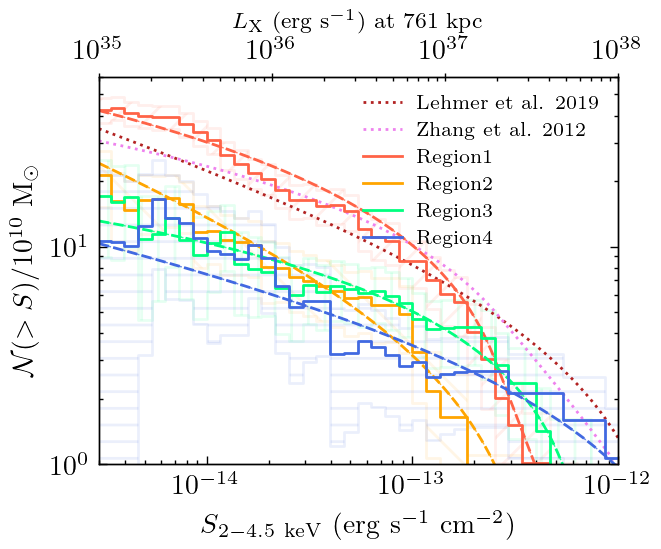

In [206]:


def model(x,para):
    return brokenpl_dN(x,para[0:4])+power_law(x,para[4:6])#+cutoff_power_law(x,para[11:16]) #+cutoff_brokenpl_dN(x,para[6:11])
def LMXB_model(x,para):
    return cutoff_brokenpl_dN(x,para[6:11])
def HMXB_model(x,para):
    return cutoff_power_law(x,para[11:16])
def rebin_data(model_dN_corr):
    rebin_indices = np.floor(np.arange(len(model_dN_corr)) / expanded_times).astype(int)
    new_model_dN_corr = np.bincount(rebin_indices, weights=model_dN_corr)
    return new_model_dN_corr

plt.figure(figsize=(3.35,3.35/4*3))
ax1 = plt.subplot(111)

L_bin = np.logspace(34,41,9001)
L = np.sqrt(L_bin[1:]*L_bin[:-1])
dL = L_bin[1:]-L_bin[:-1]
def brokenpldNdL(L, K,beta1, beta2, fb):
    dNdL = K*(L)**(-beta1)
    index = L> fb
    dNdL[index] = K*(fb)**(beta2-beta1)* (L[index])**(-beta2)
    return dNdL

def brokenpldNdL_Zhang(L, K,beta1, beta2, beta3, Lb1,Lb2, Lc):
    dNdL = K*(L/Lb1)**(-beta1)
    
    index = (L >= Lb1) & (L < Lb2)
    dNdL[index] =  K*(Lb1/Lb2)**(beta2) * (L[index]/Lb2)**(-beta2)
    
    index = (L >= Lb2) & (L < Lc)
    dNdL[index] = K*(Lb1/Lb2)**(beta2)*(Lb2/Lc)**(beta3) * (L[index]/Lc)**(-beta3)

    index = L>=Lc
    dNdL[index] = 0
    
    return dNdL



plt.plot(luminosity2flux(L)/3.1,cumsum_reverse(brokenpldNdL(L/1e38,2.6,1.31,2.57,2.16)*(dL/1e38)),color='firebrick',ls=':',label='Lehmer et al. 2019')
plt.plot(luminosity2flux(L)/3.1,cumsum_reverse(brokenpldNdL_Zhang(L/1e36,0.101,1.02,2.06,3.63,54.6,599,5e4)*(dL/1e36)),color='violet',ls=':',label='Zhang et al. 2012')
# plt.plot(luminosity2flux(L)/3.1,cumsum_reverse(brokenpldNdL(L/1e38,4.15,1.02,2.06,0.546)*(dL/1e38)),color='violet',ls=':',label='Zhang et al. 2012')


# for i,region_label in enumerate(['Back','North','South','Center','Disk','Ring','InnerArm','InterArm','All']):
for i,region_label in enumerate(['Center','InnerArm','Ring','InterArm',]):
    print(i+1,region_label)
    # m = i+1
    # if m not in [4,6,7,8]:
    #     continue
    # i = 8
    # region_label = 'All'
    # m = i+1

    if region_label == "Back":
        label = 'Background'
    elif region_label == "Ring":
        label = 'Region3: Ring'
        label = 'Region3'
        All_HMXB.A = 0 #11
        ui.fit(6)

    elif region_label == "Center":
        label = 'Region1: Center'
        label = 'Region1'
        All_HMXB.A = 0 #11
        ui.fit(4)

    elif region_label == "InnerArm":
        label = 'Region2: InnerArm'
        label = 'Region2'
        All_HMXB.A = 0 #11
        ui.fit(7)

    elif region_label == "InterArm":
        label = 'Region4: InterArm'
        label = 'Region4'
        All_HMXB.A = 0 #11
        ui.fit(8)
    else:
        label = region_label

        print(i+1,region_label,label)
    if region_label =='Center' or region_label =='Center_rmGlC':
        color='tomato'
    elif region_label =='Disk' or region_label =='Disk_rmGlC':
        color= icefire[4]
    elif region_label =='Ring' or region_label =='Ring_rmGlC':
        color='springgreen' # 'purple'
    elif region_label =='InnerArm' or region_label =='InnerArm_rmGlC':
        color='orange'
    elif region_label =='InterArm' or region_label =='InterArm_rmGlC':
        color= 'royalblue' #'royalblue'
    elif region_label =='Inner' or region_label =='Inner_rmGlC':
        color=icefire[6] #'purple'
    elif region_label =='Outer' or region_label =='Outer_rmGlC':
        color=icefire[0] #'cyan'
    if '_rmGlC' in region_label:
        alpha=0.5
    else:
        alpha=1.0
        
    XLF_Data_band_region = XLF_Data_band[f'{region_label}']
    exec(f"""para= tuple([i.val for i in {region_label}_source_model.pars])""")
    
    #     AGN_model_dN = model(S_model,para) * dS_model * XLF_Data_band_region['sky_area_function']
    # else:
    HMXB_model_dN = HMXB_model(S_model,para) * dS_model * XLF_Data_band_region['SFR_function']
    AGN_model_dN = HMXB_model_dN+model(S_model,para) * dS_model * XLF_Data_band_region['sky_area_function']

    L = 3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*S_model
    YY = (np.cumsum(((dS_model*(XLF_Data_band_region['dN_InSmallBin']-AGN_model_dN)/XLF_Data_band_region['mass_function']))[::-1])[::-1])
    Lx = 3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value* YY  * np.max(XLF_Data_band[f'{region_label}']['mass_function'])
    print('integrated converted luminosity (L0.5-8)>1e36',Lx[L>1e36][0])
    Lx = 3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*np.cumsum(S_model*(LMXB_model(S_model,para) * dS_model * np.max(XLF_Data_band[f'{region_label}']['mass_function']))[::-1])[::-1]
    print('integrated converted LMXB luminosity (L0.5-8)>1e36',Lx[L>1e36][0])
    print('mass:', np.max(XLF_Data_band[f'{region_label}']['mass_function']))
    print('SFR:', np.max(XLF_Data_band[f'{region_label}']['SFR_function']))
    # plt.plot(S_model[S_model>XLF_Data_band_region['cutoff_sensitivity']],(np.cumsum(((XLF_Data_band_region['dN_InSmallBin']-AGN_model_dN)/XLF_Data_band_region['mass_function'])[::-1])[::-1])[S_model>XLF_Data_band_region['cutoff_sensitivity']],color=color,alpha=alpha,label=label)
    # plt.step(data_bins[data_bins>XLF_Data_band_region['cutoff_sensitivity']][1:],(XLF_Data_band_region['N_corr'])[data_bins[:-1]>XLF_Data_band_region['cutoff_sensitivity']],where='pre',alpha=0.8,label=region_label)
    # plt.step(data_bins[data_bins>XLF_Data_band_region['cutoff_sensitivity']][1:],(XLF_Data_band_region['N_corr'])[data_bins[:-1]>XLF_Data_band_region['cutoff_sensitivity']],where='pre',alpha=0.8,label=region_label)
    plt.step(data_bins[data_bins>XLF_Data_band_region['cutoff_sensitivity']][:-1],(np.cumsum(rebin_data(( (XLF_Data_band_region['dN_InSmallBin']-AGN_model_dN)/XLF_Data_band_region['mass_function']))[::-1])[::-1])[data_bins[:-1]>XLF_Data_band_region['cutoff_sensitivity']],where='pre',color=color,alpha=alpha,label=label)
    # plt.step(data_bins[data_bins>XLF_Data_band_region['cutoff_sensitivity']][1:],(np.cumsum(rebin_data(((XLF_Data_band_region['dN_InSmallBin']-AGN_model_dN)/XLF_Data_band_region['mass_function']))[::-1])[::-1])[data_bins[1:]>XLF_Data_band_region['cutoff_sensitivity']],where='pre',alpha=0.8,label=region_label)
    # plt.plot(data_bins[data_bins>XLF_Data_band_region['cutoff_sensitivity']],(np.cumsum(rebin_data(((XLF_Data_band_region['dN_InSmallBin']-AGN_model_dN)/XLF_Data_band_region['mass_function']))[::-1])[::-1])[data_bins>XLF_Data_band_region['cutoff_sensitivity']])
    LMXB_model_N_corr = np.cumsum((LMXB_model(S_model,para) * dS_model)[::-1])[::-1] #* XLF_Data_band_region['mass_function']
    plt.plot(S_model[S_model>XLF_Data_band_region['cutoff_sensitivity']],LMXB_model_N_corr[S_model>XLF_Data_band_region['cutoff_sensitivity']],color=color,linestyle='--',alpha=alpha)

    YY = (np.cumsum(rebin_data(((XLF_Data_band_region['dN_InSmallBin']-AGN_model_dN)/XLF_Data_band_region['mass_function']))[::-1])[::-1])
    ERR2 = (((XLF_Data_band_region['dN_InSmallBin']+AGN_model_dN)/XLF_Data_band_region['mass_function']**2))
    CUMERR2 = np.cumsum(((XLF_Data_band_region['dN_InSmallBin']+AGN_model_dN)/XLF_Data_band_region['mass_function']**2)[::-1])[::-1]
    rebin_CUMERR2 = np.cumsum(rebin_data(ERR2)[::-1])[::-1]


    
    plt.fill_between(data_bins[data_bins>XLF_Data_band_region['cutoff_sensitivity']][:-1], \
                 (YY-np.sqrt(rebin_CUMERR2))[data_bins[:-1]>XLF_Data_band_region['cutoff_sensitivity']], \
                 (YY+np.sqrt(rebin_CUMERR2))[data_bins[:-1]>XLF_Data_band_region['cutoff_sensitivity']], \
             facecolor='w',step='pre',edgecolors=color,alpha=0.10, hatch=['//',"\\", '||', '--','||||||', '+++++', '......', '\\\\\\\\\\\\\\', '///////', '****', '*','/',"\\", '|', '--------'][i],) # {'/', '\', '|', '-', '+', 'x', 'o', 'O', '.', '*'} 

    if region_label == "Back":
        label = 'Background'
    elif region_label == "Ring":
        label = 'Region3: Ring'
        label = 'Region3'
        All_HMXB.A = 0
        ui.fit(6)

    elif region_label == "Center":
        label = 'Region1: Center'
        label = 'Region1'
        All_HMXB.A = 0
        ui.fit(4)

    elif region_label == "InnerArm":
        label = 'Region2: InnerArm'
        label = 'Region2'
        All_HMXB.A = 0
        ui.fit(7)

    elif region_label == "InterArm":
        label = 'Region4: InterArm'
        label = 'Region4'
        All_HMXB.A = 0
        ui.fit(8)
    else:
        label = region_label
    exec(f"""para= tuple([i.val for i in {region_label}_source_model.pars])""")
    # HMXB_model_dN = HMXB_model(S_model,para) * dS_model * XLF_Data_band_region['SFR_function']
    # AGN_model_dN = HMXB_model_dN+model(S_model,para) * dS_model * XLF_Data_band_region['sky_area_function']
    LMXB_model_N_corr = np.cumsum((LMXB_model(S_model,para) * dS_model)[::-1])[::-1] #* XLF_Data_band_region['mass_function']
    plt.plot(S_model[S_model>XLF_Data_band_region['cutoff_sensitivity']],LMXB_model_N_corr[S_model>XLF_Data_band_region['cutoff_sensitivity']],color=color,linestyle='--',alpha=0.8,lw=0.5)


    # plt.fill_between(data_bins[data_bins>XLF_Data_band_region['cutoff_sensitivity']][1:], \
    #                  np.nanmax(XLF_Data_band_region['sky_area_function'])*(XLF_Data_band_region['N_corr']-new_model_N_corr-XLF_Data_band_region['N_err_corr'])[data_bins[:-1]>cutoff_sensitivity], \
    #                  np.nanmax(XLF_Data_band_region['sky_area_function'])*(XLF_Data_band_region['N_corr']-new_model_N_corr+XLF_Data_band_region['N_err_corr'])[data_bins[:-1]>cutoff_sensitivity], \
    #              facecolor='w',step='pre',edgecolors=color,alpha=0.08, hatch=['/',"\\", '|', '--------','||||||', '+++++', '......', '\\\\\\\\\\\\\\', '///////', '****', '*','/',"\\", '|', '--------'][i],) # {'/', '\', '|', '-', '+', 'x', 'o', 'O', '.', '*'} 
    

# region_label = 'All'
# # m = i+1
# XLF_Data_band_region = XLF_Data_band[f'{region_label}']
# exec(f"""para= tuple([i.val for i in {region_label}_source_model.pars])""")
# plt.plot(S_model[S_model>XLF_Data_band_region['cutoff_sensitivity']],(np.cumsum(((XLF_Data_band_region['dN_InSmallBin']-AGN_model_dN)/XLF_Data_band_region['mass_function'])[::-1])[::-1])[S_model>XLF_Data_band_region['cutoff_sensitivity']])
# LMXB_model_N_corr = np.cumsum((LMXB_model(S_model,para) * dS_model)[::-1])[::-1] #* XLF_Data_band_region['mass_function']
# plt.plot(S_model[S_model>XLF_Data_band_region['cutoff_sensitivity']],LMXB_model_N_corr[S_model>XLF_Data_band_region['cutoff_sensitivity']])


    

plt.ylim([1,60])
plt.xlim([3e-15,1e-12])
plt.xscale('log')
plt.yscale('log')
# plt.legend()
# plt.ylim(0.8,2e2)
plt.ylabel("$\mathcal{N}(>S)/\mathrm{10^{10}~M_{\odot}}$")
plt.xlabel('$S\mathrm{_{2-4.5~keV}~(erg~s^{-1}~cm^{-2})}$')        
# plt.xticks([1e-14,1e-13,1e-12],)
# plt.savefig('figure/M31_XLF_N_corr_v6.pdf',bbox_inches='tight')

ax1_top = ax1.twiny()
ax1_top.set_xlim(ax1.get_xlim())  # Make sure the new x-axis range matches the original
ax1_top.set_xticks(ax1.get_xticks())
ax1_top.set_xbound(ax1.get_xbound())
#     ax1_top.set_xticklabels(second_xtick_labels)
ax1_top.set_xlim([flux2luminosity(ax1.get_xbound()[0]),flux2luminosity(ax1.get_xbound()[1])])
ax1_top.set_xscale('log')
ax1_top.set_xticks([1e35,1e36,1e37,1e38])
ax1_top.tick_params(axis='x', direction='inout', labeltop=True)
plt.xlabel(r'$L\mathrm{_X~(erg~s^{-1})}$ at 761 kpc',fontsize=8)


plt.sca(ax1)



plt.legend(fontsize=7)


# plt.savefig('figure/M31_XLF_N_corr_per_StellarMassV4.pdf',bbox_inches='tight')

plt.show()


L.shape (9000,)
1 InterArm
Dataset               = 8
Method                = neldermead
Statistic             = cstat
Initial fit statistic = 43.9499
Final fit statistic   = 43.9499 at function evaluation 257
Data points           = 102
Degrees of freedom    = 99
Probability [Q-value] = 1
Reduced statistic     = 0.443938
Change in statistic   = 0
   InterArm_LMXB.K   2.08112     
   InterArm_LMXB.beta1   1.19361     
   InterArm_LMXB.fb   327.332     
integrated converted luminosity (L0.5-8)>1e36 2.3656882846750012e+36
integrated converted LMXB luminosity (L0.5-8)>1e36 1.7488837893186887e+41
mass: 1.8756171659581393
SFR: 0.14445431911142048
Dataset               = 8
Method                = neldermead
Statistic             = cstat
Initial fit statistic = 43.9499
Final fit statistic   = 43.9499 at function evaluation 257
Data points           = 102
Degrees of freedom    = 99
Probability [Q-value] = 1
Reduced statistic     = 0.443938
Change in statistic   = 0
   InterArm_LMXB.K   2.08112 

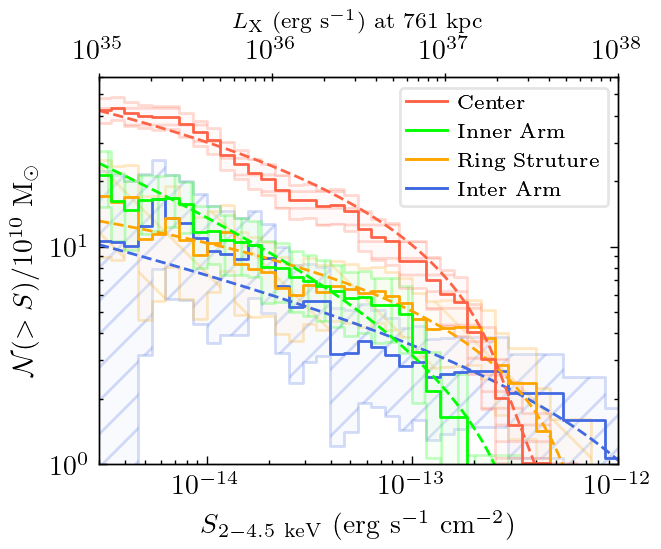

In [396]:


def cumsum_reverse(array):
    return np.cumsum(array[::-1])[::-1]


def model(x,para):
    return brokenpl_dN(x,para[0:4])+power_law(x,para[4:6])#+cutoff_power_law(x,para[11:16]) #+cutoff_brokenpl_dN(x,para[6:11])
def LMXB_model(x,para):
    return cutoff_brokenpl_dN(x,para[6:11])
def HMXB_model(x,para):
    return cutoff_power_law(x,para[11:16])
def rebin_data(model_dN_corr):
    rebin_indices = np.floor(np.arange(len(model_dN_corr)) / expanded_times).astype(int)
    new_model_dN_corr = np.bincount(rebin_indices, weights=model_dN_corr)
    return new_model_dN_corr

plt.figure(figsize=(3.35,3.35/4*3))
ax1 = plt.subplot(111)

L_bin = np.logspace(34,41,9001)
L = np.sqrt(L_bin[1:]*L_bin[:-1])
dL = L_bin[1:]-L_bin[:-1]
def brokenpldNdL(L, K,beta1, beta2, fb):
    dNdL = K*(L)**(-beta1)
    index = L> fb
    dNdL[index] = K*(fb)**(beta2-beta1)* (L[index])**(-beta2)
    return dNdL

def brokenpldNdL_Zhang(L, K,beta1, beta2, beta3, Lb1,Lb2, Lc):
    dNdL = K*(L/Lb1)**(-beta1)
    
    index = (L >= Lb1) & (L < Lb2)
    dNdL[index] =  K*(Lb1/Lb2)**(beta2) * (L[index]/Lb2)**(-beta2)
    
    index = (L >= Lb2) & (L < Lc)
    dNdL[index] = K*(Lb1/Lb2)**(beta2)*(Lb2/Lc)**(beta3) * (L[index]/Lc)**(-beta3)

    index = L>=Lc
    dNdL[index] = 0
    
    return dNdL


print('L.shape',L.shape)

# --- 第一组图例项 (例如，模型和银河系数据 - 计划放在右上角) ---
handles_list = []
legend1_labels_list = []

# line_lehmer, = plt.plot(luminosity2flux(L)[::100]/3.1,
#         cumsum_reverse(brokenpldNdL(L/1e38,2.6,1.31,2.57,2.16)*(dL/1e38))[::100],
#         color='violet',
#         ls='none',
#         marker='+',
#         markersize=3.5,  
#         markerfacecolor='none', 
#         markeredgewidth=0.7,
#         label='Lehmer et al. 2019',
#         alpha=0.9)
# handles_list.append(line_lehmer)
# legend1_labels_list.append(line_lehmer.get_label())

# line_zhang, = plt.plot(luminosity2flux(L)[::100]/3.1,
#     cumsum_reverse(brokenpldNdL_Zhang(L/1e36,0.101,1.02,2.06,3.63,54.6,599,5e4)*(dL/1e36))[::100],
#     color='firebrick',
#     ls='none',
#     marker='1',
#     markersize=3.5 ,
#     markerfacecolor='none', 
#     markeredgewidth=0.5,
#     label='Zhang et al. 2012')
# handles_list.append(line_zhang)
# legend1_labels_list.append(line_zhang.get_label())
# # plt.plot(luminosity2flux(L)/3.1,cumsum_reverse(brokenpldNdL(L/1e38,4.15,1.02,2.06,0.546)*(dL/1e38)),color='violet',ls=':',label='Zhang et al. 2012')


# # HMXB of MW - 改为圆形标记点，无连接线
# band_ratio_hmxb = 1.9085278159246946 # 2.0-10.0 keV to 2.0-4.5 keV # index = 2.1
# L_hmxb = np.logspace(35.3,38.4,40) # 使用较少的数据点来模拟实际观测点
# N_hmxb = 20*(L_hmxb/10**36)**(-0.64)
# points_hmxb, = plt.plot(luminosity2flux(L_hmxb)/band_ratio_hmxb,
#          N_hmxb/5,
#          marker='s',         # 圆形标记
#          linestyle='none',   # 无连接线
#          alpha=0.8,
#          color='deepskyblue',  # 尝试一个更像图中HMXB的颜色
#          markersize=2.5,       # 设置标记大小
#          markerfacecolor='none', 
#          markeredgewidth=0.5,
#          label='HMXB of MW')
# handles_list.append(points_hmxb)
# legend1_labels_list.append(points_hmxb.get_label())
# # LMXB of MW - 改为方形标记点，无连接线
# band_ratio_lmxb = 1.9 # 2.0-10.0 keV to 2.0-4.5 keV, index=2.1
# L_lmxb = np.logspace(35.3,38.4,40) # 使用较少的数据点来模拟实际观测点
# N_lmxb = 105*((L_lmxb/10**36)**(-0.26)-270**(-0.26))
# # 过滤掉N_lmxb < 0 的点，如果可能出现的话
# valid_indices = N_lmxb > 0
# points_lmxb, = plt.plot(luminosity2flux(L_lmxb[valid_indices])/band_ratio_lmxb,
#          N_lmxb[valid_indices]/5,
#          marker='^',         # 方形标记
#          linestyle='none',   # 无连接线
#          alpha=0.6,
#          color='purple',
#          markersize=3.5,       # 设置标记大小
#          markerfacecolor='none', 
#          markeredgewidth=0.5,
#          label='LMXB of MW')
# handles_list.append(points_lmxb)
# legend1_labels_list.append(points_lmxb.get_label())

# band_ratio_hmxb = 1.9085278159246946 # 2.0-10.0 keV to 2.0-4.5 keV # index = 2.1
# L_hmxb = np.logspace(35.3,38.4,40) # 使用较少的数据点来模拟实际观测点
# N_hmxb = 20*(L_hmxb/10**36)**(-0.55)
# M33, =plt.plot(luminosity2flux(L_hmxb)/band_ratio_hmxb,
#          N_hmxb*8.5,
#          marker='o',         # 圆形标记
#          linestyle='none',   # 无连接线
#          alpha=0.8,
#          color='k',  # 尝试一个更像图中HMXB的颜色
#          markersize=2,       # 设置标记大小
#          markerfacecolor='k', 
#          markeredgewidth=0.5,
#          label='M33')
# handles_list.append(M33)
# legend1_labels_list.append(M33.get_label())

# legend1 = plt.legend(handles_list, legend1_labels_list,
#                     loc='lower left',
#                    fontsize=6,
#                     # title='Models & MW', # 可选标题
#                     columnspacing=0.8,
#                     handletextpad=0.5,
#                     borderpad=0.3,
#                     framealpha=0.3,facecolor='white',frameon=True,
#                    )
# plt.gca().add_artist(legend1)

handles_list2 = []
legend1_labels_list2 = []


# for i,region_label in enumerate(['Back','North','South','Center','Disk','Ring','InnerArm','InterArm','All']):
# for i,region_label in enumerate(['Center','InnerArm','Ring','InterArm',]):
for i,region_label in enumerate(['InterArm','Ring', 'InnerArm', 'Center',]):
    print(i+1,region_label)
    # m = i+1
    # if m not in [4,6,7,8]:
    #     continue
    # i = 8
    # region_label = 'All'
    # m = i+1

    if region_label == "Back":
        label = 'Background'
    elif region_label == "Ring":
        label = 'Region3: Ring'
        label = 'Region3'
        label = 'Ring Struture'
        All_HMXB.A = 0 #11
        ui.fit(6)

    elif region_label == "Center":
        label = 'Region1: Center'
        label = 'Region1'
        label = 'Center'
        All_HMXB.A = 0 #11
        ui.fit(4)

    elif region_label == "InnerArm":
        label = 'Region2: InnerArm'
        label = 'Region2'
        label = 'Inner Arm'
        All_HMXB.A = 0 #11
        ui.fit(7)

    elif region_label == "InterArm":
        label = 'Region4: InterArm'
        label = 'Region4'
        label = 'Inter Arm'
        All_HMXB.A = 0 #11
        ui.fit(8)
    else:
        label = region_label

        print(i+1,region_label,label)
    if region_label =='Center' or region_label =='Center_rmGlC':
        color='tomato'
    elif region_label =='Disk' or region_label =='Disk_rmGlC':
        color= icefire[4]
    elif region_label =='Ring' or region_label =='Ring_rmGlC':
        color='springgreen' # 'purple'
        color='orange'
    elif region_label =='InnerArm' or region_label =='InnerArm_rmGlC':
        color='orange'
        color='lime'
    elif region_label =='InterArm' or region_label =='InterArm_rmGlC':
        color= 'royalblue' #'royalblue'
    elif region_label =='Inner' or region_label =='Inner_rmGlC':
        color=icefire[6] #'purple'
    elif region_label =='Outer' or region_label =='Outer_rmGlC':
        color=icefire[0] #'cyan'
    if '_rmGlC' in region_label:
        alpha=0.5
    else:
        alpha=1.0
        
    XLF_Data_band_region = XLF_Data_band[f'{region_label}']
    exec(f"""para= tuple([i.val for i in {region_label}_source_model.pars])""")
    
    #     AGN_model_dN = model(S_model,para) * dS_model * XLF_Data_band_region['sky_area_function']
    # else:
    HMXB_model_dN = HMXB_model(S_model,para) * dS_model * XLF_Data_band_region['SFR_function']
    AGN_model_dN = HMXB_model_dN+model(S_model,para) * dS_model * XLF_Data_band_region['sky_area_function']

    L = 3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*S_model
    YY = (np.cumsum(((dS_model*(XLF_Data_band_region['dN_InSmallBin']-AGN_model_dN)/XLF_Data_band_region['mass_function']))[::-1])[::-1])
    Lx = 3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value* YY  * np.max(XLF_Data_band[f'{region_label}']['mass_function'])
    print('integrated converted luminosity (L0.5-8)>1e36',Lx[L>1e36][0])
    Lx = 3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*np.cumsum(S_model*(LMXB_model(S_model,para) * dS_model * np.max(XLF_Data_band[f'{region_label}']['mass_function']))[::-1])[::-1]
    print('integrated converted LMXB luminosity (L0.5-8)>1e36',Lx[L>1e36][0])
    print('mass:', np.max(XLF_Data_band[f'{region_label}']['mass_function']))
    print('SFR:', np.max(XLF_Data_band[f'{region_label}']['SFR_function']))
    # plt.plot(S_model[S_model>XLF_Data_band_region['cutoff_sensitivity']],(np.cumsum(((XLF_Data_band_region['dN_InSmallBin']-AGN_model_dN)/XLF_Data_band_region['mass_function'])[::-1])[::-1])[S_model>XLF_Data_band_region['cutoff_sensitivity']],color=color,alpha=alpha,label=label)
    # plt.step(data_bins[data_bins>XLF_Data_band_region['cutoff_sensitivity']][1:],(XLF_Data_band_region['N_corr'])[data_bins[:-1]>XLF_Data_band_region['cutoff_sensitivity']],where='pre',alpha=0.8,label=region_label)
    # plt.step(data_bins[data_bins>XLF_Data_band_region['cutoff_sensitivity']][1:],(XLF_Data_band_region['N_corr'])[data_bins[:-1]>XLF_Data_band_region['cutoff_sensitivity']],where='pre',alpha=0.8,label=region_label)
    points_handle, = plt.step(data_bins[data_bins>XLF_Data_band_region['cutoff_sensitivity']][:-1],(np.cumsum(rebin_data(( (XLF_Data_band_region['dN_InSmallBin']-AGN_model_dN)/XLF_Data_band_region['mass_function']))[::-1])[::-1])[data_bins[:-1]>XLF_Data_band_region['cutoff_sensitivity']],where='pre',color=color,alpha=alpha,label=label)
    # plt.step(data_bins[data_bins>XLF_Data_band_region['cutoff_sensitivity']][1:],(np.cumsum(rebin_data(((XLF_Data_band_region['dN_InSmallBin']-AGN_model_dN)/XLF_Data_band_region['mass_function']))[::-1])[::-1])[data_bins[1:]>XLF_Data_band_region['cutoff_sensitivity']],where='pre',alpha=0.8,label=region_label)
    # plt.plot(data_bins[data_bins>XLF_Data_band_region['cutoff_sensitivity']],(np.cumsum(rebin_data(((XLF_Data_band_region['dN_InSmallBin']-AGN_model_dN)/XLF_Data_band_region['mass_function']))[::-1])[::-1])[data_bins>XLF_Data_band_region['cutoff_sensitivity']])
    LMXB_model_N_corr = np.cumsum((LMXB_model(S_model,para) * dS_model)[::-1])[::-1] #* XLF_Data_band_region['mass_function']
    plt.plot(S_model[S_model>XLF_Data_band_region['cutoff_sensitivity']],LMXB_model_N_corr[S_model>XLF_Data_band_region['cutoff_sensitivity']],color=color,linestyle='--',alpha=alpha)
    # handles_list2.append(points_handle)
    handles_list2.insert(0, points_handle)
    # legend1_labels_list2.append(points_handle.get_label())
    legend1_labels_list2.insert(0, points_handle.get_label())

    YY = (np.cumsum(rebin_data(((XLF_Data_band_region['dN_InSmallBin']-AGN_model_dN)/XLF_Data_band_region['mass_function']))[::-1])[::-1])
    ERR2 = (((XLF_Data_band_region['dN_InSmallBin']+AGN_model_dN)/XLF_Data_band_region['mass_function']**2))
    CUMERR2 = np.cumsum(((XLF_Data_band_region['dN_InSmallBin']+AGN_model_dN)/XLF_Data_band_region['mass_function']**2)[::-1])[::-1]
    rebin_CUMERR2 = np.cumsum(rebin_data(ERR2)[::-1])[::-1]


    
    plt.fill_between(data_bins[data_bins>XLF_Data_band_region['cutoff_sensitivity']][:-1], \
                 (YY-np.sqrt(rebin_CUMERR2))[data_bins[:-1]>XLF_Data_band_region['cutoff_sensitivity']], \
                 (YY+np.sqrt(rebin_CUMERR2))[data_bins[:-1]>XLF_Data_band_region['cutoff_sensitivity']], \
             facecolor='white',step='pre',edgecolors=color,alpha=0.20, hatch=['//',"\\", '||', '--','||||||', '+++++', '......', '\\\\\\\\\\\\\\', '///////', '****', '*','/',"\\", '|', '--------'][i],) # {'/', '\', '|', '-', '+', 'x', 'o', 'O', '.', '*'} 
    plt.fill_between(data_bins[data_bins>XLF_Data_band_region['cutoff_sensitivity']][:-1], \
                 (YY-np.sqrt(rebin_CUMERR2))[data_bins[:-1]>XLF_Data_band_region['cutoff_sensitivity']], \
                 (YY+np.sqrt(rebin_CUMERR2))[data_bins[:-1]>XLF_Data_band_region['cutoff_sensitivity']], \
             facecolor=color,step='pre',edgecolors=color,alpha=0.03, hatch=['//',"\\", '||', '--','||||||', '+++++', '......', '\\\\\\\\\\\\\\', '///////', '****', '*','/',"\\", '|', '--------'][i],) # {'/', '\', '|', '-', '+', 'x', 'o', 'O', '.', '*'} 

    if region_label == "Back":
        label = 'Background'
    elif region_label == "Ring":
        label = 'Region3: Ring'
        label = 'Region3'
        label = 'Ring Struture'
        All_HMXB.A = 0
        ui.fit(6)

    elif region_label == "Center":
        label = 'Region1: Center'
        label = 'Region1'
        label = 'Center'
        All_HMXB.A = 0
        ui.fit(4)

    elif region_label == "InnerArm":
        label = 'Region2: InnerArm'
        label = 'Region2'
        label = 'Inner Arm'
        All_HMXB.A = 0
        ui.fit(7)

    elif region_label == "InterArm":
        label = 'Region4: InterArm'
        label = 'Region4'
        label = 'Inter Arm'
        All_HMXB.A = 0
        ui.fit(8)
    else:
        label = region_label
    exec(f"""para= tuple([i.val for i in {region_label}_source_model.pars])""")
    # HMXB_model_dN = HMXB_model(S_model,para) * dS_model * XLF_Data_band_region['SFR_function']
    # AGN_model_dN = HMXB_model_dN+model(S_model,para) * dS_model * XLF_Data_band_region['sky_area_function']
    LMXB_model_N_corr = np.cumsum((LMXB_model(S_model,para) * dS_model)[::-1])[::-1] #* XLF_Data_band_region['mass_function']
    # plt.plot(S_model[S_model>XLF_Data_band_region['cutoff_sensitivity']],LMXB_model_N_corr[S_model>XLF_Data_band_region['cutoff_sensitivity']],color=color,linestyle='--',alpha=0.8,lw=0.5)


    # plt.fill_between(data_bins[data_bins>XLF_Data_band_region['cutoff_sensitivity']][1:], \
    #                  np.nanmax(XLF_Data_band_region['sky_area_function'])*(XLF_Data_band_region['N_corr']-new_model_N_corr-XLF_Data_band_region['N_err_corr'])[data_bins[:-1]>cutoff_sensitivity], \
    #                  np.nanmax(XLF_Data_band_region['sky_area_function'])*(XLF_Data_band_region['N_corr']-new_model_N_corr+XLF_Data_band_region['N_err_corr'])[data_bins[:-1]>cutoff_sensitivity], \
    #              facecolor='w',step='pre',edgecolors=color,alpha=0.08, hatch=['/',"\\", '|', '--------','||||||', '+++++', '......', '\\\\\\\\\\\\\\', '///////', '****', '*','/',"\\", '|', '--------'][i],) # {'/', '\', '|', '-', '+', 'x', 'o', 'O', '.', '*'} 
    

# region_label = 'All'
# # m = i+1
# XLF_Data_band_region = XLF_Data_band[f'{region_label}']
# exec(f"""para= tuple([i.val for i in {region_label}_source_model.pars])""")
# plt.plot(S_model[S_model>XLF_Data_band_region['cutoff_sensitivity']],(np.cumsum(((XLF_Data_band_region['dN_InSmallBin']-AGN_model_dN)/XLF_Data_band_region['mass_function'])[::-1])[::-1])[S_model>XLF_Data_band_region['cutoff_sensitivity']])
# LMXB_model_N_corr = np.cumsum((LMXB_model(S_model,para) * dS_model)[::-1])[::-1] #* XLF_Data_band_region['mass_function']
# plt.plot(S_model[S_model>XLF_Data_band_region['cutoff_sensitivity']],LMXB_model_N_corr[S_model>XLF_Data_band_region['cutoff_sensitivity']])

# band_ratio = 1.9085278159246946 # 2.0-10.0 keV to 2.0-4.5 keV # index = 2.1
# L = np.logspace(35.3,38.4,60)
# N = 20*(L/10**36)**(-0.64)
# # plt.plot(luminosity2flux(L),N,'--',color='orange',label='HMXB of MW')
# # divide it by 5 assuming the stellar mass of MW is 5x10^10 M_sun
# plt.plot(luminosity2flux(L)/band_ratio,N/5,'-.',alpha=0.8,color='springgreen',label='HMXB of MW')
# band_ratio = 1.9 # 2.0-10.0 keV to 2.0-4.5 keV, index=2.1
# L = np.logspace(35.3,38.4,60)
# N = 105*((L/10**36)**(-0.26)-270**(-0.26))
# plt.plot(luminosity2flux(L)/band_ratio,N/5,':',alpha=0.8,color='tomato',label='LMXB of MW')

    



plt.ylim([1,60])
plt.xlim([3e-15,1e-12])
plt.xscale('log')
plt.yscale('log')
# plt.legend()
# plt.ylim(0.8,2e2)
plt.ylabel("$\mathcal{N}(>S)/\mathrm{10^{10}~M_{\odot}}$")
plt.xlabel('$S\mathrm{_{2-4.5~keV}~(erg~s^{-1}~cm^{-2})}$')        
# plt.xticks([1e-14,1e-13,1e-12],)
# plt.savefig('figure/M31_XLF_N_corr_v6.pdf',bbox_inches='tight')

ax1_top = ax1.twiny()
ax1_top.set_xlim(ax1.get_xlim())  # Make sure the new x-axis range matches the original
ax1_top.set_xticks(ax1.get_xticks())
ax1_top.set_xbound(ax1.get_xbound())
#     ax1_top.set_xticklabels(second_xtick_labels)
ax1_top.set_xlim([flux2luminosity(ax1.get_xbound()[0]),flux2luminosity(ax1.get_xbound()[1])])
ax1_top.set_xscale('log')
ax1_top.set_xticks([1e35,1e36,1e37,1e38])
ax1_top.tick_params(axis='x', direction='inout', labeltop=True)
plt.xlabel(r'$L\mathrm{_X~(erg~s^{-1})}$ at 761 kpc',fontsize=8)


plt.sca(ax1)

legend2 = plt.legend(handles_list2, legend1_labels_list2,
                    loc='upper right',
                   fontsize=7.5,
                    # title='Models & MW', # 可选标题
                    columnspacing=0.8,
                    handletextpad=0.5,
                    borderpad=0.3,
                    framealpha=0.3,facecolor='white',frameon=True,
                   )
plt.gca().add_artist(legend2)

# plt.legend(ncol=2,fontsize=5.5)


plt.savefig('figure/M31_XLF_N_corr_per_StellarMassV8a.pdf',bbox_inches='tight')

plt.show()


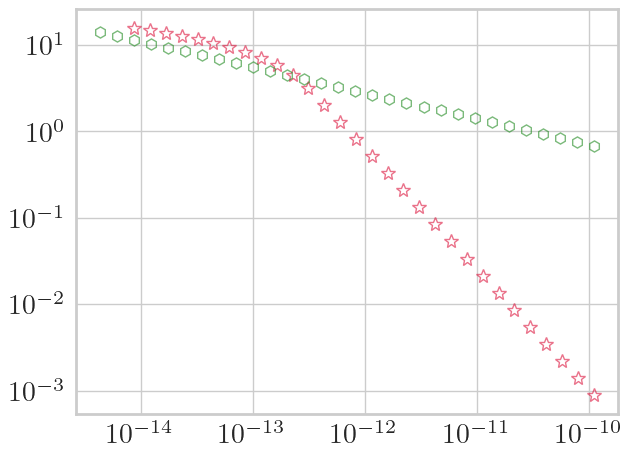

In [452]:
import numpy as np
import matplotlib.pyplot as plt

def plot_mw_lmxb_xlf():
    """
    根据 Voss & Ajello (2010) 的研究，计算并绘制银河系 (MW)
    低质量X射线双星 (LMXB) 的累积X射线光度函数 (cumulative XLF)。

    该函数使用了论文表5中为LMXB提供的碎裂幂律模型的最佳拟合参数，
    并将结果按银河系的恒星质量进行归一化。
    """
    # --- 模型参数 (来自 Voss & Ajello 2010, 表 5) ---
    # 能量范围: 15-55 keV
    
    # 幂律斜率
    alpha1 = 0.9  # 暗端斜率 (L < L_b)
    alpha2 = 2.4  # 亮端斜率 (L > L_b)

    # 拐折光度 (erg/s)
    L_b = 3.0e36

    # 总源数 (用于归一化)
    N_total = 81.4

    # 光度函数的积分下限 (erg/s)
    L_min = 8.0e34
    
    # 银河系恒星质量 (M_sun)
    # 范围为 4.8e10 至 5.5e10 M_sun，我们取平均值。
    M_stellar_mw = 5.15e10/1e10

    # --- 计算归一化常数 K ---
    # dN/dL = K * (L/L_b)^(-alpha) 的形式不正确。
    # 连续的碎裂幂律形式为:
    # dN/dL = K * L^(-alpha1)  for L < L_b
    # dN/dL = K * L_b^(alpha2-alpha1) * L^(-alpha2) for L >= L_b
    # 我们对 dN/dL 从 L_min 积分到无穷大，并令其等于 N_total 来求解 K。
    
    # 积分的第一部分: 从 L_min 到 L_b
    integral_1 = (L_b**(1 - alpha1) - L_min**(1 - alpha1)) / (1 - alpha1)
    
    # 积分的第二部分: 从 L_b 到无穷大
    # 这个积分收敛因为 alpha2 > 1
    integral_2 = (L_b**(alpha2 - alpha1) * L_b**(1 - alpha2)) / (alpha2 - 1)
    
    # 求解 K
    K = N_total / (integral_1 + integral_2)

    # --- 定义累积光度函数 N(>L) ---
    def cumulative_xlf(L_values):
        """计算给定光度值L的源数量 N(>L)"""
        L_values = np.atleast_1d(L_values)
        N_greater_L = np.zeros_like(L_values, dtype=float)

        # 计算在拐折光度 L_b 处的累积数
        N_greater_Lb = K * (L_b**(alpha2 - alpha1)) * (L_b**(1 - alpha2)) / (alpha2 - 1)

        # 情况 1: L >= L_b
        mask_bright = L_values >= L_b
        L_bright = L_values[mask_bright]
        N_greater_L[mask_bright] = K * (L_b**(alpha2 - alpha1)) * (L_bright**(1 - alpha2)) / (alpha2 - 1)

        # 情况 2: L < L_b
        mask_faint = L_values < L_b
        L_faint = L_values[mask_faint]
        integral_faint_part = K * (L_b**(1 - alpha1) - L_faint**(1 - alpha1)) / (1 - alpha1)
        N_greater_L[mask_faint] = integral_faint_part + N_greater_Lb
        
        return N_greater_L

    # --- 生成数据并绘图 ---
    # 创建一个对数间隔的光度值数组用于绘图
    luminosity_range = np.logspace(np.log10(L_min), 39, 30)
    
    # 计算累积数
    N_cumulative = cumulative_xlf(luminosity_range)
    
    # 按恒星质量归一化
    N_normalized = N_cumulative / M_stellar_mw

    # --- 绘图 ---
    # plt.style.use('seaborn-v0_8-whitegrid')
    # fig, ax = plt.subplots(figsize=(10, 7))

    band_ratio = 7.582 # 15-55 ke to 2-4.5 keV
    
    
    plt.plot(band_ratio*luminosity2flux(luminosity_range), N_normalized, 
             marker='*',         # 方形标记
         linestyle='none',   # 无连接线
         alpha=0.6,
         # color='purple',
         markersize=5,       # 设置标记大小
         markerfacecolor='none', 
         markeredgewidth=0.5,
         label='MW LMXB Model (Voss \& Ajello 2010)', color='crimson', lw=2.5)

    # ax.set_xscale('log')
    # ax.set_yscale('log')
    
    # ax.set_xlim(L_min, 1e39)
    # ax.set_ylim(1e-10, 3e-9)

    # ax.set_xlabel('Luminosity (15-55 keV) [erg/s]', fontsize=14)
    # ax.set_ylabel(r'N(>L) / M$_{\star}$ [M$_{\odot}^{-1}$]', fontsize=14)
    # ax.set_title('Milky Way LMXB Cumulative XLF', fontsize=16)
    
    # ax.tick_params(axis='both', which='major', labelsize=12)
    # ax.legend(fontsize=12)
    
    # plt.grid(True, which="both", ls="--", c='gray', alpha=0.6)
    # plt.tight_layout()
    # plt.show()

# if __name__ == '__main__':

def plot_mw_hmxb_xlf():
    """
    根据 Voss & Ajello (2010) 的研究，计算并绘制银河系 (MW)
    低质量X射线双星 (LMXB) 的累积X射线光度函数 (cumulative XLF)。

    该函数使用了论文表5中为LMXB提供的碎裂幂律模型的最佳拟合参数，
    并将结果按银河系的恒星质量进行归一化。
    """
    # --- 模型参数 (来自 Voss & Ajello 2010, 表 5) ---
    # 能量范围: 15-55 keV
    
    # 幂律斜率
    alpha1 = 1.3  # 暗端斜率 (L < L_b)
    alpha2 = 1.3  # 亮端斜率 (L > L_b)

    # 拐折光度 (erg/s)
    L_b = 2.5e37

    # 总源数 (用于归一化)
    N_total = 73.1

    # 光度函数的积分下限 (erg/s)
    L_min = 4.0e34
    
    # 银河系恒星质量 (M_sun)
    # 范围为 4.8e10 至 5.5e10 M_sun，我们取平均值。
    M_stellar_mw = 5.15e10/1e10

    # --- 计算归一化常数 K ---
    # dN/dL = K * (L/L_b)^(-alpha) 的形式不正确。
    # 连续的碎裂幂律形式为:
    # dN/dL = K * L^(-alpha1)  for L < L_b
    # dN/dL = K * L_b^(alpha2-alpha1) * L^(-alpha2) for L >= L_b
    # 我们对 dN/dL 从 L_min 积分到无穷大，并令其等于 N_total 来求解 K。
    
    # 积分的第一部分: 从 L_min 到 L_b
    integral_1 = (L_b**(1 - alpha1) - L_min**(1 - alpha1)) / (1 - alpha1)
    
    # 积分的第二部分: 从 L_b 到无穷大
    # 这个积分收敛因为 alpha2 > 1
    integral_2 = (L_b**(alpha2 - alpha1) * L_b**(1 - alpha2)) / (alpha2 - 1)
    
    # 求解 K
    K = N_total / (integral_1 + integral_2)

    # --- 定义累积光度函数 N(>L) ---
    def cumulative_xlf(L_values):
        """计算给定光度值L的源数量 N(>L)"""
        L_values = np.atleast_1d(L_values)
        N_greater_L = np.zeros_like(L_values, dtype=float)

        # 计算在拐折光度 L_b 处的累积数
        N_greater_Lb = K * (L_b**(alpha2 - alpha1)) * (L_b**(1 - alpha2)) / (alpha2 - 1)

        # 情况 1: L >= L_b
        mask_bright = L_values >= L_b
        L_bright = L_values[mask_bright]
        N_greater_L[mask_bright] = K * (L_b**(alpha2 - alpha1)) * (L_bright**(1 - alpha2)) / (alpha2 - 1)

        # 情况 2: L < L_b
        mask_faint = L_values < L_b
        L_faint = L_values[mask_faint]
        integral_faint_part = K * (L_b**(1 - alpha1) - L_faint**(1 - alpha1)) / (1 - alpha1)
        N_greater_L[mask_faint] = integral_faint_part + N_greater_Lb
        
        return N_greater_L

    # --- 生成数据并绘图 ---
    # 创建一个对数间隔的光度值数组用于绘图
    luminosity_range = np.logspace(np.log10(L_min), 39, 30)
    
    # 计算累积数
    N_cumulative = cumulative_xlf(luminosity_range)
    
    # 按恒星质量归一化
    N_normalized = N_cumulative / M_stellar_mw

    # --- 绘图 ---
    # plt.style.use('seaborn-v0_8-whitegrid')
    # fig, ax = plt.subplots(figsize=(10, 7))

    band_ratio = 7.582 # 15-55 ke to 2-4.5 keV
    
    
    plt.plot(band_ratio*luminosity2flux(luminosity_range), N_normalized, 
             marker='h',         # 方形标记
         linestyle='none',   # 无连接线
         alpha=0.6,
         # color='purple',
         markersize=4,       # 设置标记大小
         markerfacecolor='none', 
         markeredgewidth=0.5,
         label='MW HMXB Model (Voss \& Ajello 2010)', color='forestgreen', lw=2.5)

plot_mw_lmxb_xlf()
plot_mw_hmxb_xlf()
plt.xscale('log')
plt.yscale('log')
    


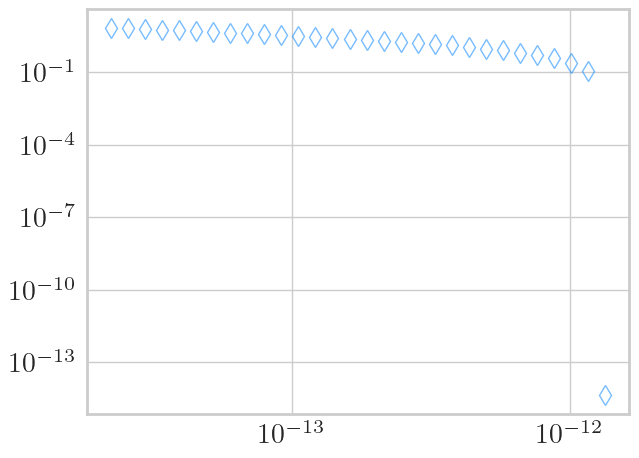

In [453]:
import numpy as np
import matplotlib.pyplot as plt

def plot_m31_disk_xlf_moon():
    """
    根据 Moon et al. (2024) 的研究，计算并绘制 M31 盘区的
    累积X射线光度函数 (cumulative XLF)。

    该函数使用论文表7中为4-25 keV能段提供的单一幂律模型的最佳拟合参数，
    并使用您手稿 (M31_XMM_II) 中的恒星质量进行归一化。
    """
    # --- 模型参数 (来自 Moon et al. 2024, 表 7) ---
    # 能量范围: 4-25 keV
    
    # 幂律斜率 (微分形式)
    alpha1 = 1.32  # [1]

    # 总源数 (来自论文第5节)
    # "In total, we include 54 sources in the full-band XLF"
    N_total = 54  # [1]
    
    # --- 从数据中估算光度范围 ---
    # 根据论文表5，我们估算用于积分的最低和最高光度
    # 最低光度源 (Source 1): 3.6e36 erg/s
    # 最高光度源 (Source 7): 214.6e36 erg/s
    L_min = 3.6e36   # [1]
    L_max = 2.146e38 # [1]

    # --- M31 恒星质量 (来自您的手稿 M31_XMM_II, 表 1, "All" 区域) ---
    # Moon et al. (2024) 未提供其观测区域的恒星质量，
    # 我们使用您手稿中的值以便进行一致的比较。
    M_stellar_m31 = 7.8  # [1]

    # --- 计算归一化常数 A ---
    # dN/dL = A * L^(-alpha1)
    # 对 dN/dL 从 L_min 积分到 L_max，并令其等于 N_total 来求解 A。
    # alpha1 不等于 1，所以积分是 (A / (1 - alpha1)) * [L_max^(1-alpha1) - L_min^(1-alpha1)]
    
    integral_val = (L_max**(1 - alpha1) - L_min**(1 - alpha1)) / (1 - alpha1)
    A = N_total / integral_val

    # --- 定义累积光度函数 N(>L) ---
    def cumulative_xlf(L_values):
        """计算给定光度值L的源数量 N(>L)"""
        # N(>L) 是 dN/dL 从 L 到 L_max 的积分
        L_values = np.atleast_1d(L_values)
        integral_cumulative = (L_max**(1 - alpha1) - L_values**(1 - alpha1)) / (1 - alpha1)
        N_greater_L = A * integral_cumulative
        # 确保在L > L_max时，累积数为0
        N_greater_L[L_values > L_max] = 0
        return N_greater_L

    # --- 生成数据并绘图 ---
    # 创建一个对数间隔的光度值数组用于绘图
    luminosity_range = np.logspace(np.log10(L_min), np.log10(L_max), 30)
    
    # 计算累积数
    N_cumulative = cumulative_xlf(luminosity_range)
    
    # 按恒星质量归一化
    N_normalized = N_cumulative / M_stellar_m31

    # --- 绘图 ---
    # plt.style.use('seaborn-v0_8-whitegrid')
    # fig, ax = plt.subplots(figsize=(10, 7))
    band_ratio = 0.4296
    plt.plot(band_ratio*luminosity2flux(luminosity_range), N_normalized, 
             marker='d',         # 方形标记
         linestyle='none',   # 无连接线
         alpha=0.6,
         # color='purple',
         markersize=5,       # 设置标记大小
         markerfacecolor='none', 
         markeredgewidth=0.5,
         label='M31 Disk XLF (Moon et al. 2024)', color='dodgerblue', lw=2.5)

    # ax.set_xscale('log')
    # ax.set_yscale('log')
    
    # # ax.set_xlim(L_min, 3e38)
    # # ax.set_ylim(1e-11, 1e-9)

    # ax.set_xlabel('Luminosity (4-25 keV) [erg/s]', fontsize=14)
    # ax.set_ylabel(r'N(>L) / M$_{\star}$ [M$_{\odot}^{-1}$]', fontsize=14)
    # ax.set_title('M31 Disk Cumulative XLF (NuSTAR)', fontsize=16)
    
    # ax.tick_params(axis='both', which='major', labelsize=12)
    # ax.legend(fontsize=12)
    
    # plt.grid(True, which="both", ls="--", c='gray', alpha=0.6)
    # plt.tight_layout()
    # plt.show()

# if __name__ == '__main__':
plot_m31_disk_xlf_moon()

plt.xscale('log')
plt.yscale('log')



L.shape (9000,)
1 Center
Dataset               = 4
Method                = neldermead
Statistic             = cstat
Initial fit statistic = 63.8148
Final fit statistic   = 63.8148 at function evaluation 402
Data points           = 102
Degrees of freedom    = 98
Probability [Q-value] = 0.997052
Reduced statistic     = 0.651172
Change in statistic   = 0
   Center_LMXB.K   9.49665     
   Center_LMXB.beta1   1.07605     
   Center_LMXB.beta2   3.47114     
   Center_LMXB.fb   25.1778     
integrated converted luminosity (L0.5-8)>1e36 1.9700963041937834e+36
integrated converted LMXB luminosity (L0.5-8)>1e36 8.477093219470476e+41
mass: 1.9830265192599978
SFR: 0.04827974669556436
Dataset               = 4
Method                = neldermead
Statistic             = cstat
Initial fit statistic = 63.8148
Final fit statistic   = 63.8148 at function evaluation 402
Data points           = 102
Degrees of freedom    = 98
Probability [Q-value] = 0.997052
Reduced statistic     = 0.651172
Change in stat

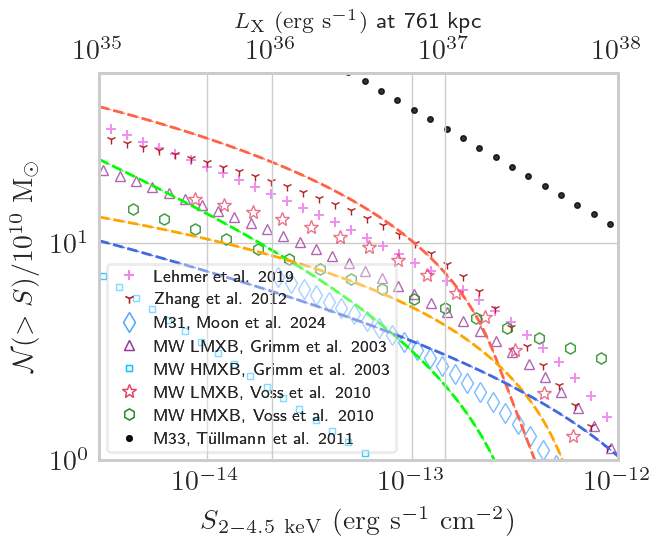

In [454]:
def cumsum_reverse(array):
    return np.cumsum(array[::-1])[::-1]


def model(x,para):
    return brokenpl_dN(x,para[0:4])+power_law(x,para[4:6])#+cutoff_power_law(x,para[11:16]) #+cutoff_brokenpl_dN(x,para[6:11])
def LMXB_model(x,para):
    return cutoff_brokenpl_dN(x,para[6:11])
def HMXB_model(x,para):
    return cutoff_power_law(x,para[11:16])
def rebin_data(model_dN_corr):
    rebin_indices = np.floor(np.arange(len(model_dN_corr)) / expanded_times).astype(int)
    new_model_dN_corr = np.bincount(rebin_indices, weights=model_dN_corr)
    return new_model_dN_corr

plt.figure(figsize=(3.35,3.35/4*3))
ax1 = plt.subplot(111)

L_bin = np.logspace(34,41,9001)
L = np.sqrt(L_bin[1:]*L_bin[:-1])
dL = L_bin[1:]-L_bin[:-1]
def brokenpldNdL(L, K,beta1, beta2, fb):
    dNdL = K*(L)**(-beta1)
    index = L> fb
    dNdL[index] = K*(fb)**(beta2-beta1)* (L[index])**(-beta2)
    return dNdL

def brokenpldNdL_Zhang(L, K,beta1, beta2, beta3, Lb1,Lb2, Lc):
    dNdL = K*(L/Lb1)**(-beta1)
    
    index = (L >= Lb1) & (L < Lb2)
    dNdL[index] =  K*(Lb1/Lb2)**(beta2) * (L[index]/Lb2)**(-beta2)
    
    index = (L >= Lb2) & (L < Lc)
    dNdL[index] = K*(Lb1/Lb2)**(beta2)*(Lb2/Lc)**(beta3) * (L[index]/Lc)**(-beta3)

    index = L>=Lc
    dNdL[index] = 0
    
    return dNdL


print('L.shape',L.shape)

# --- 第一组图例项 (例如，模型和银河系数据 - 计划放在右上角) ---
handles_list = []
legend1_labels_list = []

line_lehmer, = plt.plot(luminosity2flux(L)[::100]/3.1,
        cumsum_reverse(brokenpldNdL(L/1e38,2.6,1.31,2.57,2.16)*(dL/1e38))[::100],
        color='violet',
        ls='none',
        marker='+',
        markersize=3.5,  
        markerfacecolor='none', 
        markeredgewidth=0.7,
        label='Lehmer et al. 2019',
        alpha=0.9)
handles_list.append(line_lehmer)
legend1_labels_list.append(line_lehmer.get_label())

line_zhang, = plt.plot(luminosity2flux(L)[::100]/3.1,
    cumsum_reverse(brokenpldNdL_Zhang(L/1e36,0.101,1.02,2.06,3.63,54.6,599,5e4)*(dL/1e36))[::100],
    color='firebrick',
    ls='none',
    marker='1',
    markersize=3.5 ,
    markerfacecolor='none', 
    markeredgewidth=0.5,
    label='Zhang et al. 2012')
handles_list.append(line_zhang)
legend1_labels_list.append(line_zhang.get_label())
# plt.plot(luminosity2flux(L)/3.1,cumsum_reverse(brokenpldNdL(L/1e38,4.15,1.02,2.06,0.546)*(dL/1e38)),color='violet',ls=':',label='Zhang et al. 2012')

plot_m31_disk_xlf_moon()
moon_lmxb, = plt.plot([],[],marker='d',         # 方形标记
         linestyle='none',   # 无连接线
         alpha=0.6,
         # color='purple',
         markersize=5,       # 设置标记大小
         markerfacecolor='none', 
         markeredgewidth=0.5,
         label='M31, Moon et al. 2024', color='dodgerblue', lw=2.5)
handles_list.append(moon_lmxb)
legend1_labels_list.append(moon_lmxb.get_label())

# LMXB of MW - 改为方形标记点，无连接线
band_ratio_lmxb = 1.9 # 2.0-10.0 keV to 2.0-4.5 keV, index=2.1
L_lmxb = np.logspace(35.3,38.4,40) # 使用较少的数据点来模拟实际观测点
N_lmxb = 105*((L_lmxb/10**36)**(-0.26)-270**(-0.26))
# 过滤掉N_lmxb < 0 的点，如果可能出现的话
valid_indices = N_lmxb > 0
points_lmxb, = plt.plot(luminosity2flux(L_lmxb[valid_indices])/band_ratio_lmxb,
         N_lmxb[valid_indices]/5,
         marker='^',         # 方形标记
         linestyle='none',   # 无连接线b
         alpha=0.6,
         color='purple',
         markersize=3.5,       # 设置标记大小
         markerfacecolor='none', 
         markeredgewidth=0.5,
         label='MW LMXB, Grimm et al. 2003')
handles_list.append(points_lmxb)
legend1_labels_list.append(points_lmxb.get_label())



# HMXB of MW - 改为圆形标记点，无连接线
band_ratio_hmxb = 1.9085278159246946 # 2.0-10.0 keV to 2.0-4.5 keV # index = 2.1
L_hmxb = np.logspace(35.3,38.4,40) # 使用较少的数据点来模拟实际观测点
N_hmxb = 20*(L_hmxb/10**36)**(-0.64)
points_hmxb, = plt.plot(luminosity2flux(L_hmxb)/band_ratio_hmxb,
         N_hmxb/5,
         marker='s',         # 圆形标记
         linestyle='none',   # 无连接线
         alpha=0.8,
         color='deepskyblue',  # 尝试一个更像图中HMXB的颜色
         markersize=2.5,       # 设置标记大小
         markerfacecolor='none', 
         markeredgewidth=0.5,
         label='MW HMXB, Grimm et al. 2003')
handles_list.append(points_hmxb)
legend1_labels_list.append(points_hmxb.get_label())

plot_mw_lmxb_xlf()
voss_lmxb, = plt.plot([],[],marker='*',         # 方形标记
         linestyle='none',   # 无连接线
         alpha=0.6,
         # color='purple',
         markersize=5,       # 设置标记大小
         markerfacecolor='none', 
         markeredgewidth=0.5,
         label='MW LMXB, Voss et al. 2010', color='crimson', lw=2.5)
handles_list.append(voss_lmxb)
legend1_labels_list.append(voss_lmxb.get_label())

plot_mw_hmxb_xlf()
plot_mw_hmxb_xlf()
voss_hmxb, = plt.plot([],[],marker='h',         # 方形标记
         linestyle='none',   # 无连接线
         alpha=0.9,
         # color='purple',
         markersize=4,       # 设置标记大小
         markerfacecolor='none', 
         markeredgewidth=0.5,
         label='MW HMXB, Voss et al. 2010', color='forestgreen', lw=2.5)
handles_list.append(voss_hmxb)
legend1_labels_list.append(voss_hmxb.get_label())



band_ratio_hmxb = 1.9085278159246946 # 2.0-10.0 keV to 2.0-4.5 keV # index = 2.1
L_hmxb = np.logspace(35.3,38.4,40) # 使用较少的数据点来模拟实际观测点
N_hmxb = 20*(L_hmxb/10**36)**(-0.55)
M33, =plt.plot(luminosity2flux(L_hmxb)/band_ratio_hmxb,
         N_hmxb*8.5,
         marker='o',         # 圆形标记
         linestyle='none',   # 无连接线
         alpha=0.8,
         color='k',  # 尝试一个更像图中HMXB的颜色
         markersize=2,       # 设置标记大小
         markerfacecolor='k', 
         markeredgewidth=0.5,
         label='M33, Tüllmann et al. 2011')
handles_list.append(M33)
legend1_labels_list.append(M33.get_label())

legend1 = plt.legend(handles_list, legend1_labels_list,
                    loc='lower left',
                    # loc='upper right',
                   fontsize=6.0,
                    # title='Models & MW', # 可选标题
                    columnspacing=0.8,
                    handletextpad=0.5,
                    borderpad=0.3,
                    framealpha=0.2,facecolor='white',frameon=True,
                   )
plt.gca().add_artist(legend1)




handles_list2 = []
legend1_labels_list2 = []


# for i,region_label in enumerate(['Back','North','South','Center','Disk','Ring','InnerArm','InterArm','All']):
for i,region_label in enumerate(['Center','InnerArm','Ring','InterArm',]):
    print(i+1,region_label)
    # m = i+1
    # if m not in [4,6,7,8]:
    #     continue
    # i = 8
    # region_label = 'All'
    # m = i+1

    if region_label == "Back":
        label = 'Background'
    elif region_label == "Ring":
        label = 'Region3: Ring'
        label = 'Region3'
        label = 'Ring Struture'
        All_HMXB.A = 0 #11
        ui.fit(6)

    elif region_label == "Center":
        label = 'Region1: Center'
        label = 'Region1'
        label = 'Center'
        All_HMXB.A = 0 #11
        ui.fit(4)

    elif region_label == "InnerArm":
        label = 'Region2: InnerArm'
        label = 'Region2'
        label = 'Inner Arm'
        All_HMXB.A = 0 #11
        ui.fit(7)

    elif region_label == "InterArm":
        label = 'Region4: InterArm'
        label = 'Region4'
        label = 'Inter Arm'
        All_HMXB.A = 0 #11
        ui.fit(8)
    else:
        label = region_label

        print(i+1,region_label,label)
    if region_label =='Center' or region_label =='Center_rmGlC':
        color='tomato'
    elif region_label =='Disk' or region_label =='Disk_rmGlC':
        color= icefire[4]
    elif region_label =='Ring' or region_label =='Ring_rmGlC':
        color='springgreen' # 'purple'
        color='orange'
    elif region_label =='InnerArm' or region_label =='InnerArm_rmGlC':
        color='orange'
        color='lime'
    elif region_label =='InterArm' or region_label =='InterArm_rmGlC':
        color= 'royalblue' #'royalblue'
    elif region_label =='Inner' or region_label =='Inner_rmGlC':
        color=icefire[6] #'purple'
    elif region_label =='Outer' or region_label =='Outer_rmGlC':
        color=icefire[0] #'cyan'
    if '_rmGlC' in region_label:
        alpha=0.5
    else:
        alpha=1.0
        
    XLF_Data_band_region = XLF_Data_band[f'{region_label}']
    exec(f"""para= tuple([i.val for i in {region_label}_source_model.pars])""")
    
    #     AGN_model_dN = model(S_model,para) * dS_model * XLF_Data_band_region['sky_area_function']
    # else:
    HMXB_model_dN = HMXB_model(S_model,para) * dS_model * XLF_Data_band_region['SFR_function']
    AGN_model_dN = HMXB_model_dN+model(S_model,para) * dS_model * XLF_Data_band_region['sky_area_function']

    L = 3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*S_model
    YY = (np.cumsum(((dS_model*(XLF_Data_band_region['dN_InSmallBin']-AGN_model_dN)/XLF_Data_band_region['mass_function']))[::-1])[::-1])
    Lx = 3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value* YY  * np.max(XLF_Data_band[f'{region_label}']['mass_function'])
    print('integrated converted luminosity (L0.5-8)>1e36',Lx[L>1e36][0])
    Lx = 3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*np.cumsum(S_model*(LMXB_model(S_model,para) * dS_model * np.max(XLF_Data_band[f'{region_label}']['mass_function']))[::-1])[::-1]
    print('integrated converted LMXB luminosity (L0.5-8)>1e36',Lx[L>1e36][0])
    print('mass:', np.max(XLF_Data_band[f'{region_label}']['mass_function']))
    print('SFR:', np.max(XLF_Data_band[f'{region_label}']['SFR_function']))
    # plt.plot(S_model[S_model>XLF_Data_band_region['cutoff_sensitivity']],(np.cumsum(((XLF_Data_band_region['dN_InSmallBin']-AGN_model_dN)/XLF_Data_band_region['mass_function'])[::-1])[::-1])[S_model>XLF_Data_band_region['cutoff_sensitivity']],color=color,alpha=alpha,label=label)
    # plt.step(data_bins[data_bins>XLF_Data_band_region['cutoff_sensitivity']][1:],(XLF_Data_band_region['N_corr'])[data_bins[:-1]>XLF_Data_band_region['cutoff_sensitivity']],where='pre',alpha=0.8,label=region_label)
    # plt.step(data_bins[data_bins>XLF_Data_band_region['cutoff_sensitivity']][1:],(XLF_Data_band_region['N_corr'])[data_bins[:-1]>XLF_Data_band_region['cutoff_sensitivity']],where='pre',alpha=0.8,label=region_label)
    # points_handle, = plt.step(data_bins[data_bins>XLF_Data_band_region['cutoff_sensitivity']][:-1],(np.cumsum(rebin_data(( (XLF_Data_band_region['dN_InSmallBin']-AGN_model_dN)/XLF_Data_band_region['mass_function']))[::-1])[::-1])[data_bins[:-1]>XLF_Data_band_region['cutoff_sensitivity']],where='pre',color=color,alpha=alpha,label=label)
    # plt.step(data_bins[data_bins>XLF_Data_band_region['cutoff_sensitivity']][1:],(np.cumsum(rebin_data(((XLF_Data_band_region['dN_InSmallBin']-AGN_model_dN)/XLF_Data_band_region['mass_function']))[::-1])[::-1])[data_bins[1:]>XLF_Data_band_region['cutoff_sensitivity']],where='pre',alpha=0.8,label=region_label)
    # plt.plot(data_bins[data_bins>XLF_Data_band_region['cutoff_sensitivity']],(np.cumsum(rebin_data(((XLF_Data_band_region['dN_InSmallBin']-AGN_model_dN)/XLF_Data_band_region['mass_function']))[::-1])[::-1])[data_bins>XLF_Data_band_region['cutoff_sensitivity']])
    LMXB_model_N_corr = np.cumsum((LMXB_model(S_model,para) * dS_model)[::-1])[::-1] #* XLF_Data_band_region['mass_function']
    points_handle, = plt.plot(S_model[S_model>XLF_Data_band_region['cutoff_sensitivity']],LMXB_model_N_corr[S_model>XLF_Data_band_region['cutoff_sensitivity']],color=color,linestyle='--',alpha=alpha,label= label)
    handles_list2.append(points_handle)
    legend1_labels_list2.append(points_handle.get_label())

    YY = (np.cumsum(rebin_data(((XLF_Data_band_region['dN_InSmallBin']-AGN_model_dN)/XLF_Data_band_region['mass_function']))[::-1])[::-1])
    ERR2 = (((XLF_Data_band_region['dN_InSmallBin']+AGN_model_dN)/XLF_Data_band_region['mass_function']**2))
    CUMERR2 = np.cumsum(((XLF_Data_band_region['dN_InSmallBin']+AGN_model_dN)/XLF_Data_band_region['mass_function']**2)[::-1])[::-1]
    rebin_CUMERR2 = np.cumsum(rebin_data(ERR2)[::-1])[::-1]


    # plt.fill_between(data_bins[data_bins>XLF_Data_band_region['cutoff_sensitivity']][:-1], \
    #              (YY-np.sqrt(rebin_CUMERR2))[data_bins[:-1]>XLF_Data_band_region['cutoff_sensitivity']], \
    #              (YY+np.sqrt(rebin_CUMERR2))[data_bins[:-1]>XLF_Data_band_region['cutoff_sensitivity']], \
    #          facecolor='w',step='pre',edgecolors=color,alpha=0.18, hatch=['//',"\\", '||', '--','||||||', '+++++', '......', '\\\\\\\\\\\\\\', '///////', '****', '*','/',"\\", '|', '--------'][i],) # {'/', '\', '|', '-', '+', 'x', 'o', 'O', '.', '*'} 

    if region_label == "Back":
        label = 'Background'
    elif region_label == "Ring":
        label = 'Region3: Ring'
        label = 'Region3'
        label = 'Ring Struture'
        All_HMXB.A = 0
        ui.fit(6)

    elif region_label == "Center":
        label = 'Region1: Center'
        label = 'Region1'
        label = 'Center'
        All_HMXB.A = 0
        ui.fit(4)

    elif region_label == "InnerArm":
        label = 'Region2: InnerArm'
        label = 'Region2'
        label = 'Inner Arm'
        All_HMXB.A = 0
        ui.fit(7)

    elif region_label == "InterArm":
        label = 'Region4: InterArm'
        label = 'Region4'
        label = 'Inter Arm'
        All_HMXB.A = 0
        ui.fit(8)
    else:
        label = region_label
    exec(f"""para= tuple([i.val for i in {region_label}_source_model.pars])""")
    # HMXB_model_dN = HMXB_model(S_model,para) * dS_model * XLF_Data_band_region['SFR_function']
    # AGN_model_dN = HMXB_model_dN+model(S_model,para) * dS_model * XLF_Data_band_region['sky_area_function']
    LMXB_model_N_corr = np.cumsum((LMXB_model(S_model,para) * dS_model)[::-1])[::-1] #* XLF_Data_band_region['mass_function']
    plt.plot(S_model[S_model>XLF_Data_band_region['cutoff_sensitivity']],LMXB_model_N_corr[S_model>XLF_Data_band_region['cutoff_sensitivity']],color=color,linestyle='--',alpha=0.8,lw=0.5,label=region_label)





plt.ylim([1,60])
plt.xlim([3e-15,1e-12])
plt.xscale('log')
plt.yscale('log')
# plt.legend()
# plt.ylim(0.8,2e2)
plt.ylabel("$\mathcal{N}(>S)/\mathrm{10^{10}~M_{\odot}}$")
plt.xlabel('$S\mathrm{_{2-4.5~keV}~(erg~s^{-1}~cm^{-2})}$')        
# plt.xticks([1e-14,1e-13,1e-12],)
# plt.savefig('figure/M31_XLF_N_corr_v6.pdf',bbox_inches='tight')

ax1_top = ax1.twiny()
ax1_top.set_xlim(ax1.get_xlim())  # Make sure the new x-axis range matches the original
ax1_top.set_xticks(ax1.get_xticks())
ax1_top.set_xbound(ax1.get_xbound())
#     ax1_top.set_xticklabels(second_xtick_labels)
ax1_top.set_xlim([flux2luminosity(ax1.get_xbound()[0]),flux2luminosity(ax1.get_xbound()[1])])
ax1_top.set_xscale('log')
ax1_top.set_xticks([1e35,1e36,1e37,1e38])
ax1_top.tick_params(axis='x', direction='inout', labeltop=True)
plt.xlabel(r'$L\mathrm{_X~(erg~s^{-1})}$ at 761 kpc',fontsize=8)


plt.sca(ax1)

# legend2 = plt.legend(handles_list2, legend1_labels_list2,
#                     loc='upper right',
#                    fontsize=7.5,
#                     # title='Models & MW', # 可选标题
#                     columnspacing=0.8,
#                     handletextpad=0.5,
#                     borderpad=0.3,
#                     framealpha=0.3,facecolor='white',frameon=True,
#                    )
# plt.gca().add_artist(legend2)

# plt.legend(ncol=2,fontsize=5.5)


plt.savefig('figure/M31_XLF_N_corr_per_StellarMassV9b.pdf',bbox_inches='tight')

plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


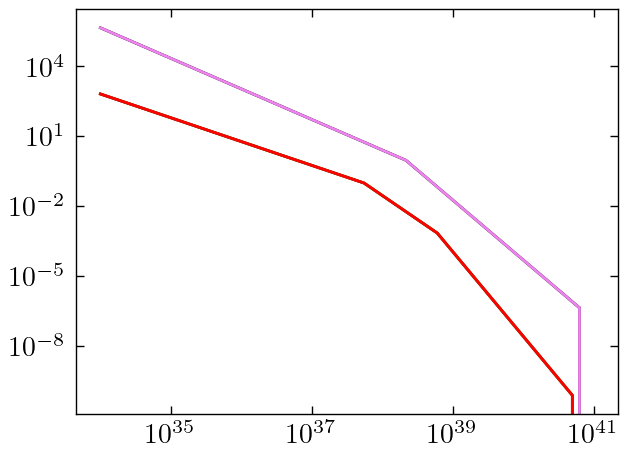

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


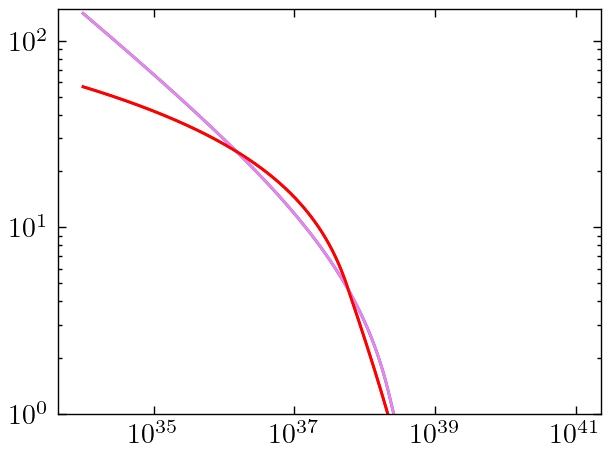

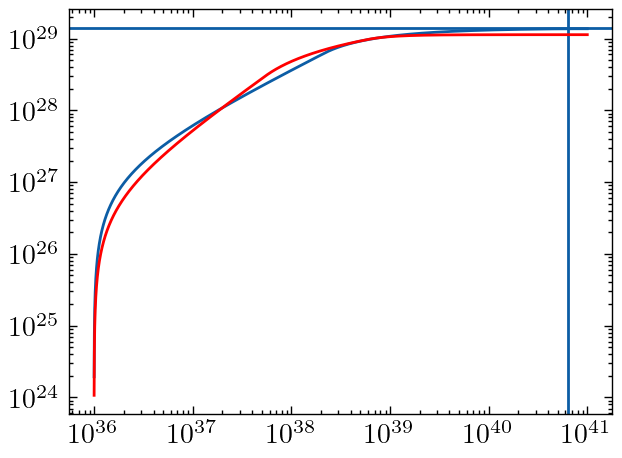

In [208]:
L_bin = np.logspace(34,41,9001)
L = np.sqrt(L_bin[1:]*L_bin[:-1])
dL = L_bin[1:]-L_bin[:-1]
def brokenpldNdL(L, K,beta1, beta2, fb,fc=10**2.8):
    dNdL = K*(L)**(-beta1)
    index = L> fb
    dNdL[index] = K*(fb)**(beta2-beta1)* (L[index])**(-beta2)
    index = L> fc
    dNdL[index] = 0
    return dNdL

# def broken2pldNdL(L, K,beta1, beta2, beta2, fb):
#     dNdL = K*(L)**(-beta1)
#     index = L> fb
#     dNdL[index] = K*(fb)**(beta2-beta1)* (L[index])**(-beta2)
#     index = L> 10**2.8
#     dNdL[index] = 0
#     return dNdL


def brokenpldNdL_Zhang(L, K,beta1, beta2, beta3, Lb1,Lb2, Lc):
    dNdL = K*(L/Lb1)**(-beta1)
    
    index = (L >= Lb1) & (L < Lb2)
    dNdL[index] =  K*(Lb1/Lb2)**(beta2) * (L[index]/Lb2)**(-beta2)
    
    index = (L >= Lb2) & (L < Lc)
    dNdL[index] = K*(Lb1/Lb2)**(beta2)*(Lb2/Lc)**(beta3) * (L[index]/Lc)**(-beta3)

    index = L>=Lc
    dNdL[index] = 0
    
    return dNdL
    



plt.plot(L,(brokenpldNdL(L/1e38,2.6,1.31,2.57,2.16)),'k')

plt.plot(L,(brokenpldNdL_Zhang(L/1e36,1.01/10,1.02,2.06,3.63,54.6,599,5e4)),'r')
plt.plot(L,(brokenpldNdL_Zhang(L/1e38,1.01/10,1.02,2.06,3.63,54.6/100,599/100,5e4/100)),'g')


L38_bin = np.logspace(-4,3,9001)
L38 = np.sqrt(L38_bin[1:]*L38_bin[:-1])
dL38 = L38_bin[1:]-L38_bin[:-1]
plt.plot(L38*1e38,(brokenpldNdL(L38,2.6,1.31,2.57,2.16)),'violet')

L36_bin = np.logspace(-2,5,9001)
L36 = np.sqrt(L36_bin[1:]*L36_bin[:-1])
dL36 = L36_bin[1:]-L36_bin[:-1]
plt.plot(L36*1e36,(brokenpldNdL_Zhang(L36,1.01/10,1.02,2.06,3.63,54.6,599,5e4)),'r')



# plt.plot(L,2.6*(L/1e38)**(-1.31),'--')
# index = L> 2.16e38
# plt.plot(L[index],2.6*(2.16)**(2.57-1.31)* (L[index]/1e38)**(-2.57),'--')

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()


L_bin = np.logspace(34,41,9001)
L = np.sqrt(L_bin[1:]*L_bin[:-1])
dL = L_bin[1:]-L_bin[:-1]
# def brokenpldNdL(L, K,beta1, beta2, fb):
#     dNdL = K*(L)**(-beta1)
#     index = L> fb
#     dNdL[index] = K*(fb)**(beta2-beta1)* (L[index])**(-beta2)
#     return dNdL

plt.plot(L,cumsum_reverse(brokenpldNdL(L/1e38,2.6,1.31,2.57,2.16)                    *(dL/1e38))    )

# plt.plot(L,cumsum_reverse(brokenpldNdL(L/1e38,4.15,1.02,2.06,0.546)                    *(dL/1e38)) ,'k--'   )

plt.plot(L,cumsum_reverse(brokenpldNdL_Zhang(L/1e36,0.101,1.02,2.06,3.63,54.6,599,5e4)*(dL/1e36)),'r')
plt.plot(L,cumsum_reverse(brokenpldNdL_Zhang(L/1e38,0.101,1.02,2.06,3.63,54.6/100,599/100,5e4/100)*(dL/1e38)),'g')


L38_bin = np.logspace(-4,3,9001)
L38 = np.sqrt(L38_bin[1:]*L38_bin[:-1])
dL38 = L38_bin[1:]-L38_bin[:-1]
plt.plot(L38*1e38,cumsum_reverse((brokenpldNdL(L38,2.6,1.31,2.57,2.16))*dL38),'violet')

L36_bin = np.logspace(-2,5,9001)
L36 = np.sqrt(L36_bin[1:]*L36_bin[:-1])
dL36 = L36_bin[1:]-L36_bin[:-1]
plt.plot(L36*1e36,cumsum_reverse(brokenpldNdL_Zhang(L36,1.01/10,1.02,2.06,3.63,54.6,599,5e4)*dL36),'r')



plt.ylim(1,)
# plt.xlim([3e-15,1e-11])
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()


plt.plot(L[L>1e36],np.cumsum((brokenpldNdL(L/1e38,2.6,1.31,2.57,2.16)*(dL/1e38)*L)[L>1e36])/1e10)
# plt.plot(L[L>1e36],np.cumsum(2.6*(brokenpldNdL(L/1e38,26,1.31,2.57,2.16)/brokenpldNdL(np.array([1e38])/1e38,26,1.31,2.57,2.16)*(dL/1e38)*L)[L>1e36]))
plt.xscale('log')
plt.yscale('log')
plt.axhline(10**29.15)
plt.axvline(10**(40.8))


L36_bin = np.logspace(-2,5,9001)
L36 = np.sqrt(L36_bin[1:]*L36_bin[:-1])
dL36 = L36_bin[1:]-L36_bin[:-1]
plt.plot(L36[L36>1]*1e36,np.cumsum(brokenpldNdL_Zhang(L36[L36>1],1.01/10,1.02,2.06,3.63,54.6,599,5e4)*dL36[L36>1]*(L36[L36>1]*1e36))/1e10,'r')


plt.show()


In [209]:

# plt.plot(L38*1e38,brokenpldNdL(L38,2.6,1.31,2.57,2.16),'violet')

# brokenpldNdL(L38,2.6,1.31,2.57,2.16)

# plt.plot(L,2.6*(L/1e38)**(-1.31),'--')
# index = L> 2.16e38
# plt.plot(L[index],2.6*(2.16)**(2.57-1.31)* (L[index]/1e38)**(-2.57),'--')

# plt.xscale('log')
# plt.yscale('log')
# L38

In [210]:
# brokenpldNdL(L/1e38,26,1.31,2.57,2.16)/brokenpldNdL(np.array([1e38])/1e38,26,1.31,2.57,2.16)


# brokenpldNdL(L/1e38,26,1.31,2.57,2.16)
# brokenpldNdL(np.array([1e38])/1e38,260,1.31,2.57,2.16)


1 Center
Dataset               = 4
Method                = neldermead
Statistic             = cstat
Initial fit statistic = 63.8149
Final fit statistic   = 63.8149 at function evaluation 402
Data points           = 102
Degrees of freedom    = 98
Probability [Q-value] = 0.997052
Reduced statistic     = 0.651172
Change in statistic   = 0
   Center_LMXB.K   9.49664     
   Center_LMXB.beta1   1.07605     
   Center_LMXB.beta2   3.47112     
   Center_LMXB.fb   25.1777     
integrated converted luminosity (L0.5-8)>1e36 1.283402791833546e+39
integrated converted LMXB luminosity (L0.5-8)>1e36 1.3826170142580814e+39
mass: 1.9830265192599978
SFR: 0.04827974669556436
yy 40.424597996830435 SFR/mass 0.024346495736013062
[1.78526428e+40 2.85933615e+40]
2 InnerArm
Dataset               = 7
Method                = neldermead
Statistic             = cstat
Initial fit statistic = 44.7221
Final fit statistic   = 44.7221 at function evaluation 421
Data points           = 103
Degrees of freedom    = 99
P

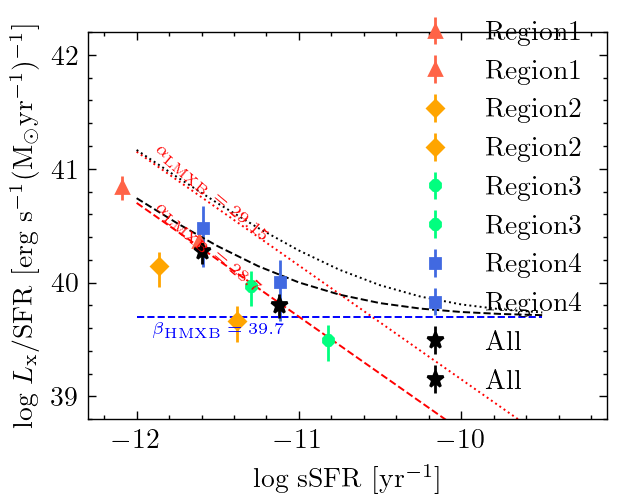

In [217]:

def cumsum_reverse(array):
    return np.cumsum(array[::-1])[::-1]


def model(x,para):
    return brokenpl_dN(x,para[0:4])+power_law(x,para[4:6])#+cutoff_power_law(x,para[11:16]) #+cutoff_brokenpl_dN(x,para[6:11])
def LMXB_model(x,para):
    return cutoff_brokenpl_dN(x,para[6:11])
def HMXB_model(x,para):
    return cutoff_power_law(x,para[11:16])
def rebin_data(model_dN_corr):
    rebin_indices = np.floor(np.arange(len(model_dN_corr)) / expanded_times).astype(int)
    new_model_dN_corr = np.bincount(rebin_indices, weights=model_dN_corr)
    return new_model_dN_corr

plt.figure(figsize=(3.35,3.35/4*3))

# for i,region_label in enumerate(['Back','North','South','Center','Disk','Ring','InnerArm','InterArm','All']):
for i,region_label in enumerate(['Center','InnerArm','Ring','InterArm','All']):
    print(i+1,region_label)
    # m = i+1
    # if m not in [4,6,7,8]:
    #     continue
    # i = 8
    # region_label = 'All'
    # m = i+1

    if region_label == "Back":
        label = 'Background'
    elif region_label == "Ring":
        label = 'Region3: Ring'
        label = 'Region3'
        All_HMXB.A = 0
        ui.fit(6)

    elif region_label == "Center":
        label = 'Region1: Center'
        label = 'Region1'
        All_HMXB.A = 0
        ui.fit(4)

    elif region_label == "InnerArm":
        label = 'Region2: InnerArm'
        label = 'Region2'
        All_HMXB.A = 0
        ui.fit(7)

    elif region_label == "InterArm":
        label = 'Region4: InterArm'
        label = 'Region4'
        All_HMXB.A = 0
        ui.fit(8)
    else:
        label = region_label

        print(i+1,region_label,label)
    if region_label =='Center' or region_label =='Center_rmGlC':
        color='tomato'
    elif region_label =='Disk' or region_label =='Disk_rmGlC':
        color= icefire[4]
    elif region_label =='Ring' or region_label =='Ring_rmGlC':
        color='springgreen' # 'purple'
    elif region_label =='InnerArm' or region_label =='InnerArm_rmGlC':
        color='orange'
    elif region_label =='InterArm' or region_label =='InterArm_rmGlC':
        color= 'royalblue' #'royalblue'
    elif region_label =='Inner' or region_label =='Inner_rmGlC':
        color=icefire[6] #'purple'
    elif region_label =='Outer' or region_label =='Outer_rmGlC':
        color=icefire[0] #'cyan'
    elif region_label =='All':
        color='k'
    if '_rmGlC' in region_label:
        alpha=0.5
    else:
        alpha=1.0
        
    XLF_Data_band_region = XLF_Data_band[f'{region_label}']
    exec(f"""para= tuple([i.val for i in {region_label}_source_model.pars])""")
    
    #     AGN_model_dN = model(S_model,para) * dS_model * XLF_Data_band_region['sky_area_function']
    # else:
    HMXB_model_dN = HMXB_model(S_model,para) * dS_model * XLF_Data_band_region['SFR_function']
    AGN_model_dN = HMXB_model_dN+model(S_model,para) * dS_model * XLF_Data_band_region['sky_area_function']

    FF = np.cumsum((XLF_Data_band_region['dN_InSmallBin']*S_model)[::-1])[::-1] -  np.cumsum((S_model*(model(S_model,para) * dS_model * XLF_Data_band_region['sky_area_function']))[::-1])[::-1]
    # FF = np.cumsum((XLF_Data_band_region['dN_InSmallBin']*S_model)[::-1])[::-1] -  np.cumsum((S_model*(model(S_model,para) * dS_model * np.max(XLF_Data_band_region['sky_area_function'])))[::-1])[::-1]
    Lx = 3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*FF
    L = 3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*S_model
    Luminosity = Lx[L>1e36][0]
    mass = np.max(XLF_Data_band[f'{region_label}']['mass_function'])
    SFR = np.max(XLF_Data_band[f'{region_label}']['SFR_function'])
    # plt.plot(np.log10(SFR/(mass*10**10)),np.log10(Luminosity/SFR),'o',label=label)


    
    # YY = (np.cumsum(rebin_data(((XLF_Data_band_region['dN_InSmallBin']-AGN_model_dN)/XLF_Data_band_region['mass_function']))[::-1])[::-1])
    # CUMERR2 = np.cumsum(((XLF_Data_band_region['dN_InSmallBin']+AGN_model_dN)/XLF_Data_band_region['mass_function']**2)[::-1])[::-1]
    # rebin_CUMERR2 = np.cumsum(rebin_data(ERR2)[::-1])[::-1]

    
    
    L = 3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*S_model
    YY = (np.cumsum(((S_model*(XLF_Data_band_region['dN_InSmallBin']-AGN_model_dN)/XLF_Data_band_region['mass_function']))[::-1])[::-1])
    Lx = 3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value* YY  * np.max(XLF_Data_band[f'{region_label}']['mass_function'])
    print('integrated converted luminosity (L0.5-8)>1e36',Lx[L>1e36][0])
    Lx = 3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value* cumsum_reverse(S_model*(LMXB_model(S_model,para) * dS_model * np.max(XLF_Data_band[f'{region_label}']['mass_function'])))
    Luminosity = Lx[L>1e36][0]
    mass = np.max(XLF_Data_band[f'{region_label}']['mass_function'])
    SFR = np.max(XLF_Data_band[f'{region_label}']['SFR_function'])
    # plt.plot(np.log10(SFR/(mass*10**10)),np.log10(Luminosity/SFR),'+',label=label)
    # Lx = 3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value* np.cumsum(S_model*(LMXB_model(S_model,para) * dS_model * (XLF_Data_band[f'{region_label}']['mass_function']))[::-1])[::-1]
    # Luminosity = Lx[L>1e36][0]
    # mass = np.max(XLF_Data_band[f'{region_label}']['mass_function'])
    # SFR = np.max(XLF_Data_band[f'{region_label}']['SFR_function'])
    # plt.plot(np.log10(SFR/(mass*10**10)),np.log10(Luminosity/SFR),'+',label=label)
    print('integrated converted LMXB luminosity (L0.5-8)>1e36',Lx[L>1e36][0])
    print('mass:', np.max(XLF_Data_band[f'{region_label}']['mass_function']))
    print('SFR:', np.max(XLF_Data_band[f'{region_label}']['SFR_function']))
    # plt.plot(S_model[S_model>XLF_Data_band_region['cutoff_sensitivity']],3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*(np.cumsum(((XLF_Data_band_region['dN_InSmallBin']-AGN_model_dN)/XLF_Data_band_region['mass_function']*S_model)[::-1])[::-1]*np.max(XLF_Data_band_region['mass_function']))[S_model>XLF_Data_band_region['cutoff_sensitivity']],color=color,alpha=alpha,label=label)
    Lx = 3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*(np.cumsum(((XLF_Data_band_region['dN_InSmallBin']-AGN_model_dN)/XLF_Data_band_region['mass_function']*S_model)[::-1])[::-1]*np.max(XLF_Data_band_region['mass_function']))
    # print('integrated converted luminosity (L0.5-8)>1e36',Lx[L>1e36][0])
    Luminosity = Lx[L>1e36][0]
    mass = np.max(XLF_Data_band[f'{region_label}']['mass_function'])
    SFR = np.max(XLF_Data_band[f'{region_label}']['SFR_function'])
    # plt.plot(np.log10(SFR/(mass*10**10)),np.log10(Luminosity/SFR),'k.',label=label,color=color)
    # plt.text(np.log10(SFR/(mass*10**10))+0.1,np.log10(Luminosity/SFR),label)

    
    AGN_model_dN = HMXB_model_dN+model(S_model,para) * dS_model * XLF_Data_band_region['sky_area_function']
    YY = (cumsum_reverse((((XLF_Data_band_region['dN_InSmallBin']-AGN_model_dN)*S_model))))
    CUMERR2 = cumsum_reverse(((XLF_Data_band_region['dN_InSmallBin']+AGN_model_dN)*S_model**2))

    yy = np.log10(flux2luminosity(3.1*np.sum(((XLF_Data_band_region['dN_InSmallBin']-AGN_model_dN)*S_model)[S_model>luminosity2flux(1e36)/3.1]))/SFR)
    x = np.log10(SFR/(mass*10**10))
    
    print('yy',yy,'SFR/mass',SFR/mass)
    # plt.plot(x, yy,'ro',ms=10)
    # rebin_CUMERR2 = np.cumsum((ERR2)[::-1])[::-1]
    # plt.plot([np.log10(SFR/(mass*10**10)),np.log10(SFR/(mass*10**10))],np.log10(3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*np.array([(YY-np.sqrt(CUMERR2))[L>1e36][0],(YY+np.sqrt(CUMERR2))[L>1e36][0]])/SFR),'-',color=color)
    

    y =    np.log10(3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*np.array( (YY)              [(S_model>3.1*luminosity2flux(1e36)) & (S_model<3.1*luminosity2flux(1e41))][0])/SFR)
    # yerr = np.log10(3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*np.array((np.sqrt(CUMERR2)))[(S_model>3.1*luminosity2flux(1e36)) & (S_model<3.1*luminosity2flux(1e41))][0])/SFR)
    # [np.log10(3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*np.array((YY-np.sqrt(CUMERR2))[L>1e36][0])/SFR),np.log10(3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*np.array((YY+np.sqrt(CUMERR2))[L>1e36][0])/SFR)]
    # y = np.log10(3.1*flux2luminosity( np.sum(((((XLF_Data_band_region['dN_InSmallBin']-AGN_model_dN)*S_model)))[(S_model>3.1*luminosity2flux(1e36)) & (S_model<3.1*luminosity2flux(1e41)) ])))
    # err =  np.log10(3.1*flux2luminosity(np.sqrt(np.sum(((XLF_Data_band_region['dN_InSmallBin']+AGN_model_dN)*S_model**2)[(S_model>3.1*luminosity2flux(1e36)) & (S_model<3.1*luminosity2flux(1e41)) ]))))
    # yerr = [y-err,y+err]
    # print(x,y,yerr)
    # print()
    print(3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*np.array([((YY-np.sqrt(CUMERR2))[(S_model>3.1*luminosity2flux(1e36)) & (S_model<3.1*luminosity2flux(1e41))])[0], \
                              ((YY+np.sqrt(CUMERR2))[(S_model>3.1*luminosity2flux(1e36)) & (S_model<3.1*luminosity2flux(1e41))])[0]])/SFR)

    yerr = np.log10(3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*\
                    np.array([((YY-np.sqrt(CUMERR2))[(S_model>3.1*luminosity2flux(1e36)) & (S_model<3.1*luminosity2flux(1e41))])[0], \
                              ((YY+np.sqrt(CUMERR2))[(S_model>3.1*luminosity2flux(1e36)) & (S_model<3.1*luminosity2flux(1e41))])[0]])/SFR)
    if region_label =='All':
        plt.errorbar(x = [x], y = [y], yerr=[[y-yerr[0]],[yerr[1]-y],], fmt='*',label=label,color=color,ms=6)
    elif region_label =='Center':
        plt.errorbar(x = [x], y = [y], yerr=[[y-yerr[0]],[yerr[1]-y],], fmt='^',label=label,color=color,ms=4)
    elif region_label =='Ring':
        plt.errorbar(x = [x], y = [y], yerr=[[y-yerr[0]],[yerr[1]-y],], fmt='8',label=label,color=color,ms=4)
    elif region_label =='InnerArm' or region_label =='InnerArm_rmGlC':
        plt.errorbar(x = [x], y = [y], yerr=[[y-yerr[0]],[yerr[1]-y],], fmt='D',label=label,color=color,ms=4)
    elif region_label =='InterArm' or region_label =='InterArm_rmGlC':
        plt.errorbar(x = [x], y = [y], yerr=[[y-yerr[0]],[yerr[1]-y],], fmt='s',label=label,color=color,ms=3.5)
    else:
        plt.errorbar(x = [x], y = [y], yerr=[[y-yerr[0]],[yerr[1]-y],], fmt='.',label=label,color=color,ms=4)



    if region_label =='All':
        plt.errorbar(x = [x-np.log10(3)], y = [y+np.log10(3)], yerr=[[y-yerr[0]],[yerr[1]-y],], fmt='*',label=label,color=color,ms=6)
    elif region_label =='Center':
        plt.errorbar(x = [x-np.log10(3)], y = [y+np.log10(3)], yerr=[[y-yerr[0]],[yerr[1]-y],], fmt='^',label=label,color=color,ms=4)
    elif region_label =='Ring':
        plt.errorbar(x = [x-np.log10(3)], y = [y+np.log10(3)], yerr=[[y-yerr[0]],[yerr[1]-y],], fmt='8',label=label,color=color,ms=4)
    elif region_label =='InnerArm' or region_label =='InnerArm_rmGlC':
        plt.errorbar(x = [x-np.log10(3)], y = [y+np.log10(3)], yerr=[[y-yerr[0]],[yerr[1]-y],], fmt='D',label=label,color=color,ms=4)
    elif region_label =='InterArm' or region_label =='InterArm_rmGlC':
        plt.errorbar(x = [x-np.log10(3)], y = [y+np.log10(3)], yerr=[[y-yerr[0]],[yerr[1]-y],], fmt='s',label=label,color=color,ms=3.5)
    else:
        plt.errorbar(x = [x-np.log10(3)], y = [y+np.log10(3)], yerr=[[y-yerr[0]],[yerr[1]-y],], fmt='.',label=label,color=color,ms=4)


# plt.axhline(39.7,ls='--')
# plt.plot([-12.3,-10.5,-9.8],[41.5,39.7,39.],'--')

# mass = np.logspace(9,11,11)
mass = 10**11
L_LMXB = mass * 10**29.15
SFR = np.logspace(-1,1.5,11)
L_HMXB = 10**39.7*SFR
plt.plot(np.log10(SFR/mass),np.log10(L_LMXB/SFR),'r:',lw=0.7)
# plt.plot(np.log10(SFR/mass),np.log10(L_LMXB/SFR)-0.5,'r--')
plt.plot(np.log10(SFR/mass),np.log10(L_HMXB/SFR),'b--',lw=0.7)
# plt.plot(np.log10(SFR/mass),np.log10(L_HMXB/SFR)-0.5,'b--')
plt.plot(np.log10(SFR/mass),np.log10((L_LMXB+L_HMXB)/SFR),'k:',lw=0.7)
# plt.plot(np.log10(SFR/mass),np.log10((L_LMXB+L_HMXB)/SFR)-0.5,'k--')

mass = 10**11
L_LMXB = mass * 10**28.7
SFR = np.logspace(-1,1.5,11)
L_HMXB = 10**39.7*SFR
plt.plot(np.log10(SFR/mass),np.log10(L_LMXB/SFR),'r--',lw=0.7)
plt.plot(np.log10(SFR/mass),np.log10((L_LMXB+L_HMXB)/SFR),'k--',lw=0.7)

plt.text(-11.9,39.55,r'$\beta_\mathrm{HMXB}=39.7$',fontsize=6,color='blue')
plt.text(-11.9,40.35,r'$\alpha_\mathrm{LMXB}=29.15$',fontsize=6,color='r',rotation=-40)
plt.text(-11.9,39.9,r'$\alpha_\mathrm{LMXB}=28.7$',fontsize=6,color='r',rotation=-40)

# plt.ylim([39,41.5])
plt.ylim([38.8,42.2])
plt.xlim([-12.3,-9.1])

# plt.xlim([-12,-9.4])
# plt.xscale('log')
# plt.yscale('log')
plt.legend()
# plt.ylim(0.8,2e2)
# plt.ylabel("$\mathcal{N}(>S)/\mathrm{10^{10}~M_{\odot}}$")
# plt.xlabel('$S\mathrm{_{2-4.5~keV}~(erg~s^{-1}~cm^{-2})}$')        
# plt.xticks([1e-14,1e-13,1e-12],)
# plt.savefig('figure/M31_XLF_N_corr_v6.pdf',bbox_inches='tight')
plt.xlabel('$\mathrm{log~sSFR~[yr^{-1}]}$')
plt.ylabel('$\mathrm{log}~L_\mathrm{x}\mathrm{/SFR~[erg~s^{-1} (M_{\odot}yr^{-1})^{-1}}]$')
# plt.savefig('figure/M31_Luminosity_sSFR.pdf',bbox_inches='tight')
plt.show()


1 Center
Dataset               = 4
Method                = neldermead
Statistic             = cstat
Initial fit statistic = 63.8149
Final fit statistic   = 63.8149 at function evaluation 402
Data points           = 102
Degrees of freedom    = 98
Probability [Q-value] = 0.997052
Reduced statistic     = 0.651172
Change in statistic   = 0
   Center_LMXB.K   9.49664     
   Center_LMXB.beta1   1.07605     
   Center_LMXB.beta2   3.47112     
   Center_LMXB.fb   25.1777     
integrated converted luminosity (L0.5-8)>1e36 1.283402791833546e+39
integrated converted LMXB luminosity (L0.5-8)>1e36 1.3826170142580814e+39
mass: 1.9830265192599978
SFR: 0.04827974669556436
yy 40.424597996830435 SFR/mass 0.024346495736013062
-11.613563539255587 40.36591836260697 [39.68513612 39.8978464 ]
[1.78526428e+40 2.85933615e+40]
2 InnerArm
Dataset               = 7
Method                = neldermead
Statistic             = cstat
Initial fit statistic = 44.7221
Final fit statistic   = 44.7221 at function evaluat

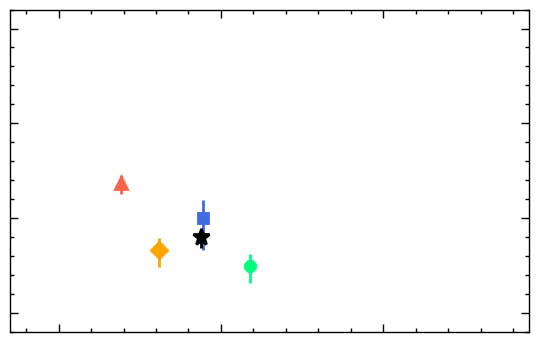

In [219]:

def cumsum_reverse(array):
    return np.cumsum(array[::-1])[::-1]


def model(x,para):
    return brokenpl_dN(x,para[0:4])+power_law(x,para[4:6])#+cutoff_power_law(x,para[11:16]) #+cutoff_brokenpl_dN(x,para[6:11])
def LMXB_model(x,para):
    return cutoff_brokenpl_dN(x,para[6:11])
def HMXB_model(x,para):
    return cutoff_power_law(x,para[11:16])
def rebin_data(model_dN_corr):
    rebin_indices = np.floor(np.arange(len(model_dN_corr)) / expanded_times).astype(int)
    new_model_dN_corr = np.bincount(rebin_indices, weights=model_dN_corr)
    return new_model_dN_corr

plt.figure(figsize=(3.35,3.35/4*2.5),)

# for i,region_label in enumerate(['Back','North','South','Center','Disk','Ring','InnerArm','InterArm','All']):
for i,region_label in enumerate(['Center','InnerArm','Ring','InterArm','All']):
    print(i+1,region_label)
    # m = i+1
    # if m not in [4,6,7,8]:
    #     continue
    # i = 8
    # region_label = 'All'
    # m = i+1

    if region_label == "Back":
        label = 'Background'
    elif region_label == "Ring":
        label = 'Region3: Ring'
        label = 'Region3'
        All_HMXB.A = 0
        ui.fit(6)

    elif region_label == "Center":
        label = 'Region1: Center'
        label = 'Region1'
        All_HMXB.A = 0
        ui.fit(4)

    elif region_label == "InnerArm":
        label = 'Region2: InnerArm'
        label = 'Region2'
        All_HMXB.A = 0
        ui.fit(7)

    elif region_label == "InterArm":
        label = 'Region4: InterArm'
        label = 'Region4'
        All_HMXB.A = 0
        ui.fit(8)
    else:
        label = region_label

        print(i+1,region_label,label)
    if region_label =='Center' or region_label =='Center_rmGlC':
        color='tomato'
    elif region_label =='Disk' or region_label =='Disk_rmGlC':
        color= icefire[4]
    elif region_label =='Ring' or region_label =='Ring_rmGlC':
        color='springgreen' # 'purple'
    elif region_label =='InnerArm' or region_label =='InnerArm_rmGlC':
        color='orange'
    elif region_label =='InterArm' or region_label =='InterArm_rmGlC':
        color= 'royalblue' #'royalblue'
    elif region_label =='Inner' or region_label =='Inner_rmGlC':
        color=icefire[6] #'purple'
    elif region_label =='Outer' or region_label =='Outer_rmGlC':
        color=icefire[0] #'cyan'
    elif region_label =='All':
        color='k'
    if '_rmGlC' in region_label:
        alpha=0.5
    else:
        alpha=1.0
        
    XLF_Data_band_region = XLF_Data_band[f'{region_label}']
    exec(f"""para= tuple([i.val for i in {region_label}_source_model.pars])""")
    
    #     AGN_model_dN = model(S_model,para) * dS_model * XLF_Data_band_region['sky_area_function']
    # else:
    HMXB_model_dN = HMXB_model(S_model,para) * dS_model * XLF_Data_band_region['SFR_function']
    AGN_model_dN = HMXB_model_dN+model(S_model,para) * dS_model * XLF_Data_band_region['sky_area_function']

    FF = np.cumsum((XLF_Data_band_region['dN_InSmallBin']*S_model)[::-1])[::-1] -  np.cumsum((S_model*(model(S_model,para) * dS_model * XLF_Data_band_region['sky_area_function']))[::-1])[::-1]
    # FF = np.cumsum((XLF_Data_band_region['dN_InSmallBin']*S_model)[::-1])[::-1] -  np.cumsum((S_model*(model(S_model,para) * dS_model * np.max(XLF_Data_band_region['sky_area_function'])))[::-1])[::-1]
    Lx = 3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*FF
    Luminosity = Lx[L>1e36][0]
    mass = np.max(XLF_Data_band[f'{region_label}']['mass_function'])
    SFR = np.max(XLF_Data_band[f'{region_label}']['SFR_function'])
    # plt.plot(np.log10(SFR/(mass*10**10)),np.log10(Luminosity/SFR),'o',label=label)


    
    # YY = (np.cumsum(rebin_data(((XLF_Data_band_region['dN_InSmallBin']-AGN_model_dN)/XLF_Data_band_region['mass_function']))[::-1])[::-1])
    # CUMERR2 = np.cumsum(((XLF_Data_band_region['dN_InSmallBin']+AGN_model_dN)/XLF_Data_band_region['mass_function']**2)[::-1])[::-1]
    # rebin_CUMERR2 = np.cumsum(rebin_data(ERR2)[::-1])[::-1]

    
    
    L = 3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*S_model
    YY = (np.cumsum(((S_model*(XLF_Data_band_region['dN_InSmallBin']-AGN_model_dN)/XLF_Data_band_region['mass_function']))[::-1])[::-1])
    Lx = 3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value* YY  * np.max(XLF_Data_band[f'{region_label}']['mass_function'])
    print('integrated converted luminosity (L0.5-8)>1e36',Lx[L>1e36][0])
    Lx = 3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value* cumsum_reverse(S_model*(LMXB_model(S_model,para) * dS_model * np.max(XLF_Data_band[f'{region_label}']['mass_function'])))
    Luminosity = Lx[L>1e36][0]
    mass = np.max(XLF_Data_band[f'{region_label}']['mass_function'])
    SFR = np.max(XLF_Data_band[f'{region_label}']['SFR_function'])
    # plt.plot(np.log10(SFR/(mass*10**10)),np.log10(Luminosity/SFR),'+',label=label)
    # Lx = 3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value* np.cumsum(S_model*(LMXB_model(S_model,para) * dS_model * (XLF_Data_band[f'{region_label}']['mass_function']))[::-1])[::-1]
    # Luminosity = Lx[L>1e36][0]
    # mass = np.max(XLF_Data_band[f'{region_label}']['mass_function'])
    # SFR = np.max(XLF_Data_band[f'{region_label}']['SFR_function'])
    # plt.plot(np.log10(SFR/(mass*10**10)),np.log10(Luminosity/SFR),'+',label=label)
    print('integrated converted LMXB luminosity (L0.5-8)>1e36',Lx[L>1e36][0])
    print('mass:', np.max(XLF_Data_band[f'{region_label}']['mass_function']))
    print('SFR:', np.max(XLF_Data_band[f'{region_label}']['SFR_function']))
    # plt.plot(S_model[S_model>XLF_Data_band_region['cutoff_sensitivity']],3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*(np.cumsum(((XLF_Data_band_region['dN_InSmallBin']-AGN_model_dN)/XLF_Data_band_region['mass_function']*S_model)[::-1])[::-1]*np.max(XLF_Data_band_region['mass_function']))[S_model>XLF_Data_band_region['cutoff_sensitivity']],color=color,alpha=alpha,label=label)
    Lx = 3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*(np.cumsum(((XLF_Data_band_region['dN_InSmallBin']-AGN_model_dN)/XLF_Data_band_region['mass_function']*S_model)[::-1])[::-1]*np.max(XLF_Data_band_region['mass_function']))
    # print('integrated converted luminosity (L0.5-8)>1e36',Lx[L>1e36][0])
    Luminosity = Lx[L>1e36][0]
    mass = np.max(XLF_Data_band[f'{region_label}']['mass_function'])
    SFR = np.max(XLF_Data_band[f'{region_label}']['SFR_function'])
    # plt.plot(np.log10(SFR/(mass*10**10)),np.log10(Luminosity/SFR),'k.',label=label,color=color)
    # plt.text(np.log10(SFR/(mass*10**10))+0.1,np.log10(Luminosity/SFR),label)

    
    AGN_model_dN = HMXB_model_dN+model(S_model,para) * dS_model * XLF_Data_band_region['sky_area_function']
    YY = (cumsum_reverse((((XLF_Data_band_region['dN_InSmallBin']-AGN_model_dN)*S_model))))
    CUMERR2 = cumsum_reverse(((XLF_Data_band_region['dN_InSmallBin']+AGN_model_dN)*S_model**2))

    yy = np.log10(flux2luminosity(3.1*np.sum(((XLF_Data_band_region['dN_InSmallBin']-AGN_model_dN)*S_model)[S_model>luminosity2flux(1e36)/3.1]))/SFR)
    x = np.log10(SFR/(mass*10**10))
    
    print('yy',yy,'SFR/mass',SFR/mass)
    # plt.plot(x, yy,'ro',ms=10)
    # rebin_CUMERR2 = np.cumsum((ERR2)[::-1])[::-1]
    # plt.plot([np.log10(SFR/(mass*10**10)),np.log10(SFR/(mass*10**10))],np.log10(3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*np.array([(YY-np.sqrt(CUMERR2))[L>1e36][0],(YY+np.sqrt(CUMERR2))[L>1e36][0]])/SFR),'-',color=color)
    

    y =    np.log10(3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*np.array( (YY)              [(S_model>3.1*luminosity2flux(1e36)) & (S_model<3.1*luminosity2flux(1e41))][0])/SFR)
    # yerr = np.log10(3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*np.array((np.sqrt(CUMERR2)))[(S_model>3.1*luminosity2flux(1e36)) & (S_model<3.1*luminosity2flux(1e41))][0])/SFR)
    # [np.log10(3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*np.array((YY-np.sqrt(CUMERR2))[L>1e36][0])/SFR),np.log10(3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*np.array((YY+np.sqrt(CUMERR2))[L>1e36][0])/SFR)]
    # y = np.log10(3.1*flux2luminosity( np.sum(((((XLF_Data_band_region['dN_InSmallBin']-AGN_model_dN)*S_model)))[(S_model>3.1*luminosity2flux(1e36)) & (S_model<3.1*luminosity2flux(1e41)) ])))
    # err =  np.log10(3.1*flux2luminosity(np.sqrt(np.sum(((XLF_Data_band_region['dN_InSmallBin']+AGN_model_dN)*S_model**2)[(S_model>3.1*luminosity2flux(1e36)) & (S_model<3.1*luminosity2flux(1e41)) ]))))
    # yerr = [y-err,y+err]
    print(x,y,yerr)
    # print()
    print(3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*np.array([((YY-np.sqrt(CUMERR2))[(S_model>3.1*luminosity2flux(1e36)) & (S_model<3.1*luminosity2flux(1e41))])[0], \
                              ((YY+np.sqrt(CUMERR2))[(S_model>3.1*luminosity2flux(1e36)) & (S_model<3.1*luminosity2flux(1e41))])[0]])/SFR)

    yerr = np.log10(3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*\
                    np.array([((YY-np.sqrt(CUMERR2))[(S_model>3.1*luminosity2flux(1e36)) & (S_model<3.1*luminosity2flux(1e41))])[0], \
                              ((YY+np.sqrt(CUMERR2))[(S_model>3.1*luminosity2flux(1e36)) & (S_model<3.1*luminosity2flux(1e41))])[0]])/SFR)
    if region_label =='All':
        plt.errorbar(x = [x], y = [y], yerr=[[y-yerr[0]],[yerr[1]-y],], fmt='*',label=label,color=color,ms=6)
    elif region_label =='Center':
        plt.errorbar(x = [x], y = [y], yerr=[[y-yerr[0]],[yerr[1]-y],], fmt='^',label=label,color=color,ms=4)
    elif region_label =='Ring':
        plt.errorbar(x = [x], y = [y], yerr=[[y-yerr[0]],[yerr[1]-y],], fmt='8',label=label,color=color,ms=4)
    elif region_label =='InnerArm' or region_label =='InnerArm_rmGlC':
        plt.errorbar(x = [x], y = [y], yerr=[[y-yerr[0]],[yerr[1]-y],], fmt='D',label=label,color=color,ms=4)
    elif region_label =='InterArm' or region_label =='InterArm_rmGlC':
        plt.errorbar(x = [x], y = [y], yerr=[[y-yerr[0]],[yerr[1]-y],], fmt='s',label=label,color=color,ms=3.5)
    else:
        plt.errorbar(x = [x], y = [y], yerr=[[y-yerr[0]],[yerr[1]-y],], fmt='.',label=label,color=color,ms=4)


# plt.axhline(39.7,ls='--')
# plt.plot([-12.3,-10.5,-9.8],[41.5,39.7,39.],'--')

# mass = np.logspace(9,11,11)
mass = 10**11
L_LMXB = mass * 10**29.15
SFR = np.logspace(-1,1.5,11)
L_HMXB = 10**39.7*SFR
# plt.plot(np.log10(SFR/mass),np.log10(L_LMXB/SFR),'r:',lw=0.7)
# plt.plot(np.log10(SFR/mass),np.log10(L_LMXB/SFR)-0.5,'r--')
# plt.plot(np.log10(SFR/mass),np.log10(L_HMXB/SFR),'b--',lw=0.7)
# plt.plot(np.log10(SFR/mass),np.log10(L_HMXB/SFR)-0.5,'b--')
# plt.plot(np.log10(SFR/mass),np.log10((L_LMXB+L_HMXB)/SFR),'k:',lw=0.7)
# plt.plot(np.log10(SFR/mass),np.log10((L_LMXB+L_HMXB)/SFR)-0.5,'k--')

mass = 10**11
L_LMXB = mass * 10**28.7
SFR = np.logspace(-1,1.5,11)
L_HMXB = 10**39.7*SFR
# plt.plot(np.log10(SFR/mass),np.log10(L_LMXB/SFR),'r--',lw=0.7)
# plt.plot(np.log10(SFR/mass),np.log10((L_LMXB+L_HMXB)/SFR),'k--',lw=0.7)

# plt.text(-11.9,39.55,r'$\beta_\mathrm{HMXB}=39.7$',fontsize=6,color='blue')
# plt.text(-11.9,40.35,r'$\alpha_\mathrm{LMXB}=29.15$',fontsize=6,color='r',rotation=-40)
# plt.text(-11.9,39.9,r'$\alpha_\mathrm{LMXB}=28.7$',fontsize=6,color='r',rotation=-40)

# plt.ylim([39,41.5])
plt.ylim([38.8,42.2])
plt.xlim([-12.3,-9.1])

# plt.xlim([-12,-9.4])
# plt.xscale('log')
# plt.yscale('log')
# plt.legend()
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
# plt.ylim(0.8,2e2)
# plt.ylabel("$\mathcal{N}(>S)/\mathrm{10^{10}~M_{\odot}}$")
# plt.xlabel('$S\mathrm{_{2-4.5~keV}~(erg~s^{-1}~cm^{-2})}$')        
# plt.xticks([1e-14,1e-13,1e-12],)
# plt.savefig('figure/M31_XLF_N_corr_v6.pdf',bbox_inches='tight')
# plt.xlabel('$\mathrm{log~sSFR~[yr^{-1}]}$')
# plt.ylabel('$\mathrm{log}~L_\mathrm{x}\mathrm{/SFR~[erg~s^{-1} (M_{\odot}yr^{-1})^{-1}}]$')
plt.savefig('figure/M31_Luminosity_sSFR_point.pdf',bbox_inches='tight', transparent=True)
plt.show()


In [220]:
L.shape, Lx.shape

((12000,), (12000,))

1 All
1 All All
2 Center
3 InnerArm
4 Ring
5 InterArm


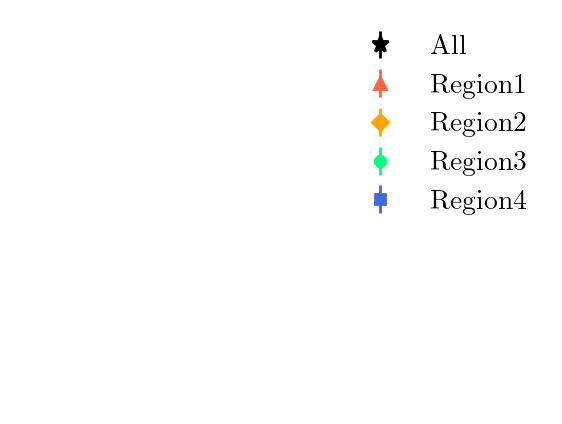

In [221]:
for i,region_label in enumerate(['All','Center','InnerArm','Ring','InterArm']):
    print(i+1,region_label)

    if region_label == "Back":
        label = 'Background'
    elif region_label == "Ring":
        label = 'Region3: Ring'
        label = 'Region3'
        All_HMXB.A = 0
        # ui.fit(6)

    elif region_label == "Center":
        label = 'Region1: Center'
        label = 'Region1'
        All_HMXB.A = 0
        # ui.fit(4)

    elif region_label == "InnerArm":
        label = 'Region2: InnerArm'
        label = 'Region2'
        All_HMXB.A = 0
        # ui.fit(7)

    elif region_label == "InterArm":
        label = 'Region4: InterArm'
        label = 'Region4'
        All_HMXB.A = 0
        # ui.fit(8)
    else:
        label = region_label

        print(i+1,region_label,label)
    if region_label =='Center' or region_label =='Center_rmGlC':
        color='tomato'
    elif region_label =='Disk' or region_label =='Disk_rmGlC':
        color= icefire[4]
    elif region_label =='Ring' or region_label =='Ring_rmGlC':
        color='springgreen' # 'purple'
    elif region_label =='InnerArm' or region_label =='InnerArm_rmGlC':
        color='orange'
    elif region_label =='InterArm' or region_label =='InterArm_rmGlC':
        color= 'royalblue' #'royalblue'
    elif region_label =='Inner' or region_label =='Inner_rmGlC':
        color=icefire[6] #'purple'
    elif region_label =='Outer' or region_label =='Outer_rmGlC':
        color=icefire[0] #'cyan'
    elif region_label =='All':
        color='k'
    if '_rmGlC' in region_label:
        alpha=0.5
    else:
        alpha=1.0
        
    if region_label =='All':
        plt.errorbar(x = [], y = [], yerr=[[],[],], fmt='*',label=label,color=color,ms=6)
    elif region_label =='Center':
        plt.errorbar(x = [], y = [], yerr=[[],[],], fmt='^',label=label,color=color,ms=4)
    elif region_label =='Ring':
        plt.errorbar(x = [], y = [], yerr=[[],[],], fmt='8',label=label,color=color,ms=4)
    elif region_label =='InnerArm' or region_label =='InnerArm_rmGlC':
        plt.errorbar(x = [], y = [], yerr=[[],[],], fmt='D',label=label,color=color,ms=4)
    elif region_label =='InterArm' or region_label =='InterArm_rmGlC':
        plt.errorbar(x = [], y = [], yerr=[[],[],],  fmt='s',label=label,color=color,ms=3.5)
    else:
        plt.errorbar(x = [], y = [], yerr=[[],[],],  fmt='.',label=label,color=color,ms=4)

plt.legend()
plt.axis('off')
plt.savefig('figure/M31_Luminosity_sSFR_label.pdf',bbox_inches='tight', transparent=True)
plt.show()

In [222]:
# plt.plot(S_model ,cumsum_reverse(XLF_Data_band_region['dN_InSmallBin']-AGN_model_dN))
# plt.xscale('log')
# plt.yscale('log')
# plt.show()


np.log10(3.1*flux2luminosity(np.sum(((XLF_Data_band_region['dN_InSmallBin']-AGN_model_dN)*S_model)[(S_model>luminosity2flux(1e38)/3.1) & (S_model<luminosity2flux(1e41)/3.1)])))


39.27643499861593

In [223]:
3.1*flux2luminosity(S_model[0]),3.1*flux2luminosity(S_model[-1])

(2.1496873220306953e+34, 2.146389961507707e+42)

# 需要 检查一下 是否 3.1 有问题？

In [224]:
# # ((XLF_Data_band_region['dN_InSmallBin']-AGN_model_dN)/XLF_Data_band_region['mass_function'])


# YY = (np.cumsum(((XLF_Data_band_region['dN_InSmallBin']-AGN_model_dN)/XLF_Data_band_region['mass_function'])[::-1])[::-1])
# ERR = np.sqrt(XLF_Data_band_region['dN_InSmallBin']+AGN_model_dN)/XLF_Data_band_region['mass_function']
# ERR2 = ((XLF_Data_band_region['dN_InSmallBin']+AGN_model_dN)/XLF_Data_band_region['mass_function']**2)
# CUMERR2 = np.cumsum(((XLF_Data_band_region['dN_InSmallBin']+AGN_model_dN)/XLF_Data_band_region['mass_function']**2)[::-1])[::-1]

# # plt.plot(ERR2)
# print(np.shape(YY))
# print(np.shape(ERR2))

# CUMERR2 = np.cumsum(((XLF_Data_band_region['dN_InSmallBin']+AGN_model_dN)/XLF_Data_band_region['mass_function']**2)[::-1])[::-1]
# rebin_CUMERR2 = np.cumsum(rebin_data(ERR2)[::-1])[::-1]

# # plt.plot(S_model[S_model>XLF_Data_band_region['cutoff_sensitivity']],(np.cumsum(((XLF_Data_band_region['dN_InSmallBin']-AGN_model_dN)/XLF_Data_band_region['mass_function'])[::-1])[::-1])[S_model>XLF_Data_band_region['cutoff_sensitivity']])
# # plt.fill_between(S_model[S_model>XLF_Data_band_region['cutoff_sensitivity']], \
#                  #     (YY-np.sqrt(CUMERR2))[S_model>XLF_Data_band_region['cutoff_sensitivity']], \
#                  #     (YY+np.sqrt(CUMERR2))[S_model>XLF_Data_band_region['cutoff_sensitivity']], \
#                  # facecolor='w',step='pre',edgecolors=color,alpha=0.08, hatch=['/',"\\", '|', '--------','||||||', '+++++', '......', '\\\\\\\\\\\\\\', '///////', '****', '*','/',"\\", '|', '--------'][i],) # {'/', '\', '|', '-', '+', 'x', 'o', 'O', '.', '*'} 

# YY = (np.cumsum(rebin_data(((XLF_Data_band_region['dN_InSmallBin']-AGN_model_dN)/XLF_Data_band_region['mass_function']))[::-1])[::-1])

# plt.step(data_bins[data_bins>XLF_Data_band_region['cutoff_sensitivity']][:-1],(np.cumsum(rebin_data(((XLF_Data_band_region['dN_InSmallBin']-AGN_model_dN)/XLF_Data_band_region['mass_function']))[::-1])[::-1])[data_bins[:-1]>XLF_Data_band_region['cutoff_sensitivity']],where='pre',color=color,alpha=alpha,label=label)

# # plt.step(data_bins[data_bins>XLF_Data_band_region['cutoff_sensitivity']][1:],(XLF_Data_band_region['N_corr'])[data_bins[:-1]>XLF_Data_band_region['cutoff_sensitivity']],where='pre',alpha=0.8,label=region_label)
# plt.fill_between(data_bins[data_bins>XLF_Data_band_region['cutoff_sensitivity']][:-1], \
#                  (YY-np.sqrt(rebin_CUMERR2))[data_bins[:-1]>XLF_Data_band_region['cutoff_sensitivity']], \
#                  (YY+np.sqrt(rebin_CUMERR2))[data_bins[:-1]>XLF_Data_band_region['cutoff_sensitivity']], \
#              facecolor='w',step='pre',edgecolors=color,alpha=0.08, hatch=['/',"\\", '|', '--------','||||||', '+++++', '......', '\\\\\\\\\\\\\\', '///////', '****', '*','/',"\\", '|', '--------'][i],) # {'/', '\', '|', '-', '+', 'x', 'o', 'O', '.', '*'} 


# plt.ylim([1,60])
# plt.xlim([3e-15,1e-12])
# plt.xscale('log')
# plt.yscale('log')
# plt.legend()
# # plt.plot(np.sqrt(np.cumsum(ERR2[::-1])[::-1]))

(((usermodel.All_AGN + usermodel.All_star) + usermodel.All_LMXB) + usermodel.All_HMXB)
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   All_AGN.K    linked        129.3         expr: Back_AGN.K           
   All_AGN.beta1 linked      2.00112     expr: Back_AGN.beta1           
   All_AGN.beta2 linked       2.9308     expr: Back_AGN.beta2           
   All_AGN.fb   linked      1.92319        expr: Back_AGN.fb           
   All_star.A   linked            0        expr: Back_star.A           
   All_star.alpha linked            0    expr: Back_star.alpha           
   All_LMXB.K   thawed      2.89894         0.01           70           
   All_LMXB.beta1 thawed      1.02809          0.1            3           
   All_LMXB.beta2 thawed      2.72275          1.5            6           
   All_LMXB.fb  frozen      29.1774           10          150           
   All_LMXB.cutoff frozen     -9.33

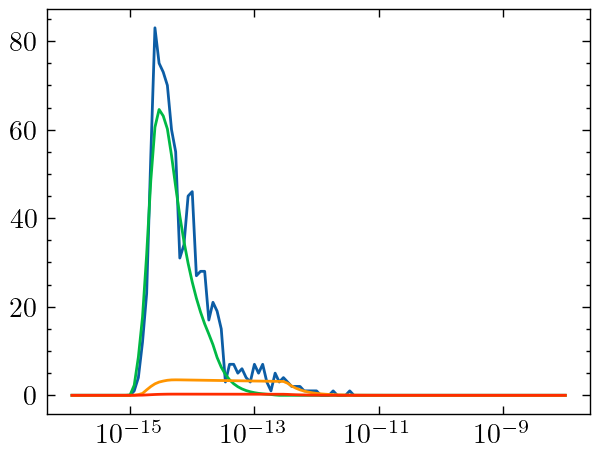

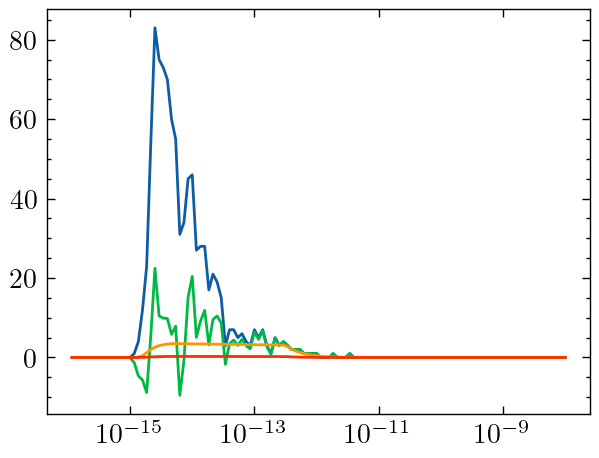

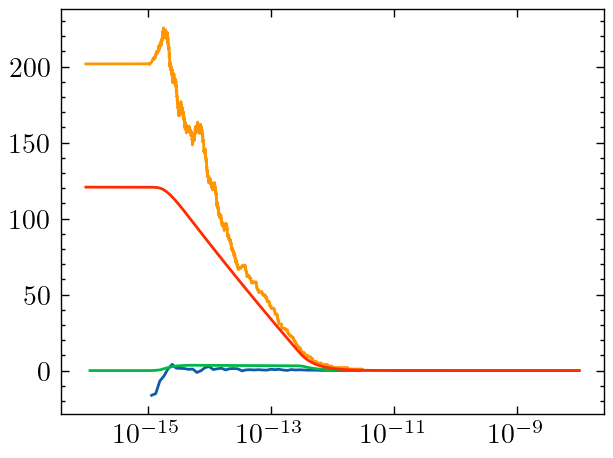

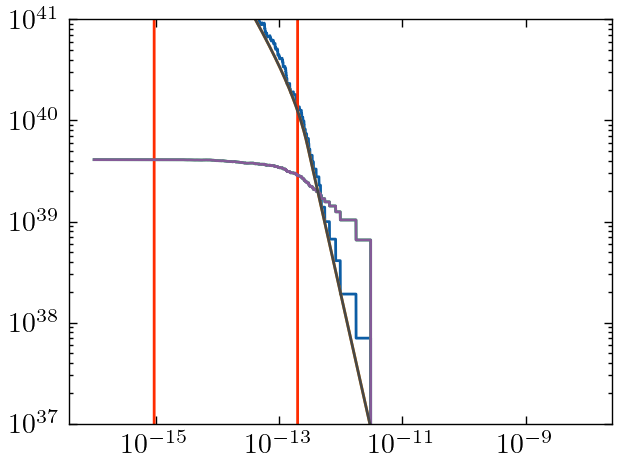

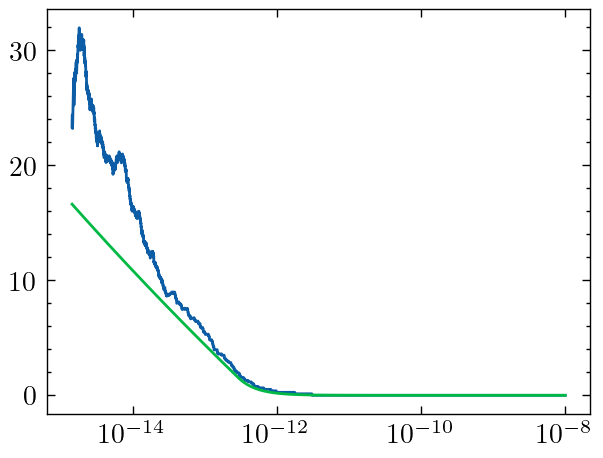

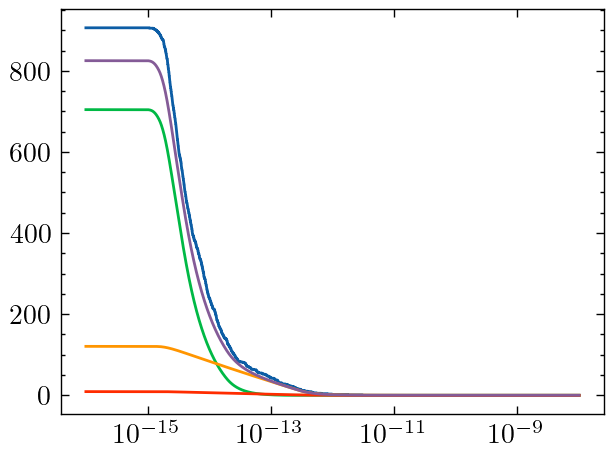

In [225]:
i = 8
region_label = 'All'
m = i+1

# ui.thaw(Back_AGN)
# ui.fit(1,9)

XLF_Data_band_region = XLF_Data_band[f'{region_label}']

def model(x,para):
    return brokenpl_dN(x,para[0:4])+power_law(x,para[4:6])#+cutoff_power_law(x,para[11:16]) #+cutoff_brokenpl_dN(x,para[6:11])
def LMXB_model(x,para):
    return cutoff_brokenpl_dN(x,para[6:11])
def HMXB_model(x,para):
    return cutoff_power_law(x,para[11:16])

exec(f"""para= tuple([i.val for i in {region_label}_source_model.pars])""")
exec(f"""print({region_label}_source_model)""")


exec(f"""model_dN = model(S_model,para) * dS_model * XLF_Data_band['{region_label}']['sky_area_function'] + LMXB_model(S_model,para) * dS_model * XLF_Data_band['{region_label}']['mass_function'] + HMXB_model(S_model,para) * dS_model * XLF_Data_band['{region_label}']['SFR_function']""")

# plt.plot(S_model,XLF_Data_band_region['dN_InSmallBin'])

def rebin_data(model_dN_corr):
    rebin_indices = np.floor(np.arange(len(model_dN_corr)) / expanded_times).astype(int)
    new_model_dN_corr = np.bincount(rebin_indices, weights=model_dN_corr)
    return new_model_dN_corr
    
plt.plot(data_bins[1:],rebin_data(XLF_Data_band_region['dN_InSmallBin']))    
AGN_model_dN = model(S_model,para) * dS_model * XLF_Data_band_region['sky_area_function']
plt.plot(data_bins[1:],rebin_data(AGN_model_dN))
LMXB_model_dN = LMXB_model(S_model,para) * dS_model * XLF_Data_band_region['mass_function']
plt.plot(data_bins[1:],rebin_data(LMXB_model_dN))
SFR_model_dN = LMXB_model(S_model,para) * dS_model * XLF_Data_band_region['SFR_function']
plt.plot(data_bins[1:],rebin_data(SFR_model_dN))
plt.xscale('log')
plt.show()


plt.plot(data_bins[1:],rebin_data(XLF_Data_band_region['dN_InSmallBin']))    
AGN_model_dN = model(S_model,para) * dS_model * XLF_Data_band_region['sky_area_function']
# plt.plot(data_bins[1:],rebin_data(AGN_model_dN))
plt.plot(data_bins[1:],rebin_data(XLF_Data_band_region['dN_InSmallBin'])-rebin_data(AGN_model_dN))    
LMXB_model_dN = LMXB_model(S_model,para) * dS_model * XLF_Data_band_region['mass_function']
plt.plot(data_bins[1:],rebin_data(LMXB_model_dN))
SFR_model_dN = LMXB_model(S_model,para) * dS_model * XLF_Data_band_region['SFR_function']
plt.plot(data_bins[1:],rebin_data(SFR_model_dN))
plt.xscale('log')
plt.show()


plt.plot(data_bins[1:],rebin_data((XLF_Data_band_region['dN_InSmallBin']-AGN_model_dN)/XLF_Data_band_region['mass_function']))
LMXB_model_dN = LMXB_model(S_model,para) * dS_model * XLF_Data_band_region['mass_function']
plt.plot(data_bins[1:],rebin_data(LMXB_model_dN))
plt.plot(S_model,np.cumsum(XLF_Data_band_region['dN_InSmallBin'][::-1])[::-1]-np.cumsum(AGN_model_dN[::-1])[::-1])
LMXB_model_dN = LMXB_model(S_model,para) * dS_model * XLF_Data_band_region['mass_function']
plt.plot(S_model,np.cumsum(LMXB_model_dN[::-1])[::-1] )
plt.xscale('log')
plt.show()



# plt.plot(data_bins[1:],rebin_data((XLF_Data_band_region['dN_InSmallBin']-AGN_model_dN)/XLF_Data_band_region['mass_function']))
# LMXB_model_dN = LMXB_model(S_model,para) * dS_model * XLF_Data_band_region['mass_function']
# plt.plot(data_bins[1:],rebin_data(LMXB_model_dN))
# plt.plot(S_model,3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*np.cumsum(S_model*XLF_Data_band_region['dN_InSmallBin'][::-1])[::-1])
# plt.plot(S_model,3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*np.cumsum(S_model*XLF_Data_band_region['dN_InSmallBin'][::-1])[::-1]-np.cumsum(S_model*AGN_model_dN[::-1])[::-1])
plt.plot(S_model,3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*(np.cumsum(S_model*XLF_Data_band_region['dN_InSmallBin'][::-1])[::-1]-np.cumsum(S_model*AGN_model_dN[::-1])[::-1]))
plt.plot(S_model,3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*(np.cumsum((S_model*(XLF_Data_band_region['dN_InSmallBin']-AGN_model_dN))[::-1])[::-1]))
LMXB_model_dN = LMXB_model(S_model,para) * dS_model * XLF_Data_band_region['mass_function']
plt.plot(S_model,3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*np.cumsum(S_model*LMXB_model_dN[::-1])[::-1] )
AGN_model_dN = model(S_model,para) * dS_model * XLF_Data_band_region['sky_area_function']
plt.plot(S_model,3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*AGN_model_dN )
YY = (np.cumsum((((XLF_Data_band_region['dN_InSmallBin']-AGN_model_dN)*S_model))[::-1])[::-1])
plt.plot(S_model,3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value*YY )
Lx = 3.1*(4*np.pi*(761*u.kpc)**2).to(u.cm**2).value* np.cumsum(S_model*(LMXB_model(S_model,para) * dS_model * np.max(XLF_Data_band[f'{region_label}']['mass_function']))[::-1])[::-1]
plt.plot(S_model,Lx )
    


plt.xscale('log')
plt.yscale('log')
plt.ylim([1e37,1e41])
plt.show()




plt.plot(S_model[S_model>XLF_Data_band_region['cutoff_sensitivity']],(np.cumsum(((XLF_Data_band_region['dN_InSmallBin']-AGN_model_dN)/XLF_Data_band_region['mass_function'])[::-1])[::-1])[S_model>XLF_Data_band_region['cutoff_sensitivity']])
LMXB_model_N_corr = np.cumsum((LMXB_model(S_model,para) * dS_model)[::-1])[::-1] #* XLF_Data_band_region['mass_function']
plt.plot(S_model[S_model>XLF_Data_band_region['cutoff_sensitivity']],LMXB_model_N_corr[S_model>XLF_Data_band_region['cutoff_sensitivity']])
plt.xscale('log')
# plt.yscale('log')
plt.show()







plt.plot(S_model,np.cumsum(XLF_Data_band_region['dN_InSmallBin'][::-1])[::-1])
AGN_model_dN = model(S_model,para) * dS_model * XLF_Data_band_region['sky_area_function']
plt.plot(S_model,np.cumsum(AGN_model_dN[::-1])[::-1] )
LMXB_model_dN = LMXB_model(S_model,para) * dS_model * XLF_Data_band_region['mass_function']
plt.plot(S_model,np.cumsum(LMXB_model_dN[::-1])[::-1] )
SFR_model_dN = LMXB_model(S_model,para) * dS_model * XLF_Data_band_region['SFR_function']
plt.plot(S_model,np.cumsum(SFR_model_dN[::-1])[::-1] )
plt.plot(S_model, np.cumsum(AGN_model_dN[::-1])[::-1] + np.cumsum(LMXB_model_dN[::-1])[::-1] )

plt.xscale('log')
plt.show()




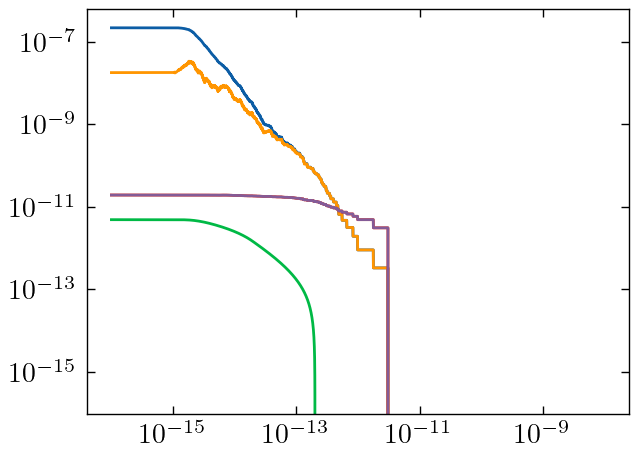

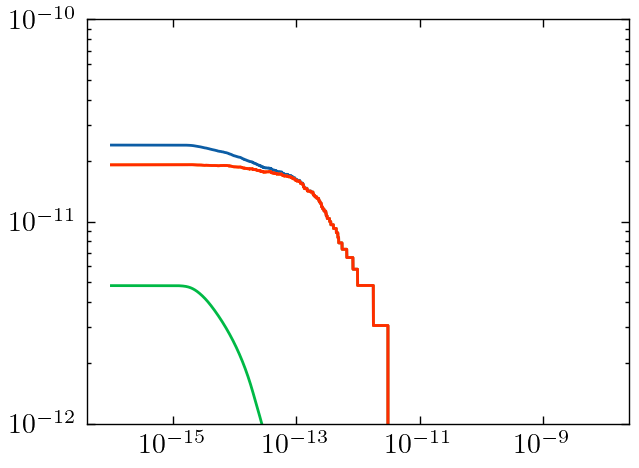

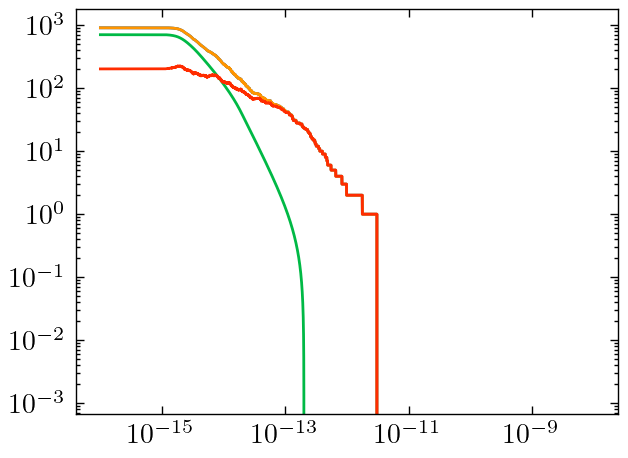

In [226]:
def cumsum_reverse(array):
    return np.cumsum(array[::-1])[::-1]

plt.plot(S_model,(np.cumsum(S_model*XLF_Data_band_region['dN_InSmallBin'][::-1])[::-1]))
plt.plot(S_model,(np.cumsum((S_model*AGN_model_dN)[::-1])[::-1]))
plt.plot(S_model,(np.cumsum(S_model*XLF_Data_band_region['dN_InSmallBin'][::-1])[::-1]-np.cumsum(S_model*AGN_model_dN[::-1])[::-1]))
plt.plot(S_model,(np.cumsum((S_model*(XLF_Data_band_region['dN_InSmallBin']-AGN_model_dN))[::-1])[::-1]))
plt.plot(S_model,(np.cumsum((S_model*(XLF_Data_band_region['dN_InSmallBin']-AGN_model_dN))[::-1])[::-1]))
plt.yscale('log')
plt.xscale('log')
plt.show()

plt.plot(S_model,(cumsum_reverse(S_model*XLF_Data_band_region['dN_InSmallBin'])))
plt.plot(S_model,(cumsum_reverse(S_model*AGN_model_dN)))
plt.plot(S_model,(cumsum_reverse(S_model*XLF_Data_band_region['dN_InSmallBin'])-cumsum_reverse(S_model*AGN_model_dN)))
plt.plot(S_model,(cumsum_reverse(S_model*(XLF_Data_band_region['dN_InSmallBin']-AGN_model_dN))))
# plt.plot(S_model,(np.cumsum(((XLF_Data_band_region['dN_InSmallBin']-AGN_model_dN))[::-1])[::-1]))
plt.yscale('log')
plt.xscale('log')
plt.ylim([1e-12,1e-10])
plt.show()

plt.plot(S_model,(cumsum_reverse(XLF_Data_band_region['dN_InSmallBin'])))
plt.plot(S_model,(cumsum_reverse(AGN_model_dN)))
plt.plot(S_model,(cumsum_reverse(XLF_Data_band_region['dN_InSmallBin'])-cumsum_reverse(S_model*AGN_model_dN)))
plt.plot(S_model,(cumsum_reverse((XLF_Data_band_region['dN_InSmallBin']-AGN_model_dN))))
# plt.plot(S_model,(np.cumsum(((XLF_Data_band_region['dN_InSmallBin']-AGN_model_dN))[::-1])[::-1]))
plt.yscale('log')
plt.xscale('log')

In [227]:
# i = 8
# region_label = 'All'
# m = i+1

# XLF_Data_band_region = XLF_Data_band[f'{region_label}']

# def model(x,para):
#     return brokenpl_dN(x,para[0:4])+power_law(x,para[4:6])#+cutoff_power_law(x,para[11:16]) #+cutoff_brokenpl_dN(x,para[6:11])
# def LMXB_model(x,para):
#     return cutoff_brokenpl_dN(x,para[6:11])
# def HMXB_model(x,para):
#     return cutoff_power_law(x,para[11:16])

# exec(f"""para= tuple([i.val for i in {region_label}_source_model.pars])""")
# exec(f"""print({region_label}_source_model)""")


# if region_label=='Center':
#     exec(f"""model_dN = model(S_model,para) * dS_model * XLF_Data_band['{region_label}']['sky_area_function'] + LMXB_model(S_model,para) * dS_model * XLF_Data_band['{region_label}']['mass_function']""")
# elif region_label!='Back' and region_label!='North' and region_label!='South':
#     exec(f"""model_dN = model(S_model,para) * dS_model * XLF_Data_band['{region_label}']['sky_area_function'] + LMXB_model(S_model,para) * dS_model * XLF_Data_band['{region_label}']['mass_function'] + HMXB_model(S_model,para) * dS_model * XLF_Data_band['{region_label}']['SFR_function']""")
# else:
#     exec(f"""model_dN = model(S_model,para) * dS_model * XLF_Data_band['{region_label}']['sky_area_function']""")
    
# exec(f"""cutoff_sensitivity=XLF_Data_band['{region_label}']['cutoff_sensitivity']""")
# exec(f"""XLF_Data_band_inner_dict=XLF_Data_band['{region_label}']""")

# rebin_indices = np.floor(np.arange(len(model_dN)) / expanded_times).astype(int)
# new_model_dN = np.bincount(rebin_indices, weights=model_dN)
# # plt.plot(S_data,new_model_dN)
# if region_label=='Center':
#     model_dN_corr = model(S_model,para) * dS_model + LMXB_model(S_model,para) * dS_model * XLF_Data_band[f'{region_label}']['mass_function']/XLF_Data_band[f'{region_label}']['sky_area_function']
# elif region_label!='Back' and region_label!='North' and region_label!='South' and region_label!='Back':
#     model_dN_corr = model(S_model,para) * dS_model + LMXB_model(S_model,para) * dS_model * XLF_Data_band[f'{region_label}']['mass_function']/XLF_Data_band[f'{region_label}']['sky_area_function']+ HMXB_model(S_model,para) * dS_model * XLF_Data_band[f'{region_label}']['SFR_function']/XLF_Data_band[f'{region_label}']['sky_area_function']
# else:
#     model_dN_corr = model(S_model,para) * dS_model
    
# rebin_indices = np.floor(np.arange(len(model_dN_corr)) / expanded_times).astype(int)
# new_model_dN_corr = np.bincount(rebin_indices, weights=model_dN_corr)
# new_model_N_corr = np.cumsum(new_model_dN_corr[::-1])[::-1]

# import matplotlib.pyplot as plt
# from matplotlib.gridspec import GridSpec

# exec(f"""dN = XLF_Data_band['{region_label}']['dN']""")
# exec(f"""N_corr = XLF_Data_band['{region_label}']['N_corr']""")


# # def model(x,para):
# #     return brokenpl_dN(x,para[0:4])+power_law(x,para[4:6]) #+cutoff_brokenpl_dN(x,para[6:11])+cutoff_power_law(x,para[11:16])


# rebin_indices = np.floor(np.arange(len(model_dN)) / expanded_times).astype(int)
# new_model_dN = np.bincount(rebin_indices, weights=model_dN)
# # plt.plot(S_data,new_model_dN)
# model_dN_corr = model(S_model,para) * dS_model #* sky_area_function
# rebin_indices = np.floor(np.arange(len(model_dN_corr)) / expanded_times).astype(int)
# new_model_dN_corr = np.bincount(rebin_indices, weights=model_dN_corr)
# new_model_N_corr = np.cumsum(new_model_dN_corr[::-1])[::-1]

# XLF_Data_band_region = XLF_Data_band[region_label]
# #     plt.step(data_bins[data_bins>XLF_Data_band_region['cutoff_sensitivity']][1:],XLF_Data_band_region['N_corr'][data_bins[:-1]>XLF_Data_band_region['cutoff_sensitivity']],where='pre',color='k')
# #     plt.step(data_bins[data_bins>XLF_Data_band_region['cutoff_sensitivity']][1:],new_model_N_corr[data_bins[:-1]>XLF_Data_band_region['cutoff_sensitivity']],where='pre',color='royalblue')
    
# plt.step(data_bins[data_bins>XLF_Data_band_region['cutoff_sensitivity']][1:],(XLF_Data_band_region['N_corr'])[data_bins[:-1]>XLF_Data_band_region['cutoff_sensitivity']],where='pre',alpha=0.8,label=region_label)
# plt.step(data_bins[data_bins>XLF_Data_band_region['cutoff_sensitivity']][1:],(XLF_Data_band_region['N_corr']-new_model_N_corr)[data_bins[:-1]>XLF_Data_band_region['cutoff_sensitivity']],where='pre',alpha=0.8,label=region_label)
# plt.step(data_bins[data_bins>XLF_Data_band_region['cutoff_sensitivity']][1:],(new_model_N_corr)[data_bins[:-1]>XLF_Data_band_region['cutoff_sensitivity']],where='pre',alpha=0.8,label=region_label)
# plt.xscale('log')
# plt.yscale('log')
# plt.show()


# def model(x,para):
#     return brokenpl_dN(x,para[0:4])+power_law(x,para[4:6])#+cutoff_power_law(x,para[11:16]) #+cutoff_brokenpl_dN(x,para[6:11])
# dN = XLF_Data_band[f'{region_label}']['dN']
# # sky_area_function = XLF_Data_band[f'{region_label}']['sky_area_function']
# # mass_function = XLF_Data_band[f'{region_label}']['mass_function']
# AGN_model_dN = model(S_model,para) * dS_model * sky_area_function
# rebin_indices = np.floor(np.arange(len(AGN_model_dN)) / expanded_times).astype(int)
# AGN_model_dN = np.bincount(rebin_indices, weights=model_dN)

# plt.step(data_bins[1:],dN)
# plt.step(data_bins[data_bins>XLF_Data_band_region['cutoff_sensitivity']][1:],AGN_model_dN[data_bins[:-1]>XLF_Data_band_region['cutoff_sensitivity']],where='pre',alpha=0.8,)

# plt.step(data_bins[data_bins>XLF_Data_band_region['cutoff_sensitivity']][1:],(dN-AGN_model_dN)[data_bins[:-1]>XLF_Data_band_region['cutoff_sensitivity']],where='pre',alpha=0.8,)
# plt.ylim([1e-1,200])
# plt.xscale('log')

# plt.show()


# remaining_LMXB_dN = dN-AGN_model_dN

# remaining_LMXB_dN

# # dN_corr,bins = np.histogram(Filtered_SourceFlux, bins=data_bins,weights=weight)
# # N_corr = np.cumsum(dN_corr[::-1])[::-1]
# # square_dN_err_corr,bins = np.histogram(Filtered_SourceFlux, bins=data_bins,weights=weight**2)
# # square_N_err_corr = np.cumsum(square_dN_err_corr[::-1])[::-1]
# # N_err_corr = np.sqrt(square_N_err_corr)
# AGN_model_dN = model(S_model,para) * dS_model * sky_area_function
# dN_InSmallBin = XLF_Data_band_region['dN_InSmallBin']
# print(AGN_model_dN.shape)
# print(dN_InSmallBin.shape)


# plt.step(S_model,np.cumsum((AGN_model_dN)[::-1])[::-1],label='AGN,N')
# plt.step(S_model,np.cumsum((dN_InSmallBin)[::-1])[::-1],color='k',alpha=0.5,label='N')
# plt.step(S_model,np.cumsum((dN_InSmallBin)[::-1])[::-1]/np.max(XLF_Data_band_region['sky_area_function']),color='k',label='N/area')


# remaining_LMXB_dN = dN_InSmallBin-AGN_model_dN.value
# remaining_LMXB_N_corr = np.cumsum((remaining_LMXB_dN/XLF_Data_band_region['mass_function'])[::-1])[::-1]
# plt.step(S_model,remaining_LMXB_N_corr,label='remaining_LMXB_N_corr')

# remaining_LMXB_dN = dN_InSmallBin-AGN_model_dN.value
# remaining_LMXB_N_corr = np.cumsum((remaining_LMXB_dN)[::-1])[::-1]
# plt.step(S_model,remaining_LMXB_N_corr)

# LMXB_dN = LMXB_model(S_model,para) * dS_model #* mass_function
# model_LMXB_N_corr = np.cumsum((LMXB_dN)[::-1])[::-1]
# plt.step(S_model,model_LMXB_N_corr)

# plt.ylim([1e-1,500])
# plt.xscale('log')
# plt.yscale('log')
# plt.legend()
# plt.show()

# plt.plot(S_model,XLF_Data_band_region['sky_area_function'])
# plt.plot(S_model,XLF_Data_band_region['mass_function'])
# plt.xscale('log')


In [228]:
# for i,region_label in enumerate(['Back','North','South','Center','Disk','Ring','InnerArm','InterArm','All']):
#     print(i+1,region_label)
#     m = i+1
#     if m not in [4,5,6,7,8]:
#         continue
#     if region_label=='Back' or  region_label == 'North' or  region_label == 'South':
#         def model(x,para):
#             return brokenpl_dN(x,para[0:4])+power_law(x,para[4:])
#     elif region_label=='Center':
#         def model(x,para):
#             return brokenpl_dN(x,para[0:4])+power_law(x,para[4:6]) #+cutoff_brokenpl_dN(x,para[6:11])
#     else:
#         def model(x,para):
#             return brokenpl_dN(x,para[0:4])+power_law(x,para[4:6]) #+cutoff_brokenpl_dN(x,para[6:11])+cutoff_power_law(x,para[11:16])
    
#     exec(f"""para= tuple([i.val for i in {region_label}_source_model.pars])""")
# #     exec(f"""print({region_label}_source_model)""")
#     exec(f"""model_dN = model(S_model,para) * dS_model * XLF_Data_band['{region_label}']['sky_area_function']""")
#     exec(f"""cutoff_sensitivity=XLF_Data_band['{region_label}']['cutoff_sensitivity']""")
#     exec(f"""XLF_Data_band_inner_dict=XLF_Data_band['{region_label}']""")
    
#     rebin_indices = np.floor(np.arange(len(model_dN)) / expanded_times).astype(int)
#     new_model_dN = np.bincount(rebin_indices, weights=model_dN)
#     # plt.plot(S_data,new_model_dN)
#     model_dN_corr = model(S_model,para) * dS_model #* sky_area_function
#     rebin_indices = np.floor(np.arange(len(model_dN_corr)) / expanded_times).astype(int)
#     new_model_dN_corr = np.bincount(rebin_indices, weights=model_dN_corr)
#     new_model_N_corr = np.cumsum(new_model_dN_corr[::-1])[::-1]

#     import matplotlib.pyplot as plt
#     from matplotlib.gridspec import GridSpec

#     exec(f"""dN = XLF_Data_band['{region_label}']['dN']""")
#     exec(f"""N_corr = XLF_Data_band['{region_label}']['N_corr']""")
    
#     XLF_Data_band_region = XLF_Data_band[region_label]
# #     plt.step(data_bins[data_bins>XLF_Data_band_region['cutoff_sensitivity']][1:],XLF_Data_band_region['N_corr'][data_bins[:-1]>XLF_Data_band_region['cutoff_sensitivity']],where='pre',color='k')
# #     plt.step(data_bins[data_bins>XLF_Data_band_region['cutoff_sensitivity']][1:],new_model_N_corr[data_bins[:-1]>XLF_Data_band_region['cutoff_sensitivity']],where='pre',color='royalblue')
    
#     plt.step(data_bins[data_bins>XLF_Data_band_region['cutoff_sensitivity']][1:],(XLF_Data_band_region['N_corr']-new_model_N_corr)[data_bins[:-1]>XLF_Data_band_region['cutoff_sensitivity']],where='pre',alpha=0.8,label=region_label)
    
# plt.yscale('log')
# plt.xscale('log')
# plt.ylim(0.8,2e4)
# plt.ylabel('$N(>S)/\mathrm{area}~\mathrm{(deg^{-2})}$')
# plt.xlabel('$S\mathrm{_{2-4.5~keV}~(erg~s^{-1}~cm^{-2})}$')        
# plt.xticks([1e-14,1e-13,1e-12],)
# plt.xlim([1e-15,4e-12])
# plt.legend()


# SFR_per_deg = 0.152/0.1880*10

# plt.plot(S_/3.124, HMXB_N(S_,SFR_per_deg*2.06,1.66),color='deeppink',ls=':',alpha=0.5,label='HMXB\nMineo et al. 2012')
# plt.plot(S_/3.124, HMXB_N(S_,SFR_per_deg*1.96,1.65),color='deeppink',ls=':',label='HMXB\nLehmer et al. 2019')


# plt.plot(S_/3.124, HMXB_N(S_,SFR_per_deg*1.96,1.01),color='deeppink',ls=':',label='HMXB\nLehmer et al. 2019')

# # plt.plot(S_/3.124, HMXB_N(S_,SFR_per_deg*2.06,1.4),color='lime',ls=':',alpha=0.5,label='HMXB\nMineo et al. 2012')
# # plt.plot(S_/3.124, HMXB_N(S_,SFR_per_deg*1.96,1.4),color='lime',ls=':',label='HMXB\nLehmer et al. 2019')

# #     plt.show()
    
    
    

In [229]:
import seaborn as sns
icefire = sns.color_palette("icefire",8)
icefire

[(0.42110294, 0.69916972, 0.80506683),
 (0.2157176, 0.47827123, 0.81487615),
 (0.2659204, 0.25949691, 0.511417),
 (0.14254381, 0.14016944, 0.18944326),
 (0.19884415, 0.12394381, 0.1385669),
 (0.47151732, 0.17401641, 0.24610337),
 (0.78979746, 0.24694858, 0.22678822),
 (0.93850535, 0.52748892, 0.28242464)]

In [230]:
# for i,region_label in enumerate(['Back','North','South','Disk','Center','InnerArm','Ring','InterArm','All']):
#     print(i+1,region_label)
#     m = i+1
#     if m not in [4,5,6,7,8,9]:
#         continue
#     if region_label=='Back' or  region_label == 'North' or  region_label == 'South':
#         def model(x,para):
#             return brokenpl_dN(x,para[0:4])+power_law(x,para[4:])
#     elif region_label=='Center':
#         def model(x,para):
#             return brokenpl_dN(x,para[0:4])+power_law(x,para[4:6]) #+cutoff_brokenpl_dN(x,para[6:11])
#     else:
#         def model(x,para):
#             return brokenpl_dN(x,para[0:4])+power_law(x,para[4:6]) #+cutoff_brokenpl_dN(x,para[6:11])+cutoff_power_law(x,para[11:16])
    
#     exec(f"""para= tuple([i.val for i in {region_label}_source_model.pars])""")
# #     exec(f"""print({region_label}_source_model)""")
#     exec(f"""model_dN = model(S_model,para) * dS_model * XLF_Data_band['{region_label}']['sky_area_function']""")
#     exec(f"""cutoff_sensitivity=XLF_Data_band['{region_label}']['cutoff_sensitivity']""")
#     exec(f"""XLF_Data_band_inner_dict=XLF_Data_band['{region_label}']""")
    
#     rebin_indices = np.floor(np.arange(len(model_dN)) / expanded_times).astype(int)
#     new_model_dN = np.bincount(rebin_indices, weights=model_dN)
#     # plt.plot(S_data,new_model_dN)
#     model_dN_corr = model(S_model,para) * dS_model #* sky_area_function
#     rebin_indices = np.floor(np.arange(len(model_dN_corr)) / expanded_times).astype(int)
#     new_model_dN_corr = np.bincount(rebin_indices, weights=model_dN_corr)
#     new_model_N_corr = np.cumsum(new_model_dN_corr[::-1])[::-1]

#     if region_label=='Back' or  region_label == 'North' or  region_label == 'South':
#         pass
# #         def model(x,para):
# #             return brokenpl_dN(x,para[0:4])+power_law(x,para[4:])
#     elif region_label=='Center':
#         def model(x,para):
#             return cutoff_brokenpl_dN(x,para[6:11])
#     else:
#         def model(x,para):
#             return cutoff_brokenpl_dN(x,para[6:11])+cutoff_power_law(x,para[11:16])
    
#     exec(f"""para= tuple([i.val for i in {region_label}_source_model.pars])""")
# #     exec(f"""print({region_label}_source_model)""")
#     exec(f"""model_dN = model(S_model,para) * dS_model * XLF_Data_band['{region_label}']['sky_area_function']""")
#     exec(f"""cutoff_sensitivity=XLF_Data_band['{region_label}']['cutoff_sensitivity']""")
#     exec(f"""XLF_Data_band_inner_dict=XLF_Data_band['{region_label}']""")
    
#     rebin_indices = np.floor(np.arange(len(model_dN)) / expanded_times).astype(int)
#     new_model_dN = np.bincount(rebin_indices, weights=model_dN)
#     # plt.plot(S_data,new_model_dN)
#     model_dN_corr = model(S_model,para) * dS_model #* sky_area_function
#     rebin_indices = np.floor(np.arange(len(model_dN_corr)) / expanded_times).astype(int)
#     new_model_dN_corr = np.bincount(rebin_indices, weights=model_dN_corr)
#     LMXB_new_model_N_corr = np.cumsum(new_model_dN_corr[::-1])[::-1]

    
#     import matplotlib.pyplot as plt
#     from matplotlib.gridspec import GridSpec

#     exec(f"""dN = XLF_Data_band['{region_label}']['dN']""")
#     exec(f"""N_corr = XLF_Data_band['{region_label}']['N_corr']""")
    
#     XLF_Data_band_region = XLF_Data_band[region_label]
# #     plt.step(data_bins[data_bins>XLF_Data_band_region['cutoff_sensitivity']][1:],XLF_Data_band_region['N_corr'][data_bins[:-1]>XLF_Data_band_region['cutoff_sensitivity']],where='pre',color='k')
# #     plt.step(data_bins[data_bins>XLF_Data_band_region['cutoff_sensitivity']][1:],new_model_N_corr[data_bins[:-1]>XLF_Data_band_region['cutoff_sensitivity']],where='pre',color='royalblue')
#     if region_label == "Back":
#         label = 'Background'
#     elif region_label == "Ring":
#         label = 'Region3: Ring'
#         label = 'Region3'
#     elif region_label == "Center":
#         label = 'Region1: Center'
#         label = 'Region1'
#     elif region_label == "InnerArm":
#         label = 'Region2: InnerArm'
#         label = 'Region2'
#     elif region_label == "InterArm":
#         label = 'Region4: InterArm'
#         label = 'Region4'
#     else:
#         label = region_label

#     print(i+1,region_label,label)
#     if region_label =='Center':
#         color='magenta'
#     elif region_label =='Disk':
#         color= icefire[3]
#     elif region_label =='Ring':
#         color='green'
#     elif region_label =='InnerArm':
#         color='orange'
#     elif region_label =='InterArm':
#         color='royalblue'
#     print(region_label)
#     sky_area_function = np.nanmax(XLF_Data_band_region['sky_area_function'])
#     print(f'{sky_area_function:.1f}')
#     plt.step(data_bins[data_bins>XLF_Data_band_region['cutoff_sensitivity']][1:],np.nanmax(XLF_Data_band_region['sky_area_function'])*(XLF_Data_band_region['N_corr']-new_model_N_corr)[data_bins[:-1]>XLF_Data_band_region['cutoff_sensitivity']],where='pre',color=color,alpha=0.8,label=label)
#     x = np.sqrt((data_bins[data_bins>XLF_Data_band_region['cutoff_sensitivity']][1:])*(data_bins[data_bins>XLF_Data_band_region['cutoff_sensitivity']][:-1]))
#     plt.plot(x,np.nanmax(XLF_Data_band_region['sky_area_function'])*(LMXB_new_model_N_corr)[data_bins[:-1]>XLF_Data_band_region['cutoff_sensitivity']],color=color,linestyle='--',alpha=0.8)
#     plt.fill_between(data_bins[data_bins>XLF_Data_band_region['cutoff_sensitivity']][1:], \
#                      np.nanmax(XLF_Data_band_region['sky_area_function'])*(XLF_Data_band_region['N_corr']-new_model_N_corr-XLF_Data_band_region['N_err_corr'])[data_bins[:-1]>cutoff_sensitivity], \
#                      np.nanmax(XLF_Data_band_region['sky_area_function'])*(XLF_Data_band_region['N_corr']-new_model_N_corr+XLF_Data_band_region['N_err_corr'])[data_bins[:-1]>cutoff_sensitivity], \
#                  facecolor='w',step='pre',edgecolors=color,alpha=0.08, hatch=['/',"\\", '|', '--------','||||||', '+++++', '......', '\\\\\\\\\\\\\\', '///////', '****', '*','/',"\\", '|', '--------'][i],) # {'/', '\', '|', '-', '+', 'x', 'o', 'O', '.', '*'} 
#     print(np.nanmax(np.nanmax(XLF_Data_band_region['sky_area_function'])*(XLF_Data_band_region['N_corr']-new_model_N_corr)[data_bins[:-1]>XLF_Data_band_region['cutoff_sensitivity']]))
    
# legend1 = plt.legend()

# # plt.subplot(111)
# band_ratio = 1.9085278159246946 # 2.0-10.0 keV to 2.0-4.5 keV # index = 2.1
# L = np.logspace(35.3,38.4,60)
# N = 20*(L/10**36)**(-0.64)
# # plt.plot(luminosity2flux(L),N,'--',color='orange',label='HMXB of MW')
# line1, = plt.plot(luminosity2flux(L)/band_ratio,N,':',alpha=0.99,color='springgreen',label='HMXB of MW')
# band_ratio = 1.9 # 2.0-10.0 keV to 2.0-4.5 keV, index=2.1
# L = np.logspace(35.3,38.4,60)
# N = 105*((L/10**36)**(-0.26)-270**(-0.26))
# line2, = plt.plot(luminosity2flux(L)/band_ratio,N,':',alpha=0.99,color='tomato',label='LMXB of MW')

# # Specify the handles for the legend
# handles = [line1, line2]
# # Add legend using specified handles
# plt.legend(handles=handles, loc='lower left', bbox_to_anchor=(0, 0),fontsize=7)

# plt.gca().add_artist(legend1)

# plt.yscale('log')
# plt.xscale('log')
# plt.ylim(0.8,2e2)
# plt.ylabel('$N(>S)$')
# plt.xlabel('$S\mathrm{_{2-4.5~keV}~(erg~s^{-1}~cm^{-2})}$')        
# plt.xticks([1e-14,1e-13,1e-12],)
# plt.xlim([1e-15,4e-12])


# # SFR_per_deg = 0.152/0.1880*10

# # plt.plot(S_/3.124, HMXB_N(S_,SFR_per_deg*2.06,1.66),color='deeppink',ls=':',alpha=0.5,label='HMXB\nMineo et al. 2012')
# # plt.plot(S_/3.124, HMXB_N(S_,SFR_per_deg*1.96,1.65),color='deeppink',ls=':',label='HMXB\nLehmer et al. 2019')

# # plt.plot(S_/3.124, HMXB_N(S_,SFR_per_deg*2.06,1.4),color='lime',ls=':',alpha=0.5,label='HMXB\nMineo et al. 2012')
# # plt.plot(S_/3.124, HMXB_N(S_,SFR_per_deg*1.96,1.4),color='lime',ls=':',label='HMXB\nLehmer et al. 2019')

# #     plt.show()
    
# # SFR_per_deg = 0.4 /np.max(XLF_Data_band['Disk']['sky_area_function'])
# # plt.plot(S_/3.124, HMXB_N(S_,SFR_per_deg*np.max(XLF_Data_band['Disk']['sky_area_function']),1.66),color='springgreen',ls=':',alpha=0.5,label='HMXB\nMineo et al. 2012')
# # stellar_mass_per_deg = XLF_Data_band['Disk']['StellarMass']/np.max(XLF_Data_band['Disk']['sky_area_function'])
# # plt.plot(S_/3.124, LMXB_N(S_,stellar_mass_per_deg*4.15,1.02,2.06,144.3*0.546),color='violet',alpha=0.99,ls=':',label='LMXB\nZhang et al. 2012')
# # # plt.plot(S_/3.124, LMXB_N(S_,stellar_mass_per_deg*4.15,1.02,2.06,144.3*0.546)/10,color='violet',alpha=0.3,ls=':',label='LMXB\nZhang et al. 2012')
# # # plt.plot(S_/3.124, LMXB_N(S_,stellar_mass_per_deg*4.15,1.02,2.06,144.3*0.546)/100,color='violet',alpha=0.3,ls=':',label='LMXB\nZhang et al. 2012')
    
    
    
# # plt.savefig('figure/M31_XLF_N_corr_v4.pdf',bbox_inches='tight')
    
# # plt.plot(S_/3.124, HMXB_N(S_,SFR_per_deg*2.06,1.66),color='deeppink',ls=':',alpha=0.5,label='HMXB\nMineo et al. 2012')
# # plt.plot(S_/3.124, HMXB_N(S_,SFR_per_deg*1.96,1.65),color='deeppink',ls=':',label='HMXB\nLehmer et al. 2019')


In [231]:
# InterArm_LMXB.fb = 50
# InterArm_LMXB.fb.max=100
# InterArm_LMXB.fb.freeze()
# ui.fit(8)
# InterArm_LMXB.fb.thaw()
# ui.fit(8)
# InterArm_LMXB.fb.max=500
# ui.fit(8)
# # ui.covar(8)
# # ui.covar(InterArm_LMXB.K)
# # ui.covar(InterArm_LMXB.beta1)
# # ui.covar(InterArm_LMXB.beta2)


1 Back
2 North
3 South
4 Center
4 Center Center
1.9830265192599978
5 Disk
5 Disk Disk
6.462883786874889
6 Ring
6 Ring Ring
2.109157677185452
7 InnerArm
7 InnerArm InnerArm
1.8128505717413286
8 InterArm
8 InterArm InterArm
1.8756171659581393


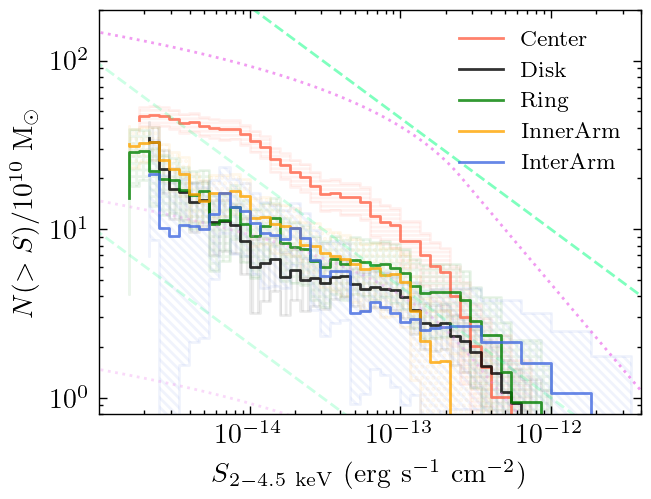

In [232]:
# # version 1
# XLF_Data_band['Center']['StellarMass'] = 25.872/10
# XLF_Data_band['Disk']['StellarMass'] = 25.172/10
# XLF_Data_band['Arm2']['StellarMass'] = 9.469/10
# # XLF_Data_band['Arm015']['StellarMass'] = 10.412/10
# XLF_Data_band['Arm152']['StellarMass'] = 3.217/10
# # version 2
# XLF_Data_band['Center']['StellarMass'] = 27.903/10
# XLF_Data_band['Disk']['StellarMass'] = 46.620/10
# XLF_Data_band['Arm2']['StellarMass'] = 12.234/10
# # XLF_Data_band['Arm015']['StellarMass'] = 13.422/10
# XLF_Data_band['Arm152']['StellarMass'] = 4.284/10

# # version 3
# XLF_Data_band['Center']['StellarMass'] = 27.903/10
# XLF_Data_band['Disk']['StellarMass'] = 46.620/10
# XLF_Data_band['Arm2']['StellarMass'] = 13.66/10
# # XLF_Data_band['Arm015']['StellarMass'] = 11.703/10
# XLF_Data_band['Arm152']['StellarMass'] = 4.687/10


for i,region_label in enumerate(['Back','North','South','Center','Disk','Ring','InnerArm','InterArm',]):
    print(i+1,region_label)
    m = i+1
    if m not in [4,5,6,7,8,]:
        continue
    if region_label=='Back' or  region_label == 'North' or  region_label == 'South':
        def model(x,para):
            return brokenpl_dN(x,para[0:4])+power_law(x,para[4:])
    elif region_label=='Center':
        def model(x,para):
            return brokenpl_dN(x,para[0:4])+power_law(x,para[4:6]) #+cutoff_brokenpl_dN(x,para[6:11])
    else:
        def model(x,para):
            return brokenpl_dN(x,para[0:4])+power_law(x,para[4:6]) #+cutoff_brokenpl_dN(x,para[6:11])+cutoff_power_law(x,para[11:16])
    
    exec(f"""para= tuple([i.val for i in {region_label}_source_model.pars])""")
#     exec(f"""print({region_label}_source_model)""")
    exec(f"""model_dN = model(S_model,para) * dS_model * XLF_Data_band['{region_label}']['sky_area_function']""")
    exec(f"""cutoff_sensitivity=XLF_Data_band['{region_label}']['cutoff_sensitivity']""")
    exec(f"""XLF_Data_band_inner_dict=XLF_Data_band['{region_label}']""")
    
    rebin_indices = np.floor(np.arange(len(model_dN)) / expanded_times).astype(int)
    new_model_dN = np.bincount(rebin_indices, weights=model_dN)
    # plt.plot(S_data,new_model_dN)
    model_dN_corr = model(S_model,para) * dS_model #* sky_area_function
    rebin_indices = np.floor(np.arange(len(model_dN_corr)) / expanded_times).astype(int)
    new_model_dN_corr = np.bincount(rebin_indices, weights=model_dN_corr)
    new_model_N_corr = np.cumsum(new_model_dN_corr[::-1])[::-1]

    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec

    exec(f"""dN = XLF_Data_band['{region_label}']['dN']""")
    exec(f"""N_corr = XLF_Data_band['{region_label}']['N_corr']""")
    
    XLF_Data_band_region = XLF_Data_band[region_label]
#     plt.step(data_bins[data_bins>XLF_Data_band_region['cutoff_sensitivity']][1:],XLF_Data_band_region['N_corr'][data_bins[:-1]>XLF_Data_band_region['cutoff_sensitivity']],where='pre',color='k')
#     plt.step(data_bins[data_bins>XLF_Data_band_region['cutoff_sensitivity']][1:],new_model_N_corr[data_bins[:-1]>XLF_Data_band_region['cutoff_sensitivity']],where='pre',color='royalblue')
    if region_label == "Back":
        label = 'Background'
    else:
        label = region_label

    print(i+1,region_label,label)
    if region_label =='Center':
        color='tomato'
    elif region_label =='Disk':
        color='k'
    elif region_label =='Ring':
        color='green'
    elif region_label =='InnerArm':
        color='orange'
    elif region_label =='InterArm':
        color='royalblue'

    print(XLF_Data_band_region['StellarMass'])
    plt.step(data_bins[data_bins>XLF_Data_band_region['cutoff_sensitivity']][1:],1/XLF_Data_band_region['StellarMass'] *np.nanmax(XLF_Data_band_region['sky_area_function'])*(XLF_Data_band_region['N_corr']-new_model_N_corr)[data_bins[:-1]>XLF_Data_band_region['cutoff_sensitivity']],color=color,where='pre',alpha=0.8,label=label)
    plt.fill_between(data_bins[data_bins>XLF_Data_band_region['cutoff_sensitivity']][1:], \
                     1/XLF_Data_band_region['StellarMass'] *np.nanmax(XLF_Data_band_region['sky_area_function'])*(XLF_Data_band_region['N_corr']-new_model_N_corr-XLF_Data_band_region['N_err_corr'])[data_bins[:-1]>cutoff_sensitivity], \
                     1/XLF_Data_band_region['StellarMass'] *np.nanmax(XLF_Data_band_region['sky_area_function'])*(XLF_Data_band_region['N_corr']-new_model_N_corr+XLF_Data_band_region['N_err_corr'])[data_bins[:-1]>cutoff_sensitivity], \
                 facecolor='w',step='pre',edgecolors=color,alpha=0.08, hatch=['/',"\\", '|', '--------','||||||', '+++++', '......', '\\\\\\\\\\\\\\', '///////', '****', '*','.','.','.','.','.','.','.'][i],) # {'/', '\', '|', '-', '+', 'x', 'o', 'O', '.', '*'} 
    
plt.yscale('log')
plt.xscale('log')
plt.ylim(0.8,2e2)
plt.ylabel('$N(>S)/10^{10}~\mathrm{M_{\odot}}$')
plt.xlabel('$S\mathrm{_{2-4.5~keV}~(erg~s^{-1}~cm^{-2})}$')        
plt.xticks([1e-14,1e-13,1e-12],)
plt.xlim([1e-15,4e-12])
plt.legend(fontsize=8)


# SFR_per_deg = 0.152/0.1880*10

# plt.plot(S_/3.124, HMXB_N(S_,SFR_per_deg*2.06,1.66),color='deeppink',ls=':',alpha=0.5,label='HMXB\nMineo et al. 2012')
# plt.plot(S_/3.124, HMXB_N(S_,SFR_per_deg*1.96,1.65),color='deeppink',ls=':',label='HMXB\nLehmer et al. 2019')

# plt.plot(S_/3.124, HMXB_N(S_,SFR_per_deg*2.06,1.4),color='lime',ls=':',alpha=0.5,label='HMXB\nMineo et al. 2012')
# plt.plot(S_/3.124, HMXB_N(S_,SFR_per_deg*1.96,1.4),color='lime',ls=':',label='HMXB\nLehmer et al. 2019')

#     plt.show()
    
plt.savefig('figure/M31_XLF_N_corr_per_StellarMassV2.pdf',bbox_inches='tight')

SFR_per_deg = 0.152/0.1880*10
plt.plot(S_/3.124, HMXB_N(S_,SFR_per_deg*2.06,1.66),color='springgreen',ls='--',alpha=0.5,label='HMXB\nMineo et al. 2012')
plt.plot(S_/3.124, HMXB_N(S_,SFR_per_deg*2.06,1.66)/10,color='springgreen',ls='--',alpha=0.2,label='HMXB\nMineo et al. 2012')
plt.plot(S_/3.124, HMXB_N(S_,SFR_per_deg*2.06,1.66)/100,color='springgreen',ls='--',alpha=0.2,label='HMXB\nMineo et al. 2012')
stellar_mass_per_deg = XLF_Data_band['Disk']['StellarMass']/np.max(XLF_Data_band['Disk']['sky_area_function'])
plt.plot(S_/3.124, LMXB_N(S_,stellar_mass_per_deg*4.15,1.02,2.06,144.3*0.546),color='violet',alpha=0.8,ls=':',label='LMXB\nZhang et al. 2012')
plt.plot(S_/3.124, LMXB_N(S_,stellar_mass_per_deg*4.15,1.02,2.06,144.3*0.546)/10,color='violet',alpha=0.3,ls=':',label='LMXB\nZhang et al. 2012')
plt.plot(S_/3.124, LMXB_N(S_,stellar_mass_per_deg*4.15,1.02,2.06,144.3*0.546)/100,color='violet',alpha=0.3,ls=':',label='LMXB\nZhang et al. 2012')

    
    



In [233]:
North_AGN.beta1 = 2.2
North_AGN.beta2 = 2.7
North_AGN.K = 130
North_AGN.fb = 2
South_AGN.beta1 = 2.2
South_AGN.beta2 = 2.7
South_AGN.K = 130
South_AGN.fb = 2
ui.thaw(North_AGN)
ui.thaw(South_AGN)
ui.fit(2,3)
# ui.show_all()

Datasets              = 2, 3
Method                = neldermead
Statistic             = cstat
Initial fit statistic = 100.471
Final fit statistic   = 43.5865 at function evaluation 5565
Data points           = 191
Degrees of freedom    = 181
Probability [Q-value] = 1
Reduced statistic     = 0.240809
Change in statistic   = 56.8842
   North_AGN.K    276.651     
   North_AGN.beta1   1.04502     
   North_AGN.beta2   2.46103     
   North_AGN.fb   0.612929    
   North_star.A   0.0467676   
   South_AGN.K    86.7269     
   South_AGN.beta1   2.2412      
   South_AGN.beta2   17.7811     
   South_AGN.fb   3.7341      
   South_star.A   31.5316     


In [520]:
plt.style.use('science')

region_label = 'North'
XLF_Data_band_region = XLF_Data_band[region_label]
XLF_Data_band_region['N'][data_bins[1:]>1e-14][0]


region_label = 'South'
XLF_Data_band_region = XLF_Data_band[region_label]
XLF_Data_band_region['N'][data_bins[1:]>1e-14][0]


# 97, 84 # 这是 N_corr
np.max(XLF_Data_band_region['sky_area_function'][S_model<1e-14])

# # S_model.shape
# plt.plot(S_model, XLF_Data_band_region['sky_area_function'])
# plt.xscale('log')

1.3174518518518257

North 97.2928197017597 7.117083825536472
North 1e-15 404.92846899474137
North area 2.499172839506123
North area at 1e-14 1.8369592592592228
South 84.29885857179244 7.489154866857327
South 1e-15 417.8327200905384
South area 2.2047333333332895
South area at 1e-14 1.3174518518518257
Luo: 79.21457091054785
Luo 1e-15: 545.8968949379819
(95,) (95,)


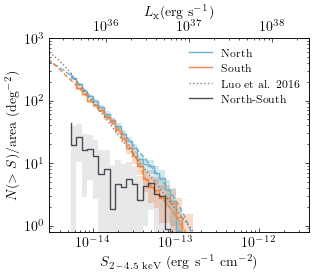

In [522]:
plt.figure(figsize=(3.35,3.35/4*3))
region_label = 'North'
XLF_Data_band_region = XLF_Data_band[region_label]
cutoff_sensitivity = XLF_Data_band_region['cutoff_sensitivity']
color = icefire[0]
label = region_label
plt.step(data_bins[data_bins>XLF_Data_band_region['cutoff_sensitivity']][1:],(XLF_Data_band_region['N_corr'])[data_bins[:-1]>XLF_Data_band_region['cutoff_sensitivity']],where='pre',color=color,alpha=1.0,label=label)
plt.fill_between(data_bins[data_bins>cutoff_sensitivity][1:], \
                 (XLF_Data_band_region['N_corr']-XLF_Data_band_region['N_err_corr'])[data_bins[:-1]>cutoff_sensitivity],(XLF_Data_band_region['N_corr']+XLF_Data_band_region['N_err_corr'])[data_bins[:-1]>cutoff_sensitivity], \
                 color=color,step='pre',edgecolors=None,alpha=0.3)
print('North',XLF_Data_band_region['N_corr'][data_bins[1:]>1e-14][0], XLF_Data_band_region['N_err_corr'][data_bins[1:]>1e-14][0])
def model(x,para):
    return brokenpl_dN(x,para[0:4])+power_law(x,para[4:])    
exec(f"""para= tuple([i.val for i in {region_label}_source_model.pars])""")
model_dN_corr = model(S_model,para) * dS_model #* sky_area_function
rebin_indices = np.floor(np.arange(len(model_dN_corr)) / expanded_times).astype(int)
new_model_dN_corr = np.bincount(rebin_indices, weights=model_dN_corr)
new_model_N_corr = np.cumsum(new_model_dN_corr[::-1])[::-1]
plt.plot(np.sqrt(data_bins[1:]*data_bins[:-1]),new_model_N_corr,'--',color=color,alpha=1.0,)
print('North 1e-15',new_model_N_corr[np.sqrt(data_bins[1:]*data_bins[:-1])>3e-15][0])
print('North area', np.max(XLF_Data_band_region['sky_area_function']))
print('North area at 1e-14', np.max(XLF_Data_band_region['sky_area_function'][S_model<1e-14]))

region_label = 'South'
XLF_Data_band_region = XLF_Data_band[region_label]
cutoff_sensitivity = XLF_Data_band_region['cutoff_sensitivity']
color = icefire[-1]
label = region_label
plt.step(data_bins[data_bins>XLF_Data_band_region['cutoff_sensitivity']][1:],(XLF_Data_band_region['N_corr'])[data_bins[:-1]>XLF_Data_band_region['cutoff_sensitivity']],where='pre',color=color,alpha=1.0,label=label)
plt.fill_between(data_bins[data_bins>cutoff_sensitivity][1:], \
                 (XLF_Data_band_region['N_corr']-XLF_Data_band_region['N_err_corr'])[data_bins[:-1]>cutoff_sensitivity],(XLF_Data_band_region['N_corr']+XLF_Data_band_region['N_err_corr'])[data_bins[:-1]>cutoff_sensitivity], \
                 color=color,step='pre',edgecolors=None,alpha=0.3)
print('South',XLF_Data_band_region['N_corr'][data_bins[1:]>1e-14][0], XLF_Data_band_region['N_err_corr'][data_bins[1:]>1e-14][0])
exec(f"""para= tuple([i.val for i in {region_label}_source_model.pars])""")
model_dN_corr = model(S_model,para) * dS_model #* sky_area_function
rebin_indices = np.floor(np.arange(len(model_dN_corr)) / expanded_times).astype(int)
new_model_dN_corr = np.bincount(rebin_indices, weights=model_dN_corr)
new_model_N_corr = np.cumsum(new_model_dN_corr[::-1])[::-1]
plt.plot(np.sqrt(data_bins[1:]*data_bins[:-1]),new_model_N_corr,'--',color=color,alpha=1.0,)
print('South 1e-15',new_model_N_corr[np.sqrt(data_bins[1:]*data_bins[:-1])>3e-15][0])
print('South area', np.max(XLF_Data_band_region['sky_area_function']))
print('South area at 1e-14', np.max(XLF_Data_band_region['sky_area_function'][S_model<1e-14]))

# XLF_Data_band_region = XLF_Data_band['Back']
# cutoff_sensitivity = XLF_Data_band_region['cutoff_sensitivity']
# color = icefire[-2]
# label = 'Back'
# plt.step(data_bins[data_bins>XLF_Data_band_region['cutoff_sensitivity']][1:],(XLF_Data_band_region['N_corr'])[data_bins[:-1]>XLF_Data_band_region['cutoff_sensitivity']],where='pre',color=color,alpha=1.0,label=label)
# plt.fill_between(data_bins[data_bins>cutoff_sensitivity][1:], \
#                  (XLF_Data_band_region['N_corr']-XLF_Data_band_region['N_err_corr'])[data_bins[:-1]>cutoff_sensitivity],(XLF_Data_band_region['N_corr']+XLF_Data_band_region['N_err_corr'])[data_bins[:-1]>cutoff_sensitivity], \
#                  color=color,step='pre',edgecolors=None,alpha=0.1)
# exec(f"""para= tuple([i.val for i in {region_label}_source_model.pars])""")
# model_dN_corr = model(S_model,para) * dS_model #* sky_area_function
# rebin_indices = np.floor(np.arange(len(model_dN_corr)) / expanded_times).astype(int)
# new_model_dN_corr = np.bincount(rebin_indices, weights=model_dN_corr)
# new_model_N_corr = np.cumsum(new_model_dN_corr[::-1])[::-1]
# plt.plot(np.sqrt(data_bins[1:]*data_bins[:-1]),new_model_N_corr,'--',color='black',alpha=1.0,)
# plt.plot(np.sqrt(data_bins[1:]*data_bins[:-1]),new_model_N_corr,'--',color='black',alpha=1.0,)

def Luo_AGN_N(S,K,beta1,beta2,fb):
    S_ref = 1e-14
#     K = 453.7e14
#     beta1 = 1.46
#     beta2 = 2.72
#     fb = 0.89
    c = K*(fb*1e-14/S_ref)**(beta2-beta1)*(fb*1e-14/S_ref)**(-beta2)*fb*1e-14/(beta2-1)
    N = K*(S/S_ref)**(-beta1)*(S)/(beta1-1)-K*(fb*1e-14/S_ref)**(-beta1)*(fb*1e-14)/(beta1-1)+c
    index = S>fb*1e-14
    N[index] =  K*(fb*1e-14/S_ref)**(beta2-beta1)*(S[index]/S_ref)**(-beta2)*S[index]/(beta2-1) #S>fb
    return N
plt.plot(data_bins/1.665, Luo_AGN_N(data_bins,453.7e14,1.46,2.72,0.89 ),color='grey',ls=':',label='Luo et al. 2016')
print('Luo:', Luo_AGN_N(data_bins,453.7e14,1.46,2.72,0.89 )[(data_bins/1.665)>1e-14][0])
print('Luo 1e-15:', Luo_AGN_N(data_bins,453.7e14,1.46,2.72,0.89 )[(data_bins/1.665)>3e-15][0])
# plt.plot(data_bins, Luo_AGN_N(data_bins,Back_AGN.K.val*1e14,Back_AGN.beta1.val,Back_AGN.beta2.val,Back_AGN.fb.val ),color='grey',ls='--')
# S = np.logspace(-15,-12,200)
# plt.plot(S, Luo_AGN_N(S,Back_AGN.K.val*1e14,Back_AGN.beta1.val,Back_AGN.beta2.val,Back_AGN.fb.val ),color='grey',ls='--')

XLF_Data_band_region_North = XLF_Data_band['North']
XLF_Data_band_region_South = XLF_Data_band['South']
y = XLF_Data_band_region_North['N_corr']-XLF_Data_band_region_South['N_corr']
yerr = np.hypot(XLF_Data_band_region_North['N_err_corr'],XLF_Data_band_region_South['N_err_corr'])
cutoff_sensitivity = XLF_Data_band_region_North['cutoff_sensitivity']
color = icefire[0]

x = data_bins[data_bins>XLF_Data_band_region_North['cutoff_sensitivity']][1:]
y = (XLF_Data_band_region_North['N_corr']-XLF_Data_band_region_South['N_corr'])[data_bins[1:]>XLF_Data_band_region['cutoff_sensitivity']]
yerr = np.hypot(XLF_Data_band_region_North['N_err_corr'],XLF_Data_band_region_South['N_err_corr'])[data_bins[1:]>XLF_Data_band_region['cutoff_sensitivity']]

print(x.shape,y.shape)
color=icefire[3]
plt.step(x,y,where='pre',color=color,alpha=0.8,label='North-South')
plt.fill_between(x, \
                 (y-yerr),(y+yerr), \
                 color=color,step='pre',edgecolors=None,alpha=0.1)

# plt.plot(data_bins, Luo_AGN_N(data_bins,20e14,2.5,2.5,0.89 ),color='grey',ls=':')
# plt.plot(data_bins, Luo_AGN_N(data_bins,10e14,2,2,0.89 ),color='grey',ls=':')


plt.yscale('log')
plt.xscale('log')
plt.ylim(0.8,1e3)
plt.ylabel('$N(>S)$')
plt.ylabel('$N(>S)/\mathrm{area}~\mathrm{(deg^{-2})}$')
plt.xlabel('$S\mathrm{_{2-4.5~keV}~(erg~s^{-1}~cm^{-2})}$')    

plt.xticks([1e-14,1e-13,1e-12],)
plt.xlim([3e-15,4e-12])
plt.legend(fontsize=8)
ax1 = plt.gca()
ax2 = ax1.twiny()
ax2.set_xticks( ax1.get_xticks() )
ax2.set_xbound(ax1.get_xbound())
plt.xlim([flux2luminosity(ax1.get_xbound()[0]),flux2luminosity(ax1.get_xbound()[1])])
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$L\mathrm{_x (erg~s^{-1})}$')

plt.savefig('figure/Fig4a_North_and_South_v2.png')
plt.savefig('figure/Fig4a_North_and_South_v2.pdf')



In [487]:
(97.2928197017597-84.29885857179244)/84.29885857179244, 
(97.2928197017597-79.21457091054785)/79.21457091054785

np.sqrt(7.11708382553647**2+7.489154866**2)



10.331520836093993

(95,) (95,)


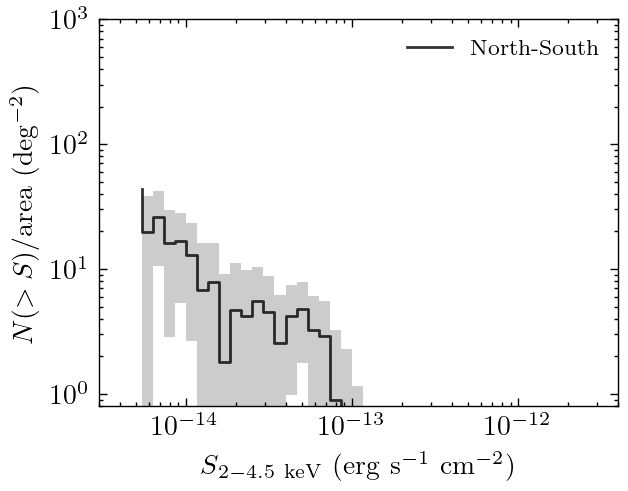

In [235]:
plt.figure(figsize=(3.35,3.35/4*3))
XLF_Data_band_region_North = XLF_Data_band['North']
XLF_Data_band_region_South = XLF_Data_band['South']
y = XLF_Data_band_region_North['N_corr']-XLF_Data_band_region_South['N_corr']
yerr = np.hypot(XLF_Data_band_region_North['N_err_corr'],XLF_Data_band_region_South['N_err_corr'])
cutoff_sensitivity = XLF_Data_band_region_North['cutoff_sensitivity']
color = icefire[0]

x = data_bins[data_bins>XLF_Data_band_region_North['cutoff_sensitivity']][1:]
y = (XLF_Data_band_region_North['N_corr']-XLF_Data_band_region_South['N_corr'])[data_bins[1:]>XLF_Data_band_region['cutoff_sensitivity']]
yerr = np.hypot(XLF_Data_band_region_North['N_err_corr'],XLF_Data_band_region_South['N_err_corr'])[data_bins[1:]>XLF_Data_band_region['cutoff_sensitivity']]

print(x.shape,y.shape)
color='k'
plt.step(x,y,where='pre',color=color,alpha=0.8,label='North-South')
plt.fill_between(x, \
                 (y-yerr),(y+yerr), \
                 color=color,step='pre',edgecolors=None,alpha=0.2)


color = icefire[2]
# label = 'South'

plt.yscale('log')
plt.xscale('log')
plt.ylim(0.8,1e3)
plt.ylabel('$N(>S)$')
plt.ylabel('$N(>S)/\mathrm{area}~\mathrm{(deg^{-2})}$')
plt.xlabel('$S\mathrm{_{2-4.5~keV}~(erg~s^{-1}~cm^{-2})}$')    

plt.xticks([1e-14,1e-13,1e-12],)
plt.xlim([3e-15,4e-12])
plt.legend(fontsize=8)
plt.savefig('figure/Fig4b_North_subtract_South.png')
plt.savefig('figure/Fig4b_North_subtract_South.pdf')

In [236]:
plt.plot(XLF_Data_band_region_Disk['sky_area_function'])

NameError: name 'XLF_Data_band_region_Disk' is not defined

In [237]:
luminosity2flux(5e35)

7.215887211766938e-15

Disk-Background 81.7377197460994 area: 2.4892999999999503
Center08-Background 107.31100133008664 area: 0.05583333333333222
Center38-Background 78.39009640046689 area: 0.04799753086419658


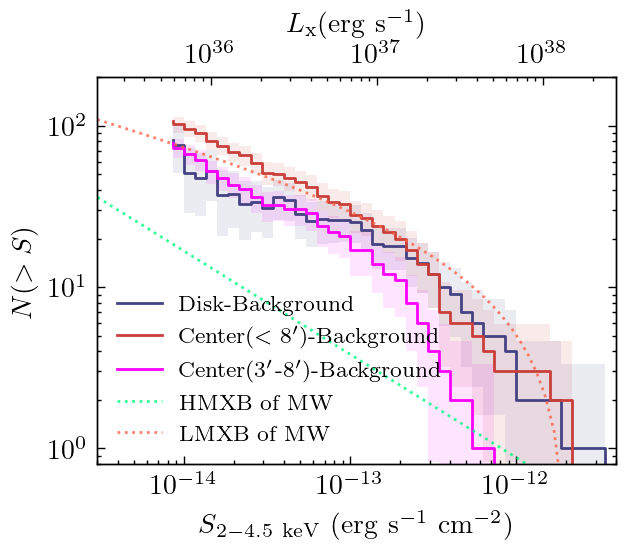

In [238]:
plt.figure(figsize=(3.35,3.35/4*3))
XLF_Data_band_region_Disk = XLF_Data_band['Disk']
XLF_Data_band_region_South = XLF_Data_band['Back']
cutoff_sensitivity = 7.2e-15 #XLF_Data_band_region_South['cutoff_sensitivity']
color = icefire[2]

x = data_bins[data_bins>cutoff_sensitivity][1:]
y = (XLF_Data_band_region_Disk['N_corr']-XLF_Data_band_region_South['N_corr'])[data_bins[:-1]>cutoff_sensitivity]
yerr = np.hypot(XLF_Data_band_region_Disk['N_err_corr'],XLF_Data_band_region_South['N_err_corr'])[data_bins[:-1]>cutoff_sensitivity]
yerr = np.hypot(np.nan_to_num(XLF_Data_band_region_Disk['N_err_corr'],nan=0),np.nan_to_num(XLF_Data_band_region_South['N_err_corr'],nan=0))[data_bins[:-1]>cutoff_sensitivity]
area = np.max(XLF_Data_band_region_Disk['sky_area_function'])
print('Disk-Background',np.max(y)*area,'area:',area)

plt.step(x,y*area,where='pre',color=color,alpha=1.0,label='Disk-Background')
plt.fill_between(x, \
                 (y-yerr)*area,(y+yerr)*area, \
                 color=color,step='pre',edgecolors=None,alpha=0.1)

XLF_Data_band_region_Center = XLF_Data_band['Center08']
XLF_Data_band_region_South = XLF_Data_band['Back']
cutoff_sensitivity = 7.2e-15 #XLF_Data_band_region_South['cutoff_sensitivity']

color = icefire[-2]

x = data_bins[data_bins>cutoff_sensitivity][1:]
y = (XLF_Data_band_region_Center['N_corr']-XLF_Data_band_region_South['N_corr'])[data_bins[:-1]>cutoff_sensitivity]
yerr = np.hypot(XLF_Data_band_region_Center['N_err_corr'],XLF_Data_band_region_South['N_err_corr'])[data_bins[:-1]>cutoff_sensitivity]
yerr = np.hypot(np.nan_to_num(XLF_Data_band_region_Center['N_err_corr'],nan=0),np.nan_to_num(XLF_Data_band_region_South['N_err_corr'],nan=0))[data_bins[:-1]>cutoff_sensitivity]
area = np.max(XLF_Data_band_region_Center['sky_area_function'])
print('Center08-Background',np.max(y)*area,'area:',area)
plt.step(x,y*area,where='pre',color=color,alpha=1.0,label='Center($<8^{\prime}$)-Background')
plt.fill_between(x, \
                 (y-yerr)*area,(y+yerr)*area, \
                 color=color,step='pre',edgecolors=None,alpha=0.1)
#---------------------------
XLF_Data_band_region_Center = XLF_Data_band['Center38']
XLF_Data_band_region_South = XLF_Data_band['Back']
cutoff_sensitivity = 7.2e-15 #XLF_Data_band_region_South['cutoff_sensitivity']

color = 'magenta'#icefire[-1]

x = data_bins[data_bins>cutoff_sensitivity][1:]
y = (XLF_Data_band_region_Center['N_corr']-XLF_Data_band_region_South['N_corr'])[data_bins[:-1]>cutoff_sensitivity]
yerr = np.hypot(XLF_Data_band_region_Center['N_err_corr'],XLF_Data_band_region_South['N_err_corr'])[data_bins[:-1]>cutoff_sensitivity]
yerr = np.hypot(np.nan_to_num(XLF_Data_band_region_Center['N_err_corr'],nan=0),np.nan_to_num(XLF_Data_band_region_South['N_err_corr'],nan=0))[data_bins[:-1]>cutoff_sensitivity]
area = np.max(XLF_Data_band_region_Center['sky_area_function'])
print('Center38-Background',np.max(y)*area,'area:',area)
plt.step(x,y*area,where='pre',color=color,alpha=1.0,label='Center(3$^{\prime}$-8$^{\prime}$)-Background')
plt.fill_between(x, \
                 (y-yerr)*area,(y+yerr)*area, \
                 color=color,step='pre',edgecolors=None,alpha=0.1)


band_ratio = 1.9085278159246946 # 2.0-10.0 keV to 2.0-4.5 keV # index = 2.1
L = np.logspace(35.3,38.4,60)
N = 20*(L/10**36)**(-0.64)
# plt.plot(luminosity2flux(L),N,'--',color='orange',label='HMXB of MW')
plt.plot(luminosity2flux(L)/band_ratio,N,':',alpha=0.8,color='springgreen',label='HMXB of MW')
band_ratio = 1.9 # 2.0-10.0 keV to 2.0-4.5 keV, index=2.1
L = np.logspace(35.3,38.4,60)
N = 105*((L/10**36)**(-0.26)-270**(-0.26))
plt.plot(luminosity2flux(L)/band_ratio,N,':',alpha=0.8,color='tomato',label='LMXB of MW')



color = icefire[2]
# label = 'South'

plt.yscale('log')
plt.xscale('log')
plt.ylim(0.8,2e2)
plt.ylabel('$N(>S)$')
# plt.ylabel('$N(>S)/\mathrm{area}~\mathrm{(deg^{-2})}$')
plt.xlabel('$S\mathrm{_{2-4.5~keV}~(erg~s^{-1}~cm^{-2})}$')    



plt.xticks([1e-14,1e-13,1e-12],)
plt.xlim([3e-15,4e-12])
plt.legend(fontsize=8)
ax1 = plt.gca()
ax2 = ax1.twiny()
ax2.set_xticks( ax1.get_xticks() )
ax2.set_xbound(ax1.get_xbound())
plt.xlim([flux2luminosity(ax1.get_xbound()[0]),flux2luminosity(ax1.get_xbound()[1])])
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$L\mathrm{_x (erg~s^{-1})}$')
plt.savefig('figure/Fig4b_Disk_Center.png')
plt.savefig('figure/Fig4b_Disk_Center.pdf')

In [239]:
icefire

[(0.42110294, 0.69916972, 0.80506683),
 (0.2157176, 0.47827123, 0.81487615),
 (0.2659204, 0.25949691, 0.511417),
 (0.14254381, 0.14016944, 0.18944326),
 (0.19884415, 0.12394381, 0.1385669),
 (0.47151732, 0.17401641, 0.24610337),
 (0.78979746, 0.24694858, 0.22678822),
 (0.93850535, 0.52748892, 0.28242464)]

(102,) (102,)


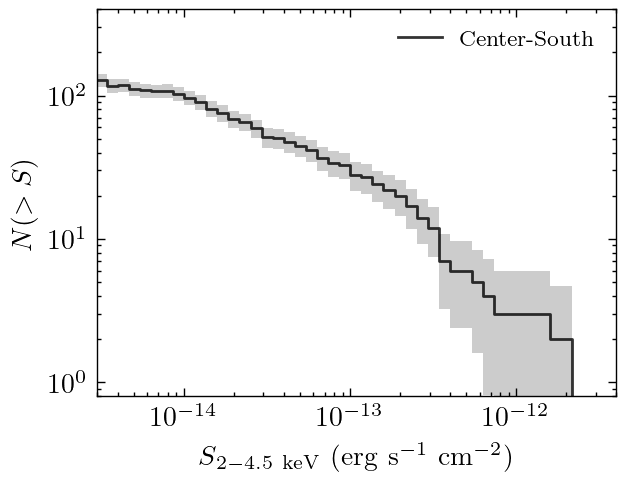

In [240]:
plt.figure(figsize=(3.35,3.35/4*3))
XLF_Data_band_region_Center = XLF_Data_band['Center08']
XLF_Data_band_region_South = XLF_Data_band['South']
y = XLF_Data_band_region_Center['N_corr']-XLF_Data_band_region_South['N_corr']
yerr = np.hypot(XLF_Data_band_region_Center['N_err_corr'],XLF_Data_band_region_South['N_err_corr'])
cutoff_sensitivity = XLF_Data_band_region_Center['cutoff_sensitivity']
color = icefire[0]

x = data_bins[data_bins>cutoff_sensitivity][1:]
y = (XLF_Data_band_region_Center['N_corr']-XLF_Data_band_region_South['N_corr'])[data_bins[:-1]>cutoff_sensitivity]
yerr = np.hypot(XLF_Data_band_region_Center['N_err_corr'],XLF_Data_band_region_South['N_err_corr'])[data_bins[:-1]>cutoff_sensitivity]
yerr = np.hypot(np.nan_to_num(XLF_Data_band_region_Center['N_err_corr'],nan=0),np.nan_to_num(XLF_Data_band_region_South['N_err_corr'],nan=0))[data_bins[:-1]>cutoff_sensitivity]
area = np.max(XLF_Data_band_region_Center['sky_area_function'])

print(x.shape,y.shape)
color='k'
plt.step(x,y*area,where='pre',color=color,alpha=0.8,label='Center-South')
plt.fill_between(x, \
                 (y-yerr)*area,(y+yerr)*area, \
                 color=color,step='pre',edgecolors=None,alpha=0.2)

color = icefire[2]
# label = 'South'

plt.yscale('log')
plt.xscale('log')
plt.ylim(0.8,4e2)
plt.ylabel('$N(>S)$')
# plt.ylabel('$N(>S)/\mathrm{area}~\mathrm{(deg^{-2})}$')
plt.xlabel('$S\mathrm{_{2-4.5~keV}~(erg~s^{-1}~cm^{-2})}$')    

plt.xticks([1e-14,1e-13,1e-12],)
plt.xlim([3e-15,4e-12])
plt.legend(fontsize=8)
# plt.savefig('figure/Fig4b_North_subtract_South.png')
# plt.savefig('figure/Fig4b_North_subtract_South.pdf')

(95,) (95,)


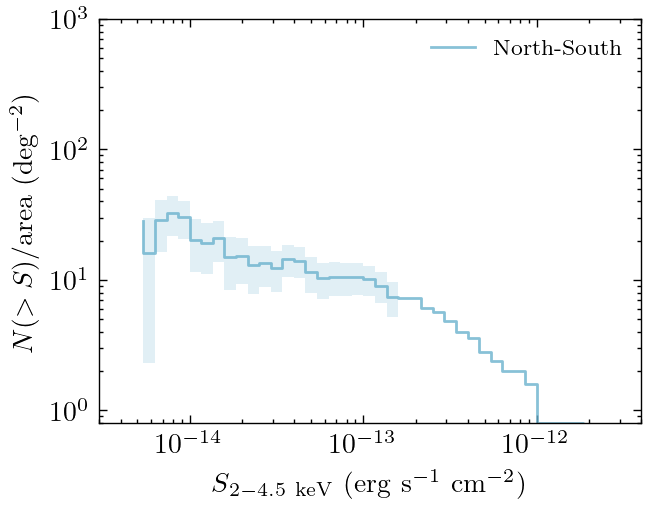

In [241]:
XLF_Data_band_region_North = XLF_Data_band['Disk']
XLF_Data_band_region_South = XLF_Data_band['Back']
# y = XLF_Data_band_region_North['N_corr']-XLF_Data_band_region_South['N_corr']
# yerr = np.hypot(XLF_Data_band_region_North['N_err_corr'],XLF_Data_band_region_South['N_err_corr'])
cutoff_sensitivity = XLF_Data_band_region_South['cutoff_sensitivity']
color = icefire[0]

x = data_bins[data_bins>cutoff_sensitivity][1:]
y = (XLF_Data_band_region_North['N_corr']-XLF_Data_band_region_South['N_corr'])[data_bins[:-1]>cutoff_sensitivity]
yerr = np.hypot(XLF_Data_band_region_North['N_err_corr'],XLF_Data_band_region_South['N_err_corr'])[data_bins[:-1]>cutoff_sensitivity]

print(x.shape,y.shape)

plt.step(x,y,where='pre',color=color,alpha=0.8,label='North-South')
plt.fill_between(x, \
                 (y-yerr),(y+yerr), \
                 color=color,step='pre',edgecolors=None,alpha=0.2)

color = icefire[2]
# label = 'South'

plt.yscale('log')
plt.xscale('log')
plt.ylim(0.8,1e3)
plt.ylabel('$N(>S)$')
plt.ylabel('$N(>S)/\mathrm{area}~\mathrm{(deg^{-2})}$')
plt.xlabel('$S\mathrm{_{2-4.5~keV}~(erg~s^{-1}~cm^{-2})}$')    

plt.xticks([1e-14,1e-13,1e-12],)
plt.xlim([3e-15,4e-12])
plt.legend(fontsize=8)



    region          W1 light W4 light stellar mass    SFR      area     sSFR     M/area   SFR/area M/L_W1   SFR/L_W4
                    10^7     10^5     10^9 M_{\odot}           degree^2                           
    Centermask_315  4.940    5.567    25.872          0.152    0.1880   0.006    137.636  0.811    5.238    0.027   
    Centermask      7.259    6.715    40.755          0.180    0.1959   0.004    208.088  0.921    5.614    0.027   
    M31_disk_mask   7.528    14.910   25.172          0.370    2.3583   0.015    10.674   0.157    3.344    0.025   
    sSFR0-0.01      1.461    0.844    6.240           0.028    0.3008   0.004    20.743   0.093    4.271    0.033   
    sSFR0-0.02      3.260    3.444    13.624          0.099    0.6205   0.007    21.955   0.159    4.179    0.029   
    sSFR0-0.03      4.264    5.880    17.425          0.160    0.8103   0.009    21.506   0.198    4.087    0.027   
    sSFR0-0.04      4.907    8.083    19.737          0.213    0.9243   0.011    21.353   0.231    4.022    0.026   
    sSFR0-          6.065    16.584   22.942          0.407    1.1009   0.018    20.839   0.370    3.782    0.025   
    sSFR0.01-0.015  0.992    1.215    4.173           0.039    0.1719   0.009    24.276   0.225    4.205    0.032   
    sSFR0.01-0.02   1.799    2.600    7.387           0.077    0.3197   0.010    23.105   0.240    4.106    0.030   
    sSFR0.01-0.03   2.803    5.036    11.196          0.139    0.5094   0.012    21.976   0.273    3.995    0.028   
    sSFR0.015-0.02  0.807    1.385    3.217           0.044    0.1478   0.014    21.763   0.295    3.988    0.031   
    sSFR0.02-0.03   1.003    2.436    3.817           0.072    0.1897   0.019    20.120   0.382    3.804    0.030   
    sSFR0.02-0.04   1.647    4.638    6.146           0.129    0.3038   0.021    20.230   0.426    3.732    0.028   
    sSFR0.02-       2.805    13.140   9.469           0.330    0.4804   0.035    19.709   0.687    3.375    0.025   
    sSFR0.03-0.04   0.644    2.202    2.331           0.066    0.1141   0.028    20.432   0.580    3.622    0.030   
    sSFR0.03-       1.802    10.703   5.695           0.274    0.2907   0.048    19.592   0.944    3.161    0.026   
    sSFR0.04-       1.158    8.501    3.399           0.223    0.1766   0.066    19.244   1.263    2.934    0.026m

In [242]:
# 现在这个结论还是很清楚的。  一个一样的 LMXB 的成分，然后还有个 HMXB 的 1.4 的 成分。 我现在觉得就是这样。感觉也挺自洽的呀。
# 挺好。 
# 那么现在 disk 那段现在不是很好写了，但是 stellar mass 和 HMXB 的这部分有东西写了哟。
# good！


## MCMC

In [ ]:
# Back_AGN+Disk_LMXB

In [ ]:
# import numpy as np
# from sherpa.astro.ui import *

# # Assuming you've already set up your model parameters as shown
# ui.thaw(Back_AGN)
# ui.fit(1)
# ui.thaw(Disk_LMXB)
# Disk_LMXB.cutoff.freeze()
# ui.fit(1,5)
# ui.covar(1,5)

# # Set up and run the MCMC sampler
# sampler = get_sampler()
# # sampler.type = 'metropolis'  # or 'simple' depending on preference
# set_sampler('metropolismh')
# sampler_options = get_sampler()
# print(sampler_options)
# # set_sampler_opt('niter', 10000)  # Set the number of iterations
# # set_sampler_opt('nburn', 1000)   # Set the number of burn-in steps

# # Run the MCMC
# stats, accept, params = get_draws(1,otherids=(5,), niter=10000)
# plot_trace(stats, name='stat')
# import numpy as np

# for param_index in range(8):  # Index of the parameter in the params array
#     param_samples = params[param_index, :]
#     percentiles = np.percentile(param_samples, [16, 50, 84])
#     print(f"16th percentile: {percentiles[0]}")
#     print(f"Median: {percentiles[1]}")
#     print(f"84th percentile: {percentiles[2]}")


# import numpy as np

# # Transpose the params array
# samples = np.array(params).T

# samples.shape


# LX_array = np.zeros((len(samples),1))


# for i, sample_row in  enumerate(samples):

#     para = (0,0,0,0,0,0,sample_row[4],sample_row[5],sample_row[6],sample_row[7],-9.3320419618,0,0,0)
#     Integrated_Lx = 3.1*flux2luminosity(np.sum((S_model*LMXB_model(S_model,para) * dS_model * np.max(XLF_Data_band[f'Disk']['mass_function'])) [(S_model>luminosity2flux(1e36)/3.1) & (S_model<luminosity2flux(1e41)/3.1)]))
#     # LX_array[i]=Integrated_Lx/1e38
#     LX_array[i] = np.log10(Integrated_Lx)
#     print(i,Integrated_Lx,end='\r')
    

# import corner
# import matplotlib.pyplot as plt

# # Define labels for each parameter
# labels = ["Parameter 1", "Parameter 2", "Parameter 3", "Parameter 4",]  # Replace with your parameter names

# # ranges = [(0,200), (0,3),(1,4.2),(0,60),(38,40) ]

# # Create the corner plot
# fig = corner.corner(samples[:,:4], labels=labels,  show_titles=True, title_fmt=".2f")

# # Display the plot
# plt.show()

# # Define labels for each parameter
# labels = ["Parameter 1", "Parameter 2", "Parameter 3", "Parameter 4",'Lx']  # Replace with your parameter names

# ranges = [(0,10), (0,3),(1,4.2),(0,150),(38,40) ]

# # Create the corner plot
# fig = corner.corner(np.hstack([samples[:,4:],LX_array]), labels=labels, range=ranges, show_titles=True, title_fmt=".2f")

# # Display the plot
# plt.show()


# # samples[ (samples[:,2]<6) ].shape




In [ ]:
# Disk_LMXB

In [ ]:
# import numpy as np
# from sherpa.astro.ui import *

# # Assuming you've already set up your model parameters as shown
# ui.thaw(Back_AGN)
# Disk_HMXB.A = 0
# ui.thaw(Disk_LMXB)
# Disk_LMXB.cutoff = np.log10(luminosity2flux(1e41)/3.1)
# Disk_LMXB.cutoff.freeze()
# ui.fit(1,5)
# ui.freeze(Back_AGN)
# ui.fit(5)
# ui.covar(5)

# # Set up and run the MCMC sampler
# sampler = get_sampler()
# # sampler.type = 'metropolis'  # or 'simple' depending on preference
# set_sampler('metropolismh')
# sampler_options = get_sampler()
# print(sampler_options)
# # set_sampler_opt('niter', 10000)  # Set the number of iterations
# # set_sampler_opt('nburn', 1000)   # Set the number of burn-in steps

# # Run the MCMC
# stats, accept, params = get_draws(5, niter=20000)
# plot_trace(stats, name='stat')
# import numpy as np

# # Transpose the params array
# samples = np.array(params).T

# samples.shape

# for param_index in range(4):  # Index of the parameter in the params array
#     param_samples = params[param_index, :]
#     percentiles = np.percentile(param_samples, [16, 50, 84])
#     print(f"16th percentile: {percentiles[0]}")
#     print(f"Median: {percentiles[1]}")
#     print(f"84th percentile: {percentiles[2]}")

# LX_array = np.zeros((len(samples),1))
# for i, sample_row in  enumerate(samples):

#     para = (0,0,0,0,0,0,sample_row[0],sample_row[1],sample_row[2],sample_row[3],-9.3320419618,0,0,0)
#     Integrated_Lx = 3.1*flux2luminosity(np.sum((S_model*LMXB_model(S_model,para) * dS_model * np.max(XLF_Data_band[f'Disk']['mass_function'])) [(S_model>luminosity2flux(1e36)/3.1) & (S_model<luminosity2flux(1e41)/3.1)]))
#     # Integrated_Lx = 3.1*flux2luminosity(np.sum((S_model*LMXB_model(S_model,para) * dS_model ) [(S_model>luminosity2flux(1e36)/3.1) & (S_model<luminosity2flux(1e41)/3.1)]))
#     # LX_array[i]=Integrated_Lx/1e38
#     LX_array[i] = np.log10(Integrated_Lx)
#     print(i,Integrated_Lx,end='\r')
    

# index = samples[:,2]<6
# print('median',np.median(LX_array[index]))
# print('std',np.std(LX_array[index]))
# print('logmass',np.log10(np.max(XLF_Data_band[f'Disk']['mass_function'])))
# print('median-logmass',np.median(LX_array[index])-np.log10(np.max(XLF_Data_band[f'Disk']['mass_function']))-10)


# import corner
# import matplotlib.pyplot as plt

# # Define labels for each parameter
# labels = ["Parameter 1", "Parameter 2", "Parameter 3", "Parameter 4",'Lx']  # Replace with your parameter names

# ranges = [(0,10), (0,3),(1,4.2),(0,60),(38,40) ]

# # Create the corner plot
# fig = corner.corner(np.hstack([samples,LX_array])[samples[:,2]<6], labels=labels, range=ranges, show_titles=True, title_fmt=".2f")

# # Display the plot
# plt.show()


# # samples[ (samples[:,2]<6) ].shape




In [ ]:
# import numpy as np
# from sherpa.astro.ui import *

# # Assuming you've already set up your model parameters as shown

# ui.thaw(Center_LMXB)
# Center_LMXB.cutoff = np.log10(luminosity2flux(1e41)/3.1)
# Center_LMXB.cutoff.freeze()
# ui.fit(4)
# ui.covar(4)

# # Set up and run the MCMC sampler
# sampler = get_sampler()
# # sampler.type = 'metropolis'  # or 'simple' depending on preference
# set_sampler('metropolismh')
# sampler_options = get_sampler()
# print(sampler_options)
# # set_sampler_opt('niter', 10000)  # Set the number of iterations
# # set_sampler_opt('nburn', 1000)   # Set the number of burn-in steps

# def max6(x):
#     if x>6:
#         return 0
#     if x<6:
#         return 1

# ui.set_prior(Center_LMXB.beta2, max6)

# # Run the MCMC
# stats, accept, params = get_draws(4, niter=21000)
# plot_trace(stats, name='stat')
# import numpy as np


# import numpy as np

# # Transpose the params array
# samples = np.array(params).T

# samples.shape

# for param_index in range(4):  # Index of the parameter in the params array
#     param_samples = params[param_index, :]
#     percentiles = np.percentile(param_samples, [16, 50, 84])
#     print(f"16th percentile: {percentiles[0]}")
#     print(f"Median: {percentiles[1]}")
#     print(f"84th percentile: {percentiles[2]}")


# LX_array = np.zeros((len(samples),1))


# for i, sample_row in  enumerate(samples):

#     para = (0,0,0,0,0,0,sample_row[0],sample_row[1],sample_row[2],sample_row[3],-9.3320419618,0,0,0)
#     Integrated_Lx = 3.1*flux2luminosity(np.sum((S_model*LMXB_model(S_model,para) * dS_model * np.max(XLF_Data_band[f'Center']['mass_function'])) [(S_model>luminosity2flux(1e36)/3.1) & (S_model<luminosity2flux(1e41)/3.1)]))
#     # LX_array[i]=Integrated_Lx/1e38
#     # Integrated_Lx = 3.1*flux2luminosity(np.sum((S_model*LMXB_model(S_model,para) * dS_model ) [(S_model>luminosity2flux(1e36)/3.1) & (S_model<luminosity2flux(1e41)/3.1)]))
#     # LX_array[i]=Integrated_Lx/1e38
#     LX_array[i] = np.log10(Integrated_Lx)
#     print(i,Integrated_Lx,end='\r')
    
# index = samples[:,2]<6
# print('median',np.median(LX_array[index]))
# print('std',np.std(LX_array[index]))
# print('logmass',np.log10(np.max(XLF_Data_band[f'Center']['mass_function'])))
# print('median-logmass',np.median(LX_array[index])-np.log10(np.max(XLF_Data_band[f'Center']['mass_function']))-10)

# import corner
# import matplotlib.pyplot as plt

# # Define labels for each parameter
# labels = ["Parameter 1", "Parameter 2", "Parameter 3", "Parameter 4",'Lx']  # Replace with your parameter names

# ranges = [(0,20), (0,2),(1,6),(0,60),(38,40) ]

# # Create the corner plot
# fig = corner.corner(np.hstack([samples,LX_array])[samples[:,2]<6], labels=labels, range=ranges, show_titles=True, title_fmt=".2f")

# # Display the plot
# plt.show()


# # samples[ (samples[:,2]<6) ].shape




In [ ]:


# InnerArm_LMXB
# ui.get_prior(InnerArm_LMXB.beta2)

In [ ]:
# import numpy as np
# from sherpa.astro.ui import *

# # Assuming you've already set up your model parameters as shown
# ['Back','North','South','Center','Disk','Ring','InnerArm','InterArm','All']
# ui.thaw(InnerArm_LMXB)
# InnerArm_LMXB.cutoff = np.log10(luminosity2flux(1e41)/3.1)
# InnerArm_LMXB.cutoff.freeze()
# ui.fit(7)
# ui.covar(7)


# def max6(x):
#     if x>6:
#         return 0
#     if x<6:
#         return 1


# # Set up and run the MCMC sampler
# sampler = get_sampler()
# # sampler.type = 'metropolis'  # or 'simple' depending on preference
# set_sampler('metropolismh')
# ui.set_prior(InnerArm_LMXB.beta2, max6)
# ui.set_sampler_opt('priorshape', [False, False, True, False])
# ui.set_prior(InnerArm_LMXB.beta2, max6)

# sampler_options = get_sampler()

# print(sampler_options)
# # set_sampler_opt('niter', 10000)  # Set the number of iterations
# # set_sampler_opt('nburn', 1000)   # Set the number of burn-in steps


 
# # Run the MCMC
# stats, accept, params = get_draws(7, niter=25000)
# plot_trace(stats, name='stat')
# import numpy as np


# import numpy as np

# # Transpose the params array
# samples = np.array(params).T

# samples.shape

# for param_index in range(4):  # Index of the parameter in the params array
#     param_samples = params[param_index, :]
#     percentiles = np.percentile(param_samples, [16, 50, 84])
#     print(f"16th percentile: {percentiles[0]}")
#     print(f"Median: {percentiles[1]}")
#     print(f"84th percentile: {percentiles[2]}")

# LX_array = np.zeros((len(samples),1))


# for i, sample_row in  enumerate(samples):

#     para = (0,0,0,0,0,0,sample_row[0],sample_row[1],sample_row[2],sample_row[3],-9.3320419618,0,0,0)
#     Integrated_Lx = 3.1*flux2luminosity(np.sum((S_model*LMXB_model(S_model,para) * dS_model * np.max(XLF_Data_band[f'InnerArm']['mass_function'])) [(S_model>luminosity2flux(1e36)/3.1) & (S_model<luminosity2flux(1e41)/3.1)]))
#     # Integrated_Lx = 3.1*flux2luminosity(np.sum((S_model*LMXB_model(S_model,para) * dS_model ) [(S_model>luminosity2flux(1e36)/3.1) & (S_model<luminosity2flux(1e41)/3.1)]))
#     # LX_array[i]=Integrated_Lx/1e38
#     LX_array[i] = np.log10(Integrated_Lx)
#     print(i,Integrated_Lx,end='\r')
    

# index = (samples[:,2]<6) & (stats<49)
# print('median',np.median(LX_array[index]))
# print('std',np.std(LX_array[index]))
# print('logmass',np.log10(np.max(XLF_Data_band[f'InnerArm']['mass_function'])))
# print('median-logmass',np.median(LX_array[index])-np.log10(np.max(XLF_Data_band[f'InnerArm']['mass_function']))-10)

# import corner
# import matplotlib.pyplot as plt

# # Define labels for each parameter
# labels = ["Parameter 1", "Parameter 2", "Parameter 3", "Parameter 4",'Lx']  # Replace with your parameter names

# ranges = [(0,10), (0,3),(1,7),(0,150),(38,40) ]

# # Create the corner plot
# fig = corner.corner(np.hstack([samples,LX_array])[(samples[:,2]<6) & (stats<49)], labels=labels, range=ranges, show_titles=True, title_fmt=".2f")

# # Display the plot
# plt.show()


# # samples[ (samples[:,2]<6) ].shape




In [ ]:
# fig = corner.corner(np.hstack([samples,LX_array])[(samples[:,2]<70) & (stats<100)], labels=labels, show_titles=True, title_fmt=".2f")

# Display the plot
# plt.show()


In [ ]:
# import numpy as np
# from sherpa.astro.ui import *

# # Assuming you've already set up your model parameters as shown
# ['Back','North','South','Center','Disk','Ring','InnerArm','InterArm','All']
# ui.thaw(Ring_LMXB)
# Ring_LMXB.cutoff = np.log10(luminosity2flux(1e41)/3.1)
# Ring_LMXB.cutoff.freeze()
# ui.fit(6)
# ui.covar(6)


# def max6(x):
#     if x>6:
#         return 0
#     if x<6:
#         return 1

# ui.set_prior(Ring_LMXB.beta2, max6)

# # Set up and run the MCMC sampler
# sampler = get_sampler()
# # sampler.type = 'metropolis'  # or 'simple' depending on preference
# set_sampler('metropolismh')
# ui.set_sampler_opt('priorshape', [False, False, True, False])
# sampler_options = get_sampler()
# print(sampler_options)
# # set_sampler_opt('niter', 10000)  # Set the number of iterations
# # set_sampler_opt('nburn', 1000)   # Set the number of burn-in steps

# # Run the MCMC
# stats, accept, params = get_draws(6, niter=25000)
# plot_trace(stats, name='stat')
# import numpy as np


# import numpy as np

# # Transpose the params array
# samples = np.array(params).T

# samples.shape

# for param_index in range(4):  # Index of the parameter in the params array
#     param_samples = params[param_index, :]
#     percentiles = np.percentile(param_samples, [16, 50, 84])
#     print(f"16th percentile: {percentiles[0]}")
#     print(f"Median: {percentiles[1]}")
#     print(f"84th percentile: {percentiles[2]}")

# LX_array = np.zeros((len(samples),1))


# for i, sample_row in  enumerate(samples):

#     para = (0,0,0,0,0,0,sample_row[0],sample_row[1],sample_row[2],sample_row[3],-9.3320419618,0,0,0)
#     Integrated_Lx = 3.1*flux2luminosity(np.sum((S_model*LMXB_model(S_model,para) * dS_model * np.max(XLF_Data_band[f'Ring']['mass_function'])) [(S_model>luminosity2flux(1e36)/3.1) & (S_model<luminosity2flux(1e41)/3.1)]))
#     # Integrated_Lx = 3.1*flux2luminosity(np.sum((S_model*LMXB_model(S_model,para) * dS_model ) [(S_model>luminosity2flux(1e36)/3.1) & (S_model<luminosity2flux(1e41)/3.1)]))
#     # LX_array[i]=Integrated_Lx/1e38
#     LX_array[i] = np.log10(Integrated_Lx)
#     print(i,Integrated_Lx,end='\r')
    

# index = (samples[:,2]<6) & (stats<64)
# print('median',np.median(LX_array[index]))
# print('std',np.std(LX_array[index]))
# print('logmass',np.log10(np.max(XLF_Data_band[f'Ring']['mass_function'])))
# print('median-logmass',np.median(LX_array[index])-np.log10(np.max(XLF_Data_band[f'Ring']['mass_function']))-10)


# import corner
# import matplotlib.pyplot as plt

# # Define labels for each parameter
# labels = ["Parameter 1", "Parameter 2", "Parameter 3", "Parameter 4",'Lx']  # Replace with your parameter names

# ranges = [(0,10), (0,3),(1,7),(0,150),(38,40) ]

# # Create the corner plot
# fig = corner.corner(np.hstack([samples,LX_array])[(samples[:,2]<6) & (stats<64)], labels=labels, range=ranges, show_titles=True, title_fmt=".2f")

# # Display the plot
# plt.show()


# # samples[ (samples[:,2]<6) ].shape




In [ ]:
# InterArm_LMXB

In [ ]:
# import numpy as np
# from sherpa.astro.ui import *

# # Assuming you've already set up your model parameters as shown
# ['Back','North','South','Center','Disk','Ring','InnerArm','InterArm','All']
# ui.thaw(InterArm_LMXB)
# InterArm_LMXB.cutoff = np.log10(luminosity2flux(1e41)/3.1)
# InterArm_LMXB.cutoff.freeze()
# InterArm_LMXB.beta2=6
# InterArm_LMXB.beta2.freeze()
# ui.fit(8)
# ui.covar(8)


# def max6(x):
#     if x>6:
#         return 0
#     if x<6:
#         return 1

# ui.set_prior(InterArm_LMXB.beta2, max6)


# # Set up and run the MCMC sampler
# sampler = get_sampler()
# # sampler.type = 'metropolis'  # or 'simple' depending on preference
# set_sampler('metropolismh')
# ui.set_sampler_opt('priorshape', [False, False, True, False])
# sampler_options = get_sampler()
# print(sampler_options)
# # set_sampler_opt('niter', 10000)  # Set the number of iterations
# # set_sampler_opt('nburn', 1000)   # Set the number of burn-in steps

# # Run the MCMC
# stats, accept, params = get_draws(8, niter=10000)
# plot_trace(stats, name='stat')
# import numpy as np


# import numpy as np

# # Transpose the params array
# samples = np.array(params).T

# samples.shape

# for param_index in range(3):  # Index of the parameter in the params array
#     param_samples = params[param_index, :]
#     percentiles = np.percentile(param_samples, [16, 50, 84])
#     print(f"16th percentile: {percentiles[0]}")
#     print(f"Median: {percentiles[1]}")
#     print(f"84th percentile: {percentiles[2]}")
#     print(f"std: {np.std(param_samples)}")

# LX_array = np.zeros((len(samples),1))


# for i, sample_row in  enumerate(samples):

#     para = (0,0,0,0,0,0,sample_row[0],sample_row[1],6,sample_row[2],-9.3320419618,0,0,0)
#     Integrated_Lx = 3.1*flux2luminosity(np.sum((S_model*LMXB_model(S_model,para) * dS_model * np.max(XLF_Data_band[f'InterArm']['mass_function'])) [(S_model>luminosity2flux(1e36)/3.1) & (S_model<luminosity2flux(1e41)/3.1)]))
#     # Integrated_Lx = 3.1*flux2luminosity(np.sum((S_model*LMXB_model(S_model,para) * dS_model ) [(S_model>luminosity2flux(1e36)/3.1) & (S_model<luminosity2flux(1e41)/3.1)]))
#     # LX_array[i]=Integrated_Lx/1e38
#     LX_array[i] = np.log10(Integrated_Lx)
#     print(i,Integrated_Lx,end='\r')
    

# index = (samples[:,2]>0) #& (stats<64)
# print('median',np.median(LX_array[index]))
# print('std',np.std(LX_array[index]))
# print('logmass',np.log10(np.max(XLF_Data_band[f'InterArm']['mass_function'])))
# print('median-logmass',np.median(LX_array[index])-np.log10(np.max(XLF_Data_band[f'InterArm']['mass_function']))-10)
# import corner
# import matplotlib.pyplot as plt

# # Define labels for each parameter
# labels = ["Parameter 1", "Parameter 2", "Parameter 3", "Parameter 4",'Lx']  # Replace with your parameter names

# ranges = [(0,10), (0,3),(0,500),(38,40) ]

# # Create the corner plot
# fig = corner.corner(np.hstack([samples,LX_array]), labels=labels, range=ranges, show_titles=True, title_fmt=".2f")

# # Display the plot
# plt.show()


# # samples[ (samples[:,2]<6) ].shape




In [ ]:
# np.mean(samples[:,0])

In [ ]:
# para = (0,0,0,0,0,0,sample_row[0],sample_row[1],sample_row[2],6,-9.3320419618,0,0,0)
# Integrated_Lx = 3.1*flux2luminosity(np.sum((S_model*LMXB_model(S_model,para) * dS_model * np.max(XLF_Data_band[f'{region_label}']['mass_function'])) [(S_model>luminosity2flux(1e36)/3.1) & (S_model<luminosity2flux(1e41)/3.1)]))
# # LX_array[i]=Integrated_Lx/1e38
# LX_array[i] = np.log10(Integrated_Lx)
# print(i,Integrated_Lx,end='\r')

# para

In [ ]:
# region_label = 'All'
# i = 8

# exec(f"""para= tuple([i.val for i in {region_label}_source_model.pars])""")
# def model(x,para):
#     return brokenpl_dN(x,para[0:4])+power_law(x,para[4:6])#+cutoff_power_law(x,para[11:16]) #+cutoff_brokenpl_dN(x,para[6:11])
# def LMXB_model(x,para):
#     return cutoff_brokenpl_dN(x,para[6:11])
# exec(f"""model_dN = model(S_model,para) * dS_model * XLF_Data_band['{region_label}']['sky_area_function'] + LMXB_model(S_model,para) * dS_model * XLF_Data_band['{region_label}']['mass_function']""")
# # model_dN_corr = model(S_model,para) * dS_model + LMXB_model(S_model,para) * dS_model * XLF_Data_band[f'{region_label}']['mass_function']/XLF_Data_band[f'{region_label}']['sky_area_function']+ HMXB_model(S_model,para) * dS_model * XLF_Data_band[f'{region_label}']['SFR_function']/XLF_Data_band[f'{region_label}']['sky_area_function']

# plt.plot(S_model,np.cumsum(model_dN[::-1])[::-1])
# plt.xscale('log')

# print('modeled total number above 1e-14 in All region:',(np.cumsum(model_dN[::-1])[::-1])[S_model>1e-14][0])

# exec(f"""model_dN =  LMXB_model(S_model,para) * dS_model * XLF_Data_band['{region_label}']['mass_function']""")
# # model_dN_corr = model(S_model,para) * dS_model + LMXB_model(S_model,para) * dS_model * XLF_Data_band[f'{region_label}']['mass_function']/XLF_Data_band[f'{region_label}']['sky_area_function']+ HMXB_model(S_model,para) * dS_model * XLF_Data_band[f'{region_label}']['SFR_function']/XLF_Data_band[f'{region_label}']['sky_area_function']
# plt.plot(S_model,np.cumsum(model_dN[::-1])[::-1])
# plt.xscale('log')
# print('modeled LMXB number above 1e-14 in All region:',(np.cumsum(model_dN[::-1])[::-1])[S_model>1e-14][0])


# exec(f"""model_dN = model(S_model,para) * dS_model * XLF_Data_band['{region_label}']['sky_area_function'] """)
# # model_dN_corr = model(S_model,para) * dS_model + LMXB_model(S_model,para) * dS_model * XLF_Data_band[f'{region_label}']['mass_function']/XLF_Data_band[f'{region_label}']['sky_area_function']+ HMXB_model(S_model,para) * dS_model * XLF_Data_band[f'{region_label}']['SFR_function']/XLF_Data_band[f'{region_label}']['sky_area_function']

# plt.plot(S_model,np.cumsum(model_dN[::-1])[::-1])
# print('modeled AGN number above 1e-14 in All region:',(np.cumsum(model_dN[::-1])[::-1])[S_model>1e-14][0])


# print('detected total number above 1e-14 in All region:',(np.cumsum((XLF_Data_band[region_label]['dN_InSmallBin'])[::-1])[::-1])[S_model>1e-14][0])



In [ ]:
# import numpy as np
# from sherpa.astro.ui import *

# # Assuming you've already set up your model parameters as shown
# All_HMXB.A = 0
# ui.thaw(All_LMXB)
# All_LMXB.cutoff = np.log10(luminosity2flux(1e41)/3.1)
# All_LMXB.cutoff.freeze()
# ui.fit(9)
# ui.covar(9)


# def max6(x):
#     if x>6:
#         return 0
#     if x<6:
#         return 1

# ui.set_prior(All_LMXB.beta2, max6)

# # Set up and run the MCMC sampler
# sampler = get_sampler()
# # sampler.type = 'metropolis'  # or 'simple' depending on preference
# set_sampler('metropolismh')
# ui.set_sampler_opt('priorshape', [False, False, True, False])
# sampler_options = get_sampler()
# print(sampler_options)
# # set_sampler_opt('niter', 10000)  # Set the number of iterations
# # set_sampler_opt('nburn', 1000)   # Set the number of burn-in steps

# # Run the MCMC
# stats, accept, params = get_draws(9, niter=12000)
# plot_trace(stats, name='stat')

# import numpy as np

# # Transpose the params array
# samples = np.array(params).T

# samples.shape

# for param_index in range(4):  # Index of the parameter in the params array
#     param_samples = params[param_index, :]
#     percentiles = np.percentile(param_samples, [16, 50, 84])
#     print(f"16th percentile: {percentiles[0]}")
#     print(f"Median: {percentiles[1]}")
#     print(f"84th percentile: {percentiles[2]}")
#     print(f"std: {np.std(param_samples)}")
# LX_array = np.zeros((len(samples),1))


# for i, sample_row in  enumerate(samples):

#     para = (0,0,0,0,0,0,sample_row[0],sample_row[1],sample_row[2],sample_row[3],-9.3320419618,0,0,0)
#     Integrated_Lx = 3.1*flux2luminosity(np.sum((S_model*LMXB_model(S_model,para) * dS_model * np.max(XLF_Data_band[f'All']['mass_function'])) [(S_model>luminosity2flux(1e36)/3.1) & (S_model<luminosity2flux(1e41)/3.1)]))
#     # Integrated_Lx = 3.1*flux2luminosity(np.sum((S_model*LMXB_model(S_model,para) * dS_model ) [(S_model>luminosity2flux(1e36)/3.1) & (S_model<luminosity2flux(1e41)/3.1)]))
#     # LX_array[i]=Integrated_Lx/1e38
#     LX_array[i] = np.log10(Integrated_Lx)
#     print(i,Integrated_Lx,end='\r')
    

# index = (samples[:,2]<6) & (stats<74)
# print('median',np.median(LX_array[index]))
# print('std',np.std(LX_array[index]))
# print('logmass',np.log10(np.max(XLF_Data_band[f'All']['mass_function'])))
# print('median-logmass',np.median(LX_array[index])-np.log10(np.max(XLF_Data_band[f'All']['mass_function']))-10)

# import corner
# import matplotlib.pyplot as plt

# # Define labels for each parameter
# labels = ["Parameter 1", "Parameter 2", "Parameter 3", "Parameter 4",'Lx']  # Replace with your parameter names

# ranges = [(0,10), (0,3),(1,7),(0,60),(38,40) ]

# # Create the corner plot
# fig = corner.corner(np.hstack([samples,LX_array])[stats<74], labels=labels, range=ranges, show_titles=True, title_fmt=".2f")

# # Display the plot
# plt.show()


# # samples[ (samples[:,2]<6) ].shape




In [ ]:
# # This is the uncertainty of the estimated number in All region that > 1e-14

# Number_list = []
# for i, sample_row in  enumerate(samples):

#     para = (0,0,0,0,0,0,sample_row[0],sample_row[1],sample_row[2],sample_row[3],-9.3320419618,0,0,0)
#     Integrated_Lx = 3.1*flux2luminosity(np.sum((S_model*LMXB_model(S_model,para) * dS_model * np.max(XLF_Data_band[f'All']['mass_function'])) [(S_model>luminosity2flux(1e36)/3.1) & (S_model<luminosity2flux(1e41)/3.1)]))
#     # Integrated_Lx = 3.1*flux2luminosity(np.sum((S_model*LMXB_model(S_model,para) * dS_model ) [(S_model>luminosity2flux(1e36)/3.1) & (S_model<luminosity2flux(1e41)/3.1)]))
#     # LX_array[i]=Integrated_Lx/1e38
#     model_dN =  LMXB_model(S_model,para) * dS_model * XLF_Data_band['All']['mass_function']
#     # Number = LMXB_model(S_model,para)* dS_model * (XLF_Data_band[f'All']['mass_function'])
#     # model_dN[]
#     Number = (np.cumsum(model_dN[::-1])[::-1])[S_model>1e-14][0]
#     Number_list.append(Number)
    
    
#     LX_array[i] = np.log10(Integrated_Lx)
#     print(i,Integrated_Lx,Number,end='\r')

# # This is the uncertainty of the estimated number in All region that > 1e-14

# plt.hist(Number_list)

# Number_uncertainty = np.percentile(Number_list, [16, 50, 84])
# print(Number_uncertainty[1], Number_uncertainty[1]-Number_uncertainty[0], Number_uncertainty[-1]-Number_uncertainty[1])
# # 102, 114, 127

In [ ]:
# print('This is the updated All region, which is a elliptical. ')
# print('the total number is 240, not 344 now!')
# (np.cumsum((XLF_Data_band['All']['dN_InSmallBin'])[::-1])[::-1])[S_model>1e-14][0]

## HMXB in CHANDRA HST survey

In [243]:
np.unique(table['Class'])
np.sum(table['Class']=='XRB')

index = table['Class']=='XRB'
table[index]['Lum']

Identification
All_Src_coordinate = SkyCoord(ra=Identification['RA'],dec=Identification['DEC'],unit=u.deg,frame='fk5' )
table['RAJ2000'],table['DEJ2000']

(<MaskedColumn name='RAJ2000' dtype='float64' unit='deg' format='{:10.6f}' description='[10.9/11.8] Degree of right ascension (J2000)' length=57>
  10.961532
  11.107230
  11.218860
  11.200555
  10.999298
  11.030994
  11.228091
  10.912759
  10.968206
  11.191097
  11.050810
  11.103437
        ...
  11.531340
  11.552859
  11.626957
  11.765938
  11.664524
  11.700826
  11.627879
  11.426149
  11.655142
  11.717429
  11.701185,
 <MaskedColumn name='DEJ2000' dtype='float64' unit='deg' format='{:10.6f}' description='[41.2/42.3] Degree of declination (J2000)' length=57>
  41.354841
  41.378284
  41.286154
  41.379836
  41.409707
  41.416487
  41.321625
  41.354665
  41.372807
  41.531045
  41.529889
  41.533501
        ...
  42.148604
  42.174164
  42.174428
  42.081202
  42.113468
  42.148515
  42.162824
  42.138102
  42.176036
  42.251372
  42.147349)

# try single power law acording to referee

In [286]:
## fit at 2024/07/15
## only consider LMXB
ui.set_method('neldermead')
ui.set_stat('cstat')
Back_AGN.K.set(val=131,min=10,max=500)
Back_AGN.beta1.set(val=1.71558,min=0.3,max=3)   
Back_AGN.beta2.set(val=2.47258,min=0.3,max=6)   
Back_AGN.fb.set(val=0.662315,min=0.1,max=150)
Back_AGN.K.thaw()
Back_AGN.beta1.freeze()
# Back_AGN.beta2.thaw()
Back_AGN.beta2.freeze()
Back_AGN.fb.thaw()
Back_star.A.set(val=0,min=-1,max=100)
Back_star.alpha.set(val=0,min=-1,max=100)
Back_star.alpha.freeze()
Back_star.A.freeze()
ui.freeze(Back_star)
ui.fit(1) # 先拟合 Back_AGN
ui.covar(1)
Back_AGN.beta2.thaw()
ui.fit(1)

# beta1 is the slope at lower flux, beta2 is at the higher.
# The beta1 can not be constrained with Background region due to the limited sensitivity. 
# So I freeze it now, but I will let it free when fitting disk.


# the background beta 1 is thawed. It looks there is enough faint source in the center than in the background, although it is dominated by the LMXB.
# The result of center is good, and comparable with the result in the submitted paper.

All_LMXB.K.set(val=7.7,min=.01,max=70)
All_LMXB.beta1.set(val=1.4,min=.1,max=3)
All_LMXB.beta2.set(val=4.5,min=1.5,max=6.)
All_LMXB.fb.set(val=90,min=10,max=150)
All_LMXB.cutoff.set(val=0,min=-13,max=0)
All_LMXB.cutoff = -10
All_LMXB.K.thaw()
All_LMXB.beta1.thaw()
All_LMXB.beta2.thaw()
All_LMXB.fb.thaw()
All_LMXB.cutoff.freeze()
All_HMXB.alpha.val=1.6
All_HMXB.alpha.freeze()
All_HMXB.A = 0
All_HMXB.A.freeze()
All_HMXB.cutoff = -10
All_HMXB.cutoff.freeze()
# InterArm_HMXB.A.thaw()
# InterArm_LMXB.K.max = 200
# ui.fit(1,5,8)
# ui.covar(1,5,8)
Back_AGN.K.thaw()
Back_AGN.beta1.thaw()
Back_AGN.beta2.thaw()
Back_AGN.fb.thaw()
Back_AGN.K = 131
Back_AGN.K.freeze()
Back_AGN.beta1 = 2.06
Back_AGN.beta2 = 2.9
Back_AGN.fb = 1.9
ui.freeze(Back_AGN)
ui.fit(1,9)
# Back_AGN.K.thaw()
# ui.thaw(Back_AGN)
ui.covar(1,9)
# ui.fit(1,9)
# ui.covar(1,9)
ui.freeze(Back_AGN)
ui.fit(9)

Disk_LMXB.K.set(val=7.7,min=.01,max=70)
Disk_LMXB.beta1.set(val=1.4,min=.1,max=3)
Disk_LMXB.beta2.set(val=4.5,min=1.5,max=6.)
Disk_LMXB.fb.set(val=90,min=10,max=150)
Disk_LMXB.cutoff.set(val=0,min=-13,max=0)
Disk_LMXB.K.thaw()
Disk_LMXB.beta1.thaw()
Disk_LMXB.beta2.thaw()
Disk_LMXB.fb.thaw()
Disk_LMXB.cutoff.freeze()

Disk_HMXB.A.set(val=0,min=0,max=100)
Disk_HMXB.alpha.set(val=1.6,min=0,max=3)
Disk_HMXB.A.thaw()
Disk_HMXB.alpha.thaw()

Back_AGN.K.thaw()
Back_AGN.beta1.thaw()
Back_AGN.beta2.thaw()
Back_AGN.fb.thaw()

ui.freeze(Disk_HMXB)
ui.freeze(Disk_star)
# ui.fit(1,5)
ui.fit(5)
ui.covar(5)
# ui.fit(1,4,5)



Back_AGN.K.freeze()
Back_AGN.beta1.freeze()
Back_AGN.beta2.freeze()
Back_AGN.fb.freeze()

Center_LMXB.K.set(val=10,min=0.1,max=600)   
Center_LMXB.beta1.set(val=1.18585,min=1,max=3)
Center_LMXB.beta2.set(val=2.49092,min=1.5,max=6)        
Center_LMXB.fb.set(val=27.8585,min=10,max=150)  
Center_LMXB.cutoff.set(val=0,min=-13,max=0)

Center_LMXB.K.thaw()
Center_LMXB.beta1.thaw()
Center_LMXB.beta2.thaw()
Center_LMXB.fb.thaw()
Center_LMXB.cutoff.freeze()
Center_HMXB.A = 0
ui.freeze(Center_HMXB)
Center_star.A = 0
ui.freeze(Center_star)
# Back_AGN.beta1.thaw()
# ui.fit(1,4,9) # 拟合 Center_LMXB
# Back_AGN.beta1.freeze()
ui.fit(4,)
ui.covar(4)

# 先假设 disk 上 没有HMXB， 得到一个结果。目前看这个结果却是不错。 然后就要看 HMXB 和 LMXB 之间的 correlation 了。 
# 然后再来试试 增加不同比例的 HMXB， 看看 结果会怎样变，变得有多差去了。


Ring_LMXB.K.set(val=29,min=.01,max=300)
Ring_LMXB.beta1.set(val=1.4,min=.1,max=3)
Ring_LMXB.beta2.set(val=4.5,min=1.5,max=6.)
Ring_LMXB.fb.set(val=30,min=10,max=120)
Ring_LMXB.cutoff.set(val=0,min=-13,max=0)
Ring_LMXB.K.thaw()
Ring_LMXB.beta1.thaw()
Ring_LMXB.beta2.thaw()
Ring_LMXB.fb.thaw()
Ring_LMXB.cutoff.freeze()

Ring_HMXB.A.set(val=0,min=0,max=100)
Ring_HMXB.alpha.set(val=1.6,min=0,max=3)
Ring_HMXB.A.freeze()
Ring_HMXB.alpha.freeze()

ui.freeze(Back_AGN)
# ui.fit(1,5,6)
# ui.covar(1,5,6)
Ring_LMXB.thaw()
Ring_LMXB.cutoff = -10
Ring_LMXB.cutoff.freeze()
ui.fit(6)
ui.covar(6)

## OK, 目前仍然是完全不考虑 HMXB 的， 

InnerArm_HMXB.alpha.val=1.6
InterArm_HMXB.alpha.freeze()
InnerArm_HMXB.A = 0
InnerArm_HMXB.A.freeze()
InnerArm_HMXB.freeze()
InnerArm_LMXB.K.max = 600
InnerArm_LMXB.beta1.thaw()
# ui.fit(7)
# ui.covar(7)
# InnerArm_LMXB.beta2 = 
# InnerArm_LMXB.beta2.thaw()
# ui.fit(1,5,7)
# ui.covar(1,5,7)
InnerArm_LMXB.thaw()
InnerArm_LMXB.cutoff = -10
InnerArm_LMXB.cutoff.freeze()
ui.fit(7)
ui.covar(7)


InterArm_HMXB.alpha.val=1.6
InterArm_HMXB.alpha.freeze()
InterArm_HMXB.A = 0
InterArm_HMXB.A.freeze()
InterArm_HMXB.freeze()
# InterArm_HMXB.A.thaw()
# InterArm_LMXB.K.max = 200
# ui.fit(1,5,8)
# ui.covar(1,5,8)
InterArm_LMXB.thaw()
InterArm_LMXB.cutoff = -10
InterArm_LMXB.cutoff.freeze()
InterArm_LMXB.beta2 = 6
InterArm_LMXB.beta2.freeze()
InterArm_LMXB.fb.max = 400
ui.fit(8)
ui.covar(8)

All_HMXB.alpha.val=1.6
All_HMXB.alpha.freeze()
All_HMXB.A = 0
All_HMXB.A.freeze()
# InterArm_HMXB.A.thaw()
# InterArm_LMXB.K.max = 200
# ui.fit(1,5,8)
# ui.covar(1,5,8)
All_LMXB.thaw()
All_LMXB.cutoff = -10
All_LMXB.cutoff.freeze()
ui.fit(9)
ui.covar(9)



Dataset               = 1
Method                = neldermead
Statistic             = cstat
Initial fit statistic = 85.47
Final fit statistic   = 29.7064 at function evaluation 203
Data points           = 95
Degrees of freedom    = 93
Probability [Q-value] = 1
Reduced statistic     = 0.319424
Change in statistic   = 55.7636
   Back_AGN.K     178.214     
   Back_AGN.fb    0.666749    
Dataset               = 1
Confidence Method     = covariance
Iterative Fit Method  = None
Fitting Method        = neldermead
Statistic             = cstat
covariance 1-sigma (68.2689%) bounds:
   Param            Best-Fit  Lower Bound  Upper Bound
   -----            --------  -----------  -----------
   Back_AGN.K        178.214     -19.1434      19.1434
   Back_AGN.fb      0.666749    -0.106122     0.106122
Dataset               = 1
Method                = neldermead
Statistic             = cstat
Initial fit statistic = 29.7064
Final fit statistic   = 29.6923 at function evaluation 302
Data points       

In [293]:
region_label_list = ['Back','North','South','Center','Disk','Ring','InnerArm','InterArm','All']

for i in range(1,10):
    # print(i,'ce',calculate_expected_C(ui.get_model_plot(i).y))
    # print(i,'ce-4',calculate_expected_C(ui.get_model_plot(i).y)-4)
    # print(i, 'cv',calculate_variance_C(ui.get_model_plot(i).y))
    # print(i, 'sqrt(cv)',np.sqrt(calculate_variance_C(ui.get_model_plot(i).y)))
    print(region_label_list[i-1], 'ce-4', 'sqrt(cv)',calculate_expected_C(ui.get_model_plot(i).y)-4, np.sqrt(calculate_variance_C(ui.get_model_plot(i).y)))
    # print(i,'ce-sqrt(cv)',calculate_expected_C(ui.get_model_plot(i).y)-np.sqrt(calculate_variance_C(ui.get_model_plot(i).y))-4)
    # print(i, 'ce+sqrt(cv)',calculate_expected_C(ui.get_model_plot(i).y)+np.sqrt(calculate_variance_C(ui.get_model_plot(i).y))-4)


Back ce-4 sqrt(cv) 21.830334149153895 6.9737997206018525
North ce-4 sqrt(cv) 23.128336443921032 7.170392802639972
South ce-4 sqrt(cv) 21.950106399471927 6.613651610288437
Center ce-4 sqrt(cv) 41.149996466587716 9.642136600405413
Disk ce-4 sqrt(cv) 49.26188452541861 9.938504119613315
Ring ce-4 sqrt(cv) 44.61050544480993 8.942463251124407
InnerArm ce-4 sqrt(cv) 37.74292931563289 8.355806989749592
InterArm ce-4 sqrt(cv) 44.72208287731938 8.535652918065193
All ce-4 sqrt(cv) 49.63670229509541 10.25453167413181


In [253]:
ui.freeze(All_LMXB)
All_LMXB.K.min=0
All_LMXB.K = 0
ui.thaw(All_HMXB)
Disk_HMXB.cutoff.freeze()
Disk_HMXB.cutoff = -10
ui.fit(9)

ui.freeze(Disk_LMXB)
Disk_LMXB.K.min=0
Disk_LMXB.K = 0
ui.thaw(Disk_HMXB)
Disk_HMXB.cutoff.freeze()
Disk_HMXB.cutoff = -10
ui.fit(5)

ui.freeze(InterArm_LMXB)
InterArm_LMXB.K.min=0
InterArm_LMXB.K = 0
ui.thaw(InterArm_HMXB)
InterArm_HMXB.cutoff.freeze()
InterArm_HMXB.cutoff = -10
ui.fit(8)

ui.freeze(InnerArm_LMXB)
InnerArm_LMXB.K.min=0
InnerArm_LMXB.K = 0
ui.thaw(InnerArm_HMXB)
InnerArm_HMXB.cutoff.freeze()
InnerArm_HMXB.cutoff = -10
ui.fit(7)

ui.freeze(Center_HMXB)
ui.thaw(Center_LMXB)
# Center_LMXB.K.min=0
Center_HMXB.A = 0
ui.fit(4)

ui.freeze(Ring_LMXB)
Ring_LMXB.K.min=0
Ring_LMXB.K = 0
ui.thaw(Ring_HMXB)
Ring_HMXB.cutoff.freeze()
Ring_HMXB.cutoff = -10
ui.fit(6)



Dataset               = 9
Method                = neldermead
Statistic             = cstat
Initial fit statistic = 80.4122
Final fit statistic   = 80.4122 at function evaluation 465
Data points           = 103
Degrees of freedom    = 100
Probability [Q-value] = 0.924997
Reduced statistic     = 0.804122
Change in statistic   = 0
   All_HMXB.A     95.3253     
   All_HMXB.alpha   1.50162     
   All_HMXB.cutoff   -2.77721    
Dataset               = 5
Method                = neldermead
Statistic             = cstat
Initial fit statistic = 57.2395
Final fit statistic   = 57.2395 at function evaluation 180
Data points           = 102
Degrees of freedom    = 100
Probability [Q-value] = 0.999815
Reduced statistic     = 0.572395
Change in statistic   = 0
   Disk_HMXB.A    62.7141     
   Disk_HMXB.alpha   1.54151     
Dataset               = 8
Method                = neldermead
Statistic             = cstat
Initial fit statistic = 51.4133
Final fit statistic   = 47.5534 at function evaluation

In [255]:
for i in range(1,10):
    print(i,'ce',calculate_expected_C(ui.get_model_plot(i).y))
    print(i, 'cv',calculate_variance_C(ui.get_model_plot(i).y))
    print(i,'cv-sqrt(cv)',calculate_expected_C(ui.get_model_plot(i).y)-np.sqrt(calculate_variance_C(ui.get_model_plot(i).y)))
    print(, 'cv+sqrt(cv)',calculate_expected_C(ui.get_model_plot(i).y)+np.sqrt(calculate_variance_C(ui.get_model_plot(i).y)))


1 ce 25.855310411425112
1 cv 48.90652274338674
1 cv-sqrt(cv) 18.86199054576855
1 cv+sqrt(cv) 32.848630277081675
2 ce 27.128336443921032
2 cv 51.41453294415111
2 cv-sqrt(cv) 19.957943641281062
2 cv+sqrt(cv) 34.298729246561
3 ce 25.950106399471927
3 cv 43.74038762227083
3 cv-sqrt(cv) 19.33645478918349
3 cv+sqrt(cv) 32.56375800976036
4 ce 45.154701657186756
4 cv 92.97387621376073
4 cv-sqrt(cv) 35.512405446544776
4 cv+sqrt(cv) 54.796997867828736
5 ce 61.37722640463355
5 cv 100.085856626671
5 cv-sqrt(cv) 51.3729344943247
5 cv+sqrt(cv) 71.3815183149424
6 ce 55.9684568545141
6 cv 92.21670876536692
6 cv-sqrt(cv) 46.365503727201286
6 cv+sqrt(cv) 65.57140998182692
7 ce 50.07168926070501
7 cv 87.09667593990142
7 cv-sqrt(cv) 40.739129272154095
7 cv+sqrt(cv) 59.40424924925592
8 ce 51.36594779434347
8 cv 90.01021091991382
8 cv-sqrt(cv) 41.87857666636951
8 cv+sqrt(cv) 60.85331892231743
9 ce 75.7851520701717
9 cv 132.2165314451884
9 cv-sqrt(cv) 64.2866073168045
9 cv+sqrt(cv) 87.2836968235389


1 Back
(usermodel.Back_AGN + usermodel.Back_star)
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   Back_AGN.K   frozen      133.187           10          500           
   Back_AGN.beta1 frozen      1.96107          0.3            3           
   Back_AGN.beta2 frozen       2.8626          0.3            6           
   Back_AGN.fb  frozen      1.71448          0.1          150           
   Back_star.A  frozen            0           -1          100           
   Back_star.alpha frozen            0           -1          100           
Back


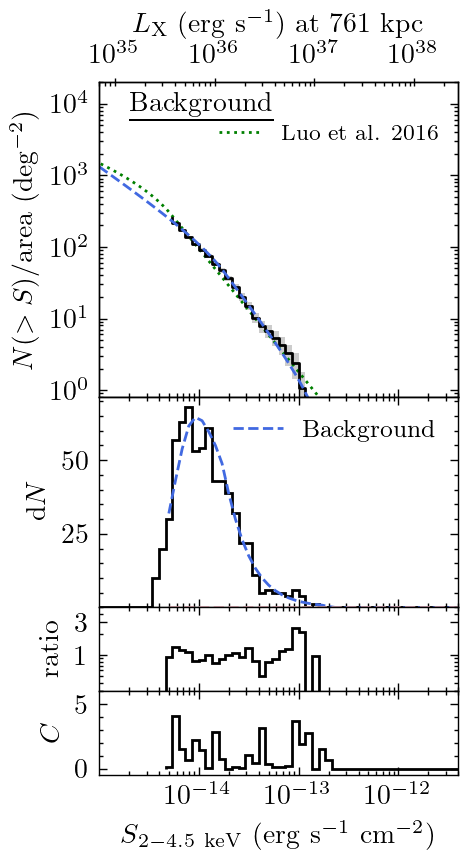

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2 North
3 South
4 Center
(((usermodel.Center_AGN + usermodel.Center_star) + usermodel.Center_LMXB) + usermodel.Center_HMXB)
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   Center_AGN.K linked      133.187         expr: Back_AGN.K           
   Center_AGN.beta1 linked      1.96107     expr: Back_AGN.beta1           
   Center_AGN.beta2 linked       2.8626     expr: Back_AGN.beta2           
   Center_AGN.fb linked      1.71448        expr: Back_AGN.fb           
   Center_star.A frozen            0 -3.40282e+38  3.40282e+38           
   Center_star.alpha linked            0    expr: Back_star.alpha           
   Center_LMXB.K thawed       9.4986            0          600           
   Center_LMXB.beta1 thawed      1.07723            1            3           
   Center_LMXB.beta2 thawed      3.47107          1.5            6           
   Center_LMXB.fb thawed      25.2154           10  

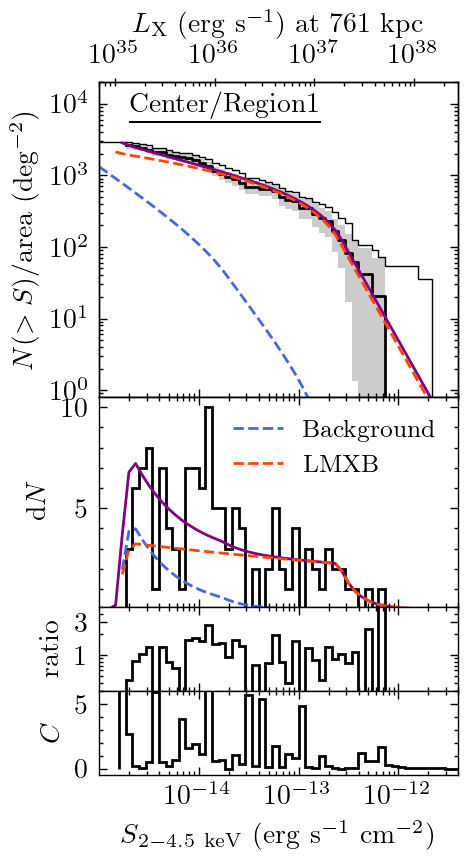

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


5 Disk
(((usermodel.Disk_AGN + usermodel.Disk_star) + usermodel.Disk_LMXB) + usermodel.Disk_HMXB)
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   Disk_AGN.K   linked      133.187         expr: Back_AGN.K           
   Disk_AGN.beta1 linked      1.96107     expr: Back_AGN.beta1           
   Disk_AGN.beta2 linked       2.8626     expr: Back_AGN.beta2           
   Disk_AGN.fb  linked      1.71448        expr: Back_AGN.fb           
   Disk_star.A  linked            0        expr: Back_star.A           
   Disk_star.alpha linked            0    expr: Back_star.alpha           
   Disk_LMXB.K  frozen            0            0           70           
   Disk_LMXB.beta1 frozen      1.42169          0.1            3           
   Disk_LMXB.beta2 frozen      2.59163          1.5            6           
   Disk_LMXB.fb frozen      92.4022           10          150           
   Disk_LMXB.cutoff

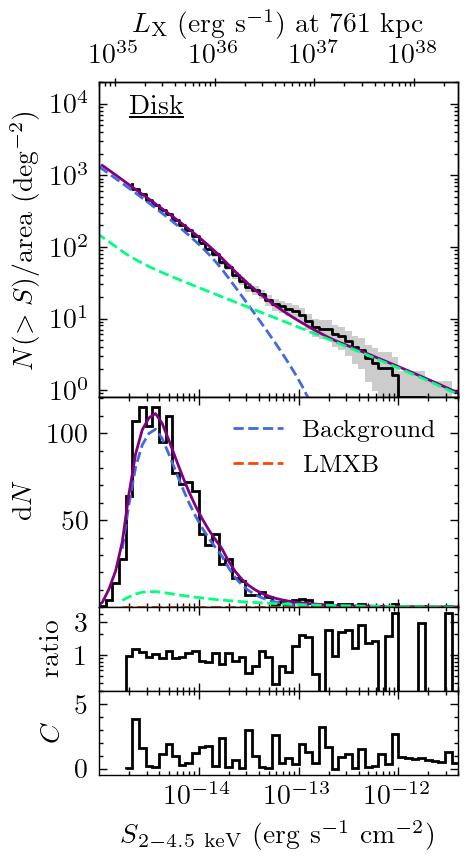

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


6 Ring
(((usermodel.Ring_AGN + usermodel.Ring_star) + usermodel.Ring_LMXB) + usermodel.Ring_HMXB)
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   Ring_AGN.K   linked      133.187         expr: Back_AGN.K           
   Ring_AGN.beta1 linked      1.96107     expr: Back_AGN.beta1           
   Ring_AGN.beta2 linked       2.8626     expr: Back_AGN.beta2           
   Ring_AGN.fb  linked      1.71448        expr: Back_AGN.fb           
   Ring_star.A  linked            0        expr: Back_star.A           
   Ring_star.alpha linked            0    expr: Back_star.alpha           
   Ring_LMXB.K  frozen            0            0          300           
   Ring_LMXB.beta1 frozen     0.984234          0.1            3           
   Ring_LMXB.beta2 frozen      3.26049          1.5            6           
   Ring_LMXB.fb frozen       51.954           10          120           
   Ring_LMXB.cutoff

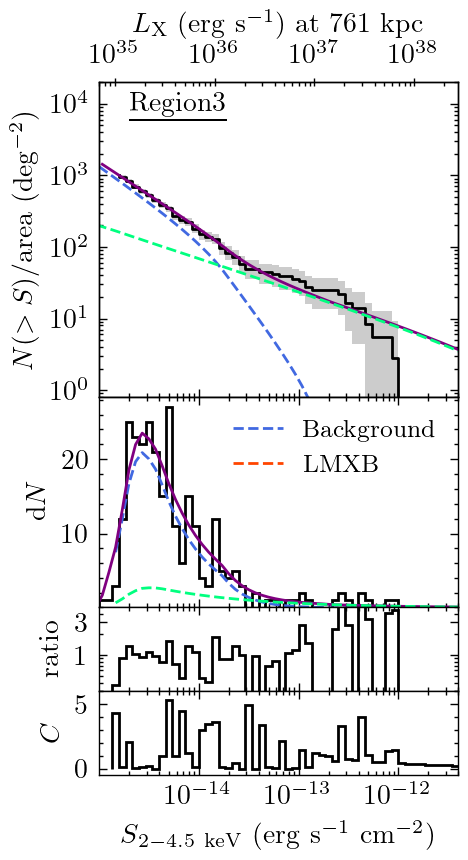

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


7 InnerArm
(((usermodel.InnerArm_AGN + usermodel.InnerArm_star) + usermodel.InnerArm_LMXB) + usermodel.InnerArm_HMXB)
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   InnerArm_AGN.K linked      133.187         expr: Back_AGN.K           
   InnerArm_AGN.beta1 linked      1.96107     expr: Back_AGN.beta1           
   InnerArm_AGN.beta2 linked       2.8626     expr: Back_AGN.beta2           
   InnerArm_AGN.fb linked      1.71448        expr: Back_AGN.fb           
   InnerArm_star.A linked            0        expr: Back_star.A           
   InnerArm_star.alpha linked            0    expr: Back_star.alpha           
   InnerArm_LMXB.K frozen            0            0          600           
   InnerArm_LMXB.beta1 frozen      1.40157          0.1            3           
   InnerArm_LMXB.beta2 frozen            6          1.5            6           
   InnerArm_LMXB.fb frozen      35.9964  

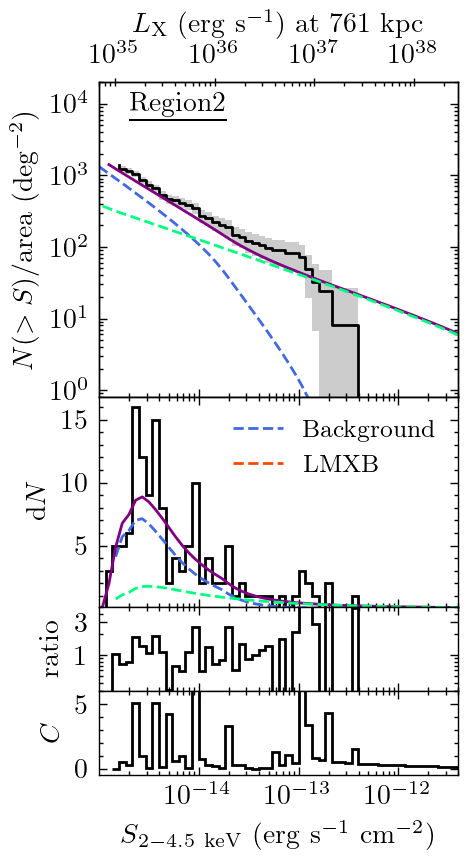

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


8 InterArm
(((usermodel.InterArm_AGN + usermodel.InterArm_star) + usermodel.InterArm_LMXB) + usermodel.InterArm_HMXB)
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   InterArm_AGN.K linked      133.187         expr: Back_AGN.K           
   InterArm_AGN.beta1 linked      1.96107     expr: Back_AGN.beta1           
   InterArm_AGN.beta2 linked       2.8626     expr: Back_AGN.beta2           
   InterArm_AGN.fb linked      1.71448        expr: Back_AGN.fb           
   InterArm_star.A linked            0        expr: Back_star.A           
   InterArm_star.alpha linked            0    expr: Back_star.alpha           
   InterArm_LMXB.K frozen            0            0           70           
   InterArm_LMXB.beta1 frozen      1.19202          0.1            3           
   InterArm_LMXB.beta2 frozen      2.31848          1.5            6           
   InterArm_LMXB.fb frozen          150  

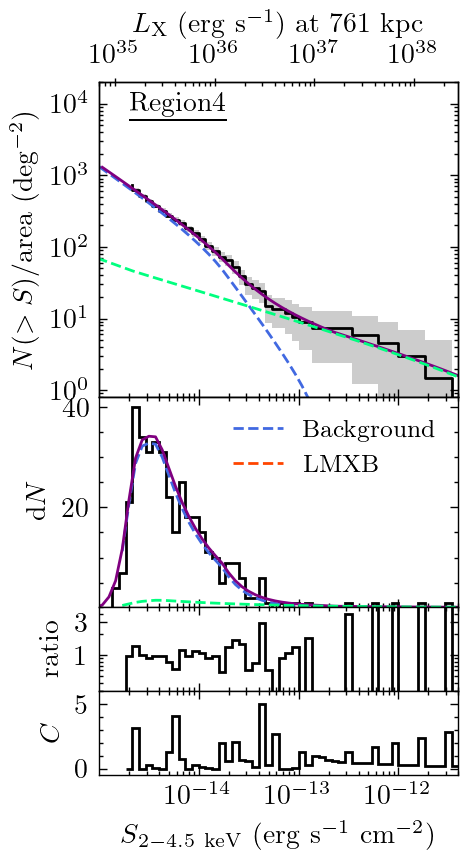

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


9 All
(((usermodel.All_AGN + usermodel.All_star) + usermodel.All_LMXB) + usermodel.All_HMXB)
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   All_AGN.K    linked      133.187         expr: Back_AGN.K           
   All_AGN.beta1 linked      1.96107     expr: Back_AGN.beta1           
   All_AGN.beta2 linked       2.8626     expr: Back_AGN.beta2           
   All_AGN.fb   linked      1.71448        expr: Back_AGN.fb           
   All_star.A   linked            0        expr: Back_star.A           
   All_star.alpha linked            0    expr: Back_star.alpha           
   All_LMXB.K   frozen            0            0           70           
   All_LMXB.beta1 frozen      1.24327          0.1            3           
   All_LMXB.beta2 frozen      2.45678          1.5            6           
   All_LMXB.fb  frozen      31.3499           10          150           
   All_LMXB.cutoff frozen    

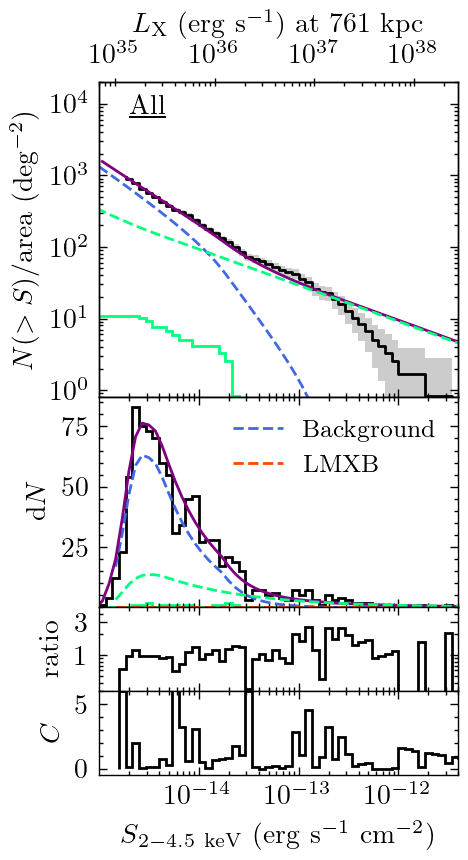

In [254]:
for i,region_label in enumerate(['Back','North','South','Center','Disk','Ring','InnerArm','InterArm','All']):
    print(i+1,region_label)
    m = i+1
    if m not in [1,4,5,6,7,8,9,]: #[1,2,3,4,5,6,7,8,9]: # [2,3]: #
        continue
# region_label_list = ['Back','North','South','Center','Arm152','Disk','Arm01','Arm12','Arm015','Arm115','Arm2','Arm23','Arm3','Arm34','Arm4','Disk_small']
# for i in [1,4,11,5,6]:
# # for i,region_label in enumerate(['Back','North','South','Center','Arm152','Disk','Arm01','Arm12','Arm015','Arm115','Arm2','Arm23','Arm3','Arm34','Arm4','Disk_small']):
#     region_label = region_label_list[i-1]
#     print(region_label)
    # if region_label=='Back' or  region_label == 'North' or  region_label == 'South':
    #     def model(x,para):
    #         return brokenpl_dN(x,para[0:4])+power_law(x,para[4:])
    # elif region_label=='Center':
    #     def model(x,para):
    #         return brokenpl_dN(x,para[0:4])+power_law(x,para[4:6])#+cutoff_brokenpl_dN(x,para[6:11])
    #     def LMXB_model(x,para):
    #         return cutoff_brokenpl_dN(x,para[6:11])
    # else:
    def model(x,para):
        return brokenpl_dN(x,para[0:4])+power_law(x,para[4:6])#+cutoff_power_law(x,para[11:16]) #+cutoff_brokenpl_dN(x,para[6:11])
    def LMXB_model(x,para):
        return cutoff_brokenpl_dN(x,para[6:11])
    def HMXB_model(x,para):
        return cutoff_power_law(x,para[11:16])
    
    exec(f"""para= tuple([i.val for i in {region_label}_source_model.pars])""")
    exec(f"""print({region_label}_source_model)""")
    if region_label == 'Center':
        exec(f"""model_dN = model(S_model,para) * dS_model * XLF_Data_band['{region_label}']['sky_area_function'] + LMXB_model(S_model,para) * dS_model * XLF_Data_band['{region_label}']['mass_function']""")
    elif region_label!='Back' and region_label!='North' and region_label!='South' and region_label!='Back':
        exec(f"""model_dN = model(S_model,para) * dS_model * XLF_Data_band['{region_label}']['sky_area_function'] + LMXB_model(S_model,para) * dS_model * XLF_Data_band['{region_label}']['mass_function'] + HMXB_model(S_model,para) * dS_model * XLF_Data_band['{region_label}']['SFR_function']""")
    else:
        exec(f"""model_dN = model(S_model,para) * dS_model * XLF_Data_band['{region_label}']['sky_area_function']""")
        
    exec(f"""cutoff_sensitivity=XLF_Data_band['{region_label}']['cutoff_sensitivity']""")
    exec(f"""XLF_Data_band_inner_dict=XLF_Data_band['{region_label}']""")
    
    rebin_indices = np.floor(np.arange(len(model_dN)) / expanded_times).astype(int)
    new_model_dN = np.bincount(rebin_indices, weights=model_dN)
    # plt.plot(S_data,new_model_dN)
    if region_label == 'Center':
        model_dN_corr = model(S_model,para) * dS_model + \
                   LMXB_model(S_model,para) * dS_model * XLF_Data_band[f'{region_label}']['mass_function']/XLF_Data_band[f'{region_label}']['sky_area_function']
    elif region_label!='Back' and region_label!='North' and region_label!='South' and region_label!='Back':
        model_dN_corr = model(S_model,para) * dS_model + \
                   LMXB_model(S_model,para) * dS_model * XLF_Data_band[f'{region_label}']['mass_function']/XLF_Data_band[f'{region_label}']['sky_area_function'] + \
                   HMXB_model(S_model,para) * dS_model * XLF_Data_band[f'{region_label}']['SFR_function']/XLF_Data_band[f'{region_label}']['sky_area_function']
    else:
        model_dN_corr = model(S_model,para) * dS_model
        
    rebin_indices = np.floor(np.arange(len(model_dN_corr)) / expanded_times).astype(int)
    new_model_dN_corr = np.bincount(rebin_indices, weights=model_dN_corr)
    new_model_N_corr = np.cumsum(new_model_dN_corr[::-1])[::-1]

    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec

    exec(f"""dN = XLF_Data_band['{region_label}']['dN']""")
    exec(f"""N_corr = XLF_Data_band['{region_label}']['N_corr']""")
    plt.figure(figsize=(16./3./2.3,9./2.),dpi=200)
    # grid = GridSpec(3, 1, height_ratios=[3, 2, 1])
    grid = GridSpec(4, 1, height_ratios=[3, 2, 0.8,0.8])
    ax1=plt.subplot(grid[0, 0])

    def Luo_AGN_N(S,K,beta1,beta2,fb):
        S_ref = 1e-14
    #     K = 453.7e14
    #     beta1 = 1.46
    #     beta2 = 2.72
    #     fb = 0.89
        c = K*(fb*1e-14/S_ref)**(beta2-beta1)*(fb*1e-14/S_ref)**(-beta2)*fb*1e-14/(beta2-1)
        N = K*(S/S_ref)**(-beta1)*(S)/(beta1-1)-K*(fb*1e-14/S_ref)**(-beta1)*(fb*1e-14)/(beta1-1)+c
        index = S>fb*1e-14
        N[index] =  K*(fb*1e-14/S_ref)**(beta2-beta1)*(S[index]/S_ref)**(-beta2)*S[index]/(beta2-1) #S>fb
        return N
    if region_label == 'Back' or  region_label == 'North' or  region_label == 'South':
        plt.plot(S_data/1.665, Luo_AGN_N(S_data,453.7e14,1.46,2.72,0.89 ),color='green',ls=':',label='Luo et al. 2016')
# #     plt.plot(S_data, Luo_AGN_N(S_data,360e14,1.46,2.72,0.537 ),color='green',ls=':',label='Luo et al. 2016')
    stellar_mass_per_deg = 0
    SFR_per_deg = 0
#     if region_label == 'Center':
#         stellar_mass_per_deg = 4.0755/0.196
#         SFR_per_deg = 0.180/0.196
    if region_label == 'Disk':
        S_ = S_model
        stellar_mass_per_deg = 2.5172/2.359
        SFR_per_deg = 0.370/2.359
    if region_label == 'Center':
        S_ = S_model
        stellar_mass_per_deg = 2.5872/0.1880
        SFR_per_deg = 0.152/0.1880
#     if region_label == 'Center' or region_label=='Disk' or region_label=='Arm2' or region_label=='Arm152':
#     if region_label == 'Center' or region_label == 'Disk':
#         stellar_mass_per_deg = XLF_Data_band[region_label]['StellarMass']/np.max(XLF_Data_band[region_label]['sky_area_function'])
# #         plt.plot(S_/3.124, LMXB_N(S_,XLF_Data_band[region_label]['StellarMass']/*4.15,1.02,2.06,144.3*0.546),color='violet',alpha=1.0,ls=':',label='LMXB\nZhang et al. 2012')
#         if stellar_mass_per_deg!=0:
    #         plt.plot(S_/3.124, LMXB_N(S_,stellar_mass_per_deg*2.6,1.31,2.57,144.3*2.16),color='cyan',ls=':',label='reference')
            # plt.plot(S_/3.124, LMXB_N(S_,stellar_mass_per_deg*4.15,1.02,2.06,144.3*0.546),color='violet',alpha=1.0,ls=':',label='LMXB\nZhang et al. 2012')
    #         plt.plot(S_/3.124, LMXB_N(S_,stellar_mass_per_deg*3.38,1.28,2.33,144.3*1.48),color='m',ls=':',label='LMXB\nLehmer et al. 2019')
    #     if SFR_per_deg!=0:
    #         plt.plot(S_/3.124, HMXB_N(S_,SFR_per_deg*2.06,1.66),color='deeppink',ls=':',alpha=0.5,label='HMXB\nMineo et al. 2012')
    #         plt.plot(S_/3.124, HMXB_N(S_,SFR_per_deg*1.96,1.65),color='deeppink',ls=':',label='HMXB\nLehmer et al. 2019')

    plt.xscale('log')
    plt.yscale('log')
    
    
#     plt.stairs(np.cumsum(dN[::-1])[::-1],data_bins,color='k',label='N')
#     plt.plot(S_data,np.cumsum(new_model_dN[::-1])[::-1],color='grey')
    # plt.stairs(dN,data_bins)
    # print(np.nanmax((np.cumsum(dN[::-1])[::-1])/N_corr))
#     plt.stairs(N_corr,data_bins,color='k',) #
    
#     plt.stairs(N_corr[data_bins[:-1]>cutoff_sensitivity],data_bins[data_bins>cutoff_sensitivity],color='k')
    plt.step(data_bins[data_bins>cutoff_sensitivity][1:],N_corr[data_bins[:-1]>cutoff_sensitivity],where='pre',color='k')
    
    plt.fill_between(data_bins[data_bins>cutoff_sensitivity][1:], \
                     (N_corr-XLF_Data_band_inner_dict['N_err_corr'])[data_bins[:-1]>cutoff_sensitivity],(N_corr+XLF_Data_band_inner_dict['N_err_corr'])[data_bins[:-1]>cutoff_sensitivity], \
                     color='k',step='pre',edgecolors=None,alpha=0.2)
    
    plt.yscale('log')
    plt.ylim(0.8,2e4)
    plt.ylabel('$N(>S)/\mathrm{area}~\mathrm{(deg^{-2})}$')
    exec(f"""plot_model(S_model,dS_model,brokenpl_dN,tuple([i.val for i in {region_label}_AGN.pars]),color='royalblue',)""")
    exec(f"""plot_model(S_model,dS_model,power_law,tuple([i.val for i in {region_label}_star.pars]),color='pink',)""")
    if Back_star.A.val == 0 and region_label=='Back':
        pass
    else:
        # plt.plot(S_data,np.cumsum(new_model_dN_corr[::-1])[::-1],color='grey')
        plt.plot(S_data,np.cumsum(new_model_dN_corr[::-1])[::-1],color='purple')
#     Center_LMXB.cutoff.max = -9
#     Center_LMXB.cutoff = -12
#     if region_label != 'Back' and  region_label != 'North' and  region_label != 'South' :
#         exec(f"""plot_model(S_model,dS_model,cutoff_brokenpl_dN,tuple([i.val for i in {region_label}_LMXB.pars]),color='orangered',)""")
#     Center_LMXB.cutoff = -11
#     if region_label != 'Back' and  region_label != 'North' and  region_label != 'South':
#         exec(f"""plot_model(S_model,dS_model,cutoff_brokenpl_dN,tuple([i.val for i in {region_label}_LMXB.pars]),color='orangered',)""")
#     Center_LMXB.cutoff = -9.34
    if region_label != 'Back' and  region_label != 'North' and  region_label != 'South':
        # exec(f"""plot_model(S_model,dS_model,cutoff_brokenpl_dN,tuple([i.val for i in {region_label}_LMXB.pars]),color='pink',)""")
        plt.plot(S_model,np.cumsum((LMXB_model(S_model,para) * dS_model * XLF_Data_band[f'{region_label}']['mass_function']/XLF_Data_band[f'{region_label}']['sky_area_function'])[::-1])[::-1],linestyle='--',color='orangered')
        # plt.plot(S_model,np.cumsum((LMXB_model(S_model,para) * dS_model * np.max(XLF_Data_band[f'{region_label}']['mass_function'])/np.max(XLF_Data_band[f'{region_label}']['sky_area_function']))[::-1])[::-1],linestyle='--',color='pink')
    if region_label != 'Back' and region_label != 'Center' and  region_label != 'North' and  region_label != 'South':
        plt.plot(S_model,np.cumsum((HMXB_model(S_model,para) * dS_model * XLF_Data_band[f'{region_label}']['SFR_function']/XLF_Data_band[f'{region_label}']['sky_area_function'])[::-1])[::-1],linestyle='--',color='springgreen')
        # exec(f"""plot_model(S_model,dS_model,cutoff_power_law,tuple([i.val for i in {region_label}_HMXB.pars]),color='springgreen',)""")
    plt.legend(fontsize=8,loc='upper right', bbox_to_anchor=(1, 0.93))
#     plt.title(region_label)
#     if region_label == 'Center':
#         CXC_dN,CXC_bins = np.histogram(M31_CXC_vulic[M31_CXC_vulic['Dist']<15]['FluxHSum'],np.logspace(-18,-10,50)) # 2.0-8.0 keV
#         print(np.sum(M31_CXC_vulic['Dist']<15))
#         plt.stairs(np.cumsum(CXC_dN[::-1])[::-1]/(np.pi*(15/60.)**2),CXC_bins/1.88,color='brown')
#         # plt.stairs(np.cumsum(dN[::-1])[::-1]/(np.pi*(15/60.)**2),bins,)
#         plt.stairs(np.cumsum(CXC_dN[::-1])[::-1]/(np.pi*(15/60.)**2),CXC_bins*1.3,)
    if region_label == 'Center':
        # thin line
        plt.stairs(XLF_Data_band['Center08']['N_corr'],data_bins,color='k',lw=0.5)
#         plt.stairs(XLF_Data_band['Center015']['N_corr'],data_bins,color='darkviolet',alpha=1.0) # thin line
    if region_label == "Back":
        label = 'Background'
    elif region_label == "Center":
        label = 'Center/Region1'
    elif region_label == "Ring":
        label = 'Region3'
    elif region_label == "InnerArm":
        label = 'Region2'
    elif region_label == "InterArm":
        label = 'Region4'
    else:
        label = region_label
    plt.text(2e-15, 9e3, fr'$\mathrm{{\underline{{{label}}}}}$', ha='left', va='center', weight='bold', fontsize=10)
#     plt.text(2e-15, 3, fr'$\mathrm{{\underline{{{label}}}}}$', ha='left', va='center', weight='bold', fontsize=10)
    if region_label == 'All':
        plt.stairs(np.cumsum((XLF_Data_band['All_HMXB']['dN'])[::-1])[::-1]/np.max(XLF_Data_band['All_HMXB']['sky_area_function']),data_bins,color='springgreen',label='HMXB')

    ax2=plt.subplot(grid[1, 0], sharex=plt.subplot(grid[0, 0]))
    exec(f"""ui.plot_model_component({i+1},{region_label}_AGN,overplot=True,color='royalblue',linestyle='--')""")
    exec(f"""ui.plot_model_component({i+1},{region_label}_star,overplot=True,color='pink',linestyle='--')""")
#     exec(f"""ui.plot_model_component({i+1},{region_label}_star,overplot=True,color='pink',linestyle='--')""")
    if region_label != 'Back' and  region_label != 'North' and  region_label != 'South':
        exec(f"""ui.plot_model_component({i+1},{region_label}_LMXB,overplot=True,color='orangered',linestyle='--')""")
    if  Disk_HMXB.A.val !=0:
        if region_label != 'Back' and region_label != 'Center' and  region_label != 'North' and  region_label != 'South':
            exec(f"""ui.plot_model_component({i+1},{region_label}_HMXB,overplot=True,color='springgreen',linestyle='--')""")
    plt.ylabel(r'd$N$')
    print(region_label)
    if Back_star.A.val == 0:
        if region_label == 'Back' or region_label == 'North' or  region_label == 'South':
            plt.plot([],[],linestyle='--',color='royalblue',label='Background')
            plt.legend(['Background',],fontsize=9)
            pass
        elif region_label == 'Center':
            plt.plot([],[],linestyle='--',color='royalblue',label='Background')
            plt.plot([],[],linestyle='--',color='orangered',label='LMXB')
            plt.legend(['Background','LMXB'],fontsize=9)
        elif Disk_HMXB.A.val == 0:
            plt.plot([],[],linestyle='--',color='royalblue',label='Background')
            plt.plot([],[],linestyle='--',color='orangered',label='LMXB')
            plt.legend(['Background','LMXB'],fontsize=9)
        else:
            plt.plot([],[],linestyle='--',color='royalblue',label='Background')
            plt.plot([],[],linestyle='--',color='orangered',label='LMXB')
            plt.plot([],[],linestyle='--',color='springgreen',label='HMXB')
            plt.legend(['Background','LMXB','HMXB'],fontsize=9)
        # ax2.legend(['Background','LMXB','HMXB'],fontsize=9)
        # plt.legend(['Background','LMXB','HMXB'],fontsize=9)
        # exec(f"""ui.plot_model_component({i+1},{region_label}_AGN,overplot=True,color='royalblue',linestyle='--')""")
        # ax2.legend(['Background','LMXB','HMXB'],fontsize=9)
            
    plt.legend(['Background','LMXB'],fontsize=9)
    
    if region_label == 'North':
        plt.stairs(XLF_Data_band['North_star']['dN'],data_bins,color='pink',label='fg star')
    if region_label == 'South':
        plt.stairs(XLF_Data_band['South_star']['dN'],data_bins,color='pink',label='fg star')
    if region_label == 'All':
        plt.stairs(XLF_Data_band['All_HMXB']['dN'],data_bins,color='springgreen',label='HMXB')


        
    dS = data_bins[1:]-data_bins[:-1]
    plt.stairs(dN,data_bins,color='k')
    if  region_label =='Back' and Back_star.A.val ==0:
        pass
    else:
        # plt.plot(S_data,new_model_dN,color='grey')
        plt.plot(S_data,new_model_dN,color='purple')
#     plt.yscale('log')
    plt.ylim(.1,)

#     ax3=plt.subplot(grid[2, 0], sharex=plt.subplot(grid[0, 0]))
#     C = 2*(new_model_dN-dN+(dN+1e-25)*(np.log(dN+1e-25)-np.log(new_model_dN+1e-25)))
#     plt.stairs(C[data_bins[:-1]>cutoff_sensitivity],data_bins[data_bins>cutoff_sensitivity],color='k')
#     # plt.stairs((dN/new_model_dN),data_bins)
#     plt.ylim([-0.5,6])
#     plt.ylabel(r'$C$')
#     plt.xscale('log')
#     plt.xticks([1e-14,1e-13,1e-12],)
#     plt.xlim([1e-15,4e-12])
#     plt.xlabel('$S\mathrm{_{2-4.5~keV}~(erg~s^{-1}~cm^{-2})}$')

#     ax1_top = ax1.twiny()
#     ax1_top.set_xlim(ax1.get_xlim())  # Make sure the new x-axis range matches the original

#     ax1_top.set_xticks(ax3.get_xticks())
#     ax1_top.set_xbound(ax3.get_xbound())
# #     ax1_top.set_xticklabels(second_xtick_labels)
#     ax1_top.set_xlim([flux2luminosity(ax3.get_xbound()[0]),flux2luminosity(ax3.get_xbound()[1])])
#     ax1_top.set_xscale('log')
#     ax1_top.set_xticks([1e35,1e36,1e37,1e38])
#     ax1_top.tick_params(axis='x', direction='inout', labeltop=True)
    
#     plt.xlabel(r'$L\mathrm{_X~(erg~s^{-1})}$ at 761 kpc')
    
    ax3=plt.subplot(grid[2, 0], sharex=plt.subplot(grid[0, 0]))
    ratio = (dN)/new_model_dN
    plt.stairs(ratio[data_bins[:-1]>cutoff_sensitivity],data_bins[data_bins>cutoff_sensitivity],color='k')
    plt.ylim(0.3,5)
    plt.ylabel(r'ratio')
    plt.yscale('log')
    plt.xscale('log')
    plt.yticks([1,3,],[1,3,])
    
    ax4=plt.subplot(grid[3, 0], sharex=plt.subplot(grid[0, 0]))
    C = 2*(new_model_dN-dN+(dN+1e-25)*(np.log(dN+1e-25)-np.log(new_model_dN+1e-25)))
    # New_residual = (dN-new_model_dN)/new_model_dN
    # ratio = (dN)/new_model_dN
    plt.stairs(C[data_bins[:-1]>cutoff_sensitivity],data_bins[data_bins>cutoff_sensitivity],color='k')
    # plt.stairs(ratio[data_bins[:-1]>cutoff_sensitivity],data_bins[data_bins>cutoff_sensitivity],color='k')
    # plt.stairs((dN/new_model_dN),data_bins)
    plt.ylim([-0.5,6])
    # plt.ylim([-6,6])
    # plt.ylim(0.3,8)
    plt.ylabel(r'$C$')
    # plt.ylabel(r'$(m-N)/m$')
    # plt.ylabel(r'ratio')
    # plt.yscale('log')
    plt.xscale('log')
    plt.xticks([1e-14,1e-13,1e-12],)
    plt.xlim([1e-15,4e-12])
    plt.xlabel('$S\mathrm{_{2-4.5~keV}~(erg~s^{-1}~cm^{-2})}$')

    ax1_top = ax1.twiny()
    ax1_top.set_xlim(ax1.get_xlim())  # Make sure the new x-axis range matches the original

    ax1_top.set_xticks(ax4.get_xticks())
    ax1_top.set_xbound(ax4.get_xbound())
#     ax1_top.set_xticklabels(second_xtick_labels)
    ax1_top.set_xlim([flux2luminosity(ax4.get_xbound()[0]),flux2luminosity(ax4.get_xbound()[1])])
    ax1_top.set_xscale('log')
    ax1_top.set_xticks([1e35,1e36,1e37,1e38])
    ax1_top.tick_params(axis='x', direction='inout', labeltop=True)
    
    plt.xlabel(r'$L\mathrm{_X~(erg~s^{-1})}$ at 761 kpc')

#     plt.xlim(cutoff_sensitivity,)
    plt.subplots_adjust(hspace=0)
#     plt.savefig(f'figure/XLF_fitting_{region_label}_RegionV3.2_v6.0_LMXB.png')
#     plt.savefig(f'figure/XLF_fitting_{region_label}_RegionV3.2_v6.0_LMXB.pdf')
#     plt.savefig(f'figure/XLF_fitting_{region_label}_RegionV3.2_SrcV2_v6.0_LMXB.png')
#     plt.savefig(f'figure/XLF_fitting_{region_label}_RegionV3.2_SrcV2_v6.0_LMXB.pdf')
    # plt.savefig(f'figure/XLF_fitting_{region_label}_RegionV3.2_SrcV2_Scut2e-13_v6.0_LMXB.png')
    # plt.savefig(f'figure/XLF_fitting_{region_label}_RegionV3.2_SrcV2_Scut2e-13_v6.0_LMXB.pdf')
    # plt.savefig(f'figure/XLF_fitting_{region_label}_RegionV3.2_v8.1_LMXB_4panel.pdf')
    plt.savefig(f'figure/XLF_fitting_{region_label}_RegionV3.2_v8.1_HMXB_4panel.pdf')
#     plt.savefig(f'figure/XLF_fitting_{region_label}_v5.1_LMXB.png')
#     plt.savefig(f'figure/XLF_fitting_{region_label}_v5.1_LMXB.pdf')
#     plt.savefig(f'figure/XLF_fitting_{region_label}_v5.2_FixLMXB_1.6HMXB.png') # fix LMXB as in center
#     plt.savefig(f'figure/XLF_fitting_{region_label}_v5.2_FixLMXB_1.6HMXB.pdf')
#     plt.savefig(f'figure/XLF_fitting_{region_label}_v5.3_armLMXB_1.6HMXB.png') # fix LMXB as in arm
#     plt.savefig(f'figure/XLF_fitting_{region_label}_v5.3_armLMXB_1.6HMXB.pdf') 
#     plt.savefig(f'figure/XLF_fitting_{region_label}_v5.4_LMXB_1.6HMXB.png') # free LMXB in disk
#     plt.savefig(f'figure/XLF_fitting_{region_label}_v5.4_LMXB_1.6HMXB.pdf')
#     plt.savefig(f'figure/XLF_fitting_{region_label}_v5.5_LMXB_1.6HMXB.png') # free LMXB in arm, and include arm in the arm.
#     plt.savefig(f'figure/XLF_fitting_{region_label}_v5.5_LMXB_1.6HMXB.pdf')
    plt.show()